## Attach Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Model

### extra functions

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import csv
import math
import pandas

def plot_log(filename, show=True):

    data = pandas.read_csv(filename)

    fig = plt.figure(figsize=(4,6))
    fig.subplots_adjust(top=0.95, bottom=0.05, right=0.95)
    fig.add_subplot(211)
    for key in data.keys():
        if key.find('loss') >= 0 and not key.find('val') >= 0:  # training loss
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training loss')

    fig.add_subplot(212)
    for key in data.keys():
        if key.find('acc') >= 0:  # acc
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training and validation accuracy')

    # fig.savefig('result/log.png')
    if show:
        plt.show()


def combine_images(generated_images, height=None, width=None):
    num = generated_images.shape[0]
    if width is None and height is None:
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
    elif width is not None and height is None:  # height not given
        height = int(math.ceil(float(num)/width))
    elif height is not None and width is None:  # width not given
        width = int(math.ceil(float(num)/height))

    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

### Layers

In [3]:
"""
Some key layers used for constructing a Capsule Network. These layers can used to construct CapsNet on other dataset, 
not just on MNIST.
*NOTE*: some functions can be implemented in multiple ways, I keep all of them. You can try them for yourself just by
uncommenting them and commenting their counterparts.

Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
"""

import keras.backend as K
import tensorflow as tf
from keras import initializers, layers
# from keras.backend import manual_variable_initialization
# manual_variable_initialization(True)

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        inputs_expand = K.expand_dims(inputs, 1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule]
        inputs_tiled = K.tile(inputs_expand, [1, self.num_capsule, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs_tiled)

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, input_num_capsule]
            c = tf.nn.softmax(b, dim=1)

            # c.shape =  [batch_size, num_capsule, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, num_capsule, dim_capsule]
            outputs = squash(K.batch_dot(c, inputs_hat, [2, 2]))  # [None, 10, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, num_capsule, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [2, 3])
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)



# The following is another way to implement primary capsule layer. This is much slower.
# Apply Conv2D `n_channels` times and concatenate all capsules
# def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
#     outputs = []
#     for _ in range(n_channels):
#         output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
#         outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))
#     outputs = layers.Concatenate(axis=1)(outputs)
#     return layers.Lambda(squash)(outputs)


Using TensorFlow backend.


### Model

In [0]:
"""
Keras implementation of CapsNet in Hinton's paper Dynamic Routing Between Capsules.
The current version maybe only works for TensorFlow backend. Actually it will be straightforward to re-write to TF code.
Adopting to other backends should be easy, but I have not tested this. 
Usage:
       python capsulenet.py
       python capsulenet.py --epochs 50
       python capsulenet.py --epochs 50 --routings 3
       ... ...
       
Result:
    Validation accuracy > 99.5% after 20 epochs. Converge to 99.66% after 50 epochs.
    About 110 seconds per epoch on a single GTX1070 GPU card
    
Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
"""

import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
import cv2

K.set_image_data_format('channels_last')


def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid',activation = 'linear', name='conv1')(x)
    leaky = layers.LeakyReLU(alpha=0.3)(conv1)
    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(leaky, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction
    
    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation=None, input_dim=16*n_class))
    decoder.add(layers.LeakyReLU(alpha=0.3))
    decoder.add(layers.Dense(1024, activation=None))
    decoder.add(layers.LeakyReLU(alpha=0.3))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))


def train(model, data, args):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger(args.save_dir + '/log.csv')
    tb = callbacks.TensorBoard(log_dir=args.save_dir + '/tensorboard-logs',
                               batch_size=args.batch_size, histogram_freq=int(args.debug))
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights-{epoch:02d}.h5', monitor='val_capsnet_acc',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * (args.lr_decay ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args.lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args.lam_recon],
                  metrics={'capsnet': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, lr_decay])
    """

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, args.batch_size, args.shift_fraction),
                        steps_per_epoch=int(y_train.shape[0] / args.batch_size),
                        epochs=args.epochs,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, tb, checkpoint, lr_decay])
    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save_weights(args.save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % args.save_dir)

#     from utils import plot_log
    plot_log(args.save_dir + '/log.csv', show=True)

    return model


def test(model, data, args):
    x_test, y_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=100)
    print('-'*30 + 'Begin: test' + '-'*30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
    print()
    print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
    plt.show()
def test_my_data(model, data, args):
    x_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=8)
    print('-'*30 + 'Begin: Prediction' + '-'*30)
#     print('-'*30 + y_pred + '-'*30)
#     print(y_pred)
    print (np.argmax(y_pred, axis=1))

#     img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    img = combine_images(x_test, height = 1)
    image = img * 255
    image = image.astype(np.uint8)
#     cv2.imwrite("/detected-boxes.jpg", image)
    #Image.fromarray(image).save(args.save_dir + "/real_and_recon.png")
    print()
#     print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
#     plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
#     plt.imshow(plt.imread("/detected-boxes.jpg"))
    plt.imshow(image)
    plt.show()
    
# def test_my_data(model, data, args):
#     x_test = data
#     y_pred, x_recon = model.predict(x_test, batch_size=1)
#     print('-'*30 + 'Begin: Prediction' + '-'*30)
# #     print('-'*30 + y_pred + '-'*30)
# #     print(y_pred)
#     print (np.argmax(y_pred, axis=1))

# #     img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
#     image = x_test[0] * 255
#     image = image.astype(np.uint8)
#     cv2.imwrite("/detected-boxes.jpg", image)
#     #Image.fromarray(image).save(args.save_dir + "/real_and_recon.png")
#     print()
# #     print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
#     print('-' * 30 + 'End: test' + '-' * 30)
# #     plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
#     plt.imshow(plt.imread("/detected-boxes.jpg"))
#     plt.show()
    
# def manipulate_latent(model, data, args):
#     print('-'*30 + 'Begin: manipulate' + '-'*30)
#     x_test, y_test = data
#     index = np.argmax(y_test, 1) == args.digit
#     number = np.random.randint(low=0, high=sum(index) - 1)
#     x, y = x_test[index][number], y_test[index][number]
#     x, y = np.expand_dims(x, 0), np.expand_dims(y, 0)
#     noise = np.zeros([1, 10, 16])
#     x_recons = []
#     for dim in range(16):
#         for r in [-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]:
#             tmp = np.copy(noise)
#             tmp[:,:,dim] = r
#             x_recon = model.predict([x, y, tmp])
#             x_recons.append(x_recon)

#     x_recons = np.concatenate(x_recons)

#     img = combine_images(x_recons, height=16)
#     image = img*255
#     Image.fromarray(image.astype(np.uint8)).save(args.save_dir + '/manipulate-%d.png' % args.digit)
#     print('manipulated result saved to %s/manipulate-%d.png' % (args.save_dir, args.digit))
#     print('-' * 30 + 'End: manipulate' + '-' * 30)


def load_mnist():
    # the data, shuffled and split between train and test sets
    from keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    return (x_train, y_train), (x_test, y_test)
  
def load_amount_data():
    # the data, shuffled and split between train and test sets
#     from keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    return (x_train, y_train), (x_test, y_test)

from keras.preprocessing import image
import glob

def load_prediction_data():
    # the data, shuffled and split between train and test sets
    pred_data = None
#     dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/"
    dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/date_segmented3/"
    dirs = glob.glob(dir_path + "*/")
#     print (dirs)
    print (len(dirs))
    for direct in dirs:
      onlyfiles = glob.glob(direct + "*.tif")
      onlyfiles.sort()
#       print(onlyfiles)
      i=0
      for filepath in onlyfiles:
        __, filename = os.path.split(filepath)
        i+=1
        img = image.load_img(filepath, target_size=(150, 150), grayscale = True)
  #       print(type(img))

        x = image.img_to_array(img)
  #       print(type(x))
        x = x.astype('float32') / 255.
      #   plt.imshow(x/255.)
        if pred_data is None:
          pred_data = np.array([x])
        else:
          pred_data = np.concatenate((pred_data, [x]))
      #     img_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/position_1.tif"

    print(pred_data.shape)
    return pred_data

if __name__ == "__main__":
    import os
    import argparse
    from keras.preprocessing.image import ImageDataGenerator
    from keras import callbacks

    # setting the hyper parameters
#     parser = argparse.ArgumentParser(description="Capsule Network on MNIST.")
#     parser.add_argument('--epochs', default=50, type=int)
#     parser.add_argument('--batch_size', default=100, type=int)
#     parser.add_argument('--lr', default=0.001, type=float,
#                         help="Initial learning rate")
#     parser.add_argument('--lr_decay', default=0.9, type=float,
#                         help="The value multiplied by lr at each epoch. Set a larger value for larger epochs")
#     parser.add_argument('--lam_recon', default=0.392, type=float,
#                         help="The coefficient for the loss of decoder")
#     parser.add_argument('-r', '--routings', default=3, type=int,
#                         help="Number of iterations used in routing algorithm. should > 0")
#     parser.add_argument('--shift_fraction', default=0.1, type=float,
#                         help="Fraction of pixels to shift at most in each direction.")
#     parser.add_argument('--debug', action='store_true',
#                         help="Save weights by TensorBoard")
#     parser.add_argument('--save_dir', default='./result')
#     parser.add_argument('-t', '--testing', action='store_true',
#                         help="Test the trained model on testing dataset")
#     parser.add_argument('--digit', default=5, type=int,
#                         help="Digit to manipulate")
#     parser.add_argument('-w', '--weights', default=None,
#                         help="The path of the saved weights. Should be specified when testing")
#     args = parser.parse_args()
    class Args:
        batch_size = 100
        epochs = 50
        lr = 0.001
        lr_decay = 0.9
        lam_recon = 0.392
        routings = 3
        shift_fraction = 0.1
        debug = 0
        save_dir = './result'
        is_training = 0
    #     digit = 5
#         weights = None
        weights = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/Capsnet_Num/trained_model-11-19.h5'

    args = Args()
    
    args = Args()
#     print(args)

    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

    # load data
    (x_train, y_train), (x_val, y_val) = load_amount_data()

    # define model
    model, eval_model, manipulate_model = CapsNet(input_shape=(150,150,1),
                                                n_class=62,
                                            routings=args.routings)

    model.summary()
    
    # train or test
    if args.weights is not None:  # init the model weights with provided one
        model.load_weights(args.weights)
    if args.is_training:
        train(model=model, args=args)
#     else:  # as long as weights are given, will run testing
#         if args.weights is None:
#             print('No weights are provided. Will test using random initialized weights.')
# #         manipulate_latent(manipulate_model, (x_test, y_test), args)
# #         test(model=eval_model, data=(x_test, y_test), args=args)
#         x_test = load_prediction_data()
#         print(x_test.shape)
#         for i in range(0, x_test.shape[0], 8):
#           test_my_data(model=eval_model, data=x_test[i:i+8,], args=args)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 150, 150, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 142, 142, 256 20992       input_11[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_12 (LeakyReLU)      (None, 142, 142, 256 0           conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 67, 67, 256)  5308672     leaky_re_lu_12[0][0]             
__________________________________________________________________________________________________
primarycap

## Sampler

In [0]:
import glob
import json
import random
import csv
import os
import re
import argparse
import numpy as np

def list_pictures(directory, ext='bmp'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
              if f.endswith(ext)]
#             if re.match(r'([\w]+\.(?:' + ext + '))', f)]

def get_real_images(image_names,num_real_images):
    real_names = []
    random.shuffle(image_names)
    length = len(image_names)
    if int(num_real_images)>(length-1):
        num_real_images = length-1
    real_images = image_names[:num_real_images]
#     val_images = image_names[len(image_names) - val_images_num :]
#     test_images = image_names[num_real_images + 1: len(image_names) - val_images_num]
#     test_images = []
    return real_images

def triplet_sampler(directory_path, output_path,num_of_real_images, val_percent = 0.2, test_percent = 0.2):
    
    classes = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
    print (classes)
    print (len(classes))
    triplets = []
    triplets_val = []
    triplets_test = []
    for class_ in classes:
        image_names = list_pictures(os.path.join(directory_path,class_))
        real_image_list = get_real_images(image_names, num_of_real_images)
        train_percent = 1 - val_percent - test_percent
        total_len = len(real_image_list)
        train_len = int(total_len*train_percent)
        val_len = int(total_len*val_percent)
        test_len = int(total_len*test_percent)
        train_images = real_image_list[:train_len]
        val_images = real_image_list[train_len:train_len + val_len]
        test_images = real_image_list[train_len + val_len :]
        for image in train_images:
            triplets.append(image+'\n')
        for image in val_images:
            triplets_val.append(image+'\n')
        for image in test_images:
            triplets_test.append(image+'\n')
            
    random.shuffle(triplets)
    triplets[len(triplets)-1] = triplets[len(triplets)-1].strip()
    f = open(os.path.join(output_path,"train_set.txt"),'w')
    f.write("".join(triplets))
    f.close()
    triplets_val[len(triplets_val)-1] = triplets_val[len(triplets_val)-1].strip()
    f = open(os.path.join(output_path,"validation_set.txt"),'w')
    f.write("".join(triplets_val))
    f.close()
    triplets_test[len(triplets_test)-1] = triplets_test[len(triplets_test)-1].strip()
    f = open(os.path.join(output_path,"test_set.txt"),'w')
    f.write("".join(triplets_test))
    f.close()

# def triplet_sampler_val(directory_path, output_path,num_of_real_images):
    
#     classes = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
#     print (classes)
#     print (len(classes))
#     triplets = []
#     for class_ in classes:
#         image_names = list_pictures(os.path.join(directory_path,class_))
#         real_image_list = get_real_images(image_names, num_of_real_images)
#         for image in real_image_list:
#             triplets.append(image+'\n')    
#     triplets[len(triplets)-1] = triplets[len(triplets)-1].strip()
#     f = open(os.path.join(output_path,"singles_val.txt"),'w')
#     f.write("".join(triplets))
#     f.close()
    
class Args:
  input_directory = "/content/gdrive/My Drive/Nisarg Colab/Datasets/legal_amount/"
  output_directory = "/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/"
  num_pos_images = 100
#   num_pos_images_val = 10
  
args = Args()
  
if args.input_directory == None:
    print('Input Directory path is required!')
    quit()
elif args.output_directory == None:
    print('Output Directory path is required!')
    quit()
elif args.num_pos_images == None:
    print('Number of Positive Images is required!')
    quit()
elif int(args.num_pos_images) < 1:
    print('Number of Positive Images cannot be less than 1!')

if not os.path.exists(args.input_directory):
        print (args.input_directory+" path does not exist!")
        quit()

if not os.path.exists(args.output_directory):
        print (args.input_directory+" path does not exist!")
        quit()

print ("Input Directory: "+args.input_directory)
print ("Output Directory: "+args.output_directory)
print ("Number of Positive image per Query image: "+str(args.num_pos_images))

triplet_sampler(directory_path=args.input_directory,
                output_path=args.output_directory,
                num_of_real_images=args.num_pos_images,
                val_percent = 0.2,
                test_percent = 0.2)
# triplet_sampler_val(directory_path=args.input_directory, output_path=args.output_directory, num_of_real_images=args.num_pos_images_val)

Input Directory: /content/gdrive/My Drive/Nisarg Colab/Datasets/legal_amount/
Output Directory: /content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/
Number of Positive image per Query image: 100
['word1', 'word10', 'word11', 'word12', 'word13', 'word14', 'word15', 'word16', 'word17', 'word18', 'word19', 'word2', 'word20', 'word21', 'word22', 'word23', 'word24', 'word25', 'word26', 'word27', 'word28', 'word29', 'word3', 'word30', 'word31', 'word32', 'word33', 'word4', 'word5', 'word6', 'word7', 'word8', 'word9']
33


## Sampler ISIHWD_WRITER

In [0]:
import glob
import json
import random
import csv
import os
import re
import argparse
import numpy as np

def list_pictures(directory, ext='bmp'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
              if f.endswith(ext)]
#             if re.match(r'([\w]+\.(?:' + ext + '))', f)]

def get_real_images(image_names,num_real_images):
    real_names = []
    random.shuffle(image_names)
    length = len(image_names)
    if int(num_real_images)>(length-1):
        num_real_images = length-1
    real_images = image_names[:num_real_images]
#     val_images = image_names[len(image_names) - val_images_num :]
#     test_images = image_names[num_real_images + 1: len(image_names) - val_images_num]
#     test_images = []
    return real_images
def form_file_names(directory_path, output_path, classes, output_file_name):
    singles = []
    for class_name in classes:
        new_dir_path = directory_path + class_name
        new_classes = [d for d in os.listdir(new_dir_path) if os.path.isdir(os.path.join(new_dir_path, d))]
#         print (new_dir_path , len(new_classes))
        random.shuffle(new_classes)
        for class_ in new_classes:
            image_names = list_pictures(os.path.join(new_dir_path,class_))
#             print (image_names)
            for image in image_names:
                singles.append(image+'\n')
    random.shuffle(singles)
#     print (singles)
#     print (os.path.join(output_path,output_file_name))
    singles[len(singles)-1] = singles[len(singles)-1].strip()
    f = open(os.path.join(output_path,output_file_name),'w')
    f.write("".join(singles))
    f.close()
    
def triplet_sampler(directory_path, output_path,num_of_real_images, test_percent = 0.2):
    
    classes = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
    print (classes)
    print (len(classes))
    random.shuffle(classes)
    train_percent = 1 - test_percent
    total_len = len(classes)
    train_len = int(total_len*train_percent)
    test_len = int(total_len*test_percent)
    
    train_classes = classes[:train_len]
#     val_classes = classes[train_len:train_len + val_len]
    test_classes = classes[train_len :]
    
    print (len(train_classes), len(test_classes))
    print (len(train_classes)+ len(test_classes))
    
    form_file_names(directory_path, output_path, train_classes, "isihwd_train.txt")
#     form_file_names(directory_path, output_path, val_classes, "isihwd_val.txt")
    form_file_names(directory_path, output_path, test_classes, "isihwd_test.txt")
# def triplet_sampler(directory_path, output_path,num_of_real_images, val_percent = 0.2, test_percent = 0.2):
    
#     classes = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
#     print (classes)
#     print (len(classes))
#     random.shuffle(classes)
#     train_percent = 1 - val_percent - test_percent
#     total_len = len(classes)
#     train_len = int(total_len*train_percent)
#     val_len = int(total_len*val_percent)
#     test_len = int(total_len*test_percent)
    
#     train_classes = classes[:train_len]
#     val_classes = classes[train_len:train_len + val_len]
#     test_classes = classes[train_len + val_len :]
    
#     print (len(train_classes), len(val_classes), len(test_classes))
#     print (len(train_classes) + len(val_classes) + len(test_classes))
    
#     form_file_names(directory_path, output_path, train_classes, "isihwd_train.txt")
#     form_file_names(directory_path, output_path, val_classes, "isihwd_val.txt")
#     form_file_names(directory_path, output_path, test_classes, "isihwd_test.txt")

#     triplets = []
#     triplets_val = []
#     triplets_test = []
#     for class_ in classes:
#         image_names = list_pictures(os.path.join(directory_path,class_))
#         real_image_list = get_real_images(image_names, num_of_real_images)
#         train_percent = 1 - val_percent - test_percent
#         total_len = len(real_image_list)
#         train_len = int(total_len*train_percent)
#         val_len = int(total_len*val_percent)
#         test_len = int(total_len*test_percent)
#         train_images = real_image_list[:train_len]
#         val_images = real_image_list[train_len:train_len + val_len]
#         test_images = real_image_list[train_len + val_len :]
#         for image in train_images:
#             triplets.append(image+'\n')
#         for image in val_images:
#             triplets_val.append(image+'\n')
#         for image in test_images:
#             triplets_test.append(image+'\n')
            
#     random.shuffle(triplets)
#     triplets[len(triplets)-1] = triplets[len(triplets)-1].strip()
#     f = open(os.path.join(output_path,"train_set.txt"),'w')
#     f.write("".join(triplets))
#     f.close()
#     triplets_val[len(triplets_val)-1] = triplets_val[len(triplets_val)-1].strip()
#     f = open(os.path.join(output_path,"validation_set.txt"),'w')
#     f.write("".join(triplets_val))
#     f.close()
#     triplets_test[len(triplets_test)-1] = triplets_test[len(triplets_test)-1].strip()
#     f = open(os.path.join(output_path,"test_set.txt"),'w')
#     f.write("".join(triplets_test))
#     f.close()

# def triplet_sampler_val(directory_path, output_path,num_of_real_images):
    
#     classes = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
#     print (classes)
#     print (len(classes))
#     triplets = []
#     for class_ in classes:
#         image_names = list_pictures(os.path.join(directory_path,class_))
#         real_image_list = get_real_images(image_names, num_of_real_images)
#         for image in real_image_list:
#             triplets.append(image+'\n')    
#     triplets[len(triplets)-1] = triplets[len(triplets)-1].strip()
#     f = open(os.path.join(output_path,"singles_val.txt"),'w')
#     f.write("".join(triplets))
#     f.close()
    
class Args:
  input_directory = "/content/gdrive/My Drive/Nisarg Colab/Datasets/ISIHWD_WRITER/"
  output_directory = "/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/isihwd_writer_wise_train_test/"
  num_pos_images = 100
#   num_pos_images_val = 10
  
args = Args()
  
if args.input_directory == None:
    print('Input Directory path is required!')
    quit()
elif args.output_directory == None:
    print('Output Directory path is required!')
    quit()
elif args.num_pos_images == None:
    print('Number of Positive Images is required!')
    quit()
elif int(args.num_pos_images) < 1:
    print('Number of Positive Images cannot be less than 1!')

if not os.path.exists(args.input_directory):
        print (args.input_directory+" path does not exist!")
        quit()

if not os.path.exists(args.output_directory):
        print (args.input_directory+" path does not exist!")
        quit()

print ("Input Directory: "+args.input_directory)
print ("Output Directory: "+args.output_directory)
print ("Number of Positive image per Query image: "+str(args.num_pos_images))

triplet_sampler(directory_path=args.input_directory,
                output_path=args.output_directory,
                num_of_real_images=args.num_pos_images,
#                 val_percent = 0.2,
                test_percent = 0.2)
# triplet_sampler_val(directory_path=args.input_directory, output_path=args.output_directory, num_of_real_images=args.num_pos_images_val)

Input Directory: /content/gdrive/My Drive/Nisarg Colab/Datasets/ISIHWD_WRITER/
Output Directory: /content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/isihwd_writer_wise_train_test/
Number of Positive image per Query image: 100
['writer_50', 'writer_53', 'writer_51', 'writer_57', 'writer_55', 'writer_56', 'writer_54', 'writer_59', 'writer_58', 'writer_60', 'writer_63', 'writer_62', 'writer_61', 'writer_66', 'writer_65', 'writer_64', 'writer_68', 'writer_67', 'writer_69', 'writer_72', 'writer_70', 'writer_71', 'writer_75', 'writer_74', 'writer_73', 'writer_78', 'writer_79', 'writer_76', 'writer_77', 'writer_81', 'writer_82', 'writer_80', 'writer_84', 'writer_85', 'writer_83', 'writer_87', 'writer_86', 'writer_88', 'writer_91', 'writer_89', 'writer_92', 'writer_90', 'writer_93', 'writer_95', 'writer_94', 'writer_98', 'writer_97', 'writer_96', 'writer_99', 'writer_100', 'writer_101', 'writer_102', 'writer_103', 'writer_3', 'writer_104', 'writer_1', 'writer_105', 'writer_2', '

In [0]:
num_files = _count_valid_files_in_directory_new("", '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/isihwd_writer_wise_train_test/isihwd_train.txt')
print (num_files)
num_files = _count_valid_files_in_directory_new("", '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/isihwd_writer_wise_train_test/isihwd_test.txt')
print (num_files)

24738
6386


## Custom Generator

In [0]:
"""Fairly basic set of tools for real-time data augmentation on image data.
Can easily be extended to include new transformations,
new preprocessing methods, etc...
"""
#from __future__ import absolute_import
#from __future__ import print_function

import numpy as np
import re
from scipy import linalg
import scipy.ndimage as ndi
from six.moves import range
import os
import threading
import warnings
import multiprocessing.pool
from functools import partial
from sklearn.utils import shuffle
import keras.backend as K
import matplotlib.pyplot as plt
import cv2

try:
    from PIL import Image as pil_image
except ImportError:
    pil_image = None


def random_rotation(x, rg, row_axis=1, col_axis=2, channel_axis=0,
                    fill_mode='nearest', cval=0.):
    """Performs a random rotation of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        rg: Rotation range, in degrees.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Rotated Numpy image tensor.
    """
    theta = np.pi / 180 * np.random.uniform(-rg, rg)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_shift(x, wrg, hrg, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0.):
    """Performs a random spatial shift of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        wrg: Width shift range, as a float fraction of the width.
        hrg: Height shift range, as a float fraction of the height.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Shifted Numpy image tensor.
    """
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = np.random.uniform(-hrg, hrg) * h
    ty = np.random.uniform(-wrg, wrg) * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

    transform_matrix = translation_matrix  # no need to do offset
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_shear(x, intensity, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0.):
    """Performs a random spatial shear of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        intensity: Transformation intensity.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Sheared Numpy image tensor.
    """
    shear = np.random.uniform(-intensity, intensity)
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(shear_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_zoom(x, zoom_range, row_axis=1, col_axis=2, channel_axis=0,
                fill_mode='nearest', cval=0.):
    """Performs a random spatial zoom of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        zoom_range: Tuple of floats; zoom range for width and height.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Zoomed Numpy image tensor.
    # Raises
        ValueError: if `zoom_range` isn't a tuple.
    """
    if len(zoom_range) != 2:
        raise ValueError('`zoom_range` should be a tuple or list of two floats. '
                         'Received arg: ', zoom_range)

    if zoom_range[0] == 1 and zoom_range[1] == 1:
        zx, zy = 1, 1
    else:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(zoom_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_channel_shift(x, intensity, channel_axis=0):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_channel + np.random.uniform(-intensity, intensity), min_x, max_x)
                      for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix


def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.):
    """Apply the image transformation specified by a matrix.
    # Arguments
        x: 2D numpy array, single image.
        transform_matrix: Numpy array specifying the geometric transformation.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        The transformed version of the input.
    """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=0,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x


def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x


def array_to_img(x, data_format=None, scale=True):
    """Converts a 3D Numpy array to a PIL Image instance.
    # Arguments
        x: Input Numpy array.
        data_format: Image data format.
        scale: Whether to rescale image values
            to be within [0, 255].
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if invalid `x` or `data_format` is passed.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    x = np.asarray(x, dtype=K.floatx())
    if x.ndim != 3:
        raise ValueError('Expected image array to have rank 3 (single image). '
                         'Got array with shape:', x.shape)

    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Invalid data_format:', data_format)

    # Original Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but target PIL image has format (width, height, channel)
    if data_format == 'channels_first':
        x = x.transpose(1, 2, 0)
    if scale:
        x = x + max(-np.min(x), 0)
        x_max = np.max(x)
        if x_max != 0:
            x /= x_max
        x *= 255
    if x.shape[2] == 3:
        # RGB
        return pil_image.fromarray(x.astype('uint8'), 'RGB')
    elif x.shape[2] == 1:
        # grayscale
        return pil_image.fromarray(x[:, :, 0].astype('uint8'), 'L')
    else:
        raise ValueError('Unsupported channel number: ', x.shape[2])


def img_to_array(img, data_format=None):
    """Converts a PIL Image instance to a Numpy array.
    # Arguments
        img: PIL Image instance.
        data_format: Image data format.
    # Returns
        A 3D Numpy array.
    # Raises
        ValueError: if invalid `img` or `data_format` is passed.
    """
    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format: ', data_format)
    # Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but original PIL image has format (width, height, channel)
    x = np.asarray(img, dtype=K.floatx())
    if len(x.shape) == 3:
        if data_format == 'channels_first':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if data_format == 'channels_first':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise ValueError('Unsupported image shape: ', x.shape)
    return x


def load_img(path, grayscale=False, target_size=None):
    """Loads an image into PIL format.
    # Arguments
        path: Path to image file
        grayscale: Boolean, whether to load the image as grayscale.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    img = pil_image.open(path)
    if grayscale:
        if img.mode != 'L':
            img = img.convert('L')
    else:
        if img.mode != 'RGB':
            img = img.convert('RGB')
    if target_size:
        hw_tuple = (target_size[1], target_size[0])
        if img.size != hw_tuple:
            img = img.resize(hw_tuple)
    return img


def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f)]


class ImageDataGeneratorCustom(object):
    
    """Generate minibatches of image data with real-time data augmentation.
    # Arguments
        featurewise_center: set input mean to 0 over the dataset.
        samplewise_center: set each sample mean to 0.
        featurewise_std_normalization: divide inputs by std of the dataset.
        samplewise_std_normalization: divide each input by its std.
        zca_whitening: apply ZCA whitening.
        zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
        rotation_range: degrees (0 to 180).
        width_shift_range: fraction of total width.
        height_shift_range: fraction of total height.
        shear_range: shear intensity (shear angle in radians).
        zoom_range: amount of zoom. if scalar z, zoom will be randomly picked
            in the range [1-z, 1+z]. A sequence of two can be passed instead
            to select this range.
        channel_shift_range: shift range for each channels.
        fill_mode: points outside the boundaries are filled according to the
            given mode ('constant', 'nearest', 'reflect' or 'wrap'). Default
            is 'nearest'.
        cval: value used for points outside the boundaries when fill_mode is
            'constant'. Default is 0.
        horizontal_flip: whether to randomly flip images horizontally.
        vertical_flip: whether to randomly flip images vertically.
        rescale: rescaling factor. If None or 0, no rescaling is applied,
            otherwise we multiply the data by the value provided. This is
            applied after the `preprocessing_function` (if any provided)
            but before any other transformation.
        preprocessing_function: function that will be implied on each input.
            The function will run before any other modification on it.
            The function should take one argument:
            one image (Numpy tensor with rank 3),
            and should output a Numpy tensor with the same shape.
        data_format: 'channels_first' or 'channels_last'. In 'channels_first' mode, the channels dimension
            (the depth) is at index 1, in 'channels_last' mode it is at index 3.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
    """

    def __init__(self,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 zca_epsilon=1e-6,
                 rotation_range=0.,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 preprocessing_function=None,
                 data_format=None):
        if data_format is None:
            data_format = K.image_data_format()
        self.featurewise_center = featurewise_center
        self.samplewise_center = samplewise_center
        self.featurewise_std_normalization = featurewise_std_normalization
        self.samplewise_std_normalization = samplewise_std_normalization
        self.zca_whitening = zca_whitening
        self.zca_epsilon = zca_epsilon
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.channel_shift_range = channel_shift_range
        self.fill_mode = fill_mode
        self.cval = cval
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.rescale = rescale
        self.preprocessing_function = preprocessing_function

        if data_format not in {'channels_last', 'channels_first'}:
            raise ValueError('`data_format` should be `"channels_last"` (channel after row and '
                             'column) or `"channels_first"` (channel before row and column). '
                             'Received arg: ', data_format)
        self.data_format = data_format
        if data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 2
            self.col_axis = 3
        if data_format == 'channels_last':
            self.channel_axis = 3
            self.row_axis = 1
            self.col_axis = 2

        self.mean = None
        self.std = None
        self.principal_components = None

        if np.isscalar(zoom_range):
            self.zoom_range = [1 - zoom_range, 1 + zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise ValueError('`zoom_range` should be a float or '
                             'a tuple or list of two floats. '
                             'Received arg: ', zoom_range)

    def flow(self, x, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='jpg'):
        return NumpyArrayIterator(
            x, y, self,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)

    def flow_from_directory(self, directory,triplet_path,
                            target_size=(256, 256), color_mode='grayscale',
                            classes=None, class_mode='categorical',
                            batch_size=32, shuffle=True, seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='jpg',
                            follow_links=False
                            ):
        
        return DirectoryIterator(
            directory, self,triplet_path,
            target_size=target_size, color_mode=color_mode,
            classes=classes, class_mode=class_mode,
            data_format=self.data_format,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            follow_links=follow_links)

    def standardize(self, x):
        """Apply the normalization configuration to a batch of inputs.
        # Arguments
            x: batch of inputs to be normalized.
        # Returns
            The inputs, normalized.
        """
        if self.preprocessing_function:
            x = self.preprocessing_function(x)
        if self.rescale:
            x *= self.rescale
        # x is a single image, so it doesn't have image number at index 0
        img_channel_axis = self.channel_axis - 1
        if self.samplewise_center:
            x -= np.mean(x, axis=img_channel_axis, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, axis=img_channel_axis, keepdims=True) + 1e-7)

        if self.featurewise_center:
            if self.mean is not None:
                x -= self.mean
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_center`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.featurewise_std_normalization:
            if self.std is not None:
                x /= (self.std + 1e-7)
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_std_normalization`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.zca_whitening:
            if self.principal_components is not None:
                flatx = np.reshape(x, (-1, np.prod(x.shape[-3:])))
                whitex = np.dot(flatx, self.principal_components)
                x = np.reshape(whitex, x.shape)
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        return x

    def random_transform(self, x, seed=None):
        """Randomly augment a single image tensor.
        # Arguments
            x: 3D tensor, single image.
            seed: random seed.
        # Returns
            A randomly transformed version of the input (same shape).
        """
        # x is a single image, so it doesn't have image number at index 0
        img_row_axis = self.row_axis - 1
        img_col_axis = self.col_axis - 1
        img_channel_axis = self.channel_axis - 1

        if seed is not None:
            np.random.seed(seed)

        # use composition of homographies
        # to generate final transform that needs to be applied
        if self.rotation_range:
            theta = np.pi / 180 * np.random.uniform(-self.rotation_range, self.rotation_range)
        else:
            theta = 0

        if self.height_shift_range:
            tx = np.random.uniform(-self.height_shift_range, self.height_shift_range) * x.shape[img_row_axis]
        else:
            tx = 0

        if self.width_shift_range:
            ty = np.random.uniform(-self.width_shift_range, self.width_shift_range) * x.shape[img_col_axis]
        else:
            ty = 0

        if self.shear_range:
            shear = np.random.uniform(-self.shear_range, self.shear_range)
        else:
            shear = 0

        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            zx, zy = np.random.uniform(self.zoom_range[0], self.zoom_range[1], 2)

        transform_matrix = None
        if theta != 0:
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                        [np.sin(theta), np.cos(theta), 0],
                                        [0, 0, 1]])
            transform_matrix = rotation_matrix

        if tx != 0 or ty != 0:
            shift_matrix = np.array([[1, 0, tx],
                                     [0, 1, ty],
                                     [0, 0, 1]])
            transform_matrix = shift_matrix if transform_matrix is None else np.dot(transform_matrix, shift_matrix)

        if shear != 0:
            shear_matrix = np.array([[1, -np.sin(shear), 0],
                                    [0, np.cos(shear), 0],
                                    [0, 0, 1]])
            transform_matrix = shear_matrix if transform_matrix is None else np.dot(transform_matrix, shear_matrix)

        if zx != 1 or zy != 1:
            zoom_matrix = np.array([[zx, 0, 0],
                                    [0, zy, 0],
                                    [0, 0, 1]])
            transform_matrix = zoom_matrix if transform_matrix is None else np.dot(transform_matrix, zoom_matrix)

        if transform_matrix is not None:
            h, w = x.shape[img_row_axis], x.shape[img_col_axis]
            transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
            x = apply_transform(x, transform_matrix, img_channel_axis,
                                fill_mode=self.fill_mode, cval=self.cval)

        if self.channel_shift_range != 0:
            x = random_channel_shift(x,
                                     self.channel_shift_range,
                                     img_channel_axis)
        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_col_axis)

        if self.vertical_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_row_axis)

        return x

    def fit(self, x,
            augment=False,
            rounds=1,
            seed=None):
        """Fits internal statistics to some sample data.
        Required for featurewise_center, featurewise_std_normalization
        and zca_whitening.
        # Arguments
            x: Numpy array, the data to fit on. Should have rank 4.
                In case of grayscale data,
                the channels axis should have value 1, and in case
                of RGB data, it should have value 3.
            augment: Whether to fit on randomly augmented samples
            rounds: If `augment`,
                how many augmentation passes to do over the data
            seed: random seed.
        # Raises
            ValueError: in case of invalid input `x`.
        """
        x = np.asarray(x, dtype=K.floatx())
        if x.ndim != 4:
            raise ValueError('Input to `.fit()` should have rank 4. '
                             'Got array with shape: ' + str(x.shape))
        if x.shape[self.channel_axis] not in {1, 3, 4}:
            warnings.warn(
                'Expected input to be images (as Numpy array) '
                'following the data format convention "' + self.data_format + '" '
                '(channels on axis ' + str(self.channel_axis) + '), i.e. expected '
                'either 1, 3 or 4 channels on axis ' + str(self.channel_axis) + '. '
                'However, it was passed an array with shape ' + str(x.shape) +
                ' (' + str(x.shape[self.channel_axis]) + ' channels).')

        if seed is not None:
            np.random.seed(seed)
        print ('HI')
        x = np.copy(x)
        if augment:
            ax = np.zeros(tuple([rounds * x.shape[0]] + list(x.shape)[1:]), dtype=K.floatx())
            for r in range(rounds):
                for i in range(x.shape[0]):
                    ax[i + r * x.shape[0]] = self.random_transform(x[i])
            x = ax

        if self.featurewise_center:
            self.mean = np.mean(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.mean = np.reshape(self.mean, broadcast_shape)
            x -= self.mean

        if self.featurewise_std_normalization:
            self.std = np.std(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.std = np.reshape(self.std, broadcast_shape)
            x /= (self.std + K.epsilon())

        if self.zca_whitening:
            flat_x = np.reshape(x, (x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
            sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]
            u, s, _ = linalg.svd(sigma)
            self.principal_components = np.dot(np.dot(u, np.diag(1. / np.sqrt(s + self.zca_epsilon))), u.T)


class Iterator(object):
    """Abstract base class for image data iterators.
    # Arguments
        n: Integer, total number of samples in the dataset to loop over.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seeding for data shuffling.
    """

    def __init__(self, n, batch_size, shuffle, seed,triplet_path):
        count = 0
        f = open(triplet_path)
        f_read = f.read()
        for line in f_read.split('\n'):
            if len(line)>1:
                count += 1
        f.close()
        self.n = count #* 3#n
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_generator = self._flow_index(self.n, batch_size, shuffle, seed)

    def reset(self):
        self.batch_index = 0

    def _flow_index(self, n, batch_size=32, shuffle=False, seed=None):
        # Ensure self.batch_index is 0.
        self.reset()
        
        while 1:
            if seed is not None:
                np.random.seed(seed + self.total_batches_seen)
            if self.batch_index == 0:
                index_array = np.arange(n)
                if shuffle:
                    index_array = np.random.permutation(n)

            current_index = (self.batch_index * batch_size) % n
            
            if n > current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = n - current_index
                self.batch_index = 0
            self.total_batches_seen += 1
            yield (index_array[current_index: current_index + current_batch_size],
                   current_index, current_batch_size)

    def __iter__(self):
        # Needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)


class NumpyArrayIterator(Iterator):
    """Iterator yielding data from a Numpy array.
    # Arguments
        x: Numpy array of input data.
        y: Numpy array of targets data.
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
    """

    def __init__(self, x, y, image_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='png'):
        if y is not None and len(x) != len(y):
            raise ValueError('X (images tensor) and y (labels) '
                             'should have the same length. '
                             'Found: X.shape = %s, y.shape = %s' %
                             (np.asarray(x).shape, np.asarray(y).shape))

        if data_format is None:
            data_format = K.image_data_format()
        self.x = np.asarray(x, dtype=K.floatx())

        if self.x.ndim != 4:
            raise ValueError('Input data in `NumpyArrayIterator` '
                             'should have rank 4. You passed an array '
                             'with shape', self.x.shape)
        channels_axis = 3 if data_format == 'channels_last' else 1
        if self.x.shape[channels_axis] not in {1, 3, 4}:
            warnings.warn('NumpyArrayIterator is set to use the '
                          'data format convention "' + data_format + '" '
                          '(channels on axis ' + str(channels_axis) + '), i.e. expected '
                          'either 1, 3 or 4 channels on axis ' + str(channels_axis) + '. '
                          'However, it was passed an array with shape ' + str(self.x.shape) +
                          ' (' + str(self.x.shape[channels_axis]) + ' channels).')
        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.image_data_generator = image_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(NumpyArrayIterator, self).__init__(x.shape[0], batch_size, shuffle, seed)

    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x = np.zeros(tuple([current_batch_size] + list(self.x.shape)[1:]), dtype=K.floatx())
        for i, j in enumerate(index_array):
            x = self.x[j]
            x = self.image_data_generator.random_transform(x.astype(K.floatx()))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
        if self.save_to_dir:
            for i in range(current_batch_size):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        if self.y is None:
            return batch_x
        batch_y = self.y[index_array]
        return batch_x, batch_y
      
def _count_valid_files_in_directory_new(directory, triplet_path):
    """Count files with extension in `white_list_formats` contained in a directory.
    # Arguments
        directory: absolute path to the directory containing files to be counted
        white_list_formats: set of strings containing allowed extensions for
            the files to be counted.
    # Returns
        the count of files with extension in `white_list_formats` contained in
        the directory.
    """
    f = open(triplet_path)
    f_read = f.read()
    triplets = f_read.split('\n')
    f.close()
    return (len(triplets))
      
def _count_valid_files_in_directory(directory, white_list_formats, follow_links, triplet_path):
    """Count files with extension in `white_list_formats` contained in a directory.
    # Arguments
        directory: absolute path to the directory containing files to be counted
        white_list_formats: set of strings containing allowed extensions for
            the files to be counted.
    # Returns
        the count of files with extension in `white_list_formats` contained in
        the directory.
    """
    f = open(triplet_path)
    f_read = f.read()
    triplets = f_read.split('\n')
    f.close()
    return (len(triplets))


def _list_valid_filenames_in_directory(directory, white_list_formats,
                                       class_indices, follow_links,triplet_path):
    """List paths of files in `subdir` relative from `directory` whose extensions are in `white_list_formats`.
    # Arguments
        directory: absolute path to a directory containing the files to list.
            The directory name is used as class label and must be a key of `class_indices`.
        white_list_formats: set of strings containing allowed extensions for
            the files to be counted.
        class_indices: dictionary mapping a class name to its index.
    # Returns
        classes: a list of class indices
        filenames: the path of valid files in `directory`, relative from
            `directory`'s parent (e.g., if `directory` is "dataset/class1",
            the filenames will be ["class1/file1.jpg", "class1/file2.jpg", ...]).
    """
    def _recursive_list(subpath):
        f = open(triplet_path)
        f_read = f.read()
        triplets = f_read.split('\n')
        f.close()
        filenames = triplets
#         for i in triplets:
#           filenames += [i]
        filenames = shuffle(filenames, random_state = 0)
        to_return_tuple= tuple()
        to_return_tuple = (os.path.abspath(subpath),[],filenames,)
        return [to_return_tuple]
        
    classes = []
    filenames = []
    subdir = os.path.basename(directory)
    basedir = os.path.dirname(directory)
    for root, _, files in _recursive_list(directory):
        for fname in files:
            is_valid = False
#             print (fname)
            for extension in white_list_formats:
                if fname.lower().endswith('.' + extension):
                    is_valid = True
                    break
            if is_valid:
#                 __, filename = os.path.split(fname)
                current_class = fname.split('/')[-2]
                classes.append(class_indices[current_class])
                # add filename relative to directory
                absolute_path = fname#os.path.join(root, fname)
                filenames.append(absolute_path)
            else:
                print (fname+" is not valid")
    print (len(classes))            
    return classes, filenames


class DirectoryIterator(Iterator):
    """Iterator capable of reading images from a directory on disk.
    # Arguments
        directory: Path to the directory to read images from.
            Each subdirectory in this directory will be
            considered to contain images from one class,
            or alternatively you could specify class subdirectories
            via the `classes` argument.
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
        target_size: tuple of integers, dimensions to resize input images to.
        color_mode: One of `"rgb"`, `"grayscale"`. Color mode to read images.
        classes: Optional list of strings, names of subdirectories
            containing images from each class (e.g. `["dogs", "cats"]`).
            It will be computed automatically if not set.
        class_mode: Mode for yielding the targets:
            `"binary"`: binary targets (if there are only two classes),
            `"categorical"`: categorical targets,
            `"sparse"`: integer targets,
            `"input"`: targets are images identical to input images (mainly
                used to work with autoencoders),
            `None`: no targets get yielded (only input images are yielded).
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
    """

    def __init__(self, directory, image_data_generator,triplet_path,
                 target_size=(256, 256), color_mode='grayscale',
                 classes=None, class_mode='binary',
                 batch_size=32, shuffle=True, seed=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='png',
                 follow_links=False):
        if data_format is None:
            data_format = K.image_data_format()
        self.directory = directory
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        if color_mode not in {'rgb', 'grayscale'}:
            raise ValueError('Invalid color mode:', color_mode,
                             '; expected "rgb" or "grayscale".')
        self.color_mode = color_mode
        self.data_format = data_format
        if self.color_mode == 'rgb':
            if self.data_format == 'channels_last':
                self.image_shape = self.target_size + (3,)
            else:
                self.image_shape = (3,) + self.target_size
        else:
            if self.data_format == 'channels_last':
                self.image_shape = self.target_size + (1,)
            else:
                self.image_shape = (1,) + self.target_size
        self.classes = classes
        if class_mode not in {'categorical', 'binary', 'sparse',
                              'input', None}:
            raise ValueError('Invalid class_mode:', class_mode,
                             '; expected one of "categorical", '
                             '"binary", "sparse", "input"'
                             ' or None.')
        self.class_mode = class_mode
#         print (self.class_mode)
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format

        white_list_formats = {'png', 'jpg', 'jpeg', 'bmp', 'ppm'}

        # first, count the number of samples and classes
        self.samples = 0

        if not classes:
            classes = []
            for subdir in sorted(os.listdir(directory)):
                if os.path.isdir(os.path.join(directory, subdir)):
                    classes.append(subdir)
        self.num_class = len(classes)
        self.class_indices = dict(zip(classes, range(len(classes))))
        print (self.class_indices)
        pool = multiprocessing.pool.ThreadPool()
        self.samples = _count_valid_files_in_directory(directory,
                                                      white_list_formats=white_list_formats,
                                                       follow_links=follow_links,
                                                      triplet_path = triplet_path)
#         function_partial = partial(_count_valid_files_in_directory,
#                                    white_list_formats=white_list_formats,
#                                    follow_links=follow_links)
#         self.samples = sum(pool.map(function_partial,
#                                     (triplet_path)
#                                      for subdir in classes)))

        print('Found %d images belonging to %d classes.' % (self.samples, self.num_class))

        # second, build an index of the images in the different class subfolders
        results = []

        self.filenames = []
        self.classes = []
        print (self.samples)
#         self.classes = np.zeros((batch_size,), dtype='int32')
        i = 0
#         for dirpath in (os.path.join(directory, subdir) for subdir in classes):
        results.append(pool.apply_async(_list_valid_filenames_in_directory,
                                        (directory, white_list_formats,
                                         self.class_indices, follow_links,triplet_path)))
        for res in results:
            classes, filenames = res.get()
#             print (classes)
#             print (filenames)
            #self.classes = np.zeros((len(filenames),), dtype='int32')
            #self.classes[i:i + len(classes)] = classes
            self.filenames += filenames
            self.classes += classes
            i += len(classes)
        pool.close()
        pool.join()
        print (len(filenames), len(classes))
        
        super(DirectoryIterator, self).__init__(self.samples, batch_size, shuffle, seed, triplet_path)

    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x = np.zeros((current_batch_size,) + self.image_shape, dtype=K.floatx())
        grayscale = self.color_mode == 'grayscale'
        # build batch of image data
#         print (index_array)
        files = [self.filenames[j] for j in index_array]
#         print (files)
        for i, j in enumerate(index_array):
            fname = self.filenames[j]
            img = load_img(fname,grayscale=grayscale,target_size=self.target_size)
            x = img_to_array(img, data_format=self.data_format)
#             print (x.shape)
            (thresh, temp) = cv2.threshold(x, 32, 255, cv2.THRESH_BINARY)
#             plt.imshow(x)
#             plt.show()
#             x = 255 - x
#             print (x)
            x[:,:,0] = temp
#             plt.imshow(x)
#             plt.show()
            x = self.image_data_generator.random_transform(x)
#             print (x)
            x = self.image_data_generator.standardize(x)
#             print (x)

            batch_x[i] = x
        # optionally save augmented images to disk for debugging purposes
#         if 4 in index_array:
#             self.save_to_dir = "/content/sample_data/"
        if self.save_to_dir:
            for i in range(current_batch_size):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index ,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        self.save_to_dir = None
                #         print (self.classes)
        # build batch of labels
        if self.class_mode == 'input':
            batch_y = batch_x.copy()
        elif self.class_mode == 'sparse':
            batch_y = self.classes[index_array]
        elif self.class_mode == 'binary':
#             batch_y = self.classes[index_array].astype(K.floatx())
#               print (index_array)
              batch_y = [self.classes[i] for i in index_array]
              batch_y_np = np.array(batch_y)
              batch_y = batch_y_np.astype(K.floatx())
        elif self.class_mode == 'categorical':
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())
            for x in range(len(batch_x)):
#             for i, label in enumerate(self.classes):
                label = self.classes[index_array[x]]
#                 print (files[index_array[x]], x, label)
                batch_y[x, label] = 1.
        else:
            return batch_x
        return ([batch_x, batch_y], [batch_y, batch_x])

## Model 2

### Count files

In [0]:
train = int(_count_valid_files_in_directory_new("", '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/isihwd_writer_wise_train_test/isihwd_train.txt')),
print (train)
test = int(_count_valid_files_in_directory_new("", '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/isihwd_writer_wise_train_test/isihwd_test.txt')),
print (test)

(24738,)
(6386,)


### Caps + train

In [0]:
import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import random

K.set_image_data_format('channels_last')


def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1', kernel_initializer='random_uniform')(x)
# 
    #     leaky = layers.LeakyReLU()(conv1)
#     conv2 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', name='conv2')(conv1)
#     leaky = layers.LeakyReLU()(conv2)
    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction
    
    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class,name ='dense1'))
#     decoder.add(layers.LeakyReLU())
    decoder.add(layers.Dense(1024, activation='relu',name = 'dense2'))
#     decoder.add(layers.LeakyReLU())
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid',name = 'dense3'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    
    return train_model, eval_model, manipulate_model


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

class DataGenerator(object):
        def __init__(self, params, target_size=(30, 100)):
            self.params = params
            self.target_size = target_size
            self.idg = ImageDataGeneratorCustom(**params)

        def get_train_generator(self, batch_size):
            return self.idg.flow_from_directory("/content/gdrive/My Drive/Nisarg Colab/Datasets/ISIHWD_WRITER/writer_1/",
                                                batch_size=batch_size,
                                                target_size=self.target_size,shuffle=True,
                                                triplet_path  ='/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/isihwd_writer_wise_train_test/isihwd_train.txt',
                                                follow_links = True,
                                                class_mode = 'categorical',
                                                color_mode='grayscale',
                                                save_to_dir = None
                                               )
          
#         def get_val_generator(self, batch_size):
#             return self.idg.flow_from_directory("/content/gdrive/My Drive/Nisarg Colab/Datasets/ISIHWD_WRITER/writer_1/",
#                                                 batch_size=batch_size,
#                                                 target_size=self.target_size,shuffle=True,
#                                                 triplet_path  ='/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/isihwd_writer_wise/isihwd_val.txt',
#                                                 follow_links = True,
#                                                 class_mode = 'categorical',
#                                                 color_mode='grayscale',
#                                                 save_to_dir = None
#                                                )
#         def get_test_generator(self, batch_size):
#             return self.idg.flow_from_directory("/content/gdrive/My Drive/Nisarg Colab/Datasets/ISIHWD_WRITER/writer_1/",
#                                                 batch_size=batch_size,
#                                                 target_size=self.target_size,shuffle=True,
#                                                 triplet_path  ='/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/isihwd_writer_wise/isihwd_test.txt',
#                                                 follow_links = True,
#                                                 class_mode = 'categorical',
#                                                 color_mode='grayscale',
#                                                 save_to_dir = None
#                                                )

def train(model, args):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
#     (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger(args.save_dir + '/log.csv', append=True)
    tb = callbacks.TensorBoard(log_dir=args.save_dir + '/tensorboard-logs',
                               batch_size=args.batch_size, histogram_freq=int(args.debug))
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights-{epoch:02d}.h5', monitor='val_capsnet_acc',
                                           save_best_only = False, save_weights_only = True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * (args.lr_decay ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args.lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args.lam_recon],
                  metrics={'capsnet': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, lr_decay])
    """

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
#     def train_generator(x, y, batch_size, shift_fraction=0.):
#         train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
#                                            height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
#         generator = train_datagen.flow(x, y, batch_size=batch_size)
#         while 1:
#             x_batch, y_batch = generator.next()
#             yield ([x_batch, y_batch], [y_batch, x_batch])

    
    dg = DataGenerator({
    "rescale": 1. / 255,
#     "horizontal_flip": True,
#     "vertical_flip": True,
    "zoom_range": 0.1,
#     "shear_range": 0.2,
    "width_shift_range" : 0.1,
    "height_shift_range" : 0.1,
#     "rotation_range": 30,
    "fill_mode": 'constant',
    "cval" : 255
    }, target_size=(30, 100))

#     batch_size = 5
    # batch_size *= 3
    train_generator = dg.get_train_generator(args.batch_size)
#     val_generator = dg.get_val_generator(args.batch_size)
    
    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator,
                        steps_per_epoch=int(_count_valid_files_in_directory_new("", '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/isihwd_writer_wise_train_test/isihwd_train.txt') / args.batch_size),
                        epochs=args.epochs,
#                         validation_data=val_generator,
#                         validation_steps = int(_count_valid_files_in_directory_new("", '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/isihwd_writer_wise/isihwd_val.txt') / args.batch_size),
                        callbacks=[log, tb, checkpoint, lr_decay],
                        initial_epoch=30)
    # initial_epoch=9
    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save_weights(args.save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % args.save_dir)

#     from utils import plot_log
    plot_log(args.save_dir + '/log.csv', show=True)

    return model

# def test_using_generator(model, args):
#     """
#     Training a CapsuleNet
#     :param model: the CapsuleNet model
#     :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
#     :param args: arguments
#     :return: The trained model
#     """
#     # unpacking the data
# #     (x_train, y_train), (x_test, y_test) = data

#     # callbacks
#     # compile the model
# #     model.compile(optimizer=optimizers.Adam(lr=args.lr),
# #                   loss=[margin_loss, 'mse'],
# #                   loss_weights=[1., args.lam_recon],
# #                   metrics={'capsnet': 'accuracy'})

    
#     dg = DataGenerator({
#     "rescale": 1. / 255,
# #     "horizontal_flip": True,
# #     "vertical_flip": True,
#     "zoom_range": 0.1,
# #     "shear_range": 0.2,
#     "width_shift_range" : 0.1,
#     "height_shift_range" : 0.1,
# #     "rotation_range": 30,
#     "fill_mode": 'constant',
#     "cval" : 255
#     }, target_size=(30, 100))

#     test_generator = dg.get_test_generator(args.batch_size)

#     y_pred, x_recon = model.predict_generator(generator=test_generator,
#                                               steps = int(_count_valid_files_in_directory_new("", '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/isihwd_writer_wise/isihwd_train.txt' ) / args.batch_size,
#                                               verbose = 1)
#     return model
def test(model, data, args):
    x_test, y_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=100)
    print('-'*30 + 'Begin: test' + '-'*30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
    print()
    print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
    plt.show()
    
# def test_my_data(model, data, args, class_indices):
#     print (data.shape)
#     x_test = data
#     y_pred, x_recon = model.predict(x_test, batch_size=1)
#     print('-'*30 + 'Begin: Prediction' + '-'*30)
# #     print('-'*30 + y_pred + '-'*30)
#     print(y_pred)
#     print (np.argmax(y_pred, axis=1))
#     temp = np.argmax(y_pred, axis=1)[0]
#     print (temp)
#     values = {'One': 0, 'Ten': 1, 'Eleven': 2, 'Twelve': 3, 'Thirteen': 4, 'Fourteen': 5,
#               'Fifteen': 6, 'Sixteen': 7, 'Seventeen': 8, 'Eighteen': 9, 'Nineteen': 10, 'Two': 11,
#               'Twenty': 12, 'Thirty': 13, 'Forty': 14, 'Fifty': 15, 'Sixty': 16, 'Seventy': 17,
#               'Eighty': 18, 'Ninety': 19, 'Rupees': 20, 'Only': 21, 'Three': 22, 'Hundred': 23,
#               'Thousand': 24, 'Lakh': 25, 'Crore': 26, 'Four': 27, 'Five': 28, 'Six': 29,
#               'Seven': 30, 'Eight': 31, 'Nine': 32}
#     ans = [key for key, value in values.items() if value == temp]
#     print (ans)
    
#     img = combine_images(x_test, height = 1)
    
# #     image = array_to_img(x_test[0], data_format='channels_last', scale=False)
#     image = img * 255
#     image = image.astype(np.uint8)
    
# #     print(image)
#     plt.imshow(image, cmap=plt.get_cmap('gray'))
#     plt.show()
# #     plt.imshow(image, cmap=plt.get_cmap('gray'))
# #     plt.show()
#     print (x_recon.shape)
#     img = combine_images(x_recon, height = 1)
# #     image = array_to_img(x_test[0], data_format='channels_last', scale=False)
#     image = img * 255
#     image = image.astype(np.uint8)
# #     plt.imshow(array_to_img(x_recon[0], data_format='channels_last', scale=False), cmap=plt.get_cmap('gray'))
#     plt.imshow(image, cmap=plt.get_cmap('gray'))
#     plt.show()
#     print('-' * 30 + 'End: test' + '-' * 30)
    
    
# def test_my_data(model, data, args):
#     x_test = data
#     y_pred, x_recon = model.predict(x_test, batch_size=1)
#     print('-'*30 + 'Begin: Prediction' + '-'*30)
# #     print('-'*30 + y_pred + '-'*30)
# #     print(y_pred)
#     print (np.argmax(y_pred, axis=1))

# #     img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
#     image = x_test[0] * 255
#     image = image.astype(np.uint8)
#     cv2.imwrite("/detected-boxes.jpg", image)
#     #Image.fromarray(image).save(args.save_dir + "/real_and_recon.png")
#     print()
# #     print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
#     print('-' * 30 + 'End: test' + '-' * 30)
# #     plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
#     plt.imshow(plt.imread("/detected-boxes.jpg"))
#     plt.show()
    
from keras.preprocessing import image
import glob

def convertit(img):
#     (thresh, img) = cv2.threshold(img, 32, 255, cv2.THRESH_BINARY_INV)
    og_img = img.copy()
#     plt.imshow(img)
#     plt.show()
    height, width = img.shape[:2]
    for i in range(width):
        counti = np.count_nonzero(img[:,i])
        if counti<2:
            img[:,i] = 0
    front = 0
    back = 0
    list_valid = []
    within_text = False

    for i in range(width):
        counti = np.count_nonzero(img[:,i])
        if counti > 0:
            if not within_text:
                front = i
                back = front + 1
                within_text = True
            else:
                back = back + 1
        else:
            if not within_text:
                continue
            else:
                within_text = False
                list_valid.append([front, back])

    if within_text:
        back = width
        list_valid.append([front, back])
#     print (list_valid)
    image = np.zeros((height, 1), np.uint8)
    image[:,:] = 0
    gap = np.zeros((height, 2), np.uint8)
    gap[:,:] = 0
    for coor in list_valid:
        h1, w1 = image.shape[:2]
        h2, w2 = gap.shape[:2]
        wide = coor[1] - coor[0]
        vis = np.zeros((height, w1 + w2 + wide), np.uint8)
        vis[:, :w1] = image
        vis[:, w1 : w1 + wide] = img[:, coor[0]:coor[1]]
        vis[:, w1 + wide : w1 + w2 + wide] = gap
        
        image = vis
      # utils.display_image1(image)
#     (thresh, img) = cv2.threshold(image, 32, 255, cv2.THRESH_BINARY_INV)
    
#     plt.imshow(image)
#     plt.show()
    print (image.shape)
    image = cv2.resize(image,(100, 30), interpolation = cv2.INTER_AREA)
#     plt.imshow(image)
#     plt.show()
#     (thresh, image) = cv2.threshold(image, 32, 255, cv2.THRESH_BINARY_INV)
    print (image.shape)
    return image
# def load_prediction_data():
#     # the data, shuffled and split between train and test sets
#     pred_data = None
# #     dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/"
#     dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/legal_amount/"
#     pred_file_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/singles_test.txt'
#     classes = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
#     classes.sort()
#     class_indices = dict(zip(classes, range(len(classes))))
#     print (class_indices)
#     classes, filenames = _list_valid_filenames_in_directory(dir_path,
#                                                             white_list_formats = {'png', 'jpg', 'jpeg', 'bmp', 'ppm'},
#                                                             class_indices = class_indices,
#                                                             follow_links = True,
#                                                             triplet_path = pred_file_path)
# #     dirs = glob.glob(dir_path + "*/")
# #     print (dirs)
#     print (len(filenames))
#     i = 0
#     for filepath in filenames:
#       if i == 100:
#         break
#       i+=1
#       __, filename = os.path.split(filepath)
#       img = image.load_img(filepath, target_size=(30, 100), grayscale = True)
#       x = image.img_to_array(img)
#       (thresh, temp) = cv2.threshold(x, 32, 255, cv2.THRESH_BINARY)
#       x[:,:,0] = temp
#       x = x.astype('float32') / 255.
#       if pred_data is None:
#         pred_data = np.array([x])
#       else:
#         pred_data = np.concatenate((pred_data, [x]))
#     #     img_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/position_1.tif"

#     print(pred_data.shape)
#     return pred_data, classes, class_indices
def skeletonize(img):
  skel = np.zeros(img.shape,np.uint8)
  size = np.size(img)
  element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
  done = False
 
  while( not done):
    eroded = cv2.erode(img,element)
    temp = cv2.dilate(eroded,element)
    temp = cv2.subtract(img,temp)
#     print (skel.shape, temp.shape)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()
 
    zeros = size - cv2.countNonZero(img)
    if zeros==size:
        done = True
  element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,2))
  skel = cv2.dilate(skel,element)
  return skel

# # skel = img 
# cv2.imshow("skel",skel)
def deskew(img):
    (thresh, img) = cv2.threshold(img, 32, 255, cv2.THRESH_BINARY_INV)
    height, width = img.shape[:2]
#     new_image = np.zeros(((height + 20),(width + 20)))
#     new_image[:,:] = 255
#     new_h,new_w = new_image.shape[:2]
#     new_image[10:new_h - 10,10:new_w - 10] = img
#     plt.imshow(new_image)
#     plt.show()
#     img = new_image.copy()
    m = cv2.moments(img)
    height, width = img.shape[:2]
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*height*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (width, height), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR, borderValue=(255,255,255))
#     img = img[10:new_h - 10,10:new_w - 10]
    (thresh, img) = cv2.threshold(img, 32, 255, cv2.THRESH_BINARY_INV)
    return img
  
# def load_prediction_data():
#     pred_data = None
# #     dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/legal_amount_test/"
# #     dir_path = "/content/gdrive/My Drive/FYP/Automated cheque processing/dataset/legal_amount2segmented&sorted/thres2/perfectly_segmented/"
#     dir_path_1 = "/content/gdrive/My Drive/Nisarg Colab/Datasets/ISIHWD_WRITER/writer_1/"
#     dir_path = "/content/gdrive/My Drive/FYP/Automated cheque processing/dataset/Legal_Amount_Good_Test_Set/"

# #     pred_file_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/singles_test.txt'
#     classes = [d for d in os.listdir(dir_path_1) if os.path.isdir(os.path.join(dir_path_1, d))]
#     classes.sort()
#     class_indices = dict(zip(classes, range(len(classes))))
#     print (class_indices)
    
#     filenames = glob.glob(dir_path + "*.tif")
#     print (len(filenames))
#     i = 0
#     random.shuffle(filenames)
# #     filenames.sort()
#     for filepath in filenames:
#       if i == 10:
#         break
#       i+=1
#       __, filename = os.path.split(filepath)
# #       img = image.load_img(filepath, target_size=(30, 100), grayscale = True)
# #       plt.imshow(img, cmap='gray')
# #       plt.show()
#       img = cv2.imread(filepath, 0)
#       img = cv2.resize(img,(100, 30), interpolation = cv2.INTER_AREA)
#       x = image.img_to_array(img)
#       print (x.shape)
#       (thresh, temp) = cv2.threshold(img, 32, 255, cv2.THRESH_BINARY_INV)
#       print (temp.shape)

# #       plt.imshow(temp, cmap='gray')
# #       plt.show()
# # #       element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,2))
# # #       eroded = cv2.erode(temp, element, iterations = 1)
# # #       plt.imshow(temp)
# # #       plt.show()
# # #       eroded = skeletonize(temp)
# # #       eroded = temp
# # #       eroded = convertit(eroded)
# # #       plt.imshow(eroded)
# # #       plt.show()
# #       (thresh, eroded) = cv2.threshold(temp, 32, 255, cv2.THRESH_BINARY_INV)
# # #       plt.imshow(eroded)
# # #       plt.show()
# # #       eroded = convertit(eroded)
# # #       plt.imshow(eroded)
# # #       plt.show()
# #       (thresh, eroded) = cv2.threshold(eroded, 32, 255, cv2.THRESH_BINARY_INV)
# #       (thresh, eroded) = cv2.threshold(eroded, 32, 255, cv2.THRESH_BINARY_INV)
# #       plt.imshow(eroded)
# #       plt.show()
# #       eroded = deskew(eroded)
# # #       (thresh, eroded) = cv2.threshold(eroded, 32, 255, cv2.THRESH_BINARY_INV)
# #       plt.imshow(eroded)
# #       plt.show()
      
      
# #       plt.imshow(eroded)
# #       plt.show()
    
      
# #       plt.imshow(eroded)
# #       plt.show()
# #       x[:,:,0] = eroded
# #       x = x.astype('float32') / 255.

#       x[:,:,0] = temp
# #    cmap=plt.get_cmap('gray')
#       plt.imshow(x[:,:,0])
#       plt.show()
#       x = (x.astype('float32') / 255.)
#       plt.imshow(x[:,:,0])
#       plt.show()
#       if pred_data is None:
#         pred_data = np.array([x])
#       else:
#         pred_data = np.concatenate((pred_data, [x]))

#     print(pred_data.shape)
#     return pred_data, classes, class_indices


### test

In [0]:
def load_prediction_data():
    pred_data = None
#     dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/legal_amount_test/"
    dir_path = "/content/gdrive/My Drive/FYP/LegalAmountSegmentationFinal/thre2/PerfectlySegmented/"
    dir_path_1 = "/content/gdrive/My Drive/Nisarg Colab/Datasets/ISIHWD_WRITER/writer_1/"
#     dir_path = "/content/gdrive/My Drive/FYP/Automated cheque processing/dataset/Legal_Amount_Good_Test_Set/"
#     dir_path = "/content/gdrive/My Drive/FYP/Automated cheque processing/dataset/temporary/"

#     pred_file_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/singles_test.txt'
    classes = [d for d in os.listdir(dir_path_1) if os.path.isdir(os.path.join(dir_path_1, d))]
    classes.sort()
    class_indices = dict(zip(classes, range(len(classes))))
    print (class_indices)
    
    filenames = glob.glob(dir_path + "*.tif")
    print (len(filenames))
    i = 0
#     random.shuffle(filenames)
    filenames.sort()
    only_filenames = []
    for filepath in filenames:
#       if i == 10:
#         break
#       i+=1
      __, filename = os.path.split(filepath)
      only_filenames.append(filename)
      img = image.load_img(filepath, target_size=(30, 100), grayscale = True)
#       plt.imshow(img, cmap='Greys_r')
#       plt.show()
#       img = cv2.imread(filepath, 0)
#       img = cv2.resize(img,(100, 30), interpolation = cv2.INTER_AREA)
      x = image.img_to_array(img)
      print (x.shape)
      
##################    
    
      (thresh, temp) = cv2.threshold(x, 32, 255, cv2.THRESH_BINARY)
#       plt.imshow(temp, cmap='Greys_r')
#       plt.show()
#       
#       w = convertit(temp)
# #       plt.imshow(w, cmap='Greys_r')
# #       plt.show()
#       w = deskew(w)
# #       plt.imshow(w, cmap='Greys_r')
# #       plt.show()
#       element = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
#       w = cv2.dilate(w, element, iterations = 1)
#       element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
#       w = cv2.erode(w, element, iterations = 1)
      
#       my_filter = np.array(([[-1],[0.5],[-1]]), np.float32)
#       # my_filter = np.ones((5,5),np.float32)/25
# #       print (my_filter.shape)
#       temp1 = temp.copy()
#       remaining = cv2.filter2D(temp1, -1, my_filter)
      
#       # cv2.imshow("thresh",thresh)

#       remaining_np = np.asarray(remaining)
#       (thresh, remaining_np) = cv2.threshold(remaining_np, 32, 255, cv2.THRESH_BINARY)
#       # utils.display_image1(remaining_np)
#       remaining_np[remaining_np > 0] = 255
#       # cv2.imshow("remaining_np",remaining_np)

#       h1, w1 = remaining_np.shape[:2]
#       remaining_np[ : 3*(h1//4),:] = 0
#       # cv2.imshow("remaining_np_cut",remaining_np)
      
#       final = temp - remaining_np
# #       plt.imshow(remaining_np, cmap='Greys_r')
# #       plt.show()
# #       plt.imshow(final, cmap='Greys_r')
# #       plt.show()
#       temp = final
      final = temp
#       print (final)
#       plt.imshow(temp, cmap='Greys_r')
#       plt.show()
#       height , width = final.shape[:2]
#       left = 0
#       right = width
#       top = 0
#       bottom = height
# #       print (width, height)
#       for i in range(0,width):
#           if np.any(final[:,i]):
#               break
#           left = i
# #          for j in range(0:height):
# #             if final[i,j] != 0:
# #               left = i
# #               break
#       for i in reversed(range(0,width)):
#           if np.any(final[:,i]):
#             break
#           right = i
            
            
#       for i in range(0,height):
#           if np.any(final[i,:]):
#             break
#           top = i
          
# #          for j in range(0:height):
# #             if final[i,j] != 0:
# #               left = i
# #               break
#       for i in reversed(range(0,height)):
#           if np.any(final[i,:]):
#             break
#           bottom = i
          
# #          for j in range(0:height):
# #             if final[i,j] != 0:
# #               right = j
# #               break
      
#       crop_img = final[top : bottom, left : right]
# #       plt.imshow(crop_img, cmap='Greys_r')
# #       plt.show()
#       temp = crop_img
#       temp = cv2.resize(temp,(100, 30), interpolation = cv2.INTER_AREA)
####################

      (thresh, temp) = cv2.threshold(temp, 32, 255, cv2.THRESH_BINARY_INV)
      print (temp.shape)

#       plt.imshow(temp, cmap='Greys_r')
#       plt.show()

      x[:,:,0] = temp
#    cmap=plt.get_cmap('gray')
#       plt.imshow(x[:,:,0], cmap='Greys_r')
#       plt.show()
      x = x.astype('float32') / 255.
#       x = x * (1./255) 
#       plt.imshow(x[:,:,0], cmap='Greys_r')
#       plt.show()
      if pred_data is None:
        pred_data = np.array([x])
      else:
        pred_data = np.concatenate((pred_data, [x]))

    print(pred_data.shape)
    return pred_data, classes, class_indices, only_filenames
  
  
def test_my_data(model, data, args, class_indices, filename):
    print (data.shape)
    x_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=1)
    print('-'*30 + 'Begin: Prediction' + '-'*30)
#     print('-'*30 + y_pred + '-'*30)
    print(y_pred)
    print (np.argmax(y_pred, axis=1))
    temp = np.argmax(y_pred, axis=1)[0]
    print (temp)
    values = {'One': 0, 'Ten': 1, 'Eleven': 2, 'Twelve': 3, 'Thirteen': 4, 'Fourteen': 5,
              'Fifteen': 6, 'Sixteen': 7, 'Seventeen': 8, 'Eighteen': 9, 'Nineteen': 10, 'Two': 11,
              'Twenty': 12, 'Thirty': 13, 'Forty': 14, 'Fifty': 15, 'Sixty': 16, 'Seventy': 17,
              'Eighty': 18, 'Ninety': 19, 'Rupees': 20, 'Only': 21, 'Three': 22, 'Hundred': 23,
              'Thousand': 24, 'Lakh': 25, 'Crore': 26, 'Four': 27, 'Five': 28, 'Six': 29,
              'Seven': 30, 'Eight': 31, 'Nine': 32}
    ans = [key for key, value in values.items() if value == temp]
    print (ans)
    
#     img = combine_images(x_test, height = 1)
    
    image_test = array_to_img(x_test[0], data_format=None, scale=True)
#     image = img * 255
#     image = image.astype(np.uint8)
    
#     print(image)
    plt.imshow(image_test, cmap='Greys_r')
    plt.show()
#     plt.imshow(image, cmap=plt.get_cmap('gray'))
#     plt.show()
    print (x_recon.shape)
#     img = combine_images(x_recon, height = 1)
    image_recon = array_to_img(x_recon[0], data_format=None, scale=True)
#     image = img * 255
#     image = image.astype(np.uint8)
#     plt.imshow(array_to_img(x_recon[0], data_format='channels_last', scale=False), cmap=plt.get_cmap('gray'))
    plt.imshow(image_recon, cmap='Greys_r')
    plt.show()
    print('-' * 30 + 'End: test' + '-' * 30)
    print (filename[0], ans[0])
    myData = [filename[0], ans[0]]
#     myFile = open('/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_writer_3/thres3_perfect_seg.csv', 'a')
#     with myFile:  
#         writer = csv.writer(myFile) 
#         writer.writerow(myData)
    

### controller

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 30, 100, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 22, 92, 256)  20992       input_4[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 7, 42, 256)   5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 9408, 8)      0           primarycap_conv2d[0][0]          
__________________________________________________________________________________________________
primarycap

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(30, 100, 1)
(30, 100)
(

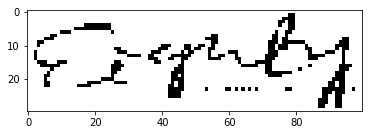

(1, 30, 100, 1)


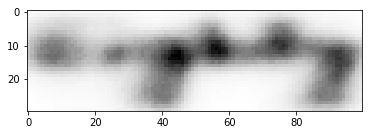

------------------------------End: test------------------------------
Cheque 083654thre2_1.tif Eighty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03239834 0.10520238 0.02669765 0.04046094 0.16815326 0.04281003
  0.00836259 0.03717497 0.10947844 0.02034338 0.03344516 0.0488576
  0.02668221 0.09316328 0.18194745 0.02127619 0.11679444 0.02595687
  0.10400873 0.06919028 0.23866248 0.02586301 0.0507474  0.01300982
  0.04004173 0.4734215  0.15834779 0.4408193  0.04173999 0.03971961
  0.14860499 0.98245156 0.14069943]]
[31]
31
['Eight']


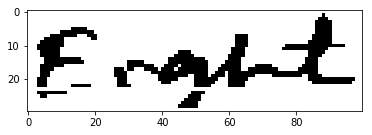

(1, 30, 100, 1)


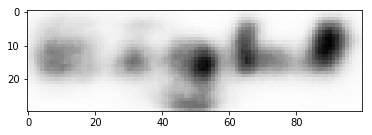

------------------------------End: test------------------------------
Cheque 083654thre2_2.tif Eight
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.28113744 0.30644253 0.16981527 0.31701568 0.06277195 0.33005086
  0.07199071 0.16715652 0.19527812 0.5330385  0.13841356 0.6101487
  0.20848256 0.0182818  0.28433537 0.08145206 0.07217479 0.02054086
  0.10829704 0.01292241 0.02730789 0.07989167 0.05691478 0.21390057
  0.02442413 0.92415017 0.27506337 0.20533639 0.15316297 0.04836055
  0.05623361 0.05151556 0.02461911]]
[25]
25
['Lakh']


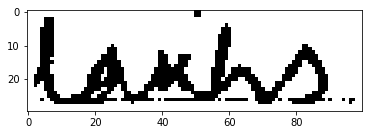

(1, 30, 100, 1)


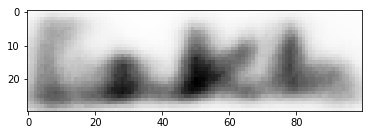

------------------------------End: test------------------------------
Cheque 083654thre2_3.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.09463835 0.1698132  0.14094672 0.06952537 0.18573962 0.00780353
  0.08817972 0.06227114 0.12483341 0.01641043 0.01214097 0.09288925
  0.02441412 0.07416506 0.87435466 0.03578235 0.03274382 0.8384926
  0.21934845 0.03984443 0.15429112 0.0434732  0.1651862  0.03097651
  0.12629089 0.07378487 0.035017   0.91256577 0.23721583 0.02410145
  0.0390601  0.11917599 0.02301082]]
[27]
27
['Four']


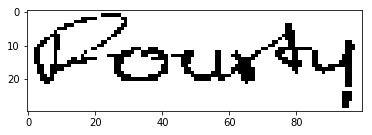

(1, 30, 100, 1)


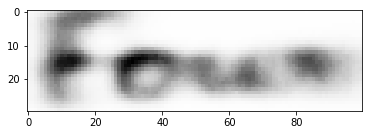

------------------------------End: test------------------------------
Cheque 083655thre2_1.tif Four
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00650591 0.07634136 0.00674132 0.0199341  0.0607673  0.10148544
  0.03837692 0.04193946 0.06115866 0.01556798 0.0571038  0.6737524
  0.05047179 0.01302015 0.02716793 0.02194959 0.02651604 0.02426582
  0.01671804 0.0226676  0.08045553 0.05213565 0.02073115 0.01221846
  0.01357604 0.07357521 0.27472264 0.8428934  0.4276814  0.04902717
  0.02300996 0.02235443 0.02285155]]
[27]
27
['Four']


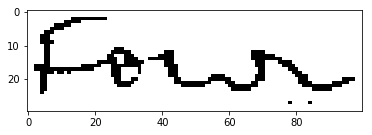

(1, 30, 100, 1)


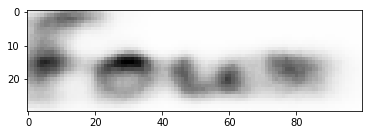

------------------------------End: test------------------------------
Cheque 083655thre2_2.tif Four
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.09140821 0.09320351 0.3140196  0.01936708 0.01313187 0.07340912
  0.08724812 0.31001353 0.07918454 0.01313419 0.32018873 0.01565625
  0.07840636 0.3520781  0.06758796 0.05088469 0.15610899 0.08247014
  0.07436784 0.02940181 0.08213445 0.04860891 0.04602634 0.05062865
  0.01307374 0.9794677  0.10726261 0.05419579 0.06767329 0.03616264
  0.27450806 0.05839639 0.03819046]]
[25]
25
['Lakh']


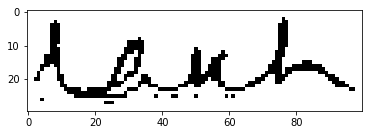

(1, 30, 100, 1)


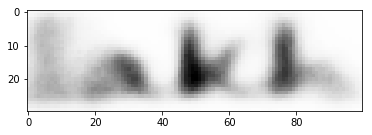

------------------------------End: test------------------------------
Cheque 083655thre2_3.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00433678 0.06106906 0.00559713 0.04024934 0.01956534 0.04969283
  0.0732496  0.05870521 0.01961293 0.14987579 0.13924187 0.0167453
  0.9913456  0.48487598 0.02506586 0.02095514 0.02448016 0.1213332
  0.15316099 0.31717947 0.01433233 0.05593918 0.0657813  0.05372049
  0.01729122 0.05685387 0.24824597 0.07645352 0.00180916 0.0084369
  0.07125605 0.1059508  0.01987736]]
[12]
12
['Twenty']


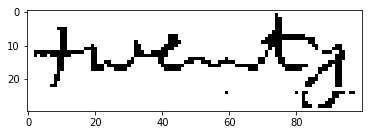

(1, 30, 100, 1)


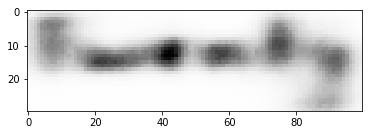

------------------------------End: test------------------------------
Cheque 083655thre2_4.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0078781  0.04647883 0.29881194 0.00907808 0.21431567 0.1976934
  0.34397224 0.14578801 0.05918643 0.17051023 0.11766604 0.01231041
  0.17791529 0.00775058 0.07858126 0.07318958 0.01801659 0.18313283
  0.0172097  0.10747071 0.10087923 0.04397439 0.11453563 0.02278225
  0.9837286  0.0587074  0.01872699 0.2302771  0.01836123 0.03359667
  0.02399051 0.02432273 0.0066194 ]]
[24]
24
['Thousand']


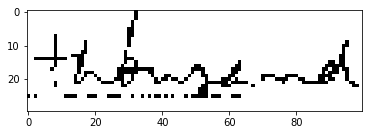

(1, 30, 100, 1)


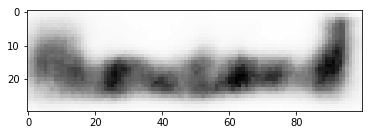

------------------------------End: test------------------------------
Cheque 083655thre2_5.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04062    0.09791585 0.00977981 0.04044466 0.00591351 0.0031933
  0.08492772 0.06610522 0.00822978 0.00251687 0.02799006 0.99185425
  0.01420009 0.17148356 0.04889429 0.10991742 0.04770468 0.07047828
  0.05328701 0.16844943 0.05517917 0.0160751  0.11762547 0.08462451
  0.05597049 0.03114317 0.12866892 0.05395608 0.08233473 0.01242846
  0.01484334 0.0027099  0.02415619]]
[11]
11
['Two']


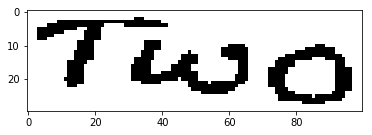

(1, 30, 100, 1)


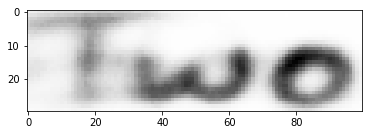

------------------------------End: test------------------------------
Cheque 083656thre2_1.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.1184556  0.0775999  0.0390225  0.11063723 0.34014416 0.10149882
  0.00558389 0.1158306  0.05986821 0.01117601 0.04766928 0.22451778
  0.08224075 0.1891046  0.03340051 0.14372145 0.04630795 0.18070404
  0.16890284 0.00564894 0.18170705 0.05769458 0.11388996 0.01718235
  0.04487494 0.99077517 0.0621299  0.09258116 0.06771556 0.0877381
  0.0338163  0.09485963 0.0643333 ]]
[25]
25
['Lakh']


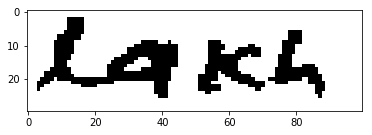

(1, 30, 100, 1)


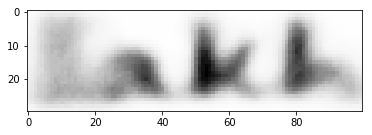

------------------------------End: test------------------------------
Cheque 083656thre2_2.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00548041 0.15083574 0.02360486 0.04444525 0.02794094 0.14299788
  0.06028475 0.20745559 0.25792873 0.11701562 0.02167102 0.11238074
  0.34651047 0.12938368 0.01410938 0.11804961 0.32069725 0.943785
  0.01949203 0.01118261 0.04259765 0.03959339 0.07757606 0.00933704
  0.00306307 0.05377612 0.06269129 0.11866096 0.02123092 0.1056963
  0.21091607 0.12730625 0.0324583 ]]
[17]
17
['Seventy']


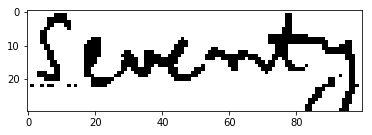

(1, 30, 100, 1)


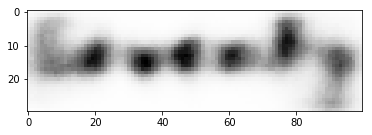

------------------------------End: test------------------------------
Cheque 083656thre2_3.tif Seventy
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02705045 0.10285011 0.10294227 0.00519085 0.7607597  0.56176496
  0.04270935 0.02831208 0.01161186 0.02876994 0.08132974 0.01321752
  0.24290277 0.06201573 0.15659344 0.07575043 0.08533631 0.16090524
  0.04640687 0.02754767 0.04053415 0.06226017 0.05831453 0.26770544
  0.9935269  0.11548296 0.22265759 0.01978505 0.05124801 0.03526814
  0.03078571 0.06533758 0.25103116]]
[24]
24
['Thousand']


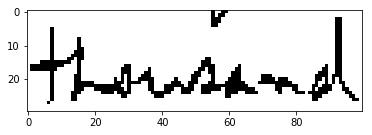

(1, 30, 100, 1)


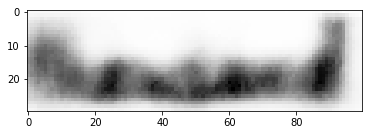

------------------------------End: test------------------------------
Cheque 083656thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.09028713 0.16006294 0.0718125  0.37433255 0.01211088 0.0121779
  0.03911207 0.00599307 0.02124511 0.00799966 0.01354224 0.16332464
  0.9807218  0.29492632 0.03614451 0.02160832 0.01367364 0.06115274
  0.09007356 0.1019444  0.6526665  0.10085778 0.05160382 0.01434801
  0.02990799 0.39869702 0.05515932 0.2527306  0.05520128 0.04120771
  0.08319554 0.05552715 0.04147363]]
[12]
12
['Twenty']


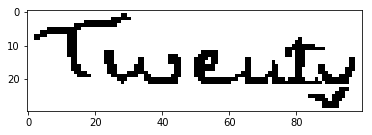

(1, 30, 100, 1)


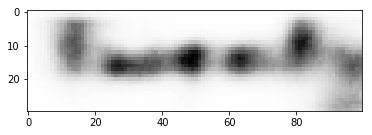

------------------------------End: test------------------------------
Cheque 083657thre2_1.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.98376554 0.02122212 0.016862   0.00236873 0.00196604 0.0438787
  0.21849085 0.09657629 0.01024144 0.04392637 0.01682388 0.03425596
  0.01157297 0.04045124 0.04187121 0.11698448 0.08140653 0.37364176
  0.00604961 0.02780085 0.07173829 0.00887711 0.2670604  0.00777137
  0.00672722 0.05524072 0.07626348 0.13946874 0.21678212 0.1825232
  0.28032985 0.07770649 0.01788658]]
[0]
0
['One']


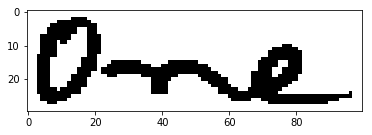

(1, 30, 100, 1)


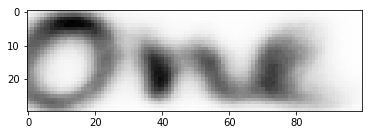

------------------------------End: test------------------------------
Cheque 083657thre2_2.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.23135157 0.59807706 0.22880454 0.03380252 0.08378383 0.06163225
  0.04644352 0.20137636 0.05126661 0.03859987 0.15734076 0.31699625
  0.01908488 0.01189603 0.28755784 0.04974806 0.03182853 0.02304463
  0.06607762 0.03636863 0.01104956 0.08222426 0.0145138  0.01992046
  0.05506511 0.9821276  0.01544556 0.536571   0.0242133  0.05888588
  0.02891438 0.02817389 0.27658257]]
[25]
25
['Lakh']


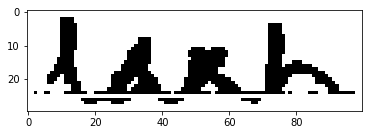

(1, 30, 100, 1)


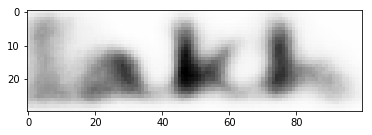

------------------------------End: test------------------------------
Cheque 083657thre2_3.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.6884638  0.11279436 0.02731527 0.02511226 0.01898056 0.01159873
  0.00852065 0.04374094 0.05453984 0.12900497 0.03466298 0.07356694
  0.10530299 0.03536202 0.26034307 0.06254718 0.07459196 0.00934796
  0.05872929 0.18927756 0.04393554 0.04682501 0.07231291 0.05911774
  0.02807276 0.04736056 0.14161119 0.3836496  0.99317825 0.09888031
  0.0215921  0.1708498  0.12957461]]
[28]
28
['Five']


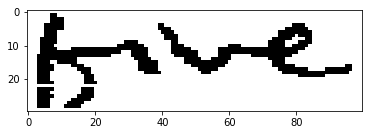

(1, 30, 100, 1)


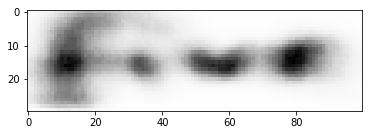

------------------------------End: test------------------------------
Cheque 083657thre2_4.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00775727 0.00585335 0.0655389  0.5885503  0.04301778 0.09769158
  0.02557243 0.23514812 0.22891901 0.02416698 0.6325251  0.09250295
  0.4212907  0.02637779 0.21691695 0.03069336 0.06061652 0.14524597
  0.0039838  0.01171462 0.07367167 0.05901992 0.23611645 0.24508935
  0.3875071  0.10459614 0.0553308  0.12832285 0.43712944 0.10223029
  0.03537629 0.02177295 0.0727081 ]]
[10]
10
['Nineteen']


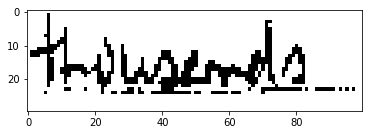

(1, 30, 100, 1)


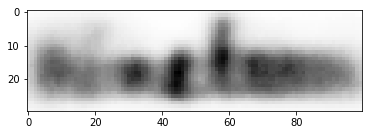

------------------------------End: test------------------------------
Cheque 083657thre2_5.tif Nineteen
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01242631 0.13514334 0.02512147 0.04200696 0.02173906 0.01562802
  0.0156949  0.11192703 0.1250484  0.13637961 0.07309908 0.01790097
  0.9811953  0.04551943 0.03269129 0.06741261 0.03749188 0.1356828
  0.07953425 0.23783098 0.06091908 0.11768185 0.04596367 0.02227749
  0.00605411 0.06450247 0.07721437 0.08395728 0.04936968 0.00889836
  0.02449665 0.02208176 0.07062485]]
[12]
12
['Twenty']


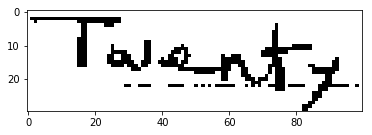

(1, 30, 100, 1)


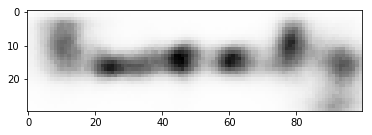

------------------------------End: test------------------------------
Cheque 083658thre2_1.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03676034 0.14750631 0.29847318 0.04162579 0.02712759 0.03784665
  0.00818405 0.02228666 0.0195745  0.02511412 0.05112887 0.99270004
  0.01849098 0.20514631 0.11544327 0.07208516 0.03669064 0.1692228
  0.18279587 0.03033482 0.10389    0.06343199 0.14539947 0.14924693
  0.01598762 0.01550344 0.07559493 0.11258233 0.2335549  0.04202452
  0.16555414 0.04422057 0.15462896]]
[11]
11
['Two']


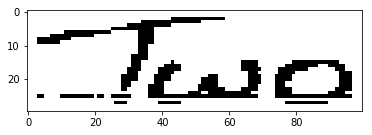

(1, 30, 100, 1)


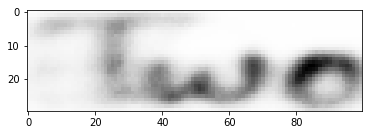

------------------------------End: test------------------------------
Cheque 083658thre2_2.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.09580122 0.10314229 0.1368185  0.2831611  0.02373021 0.01002815
  0.02944132 0.08439083 0.06786244 0.06276808 0.11130645 0.01907195
  0.01839524 0.03782817 0.19952352 0.029401   0.07365108 0.01426042
  0.00888033 0.0125357  0.08445837 0.02309823 0.16856815 0.01128321
  0.01301151 0.6297657  0.01754588 0.12765536 0.11697883 0.11590229
  0.311719   0.01388619 0.13389084]]
[25]
25
['Lakh']


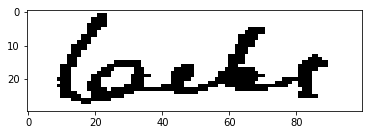

(1, 30, 100, 1)


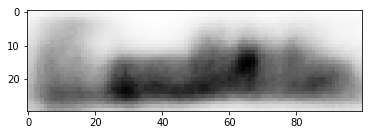

------------------------------End: test------------------------------
Cheque 083658thre2_3.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01043822 0.04976889 0.03316837 0.24492832 0.06736283 0.2276852
  0.10596329 0.22259392 0.03793568 0.08678367 0.07779817 0.01350776
  0.3707224  0.10662211 0.01745745 0.11592331 0.21018618 0.052879
  0.65562284 0.07694921 0.08091134 0.0262949  0.10479563 0.05162881
  0.99504507 0.01757328 0.2269069  0.10242546 0.07280434 0.01023194
  0.01641283 0.17811035 0.05164529]]
[24]
24
['Thousand']


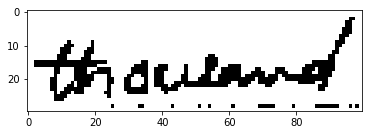

(1, 30, 100, 1)


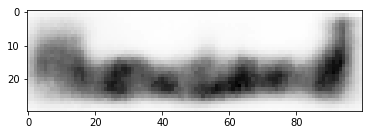

------------------------------End: test------------------------------
Cheque 083658thre2_5.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.13470656 0.03348843 0.34989703 0.25611407 0.09072914 0.12140482
  0.09532832 0.01585764 0.04554598 0.01945529 0.03246957 0.5689331
  0.01334317 0.0123478  0.16235179 0.02314833 0.07028887 0.01822766
  0.01181117 0.12900709 0.09734934 0.03685914 0.13300028 0.03137146
  0.03135016 0.5187208  0.01261176 0.2388413  0.07021155 0.03202127
  0.10704786 0.01902252 0.06009736]]
[11]
11
['Two']


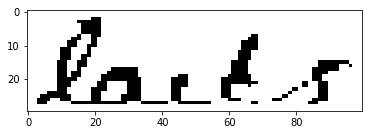

(1, 30, 100, 1)


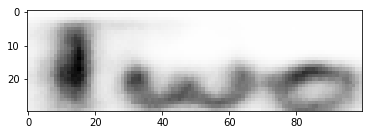

------------------------------End: test------------------------------
Cheque 083659thre2_2.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00308663 0.01709781 0.04989208 0.01514054 0.10557251 0.08111447
  0.16610266 0.02608694 0.05064435 0.02081155 0.06193524 0.32178345
  0.18661572 0.9695662  0.04498905 0.1105199  0.03128473 0.17379642
  0.03973863 0.34472144 0.02238508 0.10387482 0.37750515 0.01476586
  0.02781379 0.08342412 0.00807754 0.17683892 0.07416332 0.06057267
  0.0070627  0.05945026 0.04403892]]
[13]
13
['Thirty']


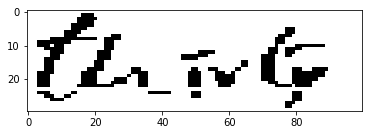

(1, 30, 100, 1)


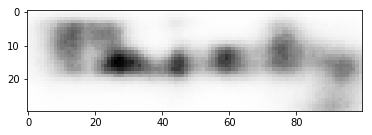

------------------------------End: test------------------------------
Cheque 083659thre2_3.tif Thirty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0280467  0.08130988 0.30505815 0.00813975 0.02274114 0.21963997
  0.03145348 0.16430354 0.03249129 0.06109081 0.01190611 0.05188736
  0.1276019  0.1396888  0.00888612 0.15723436 0.07988974 0.17025065
  0.06323233 0.03713497 0.01086324 0.00985298 0.10132425 0.12764339
  0.99160206 0.01014461 0.0100269  0.3589591  0.12983453 0.05014646
  0.11616179 0.05217426 0.16852175]]
[24]
24
['Thousand']


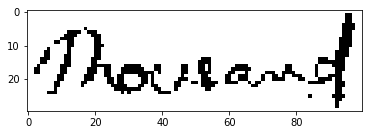

(1, 30, 100, 1)


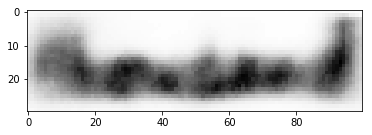

------------------------------End: test------------------------------
Cheque 083659thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0527336  0.04651278 0.01906664 0.24104403 0.09795856 0.0467298
  0.0779336  0.08558729 0.00948376 0.1044343  0.1524519  0.22760929
  0.00528958 0.03287297 0.42145437 0.56048673 0.06079251 0.02036524
  0.04659991 0.02648058 0.21099846 0.02726582 0.27515453 0.01365565
  0.11138524 0.8396064  0.02661784 0.01953371 0.0361226  0.17482942
  0.58556634 0.05959913 0.05361739]]
[25]
25
['Lakh']


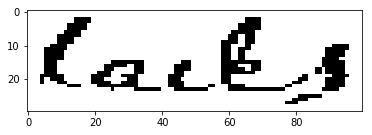

(1, 30, 100, 1)


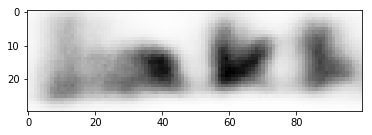

------------------------------End: test------------------------------
Cheque 083660thre2_2.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01388855 0.8131506  0.22142899 0.02630914 0.0100136  0.09080093
  0.16596772 0.12709478 0.00616999 0.04687053 0.00394296 0.10265327
  0.02306311 0.01800065 0.06074608 0.05983318 0.01150823 0.02302176
  0.0528228  0.07199624 0.04710576 0.05707539 0.04944522 0.01549421
  0.01523102 0.9895742  0.15407714 0.01645011 0.11291168 0.04342873
  0.01348428 0.03554745 0.21992938]]
[25]
25
['Lakh']


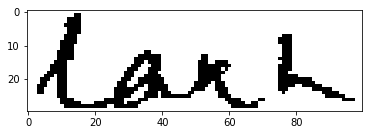

(1, 30, 100, 1)


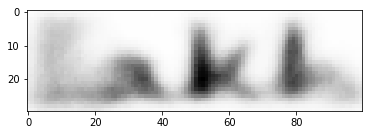

------------------------------End: test------------------------------
Cheque 100828thre2_2.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03467321 0.03239175 0.09365629 0.13531561 0.0114451  0.12827231
  0.03427457 0.05289309 0.10081331 0.1061003  0.00758757 0.08003595
  0.98172975 0.919022   0.02675412 0.16767009 0.03375867 0.11423632
  0.0903244  0.01690456 0.03581852 0.05439882 0.02860042 0.04072596
  0.00991207 0.02714617 0.07184263 0.15087502 0.1256866  0.02318927
  0.10054972 0.04080457 0.14110474]]
[12]
12
['Twenty']


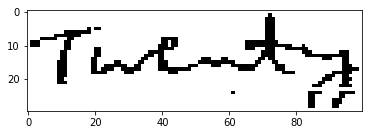

(1, 30, 100, 1)


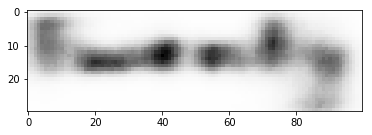

------------------------------End: test------------------------------
Cheque 100828thre2_3.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.12021013 0.03360966 0.1744419  0.01387335 0.177228   0.05459191
  0.00762725 0.03021269 0.0040981  0.01574776 0.08797873 0.02383045
  0.09745269 0.11771419 0.10405071 0.0924006  0.03625107 0.03616169
  0.06277893 0.03128006 0.05301646 0.07328638 0.98421943 0.01904249
  0.05072372 0.00931077 0.16780023 0.1083267  0.38680717 0.02080145
  0.04444496 0.00341592 0.00871818]]
[22]
22
['Three']


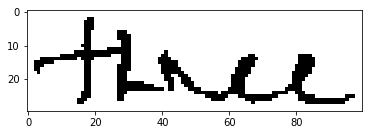

(1, 30, 100, 1)


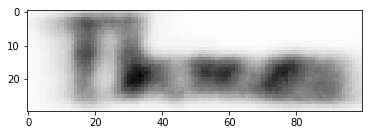

------------------------------End: test------------------------------
Cheque 100828thre2_4.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06866245 0.12679651 0.3449291  0.08122267 0.30278006 0.15994042
  0.0438931  0.0633688  0.0799517  0.036052   0.2635799  0.07055549
  0.01890487 0.08352149 0.02436618 0.05025925 0.04898188 0.03544199
  0.02144608 0.06498919 0.0349744  0.02737515 0.15373565 0.25119314
  0.9944886  0.06609623 0.05867765 0.1090792  0.06999628 0.00273534
  0.08406913 0.06172784 0.2249865 ]]
[24]
24
['Thousand']


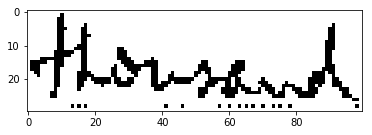

(1, 30, 100, 1)


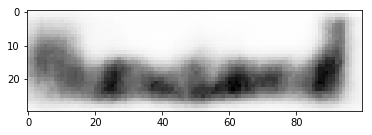

------------------------------End: test------------------------------
Cheque 100828thre2_5.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06969129 0.00691452 0.02420533 0.07824121 0.17014462 0.04076875
  0.22544907 0.24717732 0.08302587 0.05097638 0.05356079 0.09613194
  0.00808772 0.10023917 0.1077233  0.9961643  0.04930701 0.02161159
  0.01957403 0.08193748 0.24129766 0.05231141 0.05886934 0.03431156
  0.01873747 0.03485886 0.07669141 0.06550094 0.02334702 0.00943053
  0.107645   0.2651343  0.06500142]]
[15]
15
['Fifty']


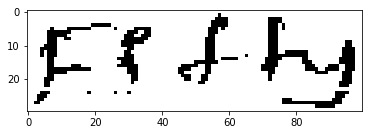

(1, 30, 100, 1)


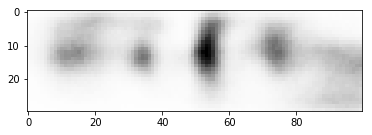

------------------------------End: test------------------------------
Cheque 100829thre2_1.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.9792525  0.09442692 0.00936256 0.01166113 0.07689361 0.01860966
  0.00794305 0.01585501 0.03429822 0.02576503 0.01554239 0.03785938
  0.05727645 0.02018437 0.06086033 0.18739963 0.01572332 0.00749472
  0.07048744 0.07406836 0.04654261 0.325606   0.04297851 0.0092162
  0.00370063 0.18986437 0.06143275 0.12545364 0.33997458 0.08674378
  0.11935955 0.15213694 0.03108569]]
[0]
0
['One']


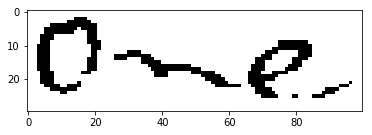

(1, 30, 100, 1)


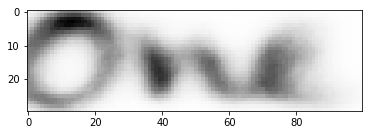

------------------------------End: test------------------------------
Cheque 100829thre2_2.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.15696438 0.08763763 0.1784396  0.03626511 0.03298199 0.14382103
  0.037894   0.1166306  0.0319882  0.01666092 0.23870523 0.0468666
  0.01836959 0.07478699 0.0562846  0.0473891  0.23821698 0.09052746
  0.05672315 0.02903806 0.0973278  0.03628916 0.02977727 0.01168442
  0.05967253 0.9832129  0.10681331 0.10477483 0.0072622  0.07720324
  0.02565847 0.04341333 0.14813106]]
[25]
25
['Lakh']


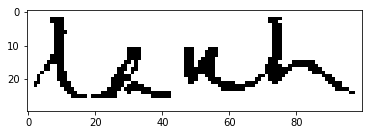

(1, 30, 100, 1)


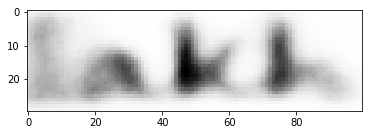

------------------------------End: test------------------------------
Cheque 100829thre2_3.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02462511 0.06282897 0.00847036 0.08868479 0.11359946 0.1160519
  0.07678212 0.17647256 0.03273221 0.2494116  0.00828602 0.05681844
  0.54738283 0.40760016 0.04375501 0.17493296 0.0288215  0.15445568
  0.99210906 0.07400988 0.00270395 0.02811737 0.14470965 0.04893512
  0.00558923 0.030865   0.1664907  0.03006952 0.05852407 0.04210279
  0.02677573 0.05285325 0.03586908]]
[18]
18
['Eighty']


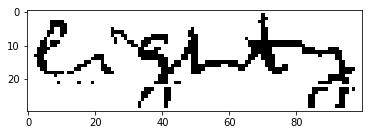

(1, 30, 100, 1)


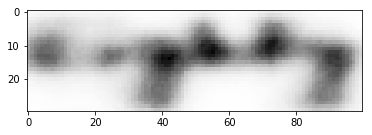

------------------------------End: test------------------------------
Cheque 100829thre2_4.tif Eighty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02550492 0.02995597 0.06216172 0.08408875 0.09449118 0.69431275
  0.07310414 0.05838279 0.04334646 0.05405205 0.16111767 0.8863156
  0.0120571  0.06030012 0.1873723  0.06652702 0.02500524 0.103206
  0.14664055 0.03633804 0.01369917 0.01945511 0.34635195 0.04637804
  0.02481751 0.04099691 0.03366559 0.19902395 0.0312396  0.2098172
  0.02976539 0.14479424 0.03431815]]
[11]
11
['Two']


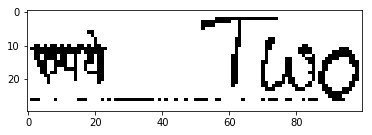

(1, 30, 100, 1)


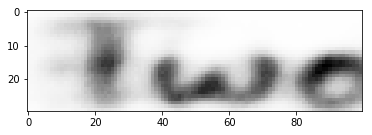

------------------------------End: test------------------------------
Cheque 100830thre2_1.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.17687015 0.05742366 0.0840992  0.05832484 0.14877509 0.01567721
  0.00793923 0.00604207 0.0221993  0.0227493  0.04554663 0.07769819
  0.03255973 0.29568455 0.08278278 0.15155557 0.04074807 0.0248439
  0.08051709 0.18819672 0.12024377 0.01455556 0.13356176 0.04431367
  0.10513095 0.1292689  0.94216144 0.13542497 0.10871305 0.32533675
  0.34627235 0.24649887 0.21381702]]
[26]
26
['Crore']


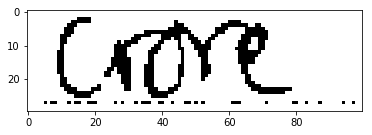

(1, 30, 100, 1)


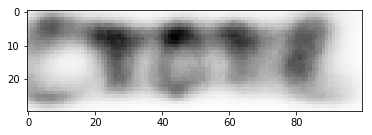

------------------------------End: test------------------------------
Cheque 100830thre2_2.tif Crore
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.212571   0.18032536 0.07333228 0.0530339  0.09150025 0.02367494
  0.02552957 0.04371032 0.00826923 0.00823555 0.01036702 0.04046019
  0.01869243 0.06272485 0.03117172 0.07876135 0.04881123 0.0691448
  0.03517084 0.0677896  0.03200925 0.06665735 0.03218358 0.0583331
  0.03076026 0.05341285 0.01472783 0.91065985 0.30811736 0.0239929
  0.038856   0.00897674 0.09284417]]
[27]
27
['Four']


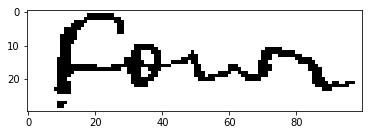

(1, 30, 100, 1)


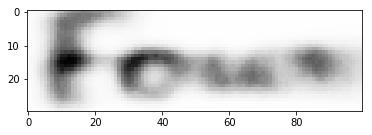

------------------------------End: test------------------------------
Cheque 100830thre2_3.tif Four
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.08407699 0.05699347 0.08025067 0.01401717 0.025573   0.02756391
  0.08125369 0.04529243 0.04940675 0.03168233 0.0111973  0.20325786
  0.03079055 0.06257269 0.03638026 0.11203331 0.33199254 0.09394164
  0.12351847 0.03821306 0.08969444 0.10121701 0.00979722 0.02932279
  0.00231473 0.9876923  0.0094524  0.06887256 0.03774043 0.01546726
  0.13496254 0.04729144 0.24014284]]
[25]
25
['Lakh']


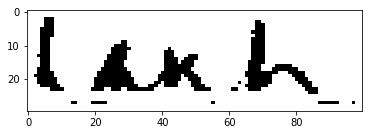

(1, 30, 100, 1)


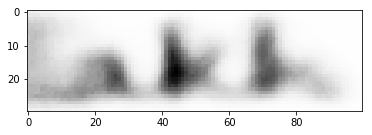

------------------------------End: test------------------------------
Cheque 100830thre2_4.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04468782 0.03772742 0.06111129 0.8912609  0.01002677 0.01036235
  0.01273337 0.04989662 0.03770517 0.0130548  0.01877859 0.04138933
  0.9828312  0.04294739 0.02385695 0.01486927 0.02249511 0.03266167
  0.23452848 0.08307543 0.06480722 0.0719678  0.11490361 0.06106537
  0.43646637 0.10511325 0.26112837 0.15470946 0.12009203 0.06712893
  0.08776554 0.0936484  0.0199577 ]]
[12]
12
['Twenty']


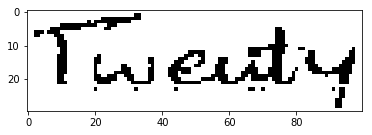

(1, 30, 100, 1)


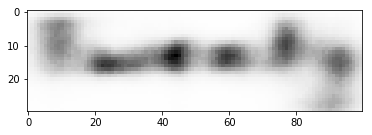

------------------------------End: test------------------------------
Cheque 100831thre2_1.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00876331 0.8353889  0.01834006 0.05023405 0.02042954 0.06361502
  0.05401271 0.02105959 0.02606328 0.02755041 0.02900594 0.96477497
  0.21123998 0.08511475 0.03703151 0.03009564 0.06511729 0.01085648
  0.01846943 0.06437924 0.04141769 0.00642801 0.0261819  0.12827069
  0.00534349 0.12640402 0.03302271 0.3763067  0.05222482 0.01223431
  0.00565294 0.03124244 0.0391327 ]]
[11]
11
['Two']


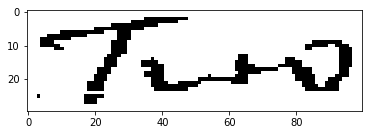

(1, 30, 100, 1)


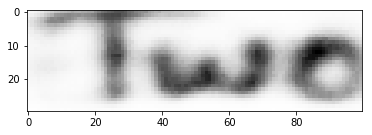

------------------------------End: test------------------------------
Cheque 100831thre2_2.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.20316572 0.02270966 0.06676564 0.00926062 0.01652736 0.05179747
  0.04802979 0.08031319 0.07182018 0.02728147 0.03880479 0.37387076
  0.03210829 0.21093369 0.02940334 0.07336479 0.18900163 0.11322201
  0.06770992 0.05622664 0.04478166 0.0567266  0.24400549 0.01294394
  0.10844409 0.98896515 0.06342839 0.06009482 0.05942164 0.09156007
  0.0132553  0.00459691 0.47354937]]
[25]
25
['Lakh']


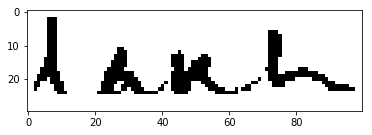

(1, 30, 100, 1)


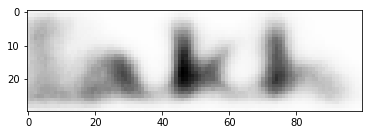

------------------------------End: test------------------------------
Cheque 100831thre2_3.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.10570155 0.01769763 0.05763515 0.00283104 0.12514006 0.065448
  0.01449952 0.10690709 0.03193028 0.06534592 0.01695267 0.1267739
  0.21428706 0.9940563  0.06119496 0.1468904  0.14353341 0.12336819
  0.5746959  0.02400574 0.17906515 0.04695737 0.00703236 0.05601325
  0.19003655 0.0105003  0.04174626 0.03278875 0.0535315  0.05639147
  0.12881562 0.22502325 0.03326112]]
[13]
13
['Thirty']


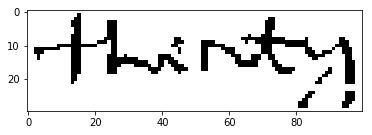

(1, 30, 100, 1)


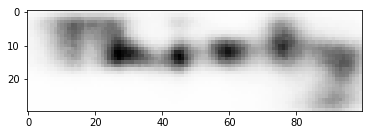

------------------------------End: test------------------------------
Cheque 100831thre2_4.tif Thirty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.21851288 0.07929286 0.01060069 0.01592575 0.02079787 0.28914964
  0.02126191 0.04981576 0.02696745 0.15015475 0.03294002 0.09963024
  0.03330676 0.07243757 0.06265941 0.13210514 0.20238893 0.02841691
  0.15204819 0.09629138 0.11453091 0.1597756  0.02166257 0.04877309
  0.07932784 0.04421419 0.08661926 0.24942654 0.8142456  0.04800289
  0.42516494 0.02643951 0.05731456]]
[28]
28
['Five']


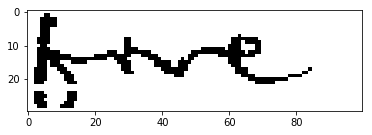

(1, 30, 100, 1)


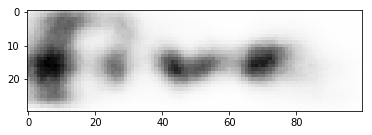

------------------------------End: test------------------------------
Cheque 100831thre2_5.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0373889  0.00549781 0.7804244  0.07201789 0.6844983  0.05394967
  0.0272067  0.23641896 0.05710448 0.02217009 0.414813   0.05950332
  0.68112457 0.02038732 0.17649494 0.04736041 0.06029614 0.05409233
  0.03127002 0.11121301 0.06427913 0.02584393 0.03334401 0.03347779
  0.99349433 0.02344459 0.20928752 0.01476716 0.01820991 0.00512404
  0.07452773 0.04578678 0.0200473 ]]
[24]
24
['Thousand']


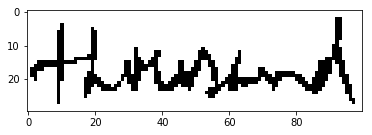

(1, 30, 100, 1)


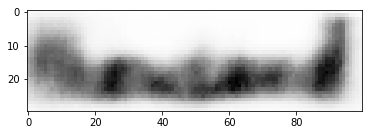

------------------------------End: test------------------------------
Cheque 100831thre2_6.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03669529 0.32453382 0.14217262 0.26466894 0.19304818 0.02929713
  0.32255074 0.06291002 0.08165661 0.05667669 0.25508165 0.14244439
  0.11198761 0.02835151 0.00535266 0.0208669  0.06746393 0.90238005
  0.6167524  0.07371    0.01247989 0.01519364 0.19465989 0.10507611
  0.20007305 0.23293866 0.07977706 0.22577295 0.17704643 0.08741302
  0.7021411  0.01638151 0.03840853]]
[17]
17
['Seventy']


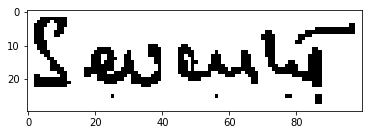

(1, 30, 100, 1)


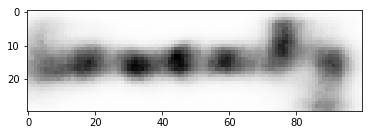

------------------------------End: test------------------------------
Cheque 100832thre2_1.tif Seventy
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01348999 0.12374708 0.01439004 0.02998213 0.02853672 0.01932055
  0.03566644 0.03462218 0.02744419 0.04966921 0.0478388  0.02975906
  0.01992325 0.06828586 0.05394414 0.0162763  0.00724027 0.01356223
  0.02585225 0.00343013 0.00289788 0.04471961 0.06103384 0.02211385
  0.00328637 0.05552882 0.03137266 0.9661573  0.05692451 0.02106686
  0.03747805 0.01805792 0.04599464]]
[27]
27
['Four']


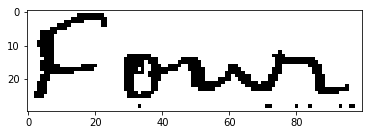

(1, 30, 100, 1)


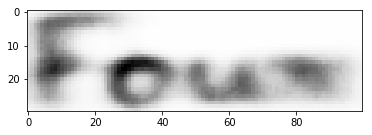

------------------------------End: test------------------------------
Cheque 100832thre2_2.tif Four
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[6.7299604e-02 4.9220171e-02 3.3112638e-02 2.5576904e-02 4.6318941e-04
  1.4063114e-01 1.3389795e-01 8.5904308e-02 7.5392745e-02 1.1015447e-02
  1.7909857e-02 2.2748446e-01 2.4796933e-01 1.1417011e-02 3.7108004e-02
  1.5017752e-01 9.9937439e-02 1.8531696e-01 1.0512223e-01 1.4036037e-02
  5.1518589e-02 3.0060537e-02 3.9200064e-02 3.7193518e-02 6.1509311e-02
  9.8021686e-01 2.7227947e-01 1.2069897e-01 2.1312537e-02 1.0579039e-02
  9.4116904e-02 2.7958902e-02 4.4536069e-01]]
[25]
25
['Lakh']


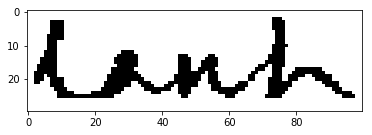

(1, 30, 100, 1)


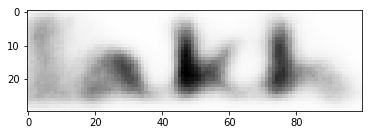

------------------------------End: test------------------------------
Cheque 100832thre2_3.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06780725 0.08933822 0.00803769 0.22854804 0.1293967  0.03852339
  0.19899362 0.5711302  0.14026348 0.03921584 0.13187174 0.03416298
  0.04560576 0.05870098 0.03989735 0.5785942  0.28829873 0.13027528
  0.9907438  0.28170416 0.00551671 0.12846096 0.15462156 0.1948805
  0.02598651 0.02301387 0.40174413 0.17642303 0.09016836 0.1581883
  0.08669972 0.03510219 0.06490252]]
[18]
18
['Eighty']


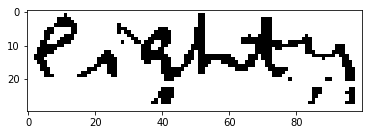

(1, 30, 100, 1)


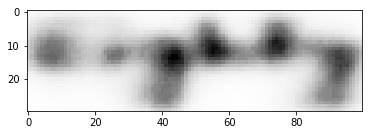

------------------------------End: test------------------------------
Cheque 100832thre2_4.tif Eighty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03916556 0.01695891 0.08476352 0.0221555  0.06853027 0.19626704
  0.24998407 0.05720135 0.05376156 0.10066805 0.07932064 0.08606178
  0.91191244 0.38422742 0.1845104  0.09139302 0.01467767 0.03794169
  0.18032913 0.11607168 0.01263271 0.0734368  0.00218788 0.01393686
  0.98901224 0.02353197 0.06645297 0.02858597 0.12315929 0.07229044
  0.04319017 0.10237541 0.10110812]]
[24]
24
['Thousand']


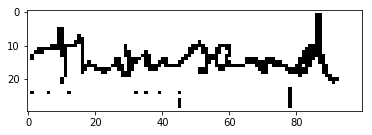

(1, 30, 100, 1)


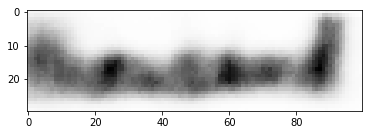

------------------------------End: test------------------------------
Cheque 100832thre2_5.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07402204 0.12445559 0.04930206 0.09550853 0.03687561 0.00411433
  0.01634534 0.0136045  0.00376814 0.00979404 0.02762027 0.05926379
  0.03693517 0.03163305 0.07638757 0.11769311 0.01112221 0.02485607
  0.16036142 0.00738836 0.01146315 0.13750058 0.0056968  0.04476883
  0.07390422 0.05247679 0.12681207 0.159086   0.0622993  0.72561145
  0.95864487 0.01605651 0.01082239]]
[30]
30
['Seven']


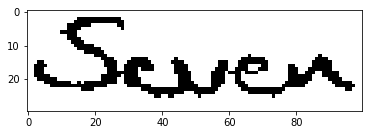

(1, 30, 100, 1)


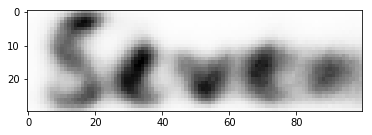

------------------------------End: test------------------------------
Cheque 100833thre2_1.tif Seven
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06470469 0.10433715 0.07909328 0.06775898 0.19213341 0.0058075
  0.01034519 0.12941946 0.08390303 0.01323497 0.11749005 0.06290622
  0.00914895 0.00157213 0.47752172 0.05604556 0.03662068 0.06963521
  0.00162237 0.01849096 0.03801263 0.01747153 0.11498393 0.02807189
  0.00814518 0.7918817  0.18381462 0.28372806 0.17198305 0.04883483
  0.02634944 0.07245471 0.09005737]]
[25]
25
['Lakh']


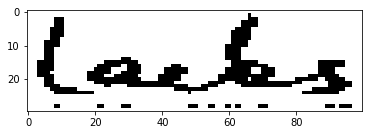

(1, 30, 100, 1)


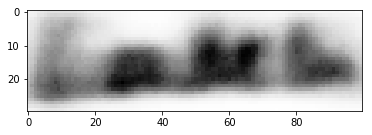

------------------------------End: test------------------------------
Cheque 100833thre2_2.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00506467 0.1501649  0.04816667 0.9953871  0.2510458  0.21060209
  0.00798922 0.12074321 0.17795376 0.2349433  0.2761445  0.81470364
  0.09496897 0.02794395 0.42590463 0.1100479  0.03142472 0.03958132
  0.08249398 0.04117759 0.0543105  0.09041167 0.02212649 0.01418155
  0.04496973 0.19503447 0.29652277 0.1541145  0.01263213 0.06431636
  0.01234592 0.08504416 0.01873144]]
[3]
3
['Twelve']


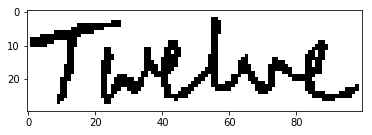

(1, 30, 100, 1)


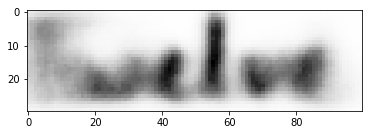

------------------------------End: test------------------------------
Cheque 100833thre2_3.tif Twelve
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04892602 0.05029006 0.04096146 0.00827537 0.09934328 0.07846671
  0.07075956 0.03283512 0.02112039 0.03022219 0.05345391 0.02955076
  0.17177914 0.06984536 0.00803878 0.08917752 0.11223766 0.04421319
  0.14423925 0.04860448 0.02458036 0.03651031 0.00988631 0.133514
  0.9953209  0.14598468 0.15932766 0.02233859 0.0196708  0.08260508
  0.05521132 0.14659719 0.0870821 ]]
[24]
24
['Thousand']


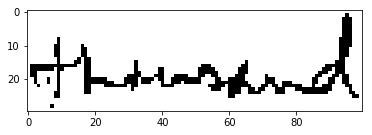

(1, 30, 100, 1)


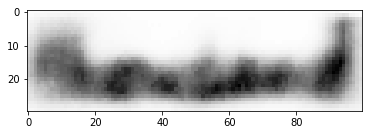

------------------------------End: test------------------------------
Cheque 100833thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03044966 0.01512378 0.13521606 0.06542636 0.13407952 0.06770843
  0.10849689 0.11752816 0.03155835 0.07688501 0.12141722 0.0100254
  0.06520908 0.99661356 0.03061196 0.11195552 0.04865243 0.0674375
  0.04919672 0.01841257 0.00900888 0.01693713 0.04434378 0.01410651
  0.02438672 0.08721522 0.06502871 0.1212462  0.00648737 0.0155152
  0.04402896 0.03877022 0.11617856]]
[13]
13
['Thirty']


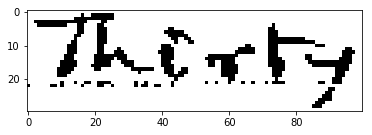

(1, 30, 100, 1)


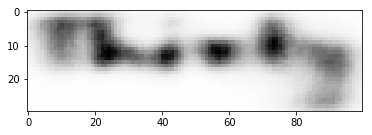

------------------------------End: test------------------------------
Cheque 100834thre2_1.tif Thirty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06653508 0.0585026  0.24757329 0.02819882 0.09130218 0.01428403
  0.00510599 0.00219779 0.01816329 0.11997817 0.00348682 0.0884646
  0.01958355 0.11128115 0.07507952 0.01890698 0.14743948 0.01581936
  0.3426791  0.01404577 0.11977158 0.1339004  0.9894555  0.09386973
  0.00283202 0.04863971 0.02559689 0.26634786 0.06534161 0.02357631
  0.06205406 0.07137184 0.04787697]]
[22]
22
['Three']


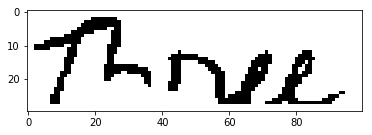

(1, 30, 100, 1)


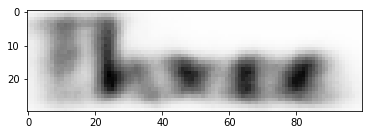

------------------------------End: test------------------------------
Cheque 100834thre2_2.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.11712615 0.5719111  0.27238935 0.01510008 0.02908985 0.20016094
  0.09885643 0.09453264 0.00798375 0.04180623 0.0473196  0.09029031
  0.05299185 0.12345077 0.02415863 0.10290882 0.23248318 0.05183784
  0.1395388  0.06533439 0.12833275 0.07241555 0.03604797 0.07025331
  0.00469819 0.9851973  0.00628167 0.02175357 0.17716473 0.01697002
  0.13978127 0.02055963 0.42129916]]
[25]
25
['Lakh']


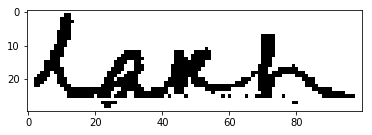

(1, 30, 100, 1)


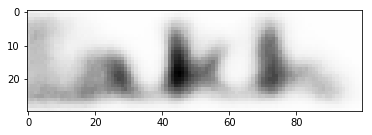

------------------------------End: test------------------------------
Cheque 100834thre2_3.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03623008 0.17426397 0.02562134 0.03678418 0.00937722 0.05626407
  0.03385145 0.13463211 0.11162513 0.01453994 0.01705814 0.09591173
  0.0483003  0.06734468 0.01249145 0.09415556 0.77565306 0.08340276
  0.9928366  0.02702153 0.21023558 0.19190869 0.04729867 0.01570893
  0.06301207 0.0705876  0.6163801  0.07133371 0.2868836  0.1967174
  0.16517572 0.04647563 0.10944576]]
[18]
18
['Eighty']


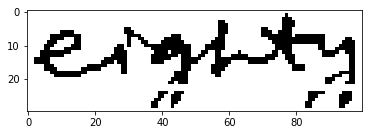

(1, 30, 100, 1)


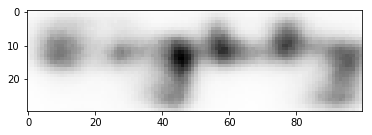

------------------------------End: test------------------------------
Cheque 100834thre2_4.tif Eighty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00127287 0.0569881  0.03759688 0.05038151 0.04297237 0.02148423
  0.04793529 0.04801442 0.01205245 0.08569383 0.11358624 0.01499654
  0.11631425 0.05105336 0.03541324 0.09706042 0.0268706  0.06081248
  0.03801569 0.3427171  0.05197007 0.05264762 0.03659967 0.03221631
  0.9900328  0.06921352 0.00663808 0.06618921 0.04824882 0.02535644
  0.12614611 0.03671821 0.03648351]]
[24]
24
['Thousand']


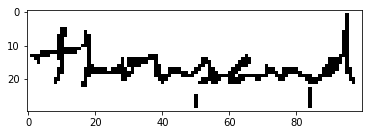

(1, 30, 100, 1)


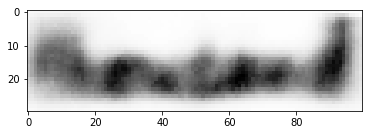

------------------------------End: test------------------------------
Cheque 100834thre2_5.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03700611 0.00888971 0.00338322 0.02350669 0.15338755 0.11195516
  0.30909756 0.34624517 0.2639043  0.1042678  0.02722691 0.01854038
  0.22203483 0.61999124 0.38235041 0.02277034 0.5555826  0.6901177
  0.1904183  0.38461393 0.08375112 0.15475589 0.03380721 0.13962892
  0.02784789 0.03222348 0.03165144 0.07765475 0.10007303 0.11010338
  0.00357904 0.08478047 0.00702255]]
[17]
17
['Seventy']


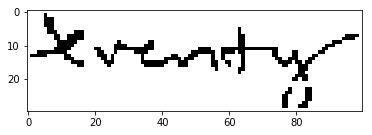

(1, 30, 100, 1)


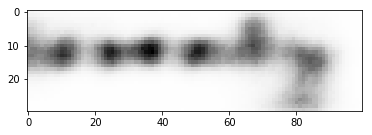

------------------------------End: test------------------------------
Cheque 100835thre2_1.tif Seventy
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.70865554 0.11739619 0.02444197 0.01674428 0.27586377 0.10639253
  0.01972152 0.02228218 0.00839127 0.01659433 0.07618149 0.06291639
  0.03586304 0.01948605 0.11621036 0.09984339 0.07696828 0.06294867
  0.09441578 0.03555727 0.07382234 0.11288896 0.97661346 0.27337924
  0.02172694 0.09493419 0.08651031 0.06539027 0.17102021 0.02197753
  0.04881341 0.0205946  0.08380975]]
[22]
22
['Three']


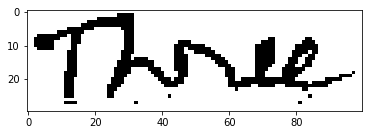

(1, 30, 100, 1)


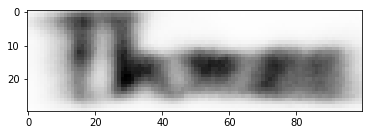

------------------------------End: test------------------------------
Cheque 100835thre2_2.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.10812608 0.03717275 0.2808823  0.91592795 0.16921227 0.03715458
  0.01907543 0.06399839 0.6047242  0.01652149 0.02078699 0.6329167
  0.08856186 0.10353418 0.05493096 0.07052104 0.05983267 0.00957227
  0.03508663 0.006008   0.04548608 0.04167332 0.01019481 0.01016189
  0.07462171 0.8486962  0.09222373 0.159945   0.03883815 0.01531905
  0.07623864 0.01986129 0.6433003 ]]
[3]
3
['Twelve']


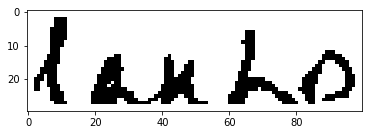

(1, 30, 100, 1)


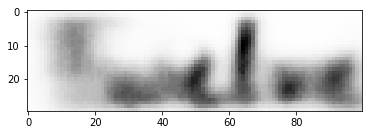

------------------------------End: test------------------------------
Cheque 100835thre2_3.tif Twelve
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04313634 0.04447607 0.14325708 0.10716937 0.03736392 0.31135768
  0.05709373 0.06918862 0.05531665 0.03339674 0.06621474 0.03548145
  0.56598437 0.0517673  0.05465122 0.03596189 0.98669547 0.06563129
  0.01417525 0.05265155 0.01475615 0.03402129 0.09040753 0.08432003
  0.02316319 0.14756893 0.20735884 0.02233906 0.01121655 0.07653309
  0.03387929 0.03304631 0.05128687]]
[16]
16
['Sixty']


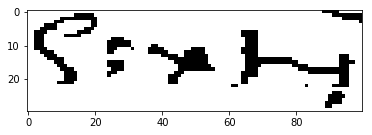

(1, 30, 100, 1)


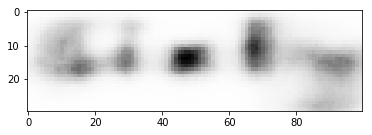

------------------------------End: test------------------------------
Cheque 120611thre2_1.tif Sixty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03111589 0.02322303 0.02369385 0.12295751 0.00630382 0.05324768
  0.01783957 0.011112   0.00370717 0.00555221 0.02257502 0.03141299
  0.98757184 0.23588476 0.00992791 0.02085123 0.05081008 0.3791459
  0.1000431  0.04014534 0.04062799 0.11330526 0.05531534 0.05875226
  0.06110832 0.179549   0.04409703 0.05371709 0.01031806 0.0865423
  0.13836041 0.09459984 0.00800094]]
[12]
12
['Twenty']


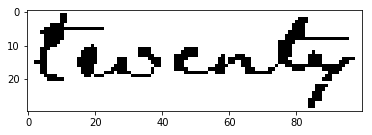

(1, 30, 100, 1)


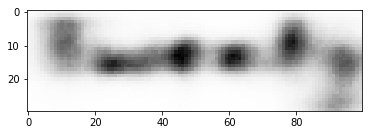

------------------------------End: test------------------------------
Cheque 120611thre2_3.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02585559 0.06069055 0.04552119 0.05391861 0.12511976 0.08897595
  0.00779864 0.2281103  0.11021446 0.02127743 0.19669533 0.02075194
  0.17732097 0.20315115 0.13221706 0.20985398 0.15318249 0.08422212
  0.25352028 0.0179291  0.14014421 0.02468334 0.26634702 0.07758798
  0.99395293 0.02690063 0.04745236 0.00907939 0.01285893 0.01661836
  0.04841168 0.02954067 0.01968348]]
[24]
24
['Thousand']


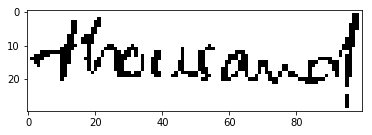

(1, 30, 100, 1)


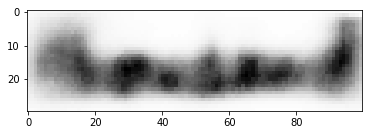

------------------------------End: test------------------------------
Cheque 120611thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.1257855  0.4454467  0.23417819 0.10019395 0.04738852 0.04757992
  0.08872186 0.10537887 0.65228444 0.01434655 0.04452213 0.01279235
  0.32856557 0.03780533 0.04698432 0.19841677 0.21829657 0.6326234
  0.8178884  0.021469   0.02906276 0.06781672 0.23733662 0.077061
  0.5649292  0.06036973 0.02447243 0.16874154 0.03645429 0.04312788
  0.02011566 0.28889292 0.00929793]]
[18]
18
['Eighty']


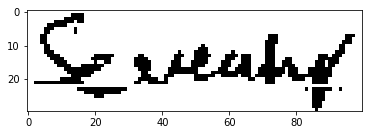

(1, 30, 100, 1)


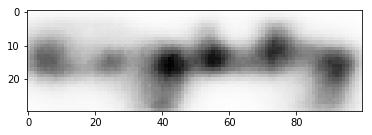

------------------------------End: test------------------------------
Cheque 120612thre2_1.tif Eighty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01310822 0.10172602 0.35905278 0.00497716 0.07009964 0.02029083
  0.00863963 0.18739593 0.03196372 0.01025592 0.0513933  0.72151816
  0.00534242 0.19549969 0.13621156 0.0577046  0.02506821 0.04140108
  0.07164518 0.00683909 0.01396183 0.20359074 0.9893681  0.09574898
  0.05785346 0.0355294  0.05082922 0.12949638 0.2980623  0.28099203
  0.10428358 0.07566731 0.0983965 ]]
[22]
22
['Three']


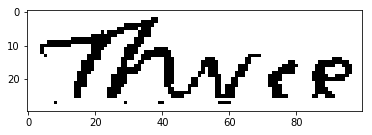

(1, 30, 100, 1)


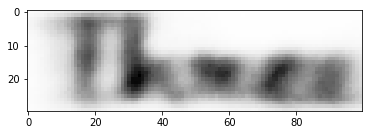

------------------------------End: test------------------------------
Cheque 120612thre2_2.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04932004 0.01542654 0.22977968 0.20325065 0.09415637 0.05930771
  0.04318023 0.06908508 0.11518607 0.01123452 0.04761453 0.14528032
  0.01351422 0.00780552 0.26472777 0.04728846 0.19601646 0.03316523
  0.07575907 0.02368479 0.05286358 0.00647304 0.12725574 0.04419835
  0.01352068 0.77399063 0.11440276 0.2987061  0.15981118 0.03025874
  0.11039683 0.04626122 0.00518996]]
[25]
25
['Lakh']


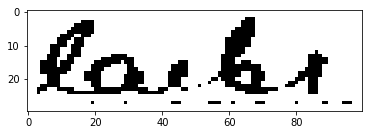

(1, 30, 100, 1)


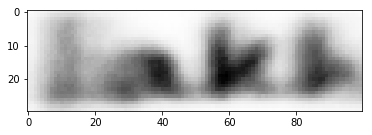

------------------------------End: test------------------------------
Cheque 120612thre2_3.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.26576418 0.03309996 0.0274474  0.02231353 0.01240587 0.01490867
  0.01154998 0.17461519 0.02084026 0.0213833  0.06322241 0.0806917
  0.08939603 0.07041287 0.02714431 0.22186516 0.05281748 0.02720362
  0.12453166 0.01562743 0.02626727 0.26597813 0.8663479  0.0113428
  0.0219423  0.03380454 0.04367652 0.1005213  0.03475938 0.6394237
  0.06537295 0.04054467 0.26694047]]
[22]
22
['Three']


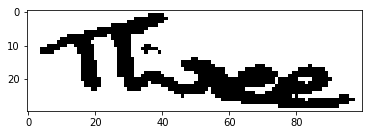

(1, 30, 100, 1)


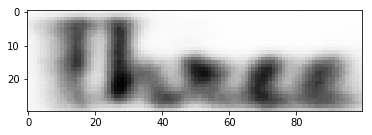

------------------------------End: test------------------------------
Cheque 120613thre2_1.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01564275 0.00980741 0.01297398 0.02045002 0.05311083 0.02832775
  0.04159259 0.02680948 0.01788226 0.0310429  0.1966119  0.8339598
  0.10151105 0.05287579 0.09510374 0.01435969 0.03007391 0.01004106
  0.00953486 0.00586264 0.04499957 0.17133677 0.10618449 0.19824073
  0.05365238 0.04618862 0.02115582 0.04601762 0.5570375  0.3227116
  0.02851193 0.06941688 0.07190213]]
[11]
11
['Two']


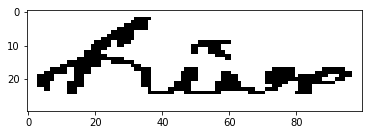

(1, 30, 100, 1)


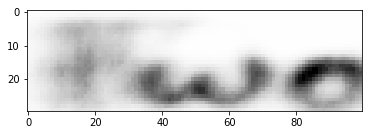

------------------------------End: test------------------------------
Cheque 120613thre2_3.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0745509  0.02361959 0.05081945 0.01259824 0.03905343 0.19821109
  0.0578136  0.15087706 0.03024695 0.01473766 0.467556   0.02825364
  0.7819324  0.2694897  0.04358783 0.03579087 0.05504215 0.07068522
  0.19839996 0.01973445 0.02066913 0.02661229 0.01625635 0.01360656
  0.99101776 0.05163043 0.03422305 0.2291875  0.06606197 0.16384774
  0.1014166  0.15404637 0.03799256]]
[24]
24
['Thousand']


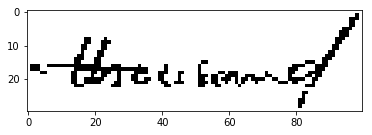

(1, 30, 100, 1)


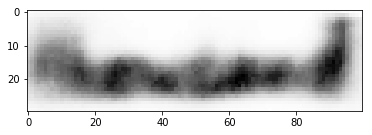

------------------------------End: test------------------------------
Cheque 120613thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.09247786 0.45592773 0.06119796 0.08557932 0.05834653 0.05167171
  0.04683314 0.21750797 0.31110552 0.1755909  0.04399031 0.20242189
  0.00503557 0.0085057  0.01901336 0.01101984 0.8306372  0.07389937
  0.06317279 0.04871172 0.01979721 0.10020249 0.0615264  0.04559539
  0.0821705  0.31355184 0.08037121 0.4321613  0.0150172  0.23590715
  0.06427347 0.01586425 0.0089543 ]]
[16]
16
['Sixty']


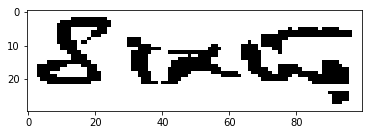

(1, 30, 100, 1)


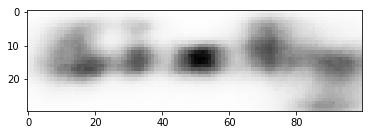

------------------------------End: test------------------------------
Cheque 120614thre2_2.tif Sixty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.49342936 0.08571694 0.03344755 0.01598102 0.03181525 0.00174287
  0.49226674 0.01830992 0.03186779 0.01900313 0.10053193 0.0164319
  0.2681069  0.11375406 0.06118858 0.03402659 0.09821238 0.01760427
  0.09088747 0.09596686 0.13022481 0.0158642  0.04639282 0.06472998
  0.05750342 0.0635749  0.05375742 0.11996021 0.22252406 0.03336361
  0.05173546 0.08024527 0.9896853 ]]
[32]
32
['Nine']


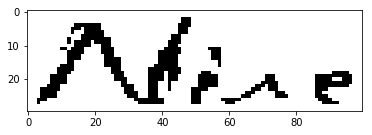

(1, 30, 100, 1)


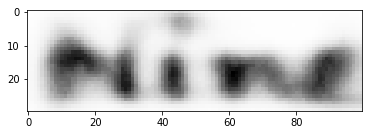

------------------------------End: test------------------------------
Cheque 120614thre2_3.tif Nine
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.4254616  0.11850601 0.01004016 0.02346047 0.11022709 0.02520737
  0.20736349 0.03773493 0.02802614 0.08712517 0.02942389 0.07369431
  0.05306965 0.03893277 0.18520148 0.03028997 0.08748464 0.01772914
  0.03645984 0.00549847 0.10215984 0.06626179 0.04211226 0.01305231
  0.02966888 0.639238   0.06156259 0.0860391  0.03567354 0.06342633
  0.1640965  0.01047894 0.29122218]]
[25]
25
['Lakh']


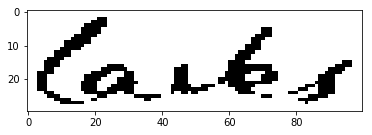

(1, 30, 100, 1)


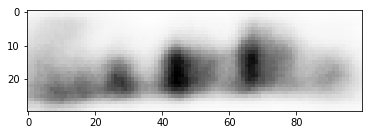

------------------------------End: test------------------------------
Cheque 120614thre2_4.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05518178 0.04978731 0.03023447 0.05030586 0.01142566 0.11279193
  0.01406381 0.00666982 0.03498688 0.05715757 0.40896907 0.125698
  0.04603739 0.91608274 0.29172674 0.09473319 0.5785095  0.05497879
  0.00299562 0.12742513 0.11584824 0.04166611 0.03522826 0.12181823
  0.10087631 0.0219558  0.09441075 0.07713591 0.11198367 0.09511454
  0.02505025 0.14776342 0.16162035]]
[13]
13
['Thirty']


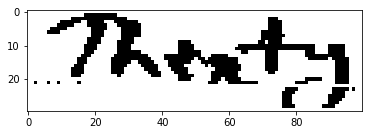

(1, 30, 100, 1)


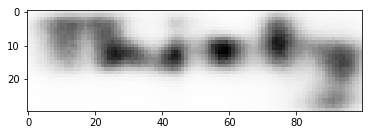

------------------------------End: test------------------------------
Cheque 120615thre2_1.tif Thirty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.9297827  0.07295526 0.08671791 0.03233969 0.0461362  0.07210718
  0.03005713 0.11733228 0.02631788 0.03463928 0.01290477 0.06557193
  0.12784664 0.01257986 0.07834285 0.03464969 0.05265952 0.07679143
  0.00722996 0.03553818 0.08573769 0.18426482 0.7817077  0.07665941
  0.01008091 0.08135497 0.0731307  0.07311575 0.01489537 0.03397888
  0.08608014 0.08677837 0.20116384]]
[0]
0
['One']


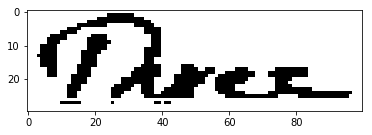

(1, 30, 100, 1)


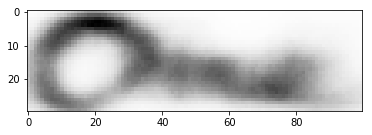

------------------------------End: test------------------------------
Cheque 120615thre2_2.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.4885663  0.10617557 0.03166169 0.01412654 0.05276669 0.22171064
  0.01610742 0.02782185 0.08262514 0.02915397 0.00719139 0.26254627
  0.13013127 0.00720563 0.02122825 0.29553413 0.0293842  0.0586433
  0.3280146  0.09889454 0.05915084 0.062255   0.00609614 0.01565062
  0.02260237 0.706849   0.05600596 0.14670633 0.10953604 0.14380659
  0.275823   0.02333117 0.27382484]]
[25]
25
['Lakh']


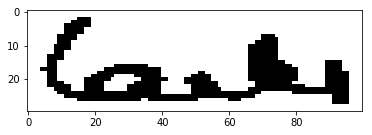

(1, 30, 100, 1)


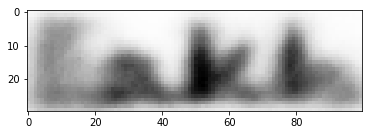

------------------------------End: test------------------------------
Cheque 120615thre2_3.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.08499061 0.08009089 0.0200547  0.20117839 0.04153119 0.02498678
  0.19447447 0.02177959 0.02569658 0.0085053  0.11255473 0.06666797
  0.06618835 0.06095086 0.6225284  0.28216934 0.6894008  0.17753066
  0.17871413 0.538788   0.09090339 0.45834556 0.04592011 0.03127172
  0.01811134 0.13634819 0.05960412 0.56823856 0.0635974  0.17416714
  0.22043253 0.24884437 0.23094203]]
[16]
16
['Sixty']


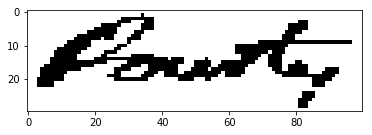

(1, 30, 100, 1)


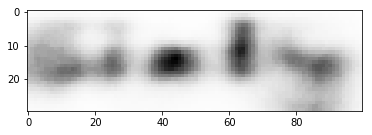

------------------------------End: test------------------------------
Cheque 120615thre2_4.tif Sixty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.10581843 0.09760781 0.37654155 0.01292725 0.03729609 0.05264609
  0.09010784 0.14853033 0.07141822 0.02532425 0.04027321 0.04982043
  0.7662157  0.1845467  0.10312256 0.22642174 0.19478196 0.2652674
  0.18780738 0.0064054  0.16397133 0.04977249 0.2931743  0.02676039
  0.9633222  0.26063457 0.06730409 0.6202844  0.10092737 0.13329431
  0.01013493 0.06179081 0.08626533]]
[24]
24
['Thousand']


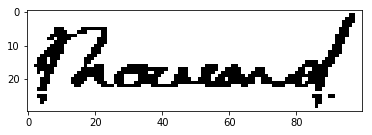

(1, 30, 100, 1)


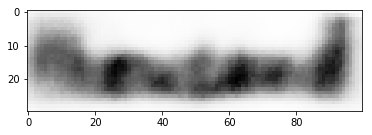

------------------------------End: test------------------------------
Cheque 120615thre2_5.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.08919518 0.05071131 0.10418297 0.1110801  0.08621772 0.12639858
  0.02323951 0.15004411 0.04957446 0.03775548 0.02236226 0.08669125
  0.02041933 0.02049079 0.16364262 0.9885014  0.01661466 0.08219139
  0.3631388  0.76563656 0.06003056 0.09723112 0.07634486 0.03429012
  0.02032952 0.01440983 0.1116453  0.11852248 0.17509925 0.0134829
  0.06285601 0.05715058 0.07795666]]
[15]
15
['Fifty']


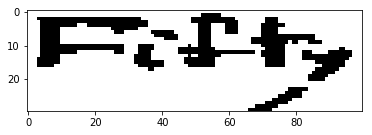

(1, 30, 100, 1)


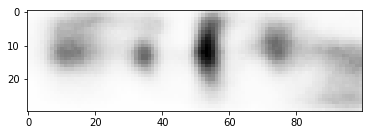

------------------------------End: test------------------------------
Cheque 120616thre2_2.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06694049 0.10762123 0.08767665 0.01815311 0.0057022  0.01228611
  0.24427873 0.01811379 0.01967037 0.27044183 0.35399482 0.4544192
  0.11468291 0.09687395 0.04717822 0.13552268 0.15242113 0.14778939
  0.20116888 0.03415207 0.14170107 0.00805603 0.03581313 0.0160768
  0.01270788 0.28146133 0.08991713 0.07922919 0.9817009  0.15852171
  0.03898451 0.02683194 0.11890759]]
[28]
28
['Five']


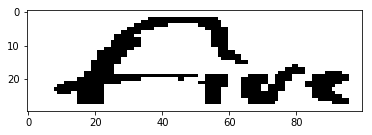

(1, 30, 100, 1)


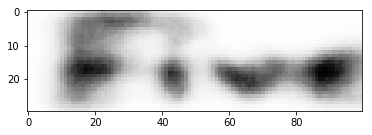

------------------------------End: test------------------------------
Cheque 120616thre2_3.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.19802298 0.15195392 0.04040042 0.02882635 0.04024141 0.06267218
  0.09886853 0.08964797 0.03844336 0.02219222 0.02555636 0.03221459
  0.08254093 0.03116475 0.18184108 0.06363513 0.04944568 0.01004956
  0.01620645 0.00790399 0.00299044 0.1146526  0.05014775 0.00551791
  0.01600128 0.63267016 0.01390574 0.05672348 0.02389603 0.4331959
  0.05270669 0.02183466 0.20933342]]
[25]
25
['Lakh']


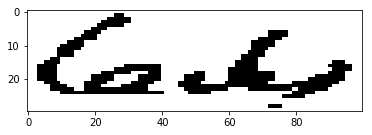

(1, 30, 100, 1)


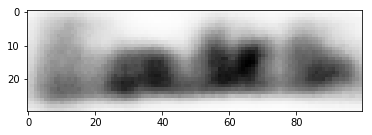

------------------------------End: test------------------------------
Cheque 120616thre2_4.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.99284923 0.03034211 0.00651176 0.05986357 0.0015919  0.0253446
  0.12390942 0.07962091 0.01630355 0.01445241 0.03386988 0.21688326
  0.00248686 0.04208232 0.08735675 0.02861313 0.06389362 0.06180496
  0.02683484 0.10307799 0.03744515 0.0173756  0.02514231 0.0817263
  0.01756354 0.0449859  0.0548903  0.02947459 0.19593355 0.11954454
  0.1179156  0.04703661 0.05147845]]
[0]
0
['One']


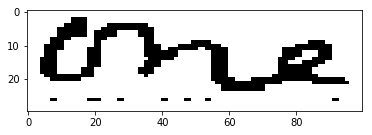

(1, 30, 100, 1)


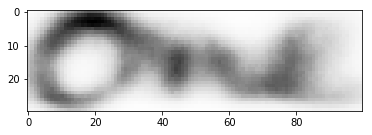

------------------------------End: test------------------------------
Cheque 120617thre2_1.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.42749754 0.08948236 0.02678006 0.08410366 0.0238429  0.05258907
  0.14433748 0.034821   0.25022176 0.0717875  0.07969851 0.787832
  0.21804143 0.03410805 0.17625496 0.04728659 0.03820675 0.15062772
  0.06747852 0.15076996 0.04297663 0.02065783 0.02303652 0.04327081
  0.0529828  0.45357555 0.04360349 0.23259841 0.12344142 0.11070206
  0.72486323 0.13234323 0.19288936]]
[11]
11
['Two']


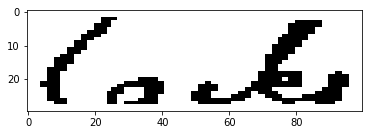

(1, 30, 100, 1)


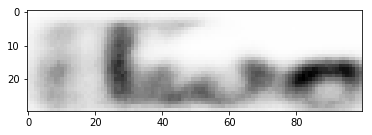

------------------------------End: test------------------------------
Cheque 120617thre2_3.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00946659 0.02114601 0.13897581 0.02724282 0.10458901 0.13875738
  0.08234299 0.01610912 0.04178068 0.00976901 0.3544679  0.09898897
  0.46538028 0.5367992  0.1737544  0.09851565 0.06025343 0.29378828
  0.08617969 0.90583265 0.39429954 0.01497339 0.07868332 0.07745218
  0.03449646 0.03978905 0.02331465 0.07413848 0.3187126  0.19904299
  0.06490579 0.28653356 0.08555003]]
[19]
19
['Ninety']


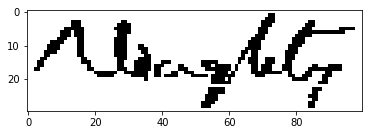

(1, 30, 100, 1)


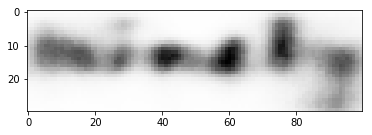

------------------------------End: test------------------------------
Cheque 120617thre2_4.tif Ninety
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07211861 0.01629563 0.02752846 0.0299331  0.02643219 0.05836232
  0.23276493 0.11887825 0.04830833 0.06261153 0.15909754 0.04487754
  0.47597218 0.652924   0.03887209 0.204515   0.07980596 0.17349778
  0.01899686 0.01488676 0.04559286 0.01808999 0.16025175 0.02860683
  0.9849976  0.06469993 0.01519661 0.30697823 0.07771038 0.04716495
  0.11166643 0.04007855 0.08385608]]
[24]
24
['Thousand']


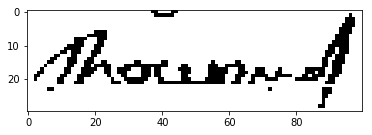

(1, 30, 100, 1)


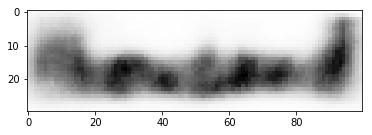

------------------------------End: test------------------------------
Cheque 120617thre2_5.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.1585567  0.04794664 0.05581088 0.01001546 0.06504941 0.268823
  0.34099424 0.13619643 0.07629167 0.03767518 0.02258874 0.5356522
  0.08891833 0.01182016 0.12561932 0.0343693  0.07355051 0.01260283
  0.01269094 0.04261658 0.10036652 0.27333575 0.06959964 0.08566616
  0.05924572 0.5703377  0.03141036 0.22223395 0.32358828 0.1266853
  0.1577457  0.03748695 0.36275545]]
[25]
25
['Lakh']


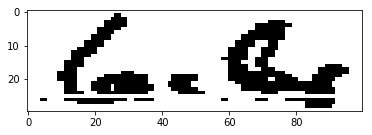

(1, 30, 100, 1)


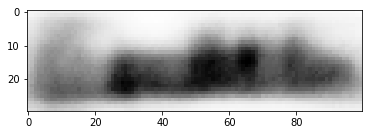

------------------------------End: test------------------------------
Cheque 120618thre2_2.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.15802193 0.05310126 0.0149743  0.12367416 0.06180304 0.17302875
  0.36145052 0.3000505  0.02128691 0.02701131 0.4368436  0.12305527
  0.3243039  0.11651386 0.09802828 0.58483505 0.6352961  0.03501471
  0.09017001 0.10062354 0.04513802 0.38443783 0.01178453 0.03264692
  0.2174068  0.16775921 0.02652548 0.22754703 0.0459517  0.547825
  0.5839507  0.20949669 0.07875757]]
[16]
16
['Sixty']


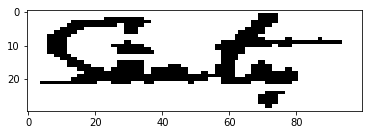

(1, 30, 100, 1)


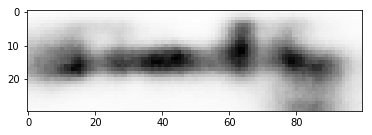

------------------------------End: test------------------------------
Cheque 120618thre2_3.tif Sixty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02079161 0.07197235 0.0470367  0.01730108 0.02460467 0.27551904
  0.12282892 0.11785019 0.03952789 0.01115495 0.02981448 0.05859131
  0.7106234  0.02765676 0.14346074 0.30824175 0.10379238 0.14101145
  0.05742601 0.01333919 0.1781955  0.05784911 0.34101844 0.03730725
  0.99373335 0.07268736 0.0736956  0.19937305 0.01134699 0.05191004
  0.06281801 0.03826804 0.0089081 ]]
[24]
24
['Thousand']


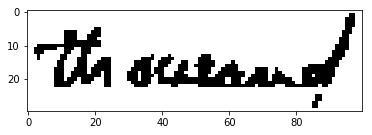

(1, 30, 100, 1)


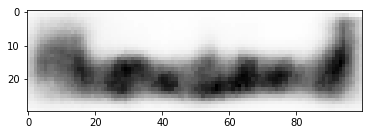

------------------------------End: test------------------------------
Cheque 120618thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04740151 0.06023016 0.08961373 0.0478676  0.05629025 0.00253318
  0.05410211 0.03232644 0.03245099 0.39502585 0.10397416 0.01934528
  0.08627406 0.9586552  0.3409435  0.09220395 0.02280939 0.03125312
  0.01364328 0.30250767 0.18214256 0.1576216  0.918613   0.01174984
  0.17663908 0.04861909 0.05080641 0.01558757 0.06660277 0.03939398
  0.18959852 0.14128    0.13591115]]
[13]
13
['Thirty']


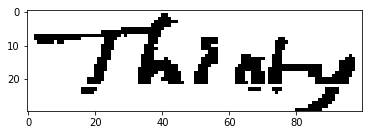

(1, 30, 100, 1)


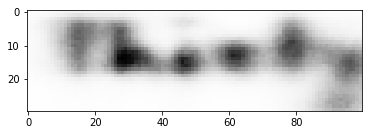

------------------------------End: test------------------------------
Cheque 120619thre2_2.tif Thirty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.12954974 0.19623427 0.6577152  0.12834558 0.07665317 0.02474453
  0.0904891  0.11019572 0.01318639 0.26343387 0.09567358 0.0124537
  0.01719913 0.36133492 0.02555561 0.0775811  0.02972162 0.05573155
  0.0236382  0.01342054 0.06943644 0.10073319 0.48687127 0.05101914
  0.01211222 0.03258534 0.02381716 0.1307586  0.03177835 0.02032832
  0.11481477 0.03832385 0.09947541]]
[2]
2
['Eleven']


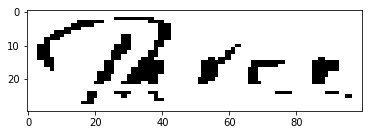

(1, 30, 100, 1)


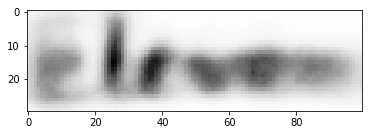

------------------------------End: test------------------------------
Cheque 120619thre2_3.tif Eleven
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.18686643 0.01146327 0.07756209 0.0859706  0.20930819 0.02371443
  0.01836528 0.05753915 0.0524871  0.02339269 0.06053865 0.09280468
  0.15571621 0.05359251 0.23597986 0.7889697  0.12743402 0.07668096
  0.09694605 0.08629433 0.11603446 0.13022575 0.04608231 0.24575286
  0.04920438 0.33446324 0.02592114 0.04942221 0.03254994 0.0493125
  0.084763   0.06035439 0.03324417]]
[15]
15
['Fifty']


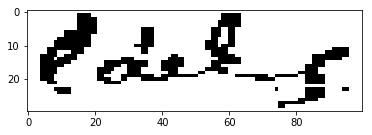

(1, 30, 100, 1)


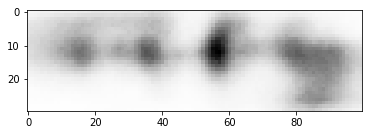

------------------------------End: test------------------------------
Cheque 120619thre2_4.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.9928539  0.1339923  0.03352838 0.29462472 0.0640161  0.2366017
  0.1642296  0.06570502 0.04323336 0.2658011  0.01487764 0.10375827
  0.08574634 0.10806781 0.30124718 0.25153434 0.10121368 0.2566527
  0.01199902 0.19031663 0.09955229 0.20485575 0.19077899 0.06322823
  0.0437111  0.22881445 0.12468453 0.03035444 0.18577452 0.7961341
  0.11100247 0.05318587 0.41330555]]
[0]
0
['One']


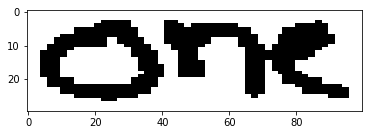

(1, 30, 100, 1)


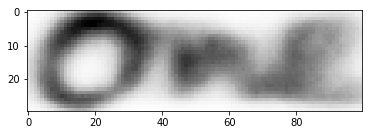

------------------------------End: test------------------------------
Cheque 120620thre2_1.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.25650367 0.07651905 0.43108216 0.21955721 0.02661843 0.702691
  0.0988529  0.1850599  0.0854914  0.33922157 0.07678824 0.44491813
  0.02986159 0.09137947 0.1445031  0.045742   0.36828306 0.18567526
  0.3360503  0.31201956 0.24100119 0.19408002 0.05206281 0.07735654
  0.01782905 0.1224098  0.9789176  0.5247392  0.07828408 0.34368756
  0.09087053 0.10673612 0.6170666 ]]
[26]
26
['Crore']


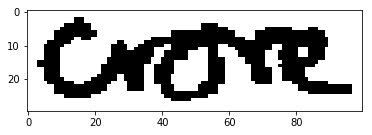

(1, 30, 100, 1)


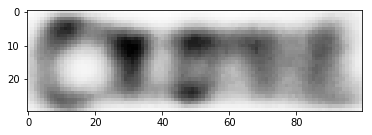

------------------------------End: test------------------------------
Cheque 120620thre2_2.tif Crore
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.44966355 0.37995103 0.11385611 0.08789247 0.01544474 0.05826791
  0.4446576  0.0996775  0.0448466  0.13963017 0.21310365 0.2839554
  0.13013832 0.02870128 0.14243488 0.21630628 0.5186159  0.17263222
  0.06716386 0.09877142 0.18981539 0.26930955 0.21903081 0.02583282
  0.05095585 0.1404485  0.52520514 0.11328875 0.2583683  0.06185188
  0.02458765 0.9841629  0.3143091 ]]
[31]
31
['Eight']


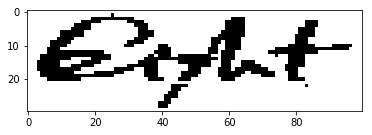

(1, 30, 100, 1)


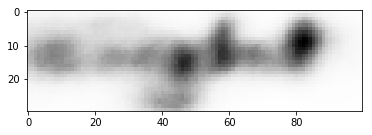

------------------------------End: test------------------------------
Cheque 120620thre2_3.tif Eight
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.1191522  0.2202486  0.10852604 0.19492528 0.0126078  0.04013157
  0.10059644 0.05996333 0.11790716 0.00990732 0.14024279 0.18247631
  0.08154406 0.06882969 0.15126993 0.14082721 0.13202515 0.28366184
  0.00774765 0.09396478 0.01681715 0.05628811 0.04242484 0.11643884
  0.05733756 0.81693566 0.14566545 0.11396918 0.26621318 0.15451701
  0.19887707 0.07083727 0.2502289 ]]
[25]
25
['Lakh']


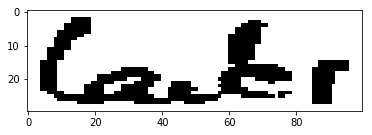

(1, 30, 100, 1)


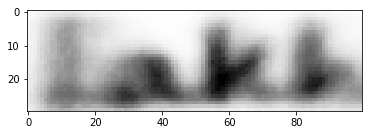

------------------------------End: test------------------------------
Cheque 120620thre2_4.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05062058 0.04409389 0.12676263 0.0590892  0.1440036  0.01636871
  0.02599677 0.08499983 0.03708484 0.11445349 0.01671342 0.08557232
  0.00309743 0.01579419 0.04898243 0.08096717 0.0138624  0.07565598
  0.09156711 0.06242364 0.1593818  0.03338344 0.11734698 0.07241405
  0.03632662 0.1157859  0.10658912 0.08053988 0.9900351  0.07189718
  0.0615138  0.00924553 0.14388439]]
[28]
28
['Five']


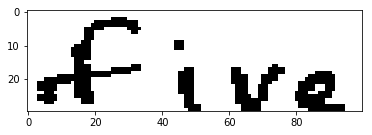

(1, 30, 100, 1)


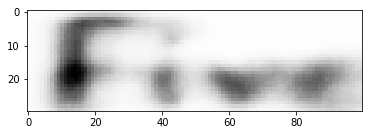

------------------------------End: test------------------------------
Cheque 309061thre2_0.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0587571  0.04716159 0.1265417  0.17512691 0.01164874 0.06882635
  0.03099354 0.00472534 0.01767353 0.0071871  0.05477364 0.02814214
  0.11418583 0.03247031 0.1262044  0.16981201 0.1448631  0.04247988
  0.02336222 0.13977616 0.04274968 0.15472245 0.5705796  0.04775843
  0.04170622 0.08993893 0.24574162 0.6571972  0.02681412 0.19476788
  0.02748236 0.01775746 0.22643691]]
[27]
27
['Four']


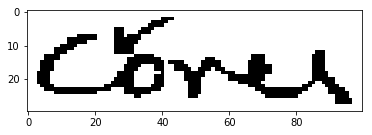

(1, 30, 100, 1)


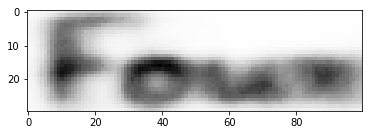

------------------------------End: test------------------------------
Cheque 309061thre2_1.tif Four
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.34665656 0.98105276 0.03743239 0.12984452 0.02515247 0.14923117
  0.00931226 0.01992518 0.0113937  0.23316553 0.0334796  0.12476929
  0.09416114 0.0703582  0.01906323 0.014227   0.0746683  0.12649228
  0.07277787 0.08171804 0.17437077 0.01495146 0.03474768 0.02177575
  0.12748674 0.07710931 0.10854656 0.02790656 0.08981694 0.02539419
  0.02207278 0.04533176 0.02465282]]
[1]
1
['Ten']


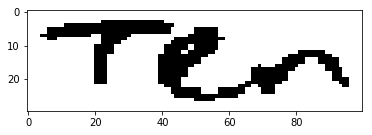

(1, 30, 100, 1)


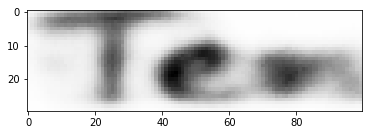

------------------------------End: test------------------------------
Cheque 309061thre2_2.tif Ten
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05915931 0.03091826 0.01858311 0.24167475 0.00527344 0.00444872
  0.01403191 0.1299474  0.05255347 0.15918936 0.04321511 0.01418987
  0.40299562 0.11191569 0.11937919 0.2854507  0.03532434 0.06144362
  0.0093559  0.20230457 0.10769455 0.01525935 0.06384681 0.01784811
  0.01052134 0.42849937 0.05981772 0.04391126 0.07701489 0.06144211
  0.24044348 0.05541845 0.55681664]]
[32]
32
['Nine']


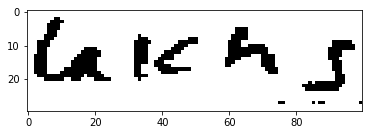

(1, 30, 100, 1)


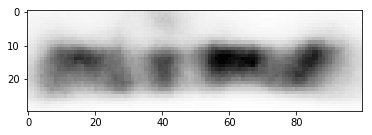

------------------------------End: test------------------------------
Cheque 309061thre2_3.tif Nine
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.14922696 0.020973   0.05367056 0.03739266 0.03011086 0.00625992
  0.02209705 0.0342175  0.0066533  0.00244313 0.02308751 0.04102739
  0.00844668 0.02967529 0.03210864 0.08538038 0.03440882 0.07553028
  0.06800684 0.00858947 0.00803258 0.1112451  0.9943706  0.09193136
  0.00881593 0.03599364 0.04558218 0.00968176 0.23228215 0.01022162
  0.10027938 0.02193545 0.12544127]]
[22]
22
['Three']


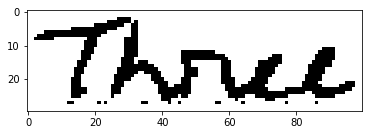

(1, 30, 100, 1)


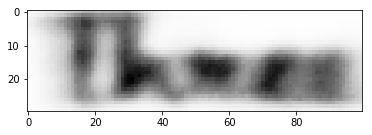

------------------------------End: test------------------------------
Cheque 309062thre2_0.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01926181 0.0742623  0.02288641 0.02188366 0.01548232 0.0412026
  0.02830902 0.24731988 0.18695022 0.02674504 0.0426727  0.19533259
  0.31580675 0.01842156 0.1303342  0.10096905 0.0301723  0.05917145
  0.12859455 0.05597899 0.01964334 0.0637973  0.04847921 0.02720928
  0.272018   0.98967093 0.14851555 0.04416976 0.21545435 0.02313174
  0.01369399 0.0135497  0.14923759]]
[25]
25
['Lakh']


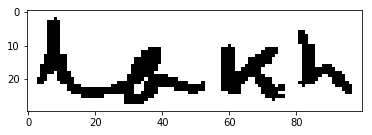

(1, 30, 100, 1)


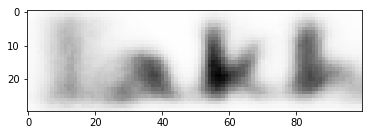

------------------------------End: test------------------------------
Cheque 309062thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02685397 0.39928922 0.02996994 0.31509683 0.03347436 0.14244315
  0.06499709 0.11467782 0.1689234  0.15670338 0.04338584 0.14063084
  0.95859325 0.6959669  0.2585953  0.03830496 0.09052887 0.06526926
  0.02270432 0.00306826 0.07835774 0.1263939  0.49640536 0.10215667
  0.01426023 0.03862669 0.04368866 0.06033431 0.36680433 0.27363682
  0.07275197 0.02919144 0.03859736]]
[12]
12
['Twenty']


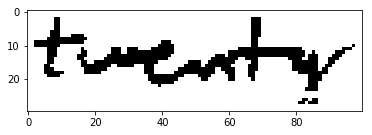

(1, 30, 100, 1)


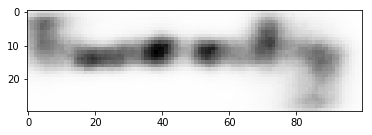

------------------------------End: test------------------------------
Cheque 309062thre2_2.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.1161892  0.02921848 0.02390967 0.0743462  0.21857785 0.06849296
  0.3453211  0.23044907 0.3297971  0.04411353 0.04552262 0.10066256
  0.06057679 0.04728565 0.14356455 0.1132303  0.12197904 0.06456279
  0.00427877 0.0419543  0.08168468 0.2110984  0.21925358 0.15275407
  0.09067345 0.08910547 0.03926314 0.06857326 0.32650375 0.05650185
  0.02560486 0.37665692 0.99588966]]
[32]
32
['Nine']


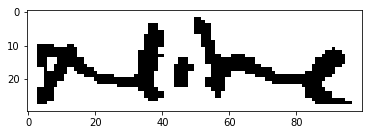

(1, 30, 100, 1)


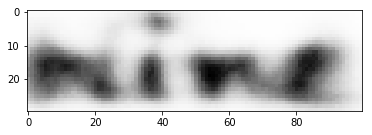

------------------------------End: test------------------------------
Cheque 309062thre2_3.tif Nine
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03609982 0.26451463 0.10559761 0.04333183 0.04883096 0.25982237
  0.2588443  0.18815458 0.09764241 0.0389393  0.12683214 0.17380783
  0.26647955 0.02979001 0.00176455 0.18897396 0.14156327 0.12262498
  0.06643336 0.0568205  0.04588594 0.07285132 0.01816953 0.1167827
  0.99320173 0.03594235 0.06395389 0.09127469 0.16582066 0.04404738
  0.18225417 0.20109956 0.47437933]]
[24]
24
['Thousand']


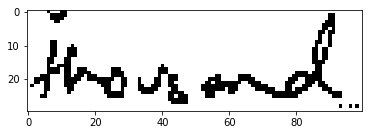

(1, 30, 100, 1)


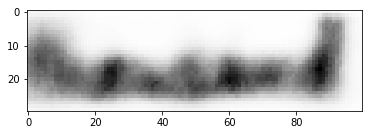

------------------------------End: test------------------------------
Cheque 309062thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.9937538  0.02253091 0.3814467  0.10219063 0.00707147 0.01765929
  0.04897554 0.01628979 0.0333021  0.00936899 0.03722766 0.16603065
  0.16665916 0.06942479 0.04768931 0.01178404 0.01962679 0.00133627
  0.01984639 0.00765575 0.04164488 0.16138221 0.03054874 0.03931612
  0.04981773 0.03447235 0.05714317 0.06680417 0.24007793 0.04737777
  0.01967516 0.00613863 0.1777231 ]]
[0]
0
['One']


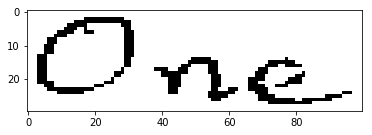

(1, 30, 100, 1)


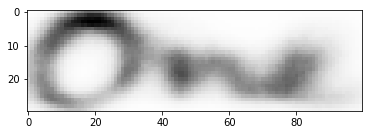

------------------------------End: test------------------------------
Cheque 309063thre2_0.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.10056508 0.10851419 0.10188945 0.12892802 0.0631758  0.06102721
  0.00438331 0.00939166 0.16457346 0.01245709 0.03721768 0.04006267
  0.02905577 0.05839211 0.06378353 0.02396048 0.26239604 0.07894628
  0.0597105  0.05750312 0.06459574 0.07786418 0.9004329  0.02547465
  0.995129   0.07318628 0.11307511 0.03663656 0.08045752 0.03416515
  0.02147184 0.01821514 0.12748542]]
[24]
24
['Thousand']


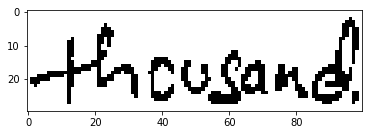

(1, 30, 100, 1)


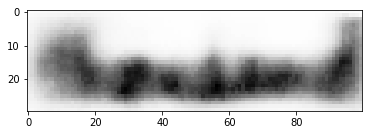

------------------------------End: test------------------------------
Cheque 309063thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.11195005 0.16646563 0.60115135 0.04940004 0.12221229 0.09757543
  0.01533346 0.11365528 0.3073838  0.15978292 0.04835964 0.11724937
  0.04107634 0.24921499 0.15641853 0.04594193 0.04914551 0.39594695
  0.1237689  0.06883623 0.07353599 0.06794873 0.22218433 0.05064318
  0.42902154 0.0283849  0.04973932 0.18611246 0.0513081  0.07477739
  0.1149019  0.07095828 0.12506592]]
[2]
2
['Eleven']


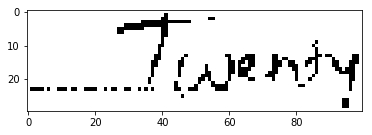

(1, 30, 100, 1)


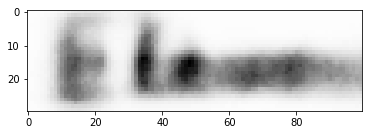

------------------------------End: test------------------------------
Cheque 309066thre2_0.tif Eleven
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07507632 0.06341891 0.01707692 0.18618216 0.04292758 0.02809577
  0.05121562 0.04491421 0.02860761 0.06947484 0.23784666 0.09084775
  0.05222562 0.029557   0.00995488 0.08111874 0.17246132 0.15647246
  0.11521961 0.01716137 0.0412119  0.10891026 0.0992631  0.04721348
  0.01924815 0.12084335 0.05812344 0.23865923 0.99384624 0.0953412
  0.02881355 0.01458949 0.05028977]]
[28]
28
['Five']


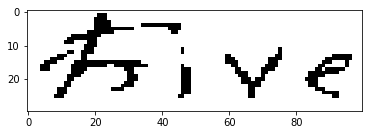

(1, 30, 100, 1)


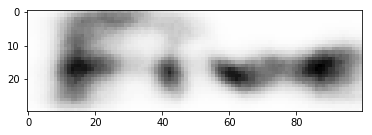

------------------------------End: test------------------------------
Cheque 309066thre2_1.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05015252 0.01864028 0.04611097 0.29485446 0.1453472  0.02276005
  0.01137763 0.14714766 0.02762354 0.00632648 0.05322276 0.35810867
  0.9751015  0.20999941 0.01743144 0.02053438 0.02886077 0.09920362
  0.05626433 0.05528868 0.04368866 0.07134451 0.03045256 0.13087197
  0.00930481 0.04366246 0.02243131 0.01782743 0.12727048 0.0064036
  0.08222912 0.02716433 0.01856432]]
[12]
12
['Twenty']


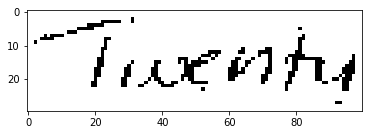

(1, 30, 100, 1)


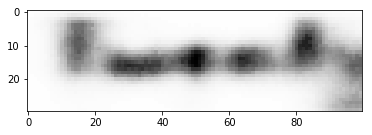

------------------------------End: test------------------------------
Cheque 309066thre2_3.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03259858 0.26053432 0.02669097 0.06037221 0.4395124  0.03193256
  0.01017461 0.02270518 0.00781973 0.00340638 0.01519405 0.07244381
  0.06417408 0.02837215 0.03573506 0.1578663  0.09957714 0.06833188
  0.04427209 0.00444193 0.07748456 0.02030745 0.03415975 0.06632437
  0.99282664 0.04404338 0.07173468 0.04744851 0.06301699 0.03414696
  0.0623117  0.03697491 0.02594376]]
[24]
24
['Thousand']


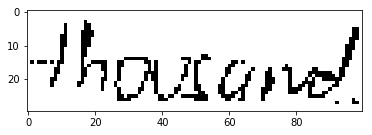

(1, 30, 100, 1)


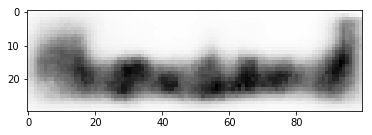

------------------------------End: test------------------------------
Cheque 309066thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.9884053  0.07811327 0.04439448 0.07744789 0.05248177 0.03033072
  0.03245609 0.03148939 0.00608861 0.02853744 0.01966394 0.27170044
  0.02504609 0.0451969  0.43921822 0.13411985 0.09528015 0.05607097
  0.04952696 0.07331649 0.09894886 0.15284303 0.15170771 0.08702062
  0.03177704 0.01676833 0.14658007 0.27907744 0.02292099 0.0150998
  0.03922099 0.00868361 0.02074499]]
[0]
0
['One']


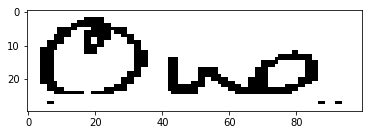

(1, 30, 100, 1)


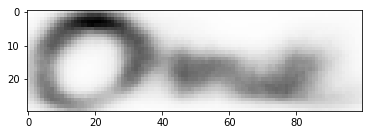

------------------------------End: test------------------------------
Cheque 309067thre2_0.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02646269 0.09324326 0.05092132 0.06873371 0.06360664 0.02713666
  0.19089635 0.17810307 0.06800291 0.01440324 0.00940138 0.02672831
  0.02737033 0.15467125 0.17742209 0.03848817 0.0247151  0.06438125
  0.01671183 0.00203419 0.02802524 0.02298194 0.12552372 0.02387241
  0.02444527 0.8819264  0.10485758 0.06608339 0.09917592 0.07791524
  0.28724906 0.02739661 0.3594902 ]]
[25]
25
['Lakh']


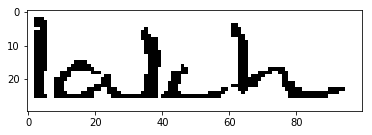

(1, 30, 100, 1)


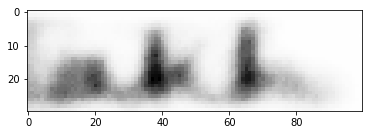

------------------------------End: test------------------------------
Cheque 309067thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01482989 0.07444083 0.0790511  0.05058433 0.00536554 0.2260689
  0.01539558 0.02347051 0.09438841 0.00751218 0.01969784 0.01928236
  0.02119381 0.39924008 0.5100192  0.07204407 0.0317518  0.07876928
  0.04614754 0.02641524 0.133803   0.09262888 0.04037578 0.01230088
  0.28025404 0.033789   0.08055498 0.59918916 0.1378393  0.08578711
  0.15658967 0.0246265  0.14442599]]
[27]
27
['Four']


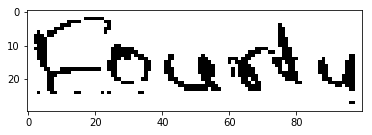

(1, 30, 100, 1)


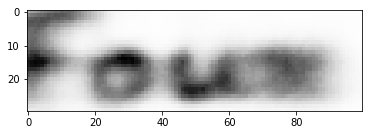

------------------------------End: test------------------------------
Cheque 309067thre2_2.tif Four
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03745476 0.09098496 0.00395002 0.06525945 0.04463965 0.13632604
  0.0492153  0.10218082 0.03479704 0.10121708 0.01913101 0.01471474
  0.51258093 0.12123554 0.02981314 0.17520848 0.03643796 0.20188609
  0.15247142 0.00568739 0.00868668 0.03137133 0.02930788 0.01368902
  0.9939809  0.10135996 0.01387288 0.02545898 0.02546904 0.02355514
  0.01927039 0.1434272  0.10664071]]
[24]
24
['Thousand']


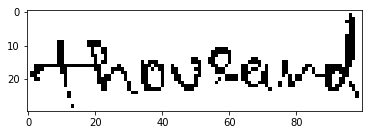

(1, 30, 100, 1)


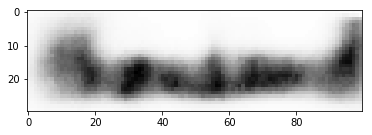

------------------------------End: test------------------------------
Cheque 309067thre2_3.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0527111  0.16388056 0.08567905 0.04630793 0.03536775 0.04916642
  0.01776209 0.04324344 0.1225011  0.00722173 0.01754179 0.05487134
  0.04577861 0.10306408 0.01041713 0.07670952 0.1480384  0.25279856
  0.11547261 0.03968805 0.06056816 0.04503711 0.08559553 0.03235928
  0.02828487 0.9927192  0.50983256 0.07112084 0.03865876 0.12092625
  0.42808068 0.01506041 0.02897132]]
[25]
25
['Lakh']


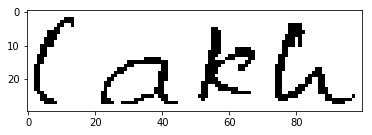

(1, 30, 100, 1)


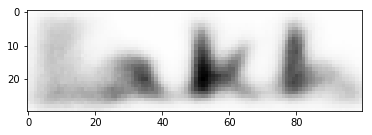

------------------------------End: test------------------------------
Cheque 309068thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04774076 0.00450137 0.7337447  0.07485969 0.07166526 0.7496701
  0.22085226 0.14028934 0.1331157  0.07902076 0.00931185 0.02732235
  0.17740056 0.02245618 0.251281   0.07321585 0.12743127 0.10567949
  0.20805196 0.01545373 0.28669813 0.13922966 0.07848878 0.13243595
  0.16410205 0.02619379 0.03060636 0.2880603  0.08608194 0.05214325
  0.03350955 0.06451752 0.01874452]]
[5]
5
['Fourteen']


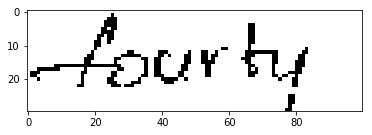

(1, 30, 100, 1)


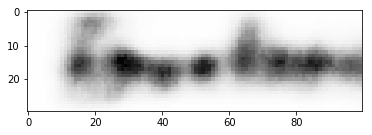

------------------------------End: test------------------------------
Cheque 309068thre2_2.tif Fourteen
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.10930564 0.00470634 0.0090901  0.01925964 0.18004623 0.05314997
  0.04524667 0.0316668  0.03987296 0.06703882 0.03107364 0.07398727
  0.06808711 0.04157443 0.02074401 0.0599095  0.0101003  0.03892064
  0.0361347  0.0510787  0.05568844 0.00780721 0.01798656 0.02063
  0.9884033  0.03437088 0.01313812 0.01210596 0.02502497 0.01030391
  0.1221665  0.02317671 0.00668804]]
[24]
24
['Thousand']


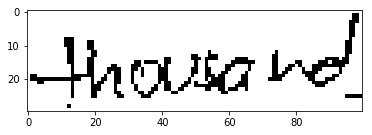

(1, 30, 100, 1)


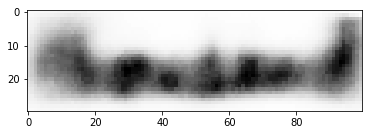

------------------------------End: test------------------------------
Cheque 309068thre2_3.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.14922273 0.42143726 0.00741766 0.09222936 0.01422291 0.02069369
  0.07322852 0.06764284 0.09081881 0.02876447 0.01132433 0.9929562
  0.02954049 0.01391777 0.02347875 0.03377403 0.07358466 0.14217936
  0.18527563 0.08477125 0.02913004 0.04909575 0.12523936 0.09192058
  0.01680311 0.13208395 0.00922417 0.04667806 0.13237482 0.06023041
  0.03139322 0.07218543 0.0549603 ]]
[11]
11
['Two']


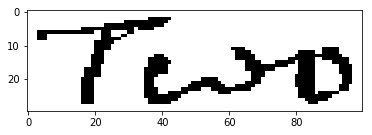

(1, 30, 100, 1)


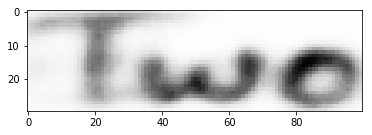

------------------------------End: test------------------------------
Cheque 309069thre2_0.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0199015  0.16501081 0.05065544 0.04115228 0.03656307 0.07430459
  0.06225359 0.01826525 0.06304102 0.04644513 0.06061666 0.02223123
  0.02828966 0.06640019 0.07279366 0.07755309 0.06682122 0.00905297
  0.10818991 0.01844822 0.18559425 0.0195578  0.0391118  0.00407701
  0.0151392  0.9810313  0.22011058 0.02492078 0.144339   0.05485841
  0.06068941 0.05372979 0.06296144]]
[25]
25
['Lakh']


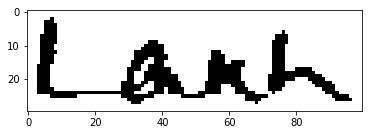

(1, 30, 100, 1)


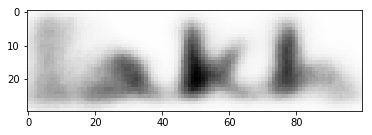

------------------------------End: test------------------------------
Cheque 309069thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03282123 0.18208672 0.20142385 0.11535076 0.21081223 0.00639296
  0.05839877 0.17108932 0.39880612 0.01349587 0.04407778 0.04480784
  0.685959   0.14179774 0.0235293  0.03401674 0.05022705 0.9934784
  0.01285358 0.1640115  0.05820544 0.0311888  0.18030848 0.02560941
  0.07400914 0.04068645 0.01540095 0.20427085 0.05858961 0.04025467
  0.10078664 0.03593133 0.02415141]]
[17]
17
['Seventy']


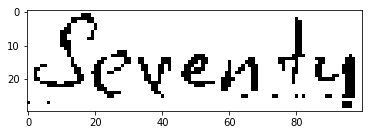

(1, 30, 100, 1)


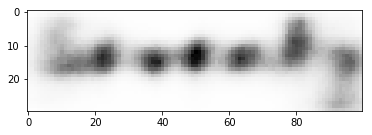

------------------------------End: test------------------------------
Cheque 309069thre2_2.tif Seventy
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02445671 0.05797755 0.14467707 0.09600244 0.05493672 0.04312855
  0.03735506 0.10017157 0.16274717 0.04015215 0.03705958 0.0416114
  0.08576836 0.03671173 0.11796274 0.11489109 0.02114139 0.05259541
  0.03042871 0.01946853 0.03140237 0.01920943 0.06822085 0.1072025
  0.06759968 0.01359608 0.01163693 0.05522836 0.9909915  0.02523362
  0.02035189 0.09946322 0.01436845]]
[28]
28
['Five']


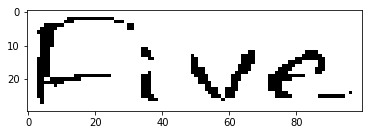

(1, 30, 100, 1)


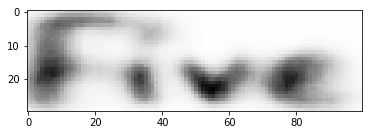

------------------------------End: test------------------------------
Cheque 309069thre2_3.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06032089 0.16148235 0.06797507 0.02576734 0.18659984 0.25289324
  0.07676925 0.01209711 0.04257394 0.02568685 0.02341744 0.02920217
  0.03628966 0.02033333 0.05961273 0.20109247 0.07345644 0.08819718
  0.1683999  0.04272294 0.0647896  0.0490501  0.24406014 0.10883819
  0.9951172  0.04097391 0.06974202 0.08587454 0.01271823 0.10383761
  0.02441764 0.02732347 0.0957869 ]]
[24]
24
['Thousand']


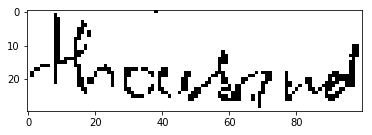

(1, 30, 100, 1)


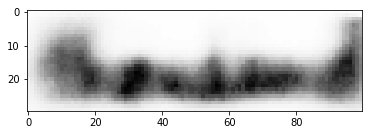

------------------------------End: test------------------------------
Cheque 309069thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04512221 0.02875052 0.03512751 0.02614061 0.08415019 0.08138245
  0.02468183 0.14862637 0.00899545 0.04899272 0.12682696 0.03175576
  0.02050132 0.07575731 0.03144442 0.03153776 0.03574871 0.02076274
  0.07224178 0.02835231 0.03387037 0.01835737 0.0788038  0.01076679
  0.05252568 0.05125434 0.06715878 0.05355682 0.0596277  0.41380867
  0.98592126 0.056975   0.00245325]]
[30]
30
['Seven']


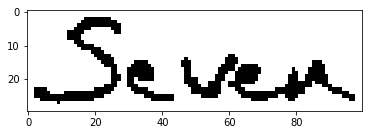

(1, 30, 100, 1)


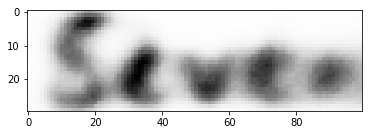

------------------------------End: test------------------------------
Cheque 309070thre2_0.tif Seven
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.20514432 0.03572025 0.04543471 0.38815087 0.3518281  0.0285552
  0.30904928 0.0711038  0.04459257 0.00995036 0.02942706 0.9221838
  0.04549456 0.2916134  0.06076824 0.06871737 0.03389047 0.1640982
  0.13469099 0.11793344 0.01646313 0.07806358 0.28646445 0.05863704
  0.01450573 0.92759776 0.02753035 0.16475666 0.25194597 0.14930071
  0.08785935 0.07569604 0.10143333]]
[25]
25
['Lakh']


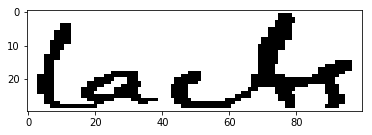

(1, 30, 100, 1)


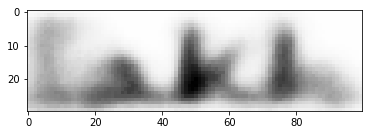

------------------------------End: test------------------------------
Cheque 309070thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02347209 0.05531537 0.14408162 0.04131504 0.0140234  0.03470144
  0.08829554 0.2866255  0.06569532 0.02533076 0.03780117 0.02449491
  0.03483589 0.02107514 0.3924685  0.05704281 0.99180216 0.07378671
  0.06843074 0.02105713 0.01369574 0.10722249 0.03270717 0.02292218
  0.07154311 0.05485306 0.08112664 0.02499381 0.10947207 0.06659727
  0.02172324 0.09065848 0.04280628]]
[16]
16
['Sixty']


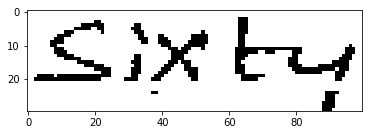

(1, 30, 100, 1)


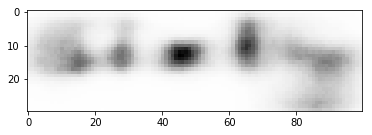

------------------------------End: test------------------------------
Cheque 309070thre2_2.tif Sixty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06640781 0.16834563 0.00474271 0.00978966 0.6579864  0.01898902
  0.01525112 0.09722429 0.02140133 0.04640493 0.07333198 0.01294608
  0.04312479 0.07344774 0.0389189  0.0173844  0.00667444 0.07359515
  0.04810474 0.03943003 0.07323117 0.00792589 0.14773737 0.01361759
  0.99282724 0.01575082 0.13707799 0.03331723 0.02716869 0.01935137
  0.1070554  0.02272598 0.01781025]]
[24]
24
['Thousand']


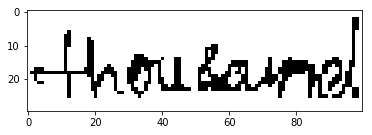

(1, 30, 100, 1)


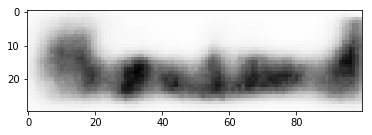

------------------------------End: test------------------------------
Cheque 309070thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01636766 0.15260382 0.15662867 0.10871036 0.04219936 0.03128065
  0.11588157 0.08868243 0.02211931 0.12243057 0.42297825 0.08478677
  0.21996781 0.02185284 0.07961043 0.02095475 0.13544993 0.10579012
  0.0606904  0.9687427  0.0875332  0.13223936 0.3892799  0.04456039
  0.04296012 0.36772522 0.0601407  0.10487349 0.09948041 0.01002129
  0.05391509 0.1577001  0.00866007]]
[19]
19
['Ninety']


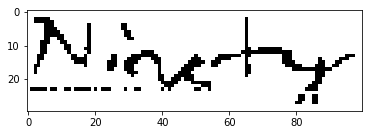

(1, 30, 100, 1)


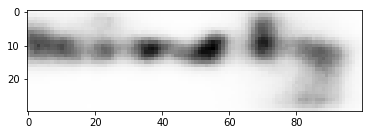

------------------------------End: test------------------------------
Cheque 309071thre2_0.tif Ninety
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07531966 0.01004574 0.17427915 0.02588095 0.02539308 0.00979488
  0.0273993  0.10476626 0.0141624  0.00878729 0.03607085 0.05026914
  0.00501843 0.00414069 0.09352331 0.07341788 0.01726346 0.02118358
  0.04456707 0.03500137 0.01135922 0.01408503 0.11961751 0.02532629
  0.02987479 0.01988315 0.04397447 0.02734693 0.99217737 0.08340847
  0.04073803 0.02704088 0.04322874]]
[28]
28
['Five']


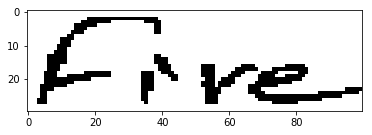

(1, 30, 100, 1)


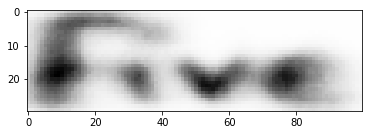

------------------------------End: test------------------------------
Cheque 309071thre2_1.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02515404 0.20565148 0.04481398 0.05780345 0.0277643  0.07247187
  0.02989854 0.04921499 0.01271831 0.12536493 0.01317316 0.09651671
  0.12988447 0.01267689 0.0526118  0.09695826 0.1488341  0.26196516
  0.09722891 0.04600589 0.10058769 0.07053649 0.01557004 0.01847687
  0.02233139 0.99513954 0.32053804 0.07017968 0.04959876 0.08302314
  0.7259164  0.0566465  0.0666118 ]]
[25]
25
['Lakh']


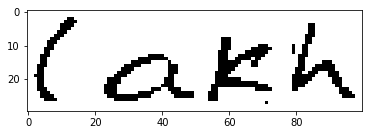

(1, 30, 100, 1)


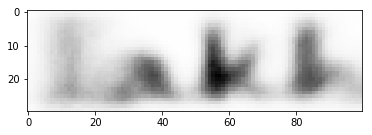

------------------------------End: test------------------------------
Cheque 309071thre2_2.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.14197028 0.00509659 0.22302692 0.04536115 0.13674878 0.32407528
  0.00302988 0.03776603 0.04959231 0.03491358 0.02277526 0.02439077
  0.79771954 0.8527942  0.54154557 0.11477035 0.03230266 0.05730905
  0.45707917 0.09532952 0.24771892 0.00774921 0.27111426 0.04489221
  0.39558622 0.12362205 0.00923948 0.9050048  0.03037093 0.03289804
  0.20045532 0.0200077  0.03235807]]
[27]
27
['Four']


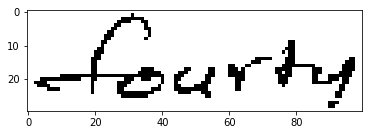

(1, 30, 100, 1)


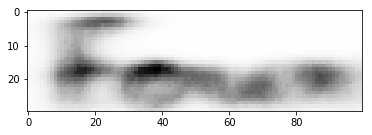

------------------------------End: test------------------------------
Cheque 309071thre2_3.tif Four
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02959584 0.09045271 0.01354811 0.73732156 0.5273512  0.19075039
  0.15462339 0.4468337  0.29390395 0.021635   0.3990132  0.07138783
  0.22924878 0.25872242 0.20790944 0.22539826 0.07637707 0.24858165
  0.07553905 0.14054    0.10831583 0.03221785 0.07280094 0.1163111
  0.42103097 0.6712605  0.4450897  0.18942097 0.02478834 0.22279137
  0.03891595 0.41509742 0.15444763]]
[3]
3
['Twelve']


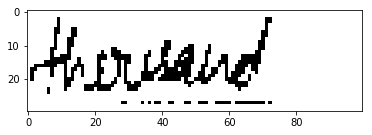

(1, 30, 100, 1)


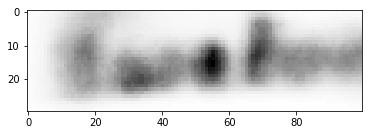

------------------------------End: test------------------------------
Cheque 309071thre2_4.tif Twelve
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02474091 0.16688891 0.03658776 0.03748673 0.01539498 0.04341565
  0.03040424 0.0247778  0.01981215 0.02352677 0.05499773 0.23468095
  0.19916408 0.04423748 0.00708512 0.03599825 0.09333241 0.27996045
  0.12380983 0.04184942 0.02799023 0.250469   0.08006907 0.05900756
  0.0158115  0.9950301  0.18345419 0.02986005 0.070371   0.07483491
  0.13987441 0.02644303 0.13200182]]
[25]
25
['Lakh']


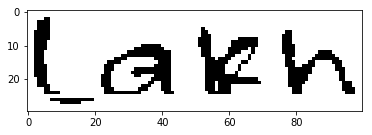

(1, 30, 100, 1)


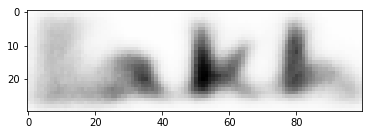

------------------------------End: test------------------------------
Cheque 309072thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.11021556 0.06137552 0.00327693 0.08850968 0.0405132  0.04761543
  0.01307971 0.13108282 0.01441131 0.01257505 0.07427967 0.11813941
  0.03005373 0.03234816 0.08808187 0.01831702 0.9909152  0.02074019
  0.06037364 0.05729318 0.03022553 0.28030375 0.02617602 0.04647332
  0.00338966 0.400519   0.11679979 0.04191372 0.08533204 0.08553987
  0.06701466 0.03926407 0.15410993]]
[16]
16
['Sixty']


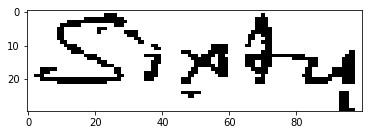

(1, 30, 100, 1)


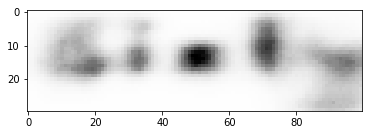

------------------------------End: test------------------------------
Cheque 309072thre2_2.tif Sixty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01039345 0.02395265 0.01962444 0.02473858 0.0521597  0.06258896
  0.11775414 0.07882901 0.03356666 0.1356822  0.02330009 0.05461864
  0.06770241 0.01372844 0.08558656 0.17571968 0.03842748 0.11867923
  0.1345795  0.03127911 0.03117695 0.13803487 0.17450567 0.01740622
  0.01004745 0.06952304 0.02159098 0.11338816 0.98452544 0.07133064
  0.02453626 0.0039054  0.06568327]]
[28]
28
['Five']


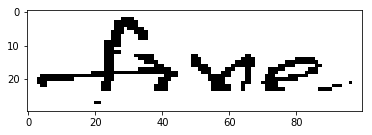

(1, 30, 100, 1)


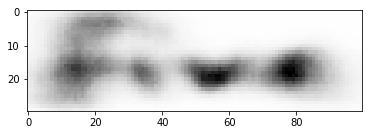

------------------------------End: test------------------------------
Cheque 309072thre2_3.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06595068 0.12133938 0.01519981 0.07764076 0.03402838 0.7474706
  0.0311433  0.07653287 0.0850362  0.03695032 0.07577717 0.01194697
  0.01984896 0.01726046 0.12175647 0.13040616 0.02722798 0.01412182
  0.01027715 0.02318116 0.02488553 0.06253339 0.11502597 0.03495087
  0.96113855 0.01938927 0.13003623 0.75685143 0.10382879 0.15402116
  0.11828327 0.20136534 0.12416139]]
[24]
24
['Thousand']


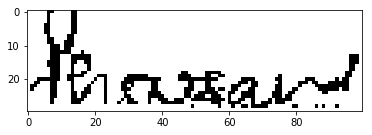

(1, 30, 100, 1)


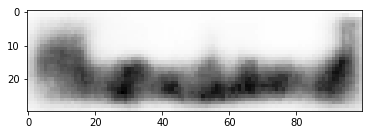

------------------------------End: test------------------------------
Cheque 309072thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04268196 0.02948926 0.14617881 0.06393991 0.00849765 0.06407565
  0.02225026 0.12682876 0.00994237 0.00237517 0.0983143  0.04079282
  0.17832036 0.9841464  0.07605708 0.04309665 0.04945235 0.01986923
  0.01307192 0.06636119 0.13791503 0.12709385 0.00744629 0.01388868
  0.07105002 0.03532702 0.1566394  0.06761426 0.09384509 0.04333889
  0.09375376 0.08398882 0.67010176]]
[13]
13
['Thirty']


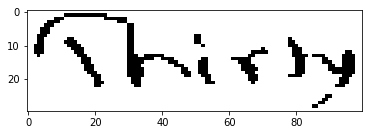

(1, 30, 100, 1)


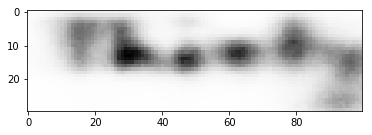

------------------------------End: test------------------------------
Cheque 309073thre2_0.tif Thirty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02108086 0.03282245 0.00940626 0.2110447  0.02786664 0.18175985
  0.02609753 0.00673176 0.07128977 0.01708535 0.06869364 0.0456344
  0.0779363  0.07039086 0.0570697  0.01302126 0.12361494 0.05414318
  0.04508038 0.0919309  0.03724552 0.11487902 0.13853784 0.06031101
  0.05080674 0.98193717 0.4769012  0.16194095 0.03220174 0.04582091
  0.51360255 0.43082288 0.06519336]]
[25]
25
['Lakh']


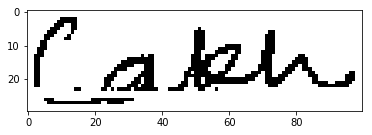

(1, 30, 100, 1)


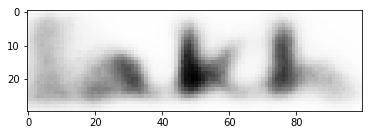

------------------------------End: test------------------------------
Cheque 309073thre2_2.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00979328 0.10377172 0.00635077 0.01685327 0.01323976 0.05234367
  0.03100418 0.06090479 0.07271139 0.01527909 0.12438311 0.09371725
  0.28547615 0.6973767  0.7621272  0.07969135 0.16610023 0.02150183
  0.10439827 0.07054084 0.3313896  0.01357321 0.0478863  0.04818576
  0.07966672 0.36419544 0.05727308 0.7087107  0.05976758 0.05547548
  0.10071442 0.08143838 0.09598579]]
[14]
14
['Forty']


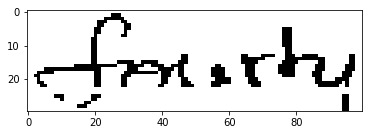

(1, 30, 100, 1)


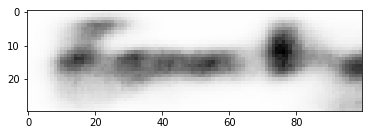

------------------------------End: test------------------------------
Cheque 309073thre2_3.tif Forty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07289764 0.06089217 0.13020393 0.02505428 0.24551712 0.29407904
  0.03606006 0.05448131 0.01323918 0.00812576 0.12226663 0.0223244
  0.03480057 0.03668274 0.04017741 0.06749535 0.04354768 0.03951458
  0.00949069 0.00457481 0.070627   0.06112025 0.02794712 0.09401785
  0.99368757 0.01854963 0.14982045 0.05006595 0.2243684  0.01473174
  0.18676913 0.0528474  0.09073903]]
[24]
24
['Thousand']


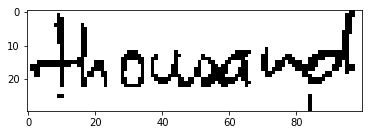

(1, 30, 100, 1)


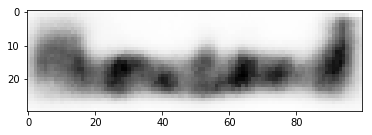

------------------------------End: test------------------------------
Cheque 309073thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.9940891  0.02533706 0.01099865 0.0252794  0.04804098 0.168315
  0.03065372 0.05570547 0.02202975 0.03305889 0.01146243 0.00842332
  0.06329006 0.10549282 0.12780488 0.11811201 0.07455571 0.0487102
  0.02094776 0.1257073  0.11076634 0.05599726 0.04630464 0.07647709
  0.07545032 0.03379071 0.08305322 0.1293938  0.00502335 0.04595546
  0.17665325 0.02291484 0.07884546]]
[0]
0
['One']


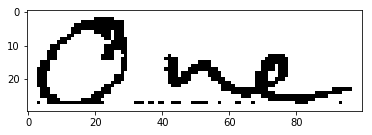

(1, 30, 100, 1)


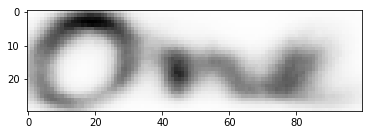

------------------------------End: test------------------------------
Cheque 309074thre2_0.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01001058 0.01374788 0.05504479 0.01055425 0.03733224 0.04335833
  0.01319074 0.05056201 0.08024161 0.00553268 0.02412009 0.02032183
  0.03854538 0.07008486 0.03738464 0.10820498 0.10209654 0.04769729
  0.02239143 0.00549005 0.02404077 0.05016601 0.00563997 0.06506928
  0.01060963 0.9928274  0.04111231 0.06230472 0.04521015 0.04496937
  0.04879425 0.01121292 0.05368635]]
[25]
25
['Lakh']


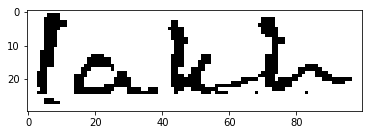

(1, 30, 100, 1)


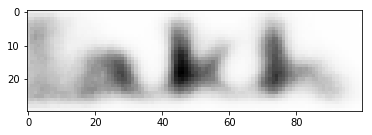

------------------------------End: test------------------------------
Cheque 309074thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.11332582 0.05683764 0.07630517 0.16109075 0.04226445 0.13869132
  0.1680785  0.07967217 0.16537738 0.17574097 0.09613942 0.14947067
  0.06924466 0.06997143 0.20295654 0.99166095 0.01990412 0.01296532
  0.17318197 0.19517118 0.06404068 0.01789854 0.03103501 0.0971406
  0.02512028 0.06872482 0.04485083 0.16268596 0.25493684 0.03963399
  0.00853746 0.0812329  0.06020224]]
[15]
15
['Fifty']


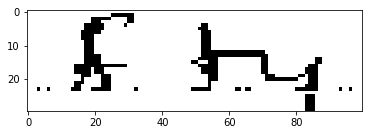

(1, 30, 100, 1)


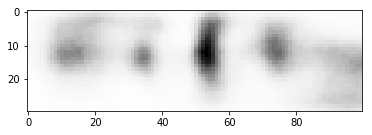

------------------------------End: test------------------------------
Cheque 309074thre2_2.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.16084753 0.17349203 0.00375874 0.1064549  0.02357051 0.01950321
  0.1035107  0.21915051 0.09972707 0.03278733 0.03617667 0.55372906
  0.84618807 0.06152233 0.25145137 0.06023666 0.02753723 0.10931647
  0.05704974 0.05153095 0.03641469 0.10643457 0.05546939 0.0246431
  0.9534257  0.07115722 0.27721307 0.52527905 0.01467838 0.08284774
  0.11584231 0.13466065 0.35324407]]
[24]
24
['Thousand']


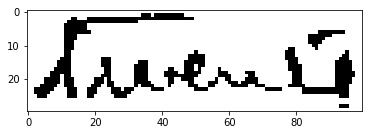

(1, 30, 100, 1)


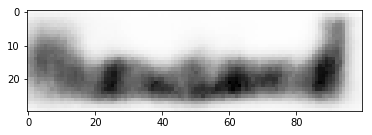

------------------------------End: test------------------------------
Cheque 309075thre2_0.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.37447757 0.04715794 0.10734808 0.140988   0.07181213 0.01958626
  0.46865875 0.04253015 0.02971053 0.0328313  0.09290578 0.02336719
  0.01056403 0.10545221 0.11160414 0.04663343 0.19661039 0.07872657
  0.05500166 0.07080463 0.05624354 0.02768255 0.99163246 0.0128446
  0.20956789 0.13869901 0.04714385 0.03750499 0.04742208 0.15362746
  0.06841212 0.02464074 0.17431447]]
[22]
22
['Three']


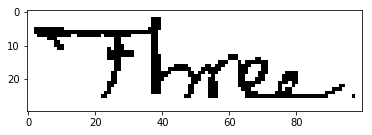

(1, 30, 100, 1)


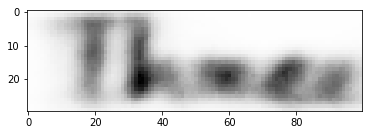

------------------------------End: test------------------------------
Cheque 309075thre2_1.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.19664581 0.12079701 0.05718587 0.1606379  0.0212454  0.00919082
  0.00839906 0.06431036 0.04465411 0.00747027 0.01595374 0.04616448
  0.03464425 0.04877666 0.01093598 0.09480603 0.01982941 0.07462112
  0.20760274 0.12304716 0.01272965 0.08039125 0.12383003 0.02909309
  0.02002225 0.98908323 0.21938695 0.08450121 0.07427396 0.05904629
  0.6670155  0.01416768 0.00967213]]
[25]
25
['Lakh']


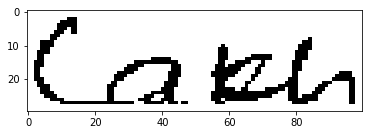

(1, 30, 100, 1)


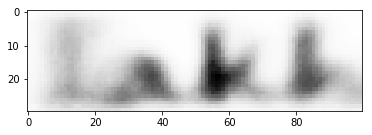

------------------------------End: test------------------------------
Cheque 309075thre2_2.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06351902 0.03380883 0.15964796 0.17751685 0.03132345 0.05014303
  0.6872522  0.2828606  0.06858046 0.06820609 0.07642914 0.05452155
  0.59256905 0.08928125 0.37883    0.9746669  0.16637826 0.20892979
  0.02955174 0.04615778 0.23768914 0.05291824 0.19460267 0.03787888
  0.00780269 0.05212054 0.04733008 0.23013704 0.06558401 0.06900834
  0.05181263 0.01613946 0.07048859]]
[15]
15
['Fifty']


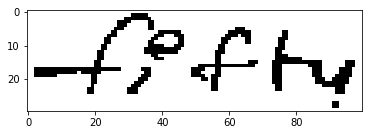

(1, 30, 100, 1)


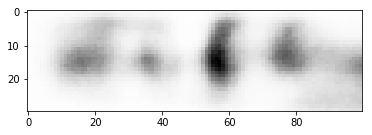

------------------------------End: test------------------------------
Cheque 309075thre2_3.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07384091 0.12339574 0.04769157 0.08064389 0.40035486 0.02903862
  0.07850553 0.12063399 0.07445295 0.00987233 0.05753596 0.0608051
  0.04660835 0.04642313 0.08192807 0.12610711 0.02113619 0.07497376
  0.11950665 0.06176828 0.1198293  0.01452682 0.15580356 0.09776745
  0.99246144 0.02796375 0.03640347 0.06105655 0.04861134 0.13754149
  0.10703153 0.05312758 0.3364542 ]]
[24]
24
['Thousand']


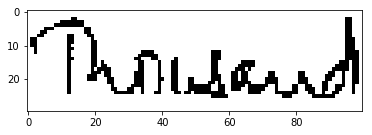

(1, 30, 100, 1)


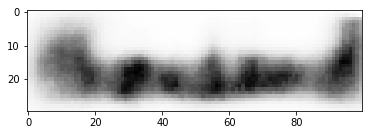

------------------------------End: test------------------------------
Cheque 309077thre2_1.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0050826  0.08884409 0.03583381 0.02499687 0.18560372 0.10311796
  0.06894312 0.07079366 0.00788177 0.01393109 0.07745419 0.73388153
  0.01954074 0.02446294 0.01373168 0.05993935 0.03358576 0.08075356
  0.05720424 0.18465096 0.07243922 0.00897593 0.05639337 0.07245512
  0.01176178 0.6546509  0.23780145 0.04335462 0.13375606 0.20923062
  0.06755641 0.42971063 0.09219861]]
[11]
11
['Two']


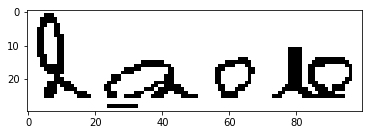

(1, 30, 100, 1)


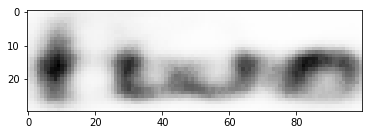

------------------------------End: test------------------------------
Cheque 309078thre2_2.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0891479  0.04132208 0.04015688 0.09059431 0.03203364 0.02423797
  0.22455868 0.08729234 0.01413713 0.0215889  0.09311714 0.06138518
  0.01037044 0.00273006 0.06764919 0.03646179 0.03647687 0.16242792
  0.08713792 0.25865588 0.00892982 0.01856064 0.05557102 0.07234976
  0.06882134 0.25119784 0.14897035 0.5398564  0.9924834  0.04230513
  0.3047902  0.01221922 0.05684614]]
[28]
28
['Five']


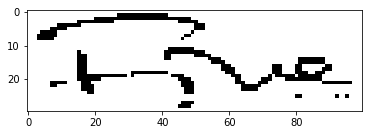

(1, 30, 100, 1)


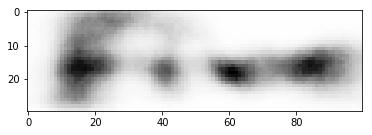

------------------------------End: test------------------------------
Cheque 309078thre2_3.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0403078  0.03875348 0.01176274 0.09421123 0.08598113 0.00255541
  0.14633617 0.08662611 0.00663244 0.00928687 0.09120287 0.11691795
  0.09982344 0.13607234 0.07366481 0.12634286 0.14354745 0.19833775
  0.02451212 0.02499611 0.22939973 0.11358107 0.11788212 0.9927294
  0.17850064 0.10624945 0.03565174 0.01787755 0.05246453 0.05731936
  0.08139142 0.02214523 0.00986851]]
[23]
23
['Hundred']


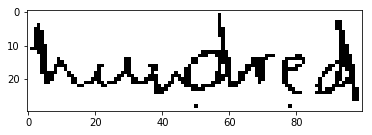

(1, 30, 100, 1)


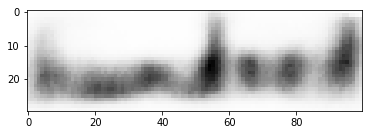

------------------------------End: test------------------------------
Cheque 309078thre2_4.tif Hundred
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.634925   0.5430219  0.03691975 0.333736   0.26825297 0.04702019
  0.26593533 0.21455829 0.14638121 0.05878737 0.10032321 0.11355696
  0.10175046 0.36868465 0.33466506 0.49873307 0.07536458 0.02497935
  0.04210849 0.09782321 0.10084563 0.09173092 0.2143417  0.20027365
  0.17911442 0.77553225 0.01781141 0.4460414  0.08798278 0.71434987
  0.05665682 0.41805214 0.14804362]]
[25]
25
['Lakh']


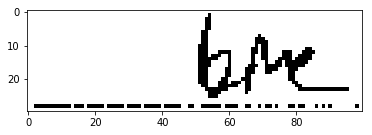

(1, 30, 100, 1)


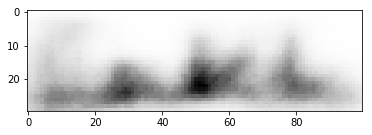

------------------------------End: test------------------------------
Cheque 309079thre2_0.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07770591 0.06278087 0.1537226  0.02901909 0.00557821 0.11730272
  0.02168281 0.00687619 0.03784489 0.00980867 0.06584994 0.07518786
  0.07373963 0.10267133 0.04090928 0.08408686 0.01193141 0.01841396
  0.058057   0.02748339 0.36684337 0.03622184 0.28082943 0.11131823
  0.00827006 0.5685366  0.16833551 0.14485693 0.30435067 0.2999655
  0.12280867 0.01020503 0.04273665]]
[25]
25
['Lakh']


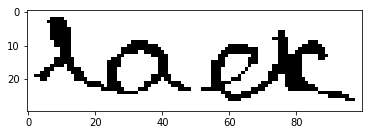

(1, 30, 100, 1)


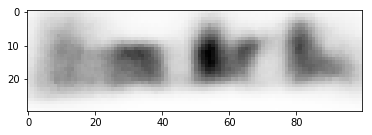

------------------------------End: test------------------------------
Cheque 309079thre2_2.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.10227854 0.05767519 0.21949652 0.21724473 0.02589532 0.11369017
  0.06500309 0.01208305 0.01002895 0.01152487 0.03278577 0.33411756
  0.97197104 0.722047   0.12128327 0.08432812 0.02490865 0.12796313
  0.06949063 0.08570559 0.00380886 0.01375819 0.12521762 0.2809323
  0.6561364  0.0305408  0.12152861 0.03126616 0.11587545 0.24024318
  0.04632987 0.0465345  0.05924292]]
[12]
12
['Twenty']


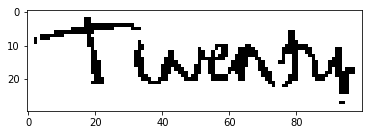

(1, 30, 100, 1)


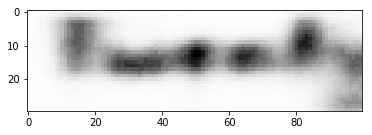

------------------------------End: test------------------------------
Cheque 309079thre2_3.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00579543 0.07310732 0.05981591 0.04524733 0.48510742 0.07334739
  0.00639028 0.01374717 0.02395781 0.01488807 0.01396701 0.02165881
  0.11429928 0.16837512 0.12944819 0.0615738  0.14145862 0.06604797
  0.12474888 0.04535249 0.01614995 0.09873772 0.12040939 0.06217902
  0.9929756  0.06652845 0.0618697  0.03584375 0.02821708 0.0534282
  0.03484411 0.1642414  0.05029615]]
[24]
24
['Thousand']


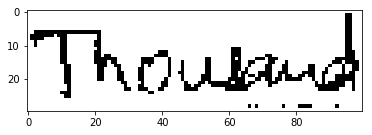

(1, 30, 100, 1)


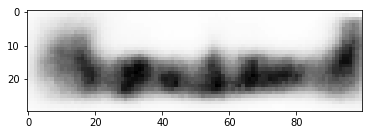

------------------------------End: test------------------------------
Cheque 309079thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.12857549 0.50464    0.0308859  0.74835086 0.13565831 0.01750745
  0.13764736 0.02411968 0.04033494 0.08556292 0.17202255 0.50011665
  0.07280177 0.3552377  0.1022181  0.4902432  0.03904004 0.03483933
  0.05384832 0.13401186 0.06777927 0.11392094 0.13694812 0.29369467
  0.16085629 0.3351187  0.0463138  0.38354537 0.11632495 0.46618876
  0.05766945 0.21556585 0.25569084]]
[3]
3
['Twelve']


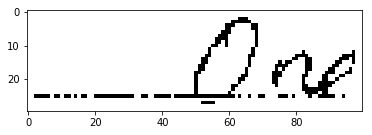

(1, 30, 100, 1)


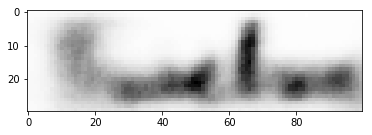

------------------------------End: test------------------------------
Cheque 309080thre2_0.tif Twelve
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01140782 0.02074701 0.06467773 0.12562348 0.04849897 0.03139398
  0.01146063 0.02498363 0.05633669 0.1620455  0.05466101 0.12114263
  0.45157033 0.09580771 0.4212773  0.0291569  0.05787732 0.26096168
  0.01128679 0.04553886 0.2512792  0.0268134  0.14577039 0.07800294
  0.06714546 0.35374552 0.04730037 0.05546775 0.02192456 0.14117421
  0.0401333  0.01475939 0.36507556]]
[12]
12
['Twenty']


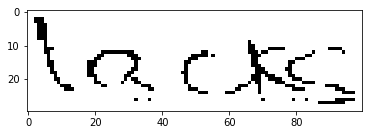

(1, 30, 100, 1)


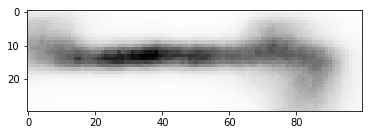

------------------------------End: test------------------------------
Cheque 309080thre2_4.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.12662055 0.09172845 0.04209235 0.0331591  0.15664384 0.00897591
  0.03287978 0.13848652 0.03823269 0.03951994 0.01712326 0.0538369
  0.0092444  0.996402   0.2745911  0.01948902 0.07103616 0.29952264
  0.02094194 0.0249246  0.07426136 0.11908535 0.01432843 0.00230324
  0.0204267  0.01812603 0.03733194 0.06786073 0.09865791 0.03728823
  0.04342962 0.00974443 0.13873349]]
[13]
13
['Thirty']


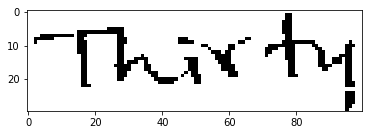

(1, 30, 100, 1)


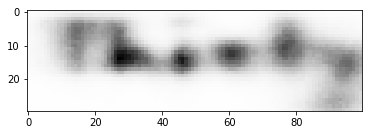

------------------------------End: test------------------------------
Cheque 309082thre2_0.tif Thirty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0651311  0.22060916 0.17287627 0.0536747  0.08506174 0.0271384
  0.02184781 0.11529972 0.00286893 0.00847014 0.5770698  0.1483958
  0.01969532 0.01053149 0.15918247 0.06027154 0.01541516 0.07358806
  0.01836463 0.05372751 0.8626778  0.0230754  0.05130766 0.06002527
  0.02863266 0.69084305 0.0217077  0.14758302 0.05524049 0.17460887
  0.01473402 0.0482183  0.01974534]]
[20]
20
['Rupees']


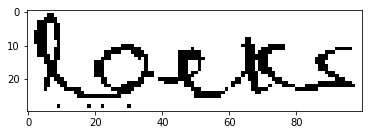

(1, 30, 100, 1)


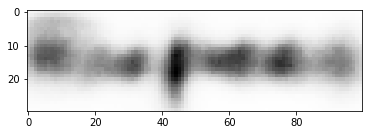

------------------------------End: test------------------------------
Cheque 309082thre2_1.tif Rupees
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0484582  0.50437    0.03479076 0.0336622  0.02888869 0.04694585
  0.01435728 0.01196451 0.11727738 0.0049092  0.05566416 0.98147976
  0.02606157 0.02040949 0.04515857 0.00667759 0.00502359 0.04351682
  0.11068846 0.03991168 0.1593688  0.07119416 0.13278553 0.10681103
  0.03603334 0.03970534 0.04630893 0.49529132 0.04732256 0.18472189
  0.06532417 0.00866194 0.0220122 ]]
[11]
11
['Two']


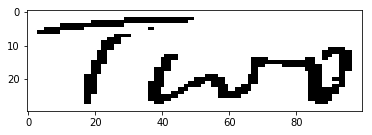

(1, 30, 100, 1)


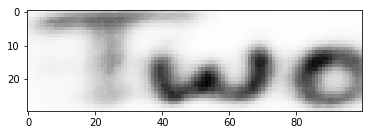

------------------------------End: test------------------------------
Cheque 309083thre2_0.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01635814 0.13996121 0.5941047  0.2495076  0.02116765 0.05908062
  0.04551173 0.12682466 0.01341156 0.01403298 0.04121877 0.05201909
  0.00884116 0.06334329 0.02394698 0.00499132 0.0950694  0.07484908
  0.07413765 0.02953697 0.1354118  0.01501832 0.01324132 0.01524299
  0.06853618 0.97643864 0.09762974 0.02350702 0.02062565 0.03237449
  0.11767583 0.01855492 0.04588313]]
[25]
25
['Lakh']


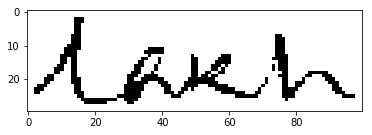

(1, 30, 100, 1)


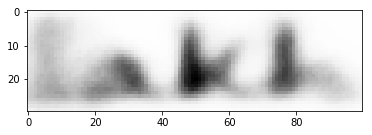

------------------------------End: test------------------------------
Cheque 309083thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06097084 0.05789188 0.04189809 0.07051337 0.01183975 0.02233456
  0.01748966 0.01223702 0.00925066 0.00222741 0.01750398 0.08627251
  0.16637821 0.9943793  0.03843606 0.01969167 0.02190128 0.04323045
  0.05463456 0.04704089 0.27434984 0.08414802 0.10433337 0.00646552
  0.00948971 0.08025054 0.02090491 0.05727204 0.04307084 0.02209903
  0.12689573 0.17934817 0.15719461]]
[13]
13
['Thirty']


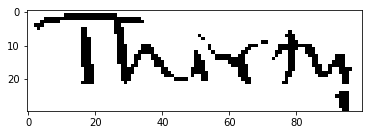

(1, 30, 100, 1)


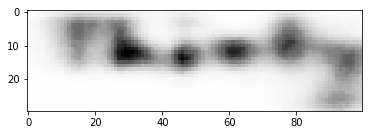

------------------------------End: test------------------------------
Cheque 309083thre2_2.tif Thirty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07249471 0.21246172 0.038683   0.08699411 0.06288488 0.10094818
  0.15652728 0.12215502 0.07221614 0.02222481 0.04765479 0.36371425
  0.04632857 0.0793913  0.0912727  0.14472778 0.05127108 0.02357514
  0.13962343 0.12852313 0.03029508 0.07401121 0.03801722 0.02869784
  0.04525416 0.03170329 0.04275658 0.11648536 0.9925939  0.14693548
  0.26500946 0.00788711 0.10064675]]
[28]
28
['Five']


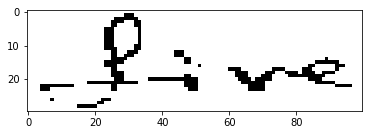

(1, 30, 100, 1)


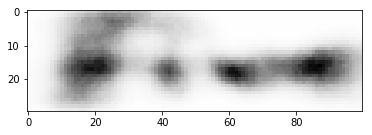

------------------------------End: test------------------------------
Cheque 309083thre2_3.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01095237 0.01060291 0.03010572 0.01428477 0.761624   0.06270831
  0.02456715 0.04554041 0.08682984 0.01447154 0.05276215 0.01919333
  0.26759166 0.32028013 0.02554133 0.03247345 0.05066357 0.07550588
  0.04361758 0.01063493 0.01309157 0.02944165 0.18148851 0.07787216
  0.9954111  0.03683214 0.14856347 0.02387926 0.11329617 0.01678658
  0.02138825 0.03596593 0.09459934]]
[24]
24
['Thousand']


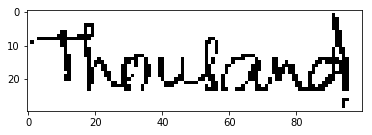

(1, 30, 100, 1)


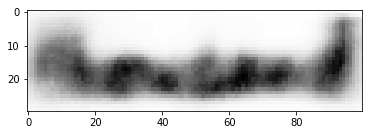

------------------------------End: test------------------------------
Cheque 309083thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03800476 0.05149897 0.01200873 0.39696416 0.0412259  0.00294068
  0.10520988 0.08321068 0.05650533 0.09526832 0.02362175 0.05938235
  0.26465482 0.0175073  0.09659014 0.9951123  0.07830382 0.02392814
  0.8099256  0.24697068 0.0148529  0.05770371 0.06363196 0.06870546
  0.0113572  0.00993285 0.02376461 0.09632257 0.01309472 0.02055909
  0.01084376 0.02582668 0.02517471]]
[15]
15
['Fifty']


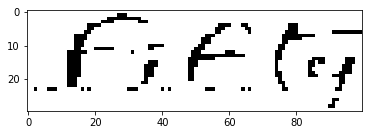

(1, 30, 100, 1)


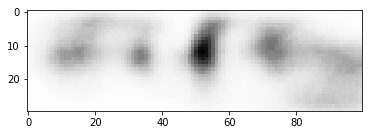

------------------------------End: test------------------------------
Cheque 309084thre2_0.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03730642 0.10819083 0.00552493 0.14147231 0.1909846  0.08297755
  0.25359088 0.01817825 0.0134308  0.00255188 0.02443784 0.99052244
  0.01102533 0.3159821  0.09921677 0.01861071 0.10518289 0.06786054
  0.03741087 0.12781455 0.01809507 0.09954792 0.05418424 0.03529551
  0.07023369 0.14938185 0.04296933 0.2288427  0.04151955 0.07087979
  0.08764215 0.07282518 0.23128577]]
[11]
11
['Two']


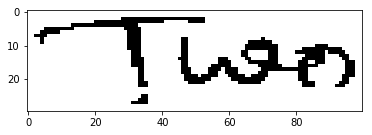

(1, 30, 100, 1)


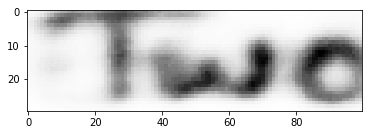

------------------------------End: test------------------------------
Cheque 309084thre2_1.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02468947 0.15881695 0.07335497 0.09117619 0.04773881 0.06220812
  0.03666178 0.32264924 0.06673808 0.01263622 0.03064544 0.05405427
  0.00337678 0.03696635 0.02336761 0.12238008 0.06586733 0.03572776
  0.02610721 0.20791422 0.07750826 0.12692878 0.12357102 0.04753314
  0.04244061 0.15155114 0.9799536  0.02705472 0.04576147 0.17476328
  0.2187131  0.03798677 0.09978199]]
[26]
26
['Crore']


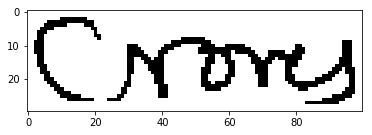

(1, 30, 100, 1)


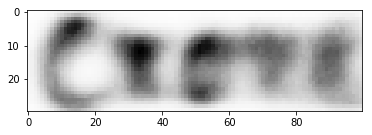

------------------------------End: test------------------------------
Cheque 309084thre2_2.tif Crore
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.97750217 0.03218151 0.0745487  0.05673365 0.02623286 0.02474283
  0.05355161 0.03205251 0.02606339 0.03649924 0.01200174 0.2470745
  0.03181975 0.05155195 0.17214468 0.01974867 0.06613278 0.01560192
  0.03766043 0.11417619 0.03656452 0.36620775 0.04521991 0.01672035
  0.05848552 0.22378185 0.3238472  0.11742227 0.00843153 0.20672874
  0.06299461 0.01627994 0.06575875]]
[0]
0
['One']


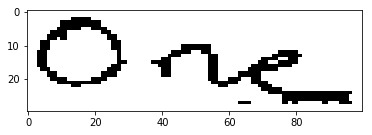

(1, 30, 100, 1)


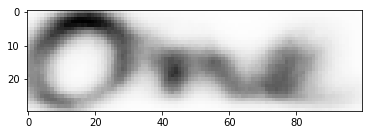

------------------------------End: test------------------------------
Cheque 309086thre2_0.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.99240035 0.10010223 0.04473155 0.18138577 0.03429598 0.01699953
  0.26768753 0.19818862 0.00526919 0.02480324 0.0753655  0.05055878
  0.02628897 0.05332509 0.12403827 0.03630361 0.0599462  0.01208468
  0.00754697 0.03294942 0.07410937 0.05521256 0.05980967 0.03968426
  0.01664131 0.126442   0.01615423 0.08594012 0.0872319  0.0893129
  0.14077224 0.09106906 0.07002373]]
[0]
0
['One']


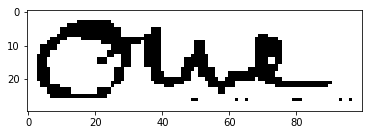

(1, 30, 100, 1)


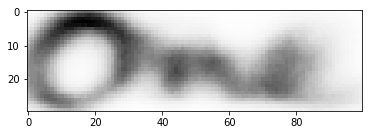

------------------------------End: test------------------------------
Cheque 309086thre2_2.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02950322 0.21612534 0.16818736 0.15171675 0.03287853 0.00901998
  0.05745043 0.17114495 0.04976994 0.06122593 0.05902553 0.06373253
  0.03016946 0.16788016 0.08002026 0.03417642 0.0813794  0.12631507
  0.00875105 0.11428971 0.02423909 0.14581935 0.02989981 0.16280854
  0.09824067 0.2963363  0.02130509 0.1870299  0.302324   0.4376717
  0.32209355 0.01589197 0.04362456]]
[29]
29
['Six']


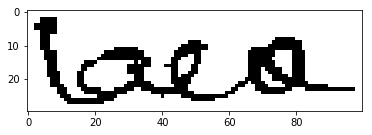

(1, 30, 100, 1)


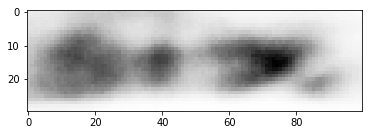

------------------------------End: test------------------------------
Cheque 309086thre2_3.tif Six
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04491727 0.1319253  0.03823306 0.21514931 0.08690104 0.55077034
  0.06100563 0.00953951 0.2028029  0.05179594 0.15377608 0.12803368
  0.02951754 0.04798744 0.8954299  0.00842873 0.23461206 0.07198179
  0.12715624 0.01570323 0.0784054  0.22356038 0.02946898 0.05629563
  0.06851771 0.02278802 0.02829017 0.89376247 0.13813244 0.17797093
  0.04285269 0.28766888 0.11122113]]
[14]
14
['Forty']


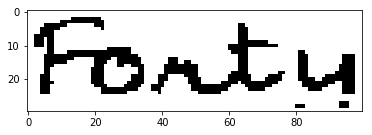

(1, 30, 100, 1)


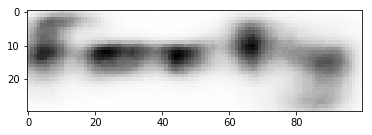

------------------------------End: test------------------------------
Cheque 309089thre2_0.tif Forty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06281485 0.03073542 0.0985513  0.03660054 0.08863737 0.00180251
  0.00785554 0.00960764 0.02076619 0.05718942 0.0256316  0.99083596
  0.01550099 0.04635046 0.08407659 0.06488603 0.05917738 0.10695305
  0.07025469 0.01261805 0.13519444 0.03633044 0.05234533 0.00504498
  0.04569284 0.01589306 0.09197704 0.03946627 0.0096507  0.06843422
  0.03297989 0.01128805 0.03900718]]
[11]
11
['Two']


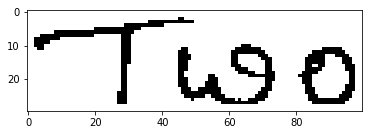

(1, 30, 100, 1)


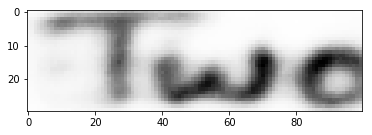

------------------------------End: test------------------------------
Cheque 309089thre2_1.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04138301 0.1306877  0.00373138 0.03432815 0.2476892  0.1618021
  0.15926407 0.05734658 0.15756667 0.03234006 0.01405302 0.07097524
  0.00987774 0.12247346 0.05073716 0.03702021 0.13513996 0.0555439
  0.0746616  0.04928537 0.08915821 0.06321786 0.02700818 0.01562163
  0.01100145 0.5555957  0.01096977 0.04438359 0.05012578 0.8734555
  0.08282162 0.05501666 0.13259377]]
[29]
29
['Six']


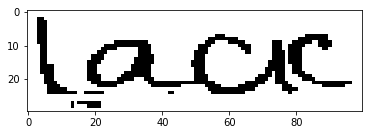

(1, 30, 100, 1)


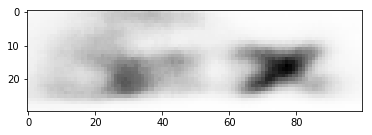

------------------------------End: test------------------------------
Cheque 309089thre2_2.tif Six
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01180396 0.04745513 0.06879879 0.05716391 0.00516566 0.10210466
  0.08264039 0.01277656 0.21156971 0.00904933 0.16395341 0.31289312
  0.97663015 0.03161054 0.03131277 0.05844036 0.0327432  0.11094148
  0.7961148  0.01735089 0.22370449 0.01426771 0.15562326 0.11919423
  0.20622468 0.03050398 0.08569098 0.07071341 0.14908414 0.14924529
  0.05964627 0.06821635 0.03529884]]
[12]
12
['Twenty']


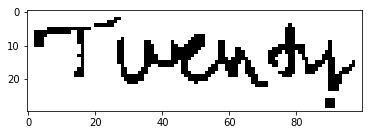

(1, 30, 100, 1)


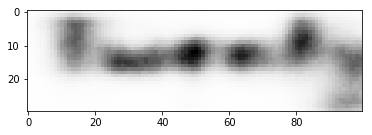

------------------------------End: test------------------------------
Cheque 309089thre2_3.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.13196309 0.04125489 0.04866631 0.30852628 0.10903294 0.63855296
  0.24026549 0.2476778  0.20897579 0.02113872 0.17152211 0.02369616
  0.76901215 0.05495197 0.10461905 0.05645303 0.04014061 0.13927464
  0.16186759 0.01885878 0.07230089 0.03130539 0.1121955  0.60097677
  0.05193933 0.14500488 0.051051   0.185095   0.04694227 0.05224689
  0.03618243 0.09291113 0.15895994]]
[12]
12
['Twenty']


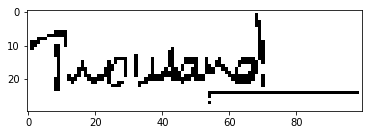

(1, 30, 100, 1)


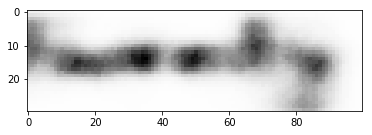

------------------------------End: test------------------------------
Cheque 309089thre2_4.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.99665624 0.01635997 0.02391011 0.05870634 0.05537385 0.08099516
  0.08244051 0.07282051 0.00956333 0.01316223 0.02020347 0.06738088
  0.00679797 0.00507495 0.3151869  0.02759766 0.02079432 0.01532865
  0.00993853 0.03818287 0.06811967 0.11565333 0.07444055 0.01916184
  0.03458557 0.02755476 0.05955199 0.03516602 0.16435754 0.06728
  0.08172586 0.01138858 0.06587701]]
[0]
0
['One']


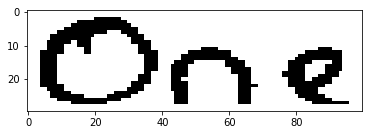

(1, 30, 100, 1)


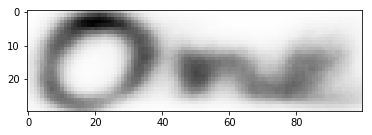

------------------------------End: test------------------------------
Cheque 309090thre2_0.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04078496 0.23415613 0.0365555  0.19306134 0.05344163 0.09632023
  0.08851589 0.02018943 0.06154441 0.02762462 0.14707331 0.24198839
  0.00618243 0.01591331 0.03766644 0.02939644 0.07142588 0.03357198
  0.21369973 0.01871434 0.10560369 0.07647298 0.30907214 0.04328491
  0.013696   0.12134076 0.44032285 0.06747627 0.01203814 0.449566
  0.03691344 0.17129532 0.12330984]]
[29]
29
['Six']


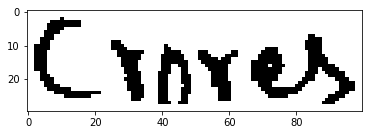

(1, 30, 100, 1)


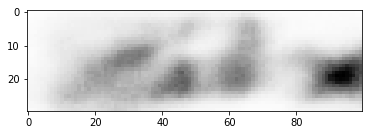

------------------------------End: test------------------------------
Cheque 309090thre2_1.tif Six
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.09064782 0.31564638 0.09440725 0.01546905 0.11756641 0.11325546
  0.09902828 0.13661362 0.68076646 0.02707389 0.20659721 0.03320661
  0.07391029 0.04301989 0.29626644 0.08956642 0.52641195 0.97941625
  0.26513776 0.14647615 0.30343917 0.0682033  0.24488983 0.02206106
  0.01321483 0.17587575 0.13010897 0.5737437  0.06633612 0.30329314
  0.9174189  0.16834751 0.14629789]]
[17]
17
['Seventy']


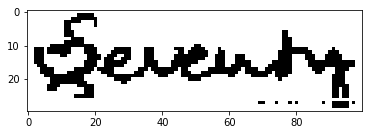

(1, 30, 100, 1)


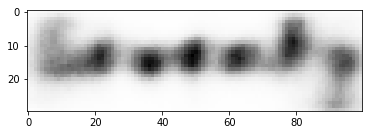

------------------------------End: test------------------------------
Cheque 309090thre2_2.tif Seventy
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07353228 0.06644174 0.10894353 0.10959398 0.01024873 0.00489043
  0.01850385 0.16813256 0.05115956 0.02498942 0.07675147 0.3178414
  0.03220168 0.03389684 0.13302885 0.15886064 0.22542736 0.16510522
  0.05228254 0.17147532 0.16788715 0.4774689  0.633664   0.01141455
  0.02026087 0.59841293 0.15075302 0.12058313 0.03281616 0.5211297
  0.03503182 0.04463677 0.03980381]]
[22]
22
['Three']


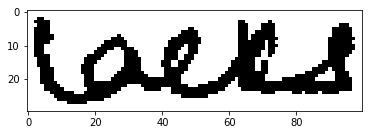

(1, 30, 100, 1)


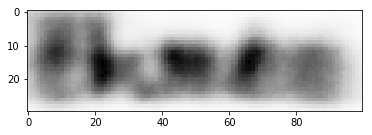

------------------------------End: test------------------------------
Cheque 309090thre2_3.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.10725524 0.03763438 0.00739583 0.47791344 0.06975614 0.05171716
  0.02530457 0.14717905 0.0570081  0.139507   0.13096793 0.07407869
  0.9854271  0.09030996 0.13710333 0.1805049  0.07580377 0.10154625
  0.8076591  0.05238263 0.08134542 0.11177658 0.14212526 0.06709694
  0.03005627 0.24234296 0.04563467 0.05733026 0.07258647 0.01160606
  0.0572525  0.03483706 0.07855433]]
[12]
12
['Twenty']


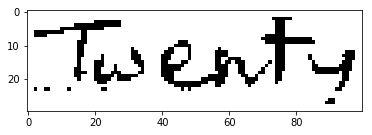

(1, 30, 100, 1)


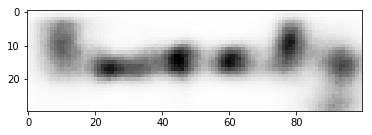

------------------------------End: test------------------------------
Cheque 309091thre2_0.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02187979 0.11362575 0.05102532 0.06198918 0.03275102 0.05338316
  0.02237956 0.11117438 0.06139047 0.01390701 0.03833418 0.07385328
  0.02812248 0.14485823 0.07866461 0.16909845 0.10646366 0.2177452
  0.02633546 0.06713119 0.07394366 0.16738412 0.02995029 0.06187652
  0.20679964 0.02335149 0.04944375 0.0373264  0.98977834 0.02287143
  0.09629208 0.21460438 0.1209441 ]]
[28]
28
['Five']


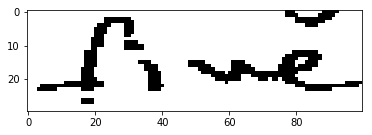

(1, 30, 100, 1)


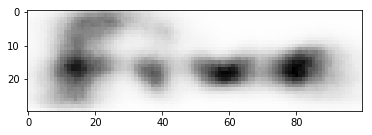

------------------------------End: test------------------------------
Cheque 309091thre2_1.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05695548 0.12976132 0.02609858 0.02286568 0.14164715 0.4345906
  0.06408758 0.12838659 0.06243657 0.1217272  0.03742355 0.03211552
  0.00765961 0.04240589 0.09679995 0.21016507 0.15547821 0.09292685
  0.08668585 0.05540815 0.01393451 0.02170128 0.07612389 0.16116953
  0.99648637 0.01295594 0.22545777 0.04418633 0.03773481 0.02742331
  0.10761444 0.06225292 0.13758668]]
[24]
24
['Thousand']


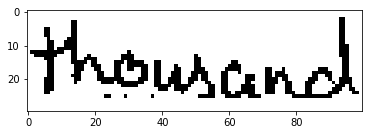

(1, 30, 100, 1)


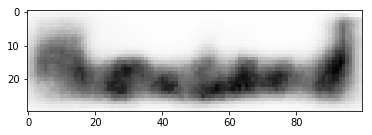

------------------------------End: test------------------------------
Cheque 309091thre2_2.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.1250669  0.13860989 0.18929622 0.03292162 0.39579082 0.02323716
  0.04315394 0.9760376  0.01555807 0.08085946 0.1462578  0.06614649
  0.11425134 0.03565485 0.10552376 0.02974818 0.07653604 0.02806192
  0.01396731 0.13884176 0.32536513 0.07131424 0.0839564  0.08178889
  0.992165   0.05540576 0.20841399 0.0810215  0.12811974 0.08616051
  0.19797994 0.2460006  0.25668025]]
[24]
24
['Thousand']


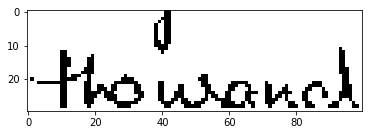

(1, 30, 100, 1)


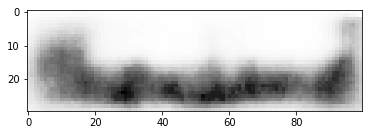

------------------------------End: test------------------------------
Cheque 309092thre2_1.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0693498  0.02973702 0.01452795 0.05627136 0.07463816 0.16013893
  0.0359064  0.00992487 0.15877289 0.11007151 0.06671083 0.16332945
  0.02957028 0.01733042 0.0678056  0.04962431 0.04265236 0.03498847
  0.09453551 0.45813707 0.05549247 0.04316912 0.06128568 0.06948783
  0.46251956 0.18036649 0.05938416 0.5274844  0.09350295 0.8582025
  0.02306034 0.17002332 0.13806228]]
[29]
29
['Six']


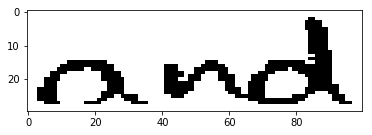

(1, 30, 100, 1)


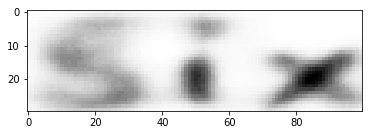

------------------------------End: test------------------------------
Cheque 309092thre2_2.tif Six
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04813686 0.0154618  0.04076147 0.81597364 0.04149312 0.02989635
  0.043858   0.14278723 0.1979961  0.02941736 0.00821656 0.04744193
  0.9924605  0.04181512 0.0436125  0.03845276 0.01973375 0.01950609
  0.08608367 0.04066882 0.04626264 0.11906061 0.15010364 0.08746558
  0.03997431 0.05514914 0.05249512 0.15313233 0.16113028 0.10068683
  0.04280348 0.06131692 0.02034937]]
[12]
12
['Twenty']


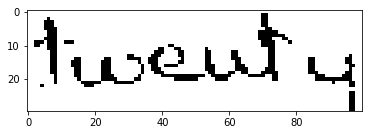

(1, 30, 100, 1)


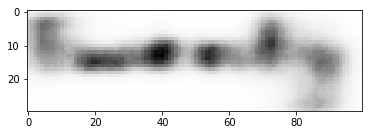

------------------------------End: test------------------------------
Cheque 309092thre2_3.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05735351 0.25155607 0.20526595 0.07094108 0.09818907 0.22435503
  0.8915066  0.01006549 0.03045008 0.08636805 0.01274367 0.20541658
  0.18936388 0.00591164 0.0617565  0.13224316 0.26340792 0.0543864
  0.12424786 0.01794804 0.0364539  0.21614304 0.988169   0.12863365
  0.05037723 0.02527686 0.01132605 0.13020818 0.53704005 0.11114972
  0.04889094 0.03191083 0.03371385]]
[22]
22
['Three']


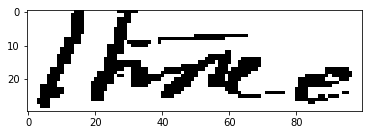

(1, 30, 100, 1)


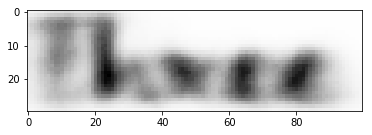

------------------------------End: test------------------------------
Cheque 309093thre2_0.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.15842555 0.18252608 0.02102899 0.01689253 0.02281945 0.04711783
  0.01036037 0.05359364 0.06308013 0.01894963 0.14680253 0.99253225
  0.13846514 0.00938952 0.05219214 0.04652139 0.04588395 0.07522336
  0.05718221 0.08453862 0.00457604 0.18077926 0.23663458 0.15870267
  0.00470131 0.0474849  0.12386626 0.26649076 0.10071345 0.02405909
  0.09146956 0.1093423  0.03858306]]
[11]
11
['Two']


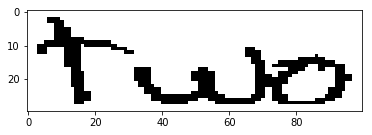

(1, 30, 100, 1)


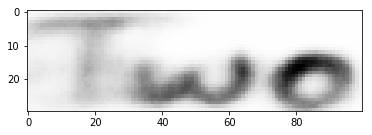

------------------------------End: test------------------------------
Cheque 309093thre2_3.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02433505 0.13756983 0.0318718  0.00312064 0.0217301  0.1334991
  0.10127679 0.03401203 0.04110052 0.02329722 0.05105134 0.98646224
  0.06345344 0.01333944 0.19479835 0.10923533 0.09542621 0.02158881
  0.0660627  0.30776143 0.59093106 0.04598181 0.06091737 0.01991181
  0.0113203  0.15444867 0.11978814 0.25566506 0.07419989 0.06002121
  0.06649283 0.0143464  0.04007269]]
[11]
11
['Two']


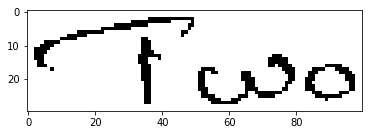

(1, 30, 100, 1)


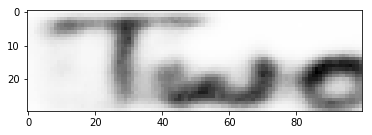

------------------------------End: test------------------------------
Cheque 309094thre2_0.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00623452 0.23811501 0.00758023 0.02001349 0.0142115  0.520414
  0.01599753 0.03656248 0.10689062 0.02273284 0.00359188 0.01515439
  0.02789037 0.04320592 0.01515994 0.08592249 0.10098992 0.01064146
  0.27880135 0.01185085 0.0434416  0.04922667 0.16376081 0.13707338
  0.04272319 0.9849375  0.17885886 0.07804393 0.02469194 0.03875528
  0.00994997 0.09912986 0.03326171]]
[25]
25
['Lakh']


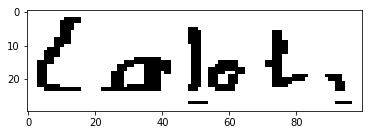

(1, 30, 100, 1)


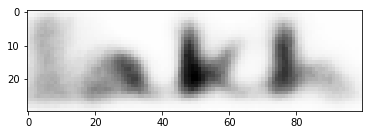

------------------------------End: test------------------------------
Cheque 309094thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04821648 0.05025712 0.09312338 0.12915413 0.01424406 0.22705737
  0.13046615 0.07837877 0.01497158 0.01542497 0.05075681 0.03062016
  0.02181515 0.0240631  0.07503895 0.20031868 0.9775738  0.05160559
  0.04039433 0.10387604 0.0243489  0.08848163 0.0540913  0.02433171
  0.04955732 0.0153726  0.01107775 0.19482984 0.1874947  0.01002141
  0.06140375 0.02308864 0.04892964]]
[16]
16
['Sixty']


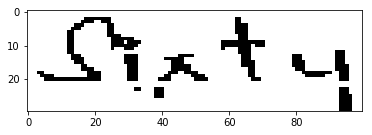

(1, 30, 100, 1)


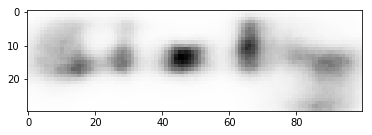

------------------------------End: test------------------------------
Cheque 309094thre2_2.tif Sixty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0137776  0.04807008 0.17182499 0.11926182 0.06004427 0.31259993
  0.02489991 0.05015463 0.0595479  0.01947874 0.14680548 0.04419431
  0.18541561 0.01809868 0.16393511 0.15511909 0.14196374 0.04887665
  0.0368011  0.00975979 0.00273154 0.03758772 0.14503019 0.09406984
  0.99537736 0.01082356 0.04258849 0.06645962 0.02847387 0.00414497
  0.03195672 0.00418978 0.03021928]]
[24]
24
['Thousand']


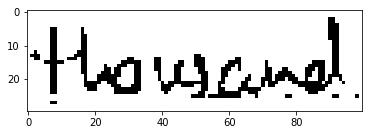

(1, 30, 100, 1)


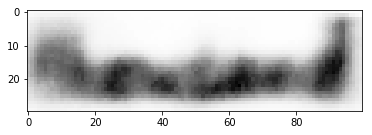

------------------------------End: test------------------------------
Cheque 309095thre2_2.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.28156763 0.03823614 0.14204668 0.05245373 0.09946007 0.07277071
  0.16920444 0.05954707 0.08682431 0.03049248 0.20178178 0.01481106
  0.2686592  0.01874267 0.19315691 0.02620979 0.20127302 0.9683389
  0.2253599  0.03075986 0.16445035 0.01180541 0.06281575 0.01486112
  0.01316277 0.05946223 0.28165448 0.03646949 0.03962942 0.02269787
  0.7216096  0.05736117 0.04686149]]
[17]
17
['Seventy']


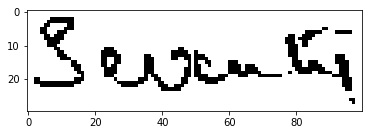

(1, 30, 100, 1)


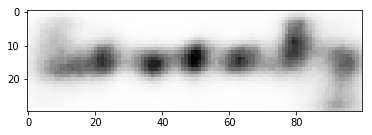

------------------------------End: test------------------------------
Cheque 309096thre2_0.tif Seventy
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.12795745 0.12725256 0.01134518 0.01918305 0.05140241 0.27983257
  0.05333408 0.11241946 0.08954522 0.08892369 0.05434892 0.16263998
  0.13015495 0.00541036 0.13662036 0.07061439 0.17595114 0.04328369
  0.04727332 0.04390793 0.15086251 0.05289343 0.03010605 0.12541647
  0.99522394 0.0601137  0.12136927 0.4722127  0.01171218 0.04857869
  0.25668493 0.04102468 0.15339737]]
[24]
24
['Thousand']


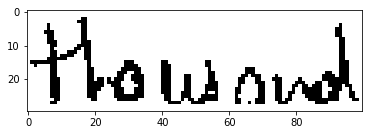

(1, 30, 100, 1)


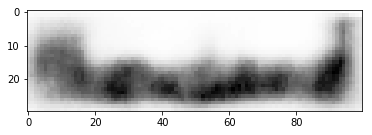

------------------------------End: test------------------------------
Cheque 309096thre2_3.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02932741 0.25731915 0.07427906 0.01313649 0.20455335 0.07272517
  0.21462782 0.10783228 0.08392252 0.01422992 0.00228138 0.7435357
  0.35535872 0.09911314 0.05827276 0.10387375 0.09246099 0.19864072
  0.29610273 0.5320101  0.02182027 0.01571703 0.09460595 0.03708426
  0.5023143  0.28267196 0.06728461 0.09415148 0.18959326 0.20772544
  0.08975785 0.01707784 0.662941  ]]
[11]
11
['Two']


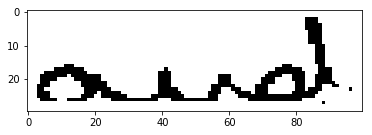

(1, 30, 100, 1)


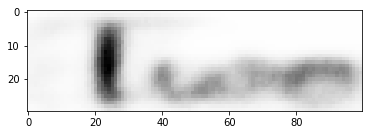

------------------------------End: test------------------------------
Cheque 309096thre2_4.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.1353117  0.0335772  0.07763049 0.37473515 0.4677502  0.01746061
  0.0928143  0.03681939 0.0366046  0.02433486 0.02272774 0.42540705
  0.76775724 0.9933669  0.04158374 0.07622553 0.12446177 0.08317364
  0.19791944 0.1708709  0.0048635  0.05561069 0.06040313 0.02151453
  0.02118276 0.06189865 0.04016761 0.0415845  0.06386095 0.02490074
  0.08100802 0.05988923 0.13032913]]
[13]
13
['Thirty']


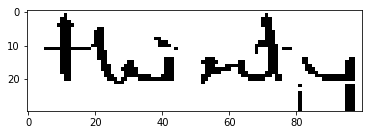

(1, 30, 100, 1)


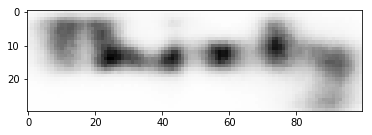

------------------------------End: test------------------------------
Cheque 309096thre2_5.tif Thirty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0517163  0.02072361 0.0361115  0.34086207 0.02718315 0.0399023
  0.04915199 0.1141632  0.0824672  0.01432767 0.08976156 0.03940653
  0.9889521  0.018133   0.10802928 0.4642182  0.03538583 0.03687173
  0.11211029 0.05719437 0.07673342 0.08471462 0.03142677 0.00541098
  0.01036893 0.09759093 0.14082055 0.0314709  0.22795893 0.07652503
  0.02995222 0.10450991 0.02226192]]
[12]
12
['Twenty']


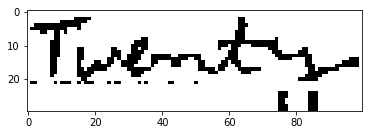

(1, 30, 100, 1)


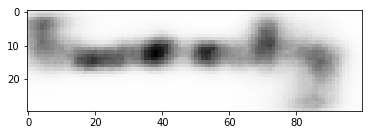

------------------------------End: test------------------------------
Cheque 309097thre2_0.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02906042 0.04222799 0.03444244 0.05434052 0.15388775 0.0147523
  0.10667428 0.0375341  0.12085722 0.0262512  0.02915873 0.2964029
  0.02919801 0.01216227 0.08049669 0.05436425 0.13967317 0.11784141
  0.00280306 0.08907291 0.03134703 0.03536139 0.12456031 0.0243496
  0.00151608 0.07589104 0.01280631 0.02828399 0.04510416 0.03177936
  0.96689254 0.04210536 0.06564113]]
[30]
30
['Seven']


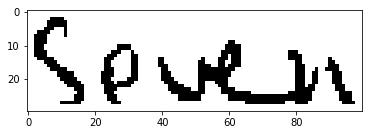

(1, 30, 100, 1)


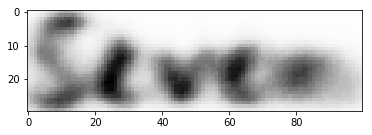

------------------------------End: test------------------------------
Cheque 309097thre2_1.tif Seven
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07171479 0.14986053 0.00728422 0.02359638 0.1416127  0.03117102
  0.01536969 0.00615068 0.06044668 0.04544176 0.1007445  0.4532813
  0.20604457 0.04342309 0.14020674 0.19903475 0.01338581 0.31185642
  0.2567379  0.20383504 0.01344142 0.03528104 0.13295549 0.01793407
  0.32542118 0.20264095 0.06477103 0.07910705 0.02370167 0.4492586
  0.2227624  0.0406443  0.10654023]]
[11]
11
['Two']


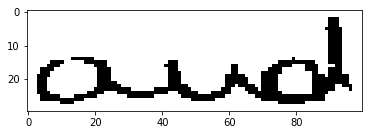

(1, 30, 100, 1)


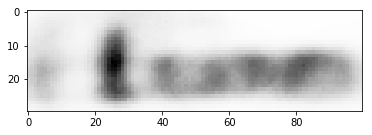

------------------------------End: test------------------------------
Cheque 309097thre2_4.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.18450888 0.04799476 0.0540607  0.07694013 0.00921194 0.06827624
  0.83153516 0.06880901 0.05687104 0.09186871 0.06402896 0.06765731
  0.05453478 0.37523332 0.00911914 0.9887443  0.15092652 0.09552947
  0.73373854 0.09882051 0.15135063 0.071964   0.23292701 0.18243119
  0.00805831 0.05269661 0.08861106 0.1535744  0.03970495 0.04068029
  0.08520357 0.09878087 0.16622049]]
[15]
15
['Fifty']


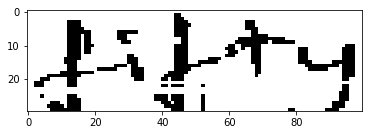

(1, 30, 100, 1)


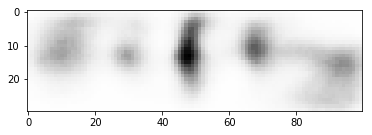

------------------------------End: test------------------------------
Cheque 309097thre2_5.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07345357 0.15321861 0.02628613 0.23263696 0.02371104 0.0329075
  0.09830543 0.0126017  0.43188125 0.00179575 0.01335313 0.04479202
  0.98166233 0.13006589 0.07413536 0.02319369 0.02232895 0.02570704
  0.0396832  0.37729913 0.01673822 0.10249504 0.09641915 0.01839591
  0.37759945 0.01325521 0.03244455 0.53175795 0.14904164 0.06437553
  0.3097659  0.18458103 0.05678907]]
[12]
12
['Twenty']


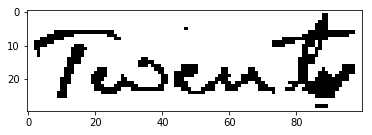

(1, 30, 100, 1)


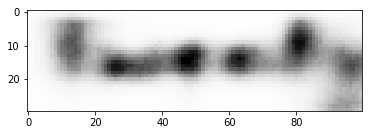

------------------------------End: test------------------------------
Cheque 309098thre2_0.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.9901246  0.03845883 0.03209224 0.14629462 0.02253989 0.09550089
  0.11101288 0.05968879 0.00982415 0.00537033 0.06493612 0.02369335
  0.2291905  0.04777033 0.13830544 0.07501747 0.02259867 0.0266037
  0.16090026 0.06823073 0.0128449  0.10807841 0.022141   0.04365832
  0.05727151 0.05142776 0.05546437 0.18812643 0.11799636 0.08103035
  0.04203707 0.00877279 0.09863096]]
[0]
0
['One']


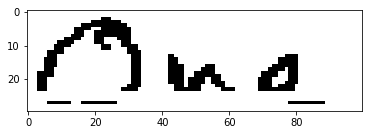

(1, 30, 100, 1)


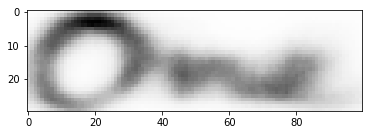

------------------------------End: test------------------------------
Cheque 309098thre2_1.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07580075 0.07322124 0.07121958 0.03948641 0.11294322 0.00579081
  0.02527683 0.02426502 0.04909542 0.02133773 0.01261499 0.0215008
  0.02924492 0.00644501 0.04468212 0.11115911 0.05225832 0.04775249
  0.07669477 0.02096362 0.07917506 0.03765551 0.02171074 0.00975596
  0.01661977 0.9939055  0.02034174 0.17886797 0.02964965 0.05020345
  0.00779695 0.0843629  0.01003621]]
[25]
25
['Lakh']


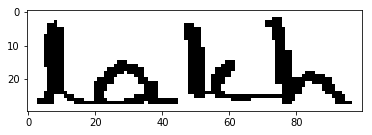

(1, 30, 100, 1)


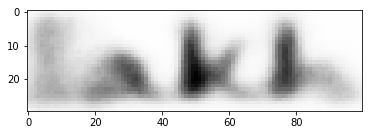

------------------------------End: test------------------------------
Cheque 309098thre2_2.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03953565 0.12608854 0.0686987  0.03146865 0.9952996  0.09176051
  0.01110019 0.26757252 0.04272828 0.0104175  0.13992299 0.04461902
  0.12944695 0.01412468 0.1621306  0.02455084 0.03345521 0.12097464
  0.18672235 0.0223005  0.05524862 0.05944214 0.03823433 0.03617639
  0.0936328  0.02595391 0.08442036 0.01815011 0.14104727 0.04476865
  0.11277125 0.00774214 0.11801276]]
[4]
4
['Thirteen']


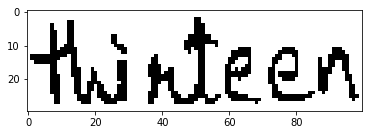

(1, 30, 100, 1)


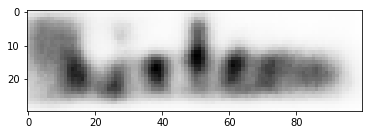

------------------------------End: test------------------------------
Cheque 309098thre2_3.tif Thirteen
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00622676 0.06362279 0.07820777 0.16596076 0.05407726 0.09169468
  0.05803801 0.02450183 0.01837836 0.08030216 0.04836453 0.07540161
  0.00859435 0.22815363 0.19544514 0.2107991  0.01041532 0.01690374
  0.01935349 0.19268902 0.01218285 0.05044203 0.07629322 0.09600364
  0.9922674  0.01563832 0.00334573 0.16308817 0.07791862 0.04823263
  0.02102544 0.00972863 0.08628017]]
[24]
24
['Thousand']


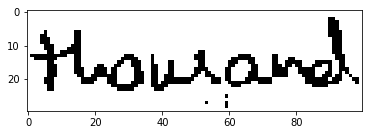

(1, 30, 100, 1)


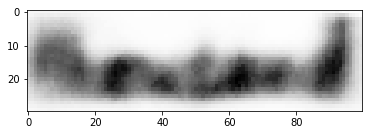

------------------------------End: test------------------------------
Cheque 309098thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02492598 0.09027661 0.15916243 0.04796412 0.02510457 0.03265031
  0.0107909  0.03187684 0.0184423  0.2211801  0.05650833 0.08029588
  0.00280073 0.07988922 0.0396021  0.07537639 0.09982716 0.02945754
  0.06470931 0.02920339 0.01730295 0.0240063  0.9964686  0.0141231
  0.02452106 0.03645228 0.05964539 0.03067367 0.20896421 0.01651821
  0.0546241  0.00844995 0.05047207]]
[22]
22
['Three']


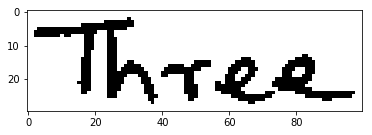

(1, 30, 100, 1)


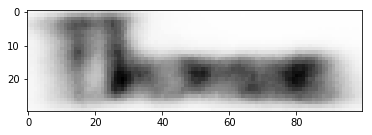

------------------------------End: test------------------------------
Cheque 309099thre2_0.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05546657 0.6096639  0.02182782 0.0082919  0.04063174 0.01056227
  0.10577447 0.06038517 0.07262821 0.0077386  0.0185514  0.14782144
  0.23074068 0.0991499  0.03830403 0.35415575 0.09986703 0.0880988
  0.1285566  0.07267947 0.22731583 0.02120304 0.21855459 0.07114258
  0.07006136 0.9944465  0.18617103 0.4365868  0.317619   0.05077954
  0.03965818 0.03196162 0.03556027]]
[25]
25
['Lakh']


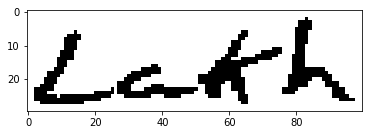

(1, 30, 100, 1)


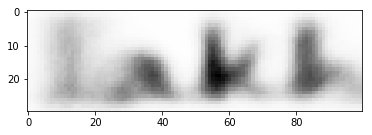

------------------------------End: test------------------------------
Cheque 309099thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.1202962  0.05257357 0.02506785 0.0853894  0.1460709  0.03642884
  0.01146305 0.09618572 0.03995884 0.05944378 0.86267763 0.17183568
  0.0695584  0.05050095 0.05178484 0.04233364 0.04381893 0.1512431
  0.1020072  0.7806609  0.009903   0.04406405 0.0680531  0.01212082
  0.1236116  0.13833034 0.02912694 0.00775204 0.03744993 0.05623715
  0.10425884 0.08372506 0.9688026 ]]
[32]
32
['Nine']


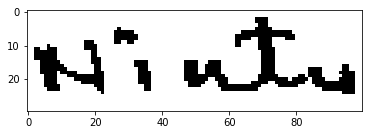

(1, 30, 100, 1)


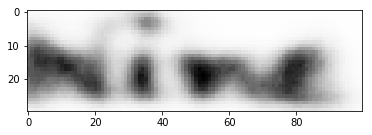

------------------------------End: test------------------------------
Cheque 309099thre2_2.tif Nine
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.14904399 0.1316224  0.13112794 0.00926265 0.31576726 0.08516064
  0.12456742 0.01899247 0.01543933 0.01642742 0.06306521 0.06727928
  0.03299633 0.0790289  0.19821636 0.11672731 0.04972558 0.01553573
  0.07491396 0.01519418 0.01964639 0.02018342 0.25442046 0.10038856
  0.03322605 0.01353145 0.13824213 0.02922752 0.04374097 0.17090285
  0.9811556  0.0031741  0.05493185]]
[30]
30
['Seven']


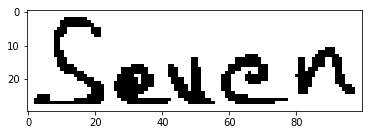

(1, 30, 100, 1)


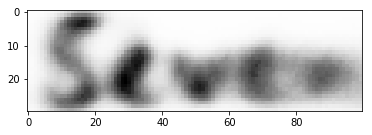

------------------------------End: test------------------------------
Cheque 309099thre2_3.tif Seven
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01479871 0.14022253 0.06315012 0.66299    0.09557809 0.39086238
  0.0253228  0.08702027 0.03204968 0.08544981 0.12400327 0.19508314
  0.07652536 0.0787163  0.09058215 0.00399623 0.0468591  0.02147114
  0.00509462 0.01580086 0.05814554 0.04061075 0.01912462 0.38068348
  0.9950868  0.03548083 0.03808831 0.05434277 0.07126419 0.08662949
  0.21082187 0.02261393 0.03756214]]
[24]
24
['Thousand']


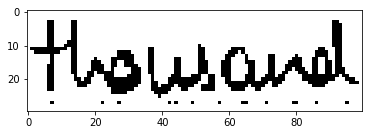

(1, 30, 100, 1)


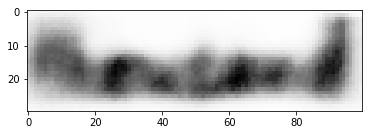

------------------------------End: test------------------------------
Cheque 309099thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0776829  0.16597252 0.10150551 0.01971403 0.055553   0.06548465
  0.02257821 0.0129954  0.09811374 0.05099988 0.00395955 0.11814742
  0.66934925 0.0047159  0.22730273 0.05643049 0.02109387 0.01574701
  0.06920891 0.0865504  0.2919963  0.07528371 0.03067022 0.05797368
  0.05224103 0.20713736 0.01988882 0.8174035  0.1112413  0.02385438
  0.03045148 0.98192674 0.09832661]]
[31]
31
['Eight']


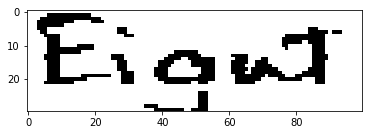

(1, 30, 100, 1)


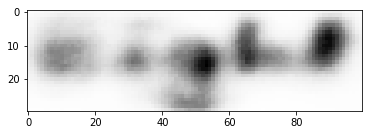

------------------------------End: test------------------------------
Cheque 309100thre2_2.tif Eight
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.20862812 0.08195741 0.23234667 0.03365555 0.06375148 0.01472853
  0.20528118 0.12704536 0.04490583 0.12048878 0.24962969 0.02834205
  0.15406357 0.10567792 0.04839795 0.06738448 0.05133743 0.1127186
  0.08601575 0.10308646 0.00511978 0.26200902 0.23385264 0.28817102
  0.99286985 0.26648462 0.2569221  0.06088947 0.05250856 0.03356759
  0.10151304 0.23194712 0.78195953]]
[24]
24
['Thousand']


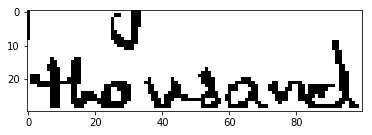

(1, 30, 100, 1)


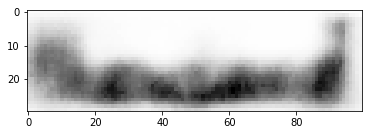

------------------------------End: test------------------------------
Cheque 309100thre2_3.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01582755 0.09305643 0.01584291 0.04881989 0.2923878  0.04404096
  0.11877112 0.25799546 0.02293782 0.04920457 0.5195556  0.12193609
  0.17834763 0.17588563 0.12609173 0.08603861 0.01011001 0.05187296
  0.09901003 0.19029622 0.0607597  0.12198185 0.09332778 0.99562764
  0.08266643 0.0562014  0.51861787 0.22076789 0.16443697 0.14693442
  0.0110729  0.032658   0.0310324 ]]
[23]
23
['Hundred']


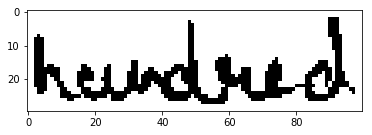

(1, 30, 100, 1)


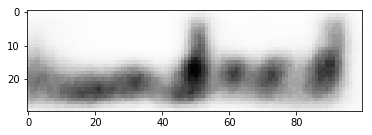

------------------------------End: test------------------------------
Cheque 309100thre2_5.tif Hundred
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.298054   0.29738978 0.01770062 0.0354938  0.2877403  0.2470314
  0.17554118 0.36183363 0.10135145 0.00515668 0.08696964 0.74764776
  0.03126662 0.22208422 0.10341299 0.09680644 0.06647108 0.00657325
  0.25742978 0.00873641 0.02437979 0.03438769 0.0199884  0.06442259
  0.99519557 0.09563823 0.4571878  0.09394156 0.2881642  0.01215736
  0.14938688 0.1569934  0.02068155]]
[24]
24
['Thousand']


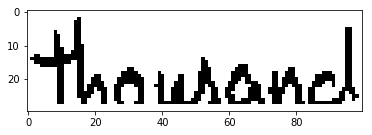

(1, 30, 100, 1)


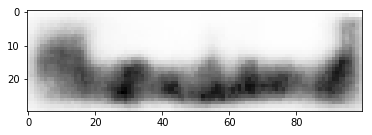

------------------------------End: test------------------------------
Cheque 309101thre2_2.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01049818 0.26600593 0.02522975 0.434728   0.05650907 0.04247557
  0.08443742 0.37005275 0.12712955 0.06586886 0.08570682 0.06799336
  0.04692472 0.05501162 0.07926068 0.06138356 0.08664969 0.05045375
  0.2855648  0.06478128 0.04577212 0.05829762 0.15843251 0.9940753
  0.03730172 0.04205683 0.27482513 0.14450909 0.18691269 0.0527882
  0.03223432 0.12870473 0.05168629]]
[23]
23
['Hundred']


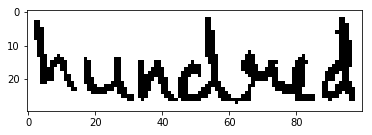

(1, 30, 100, 1)


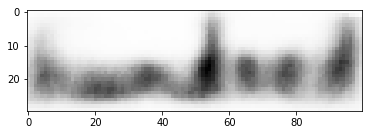

------------------------------End: test------------------------------
Cheque 309101thre2_4.tif Hundred
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.15186656 0.07646409 0.04384559 0.12280181 0.16552824 0.25318542
  0.02596386 0.17168774 0.443442   0.03737272 0.09683128 0.11125423
  0.03768885 0.13984771 0.05714587 0.03387837 0.16802746 0.9855411
  0.1392237  0.02707843 0.04716849 0.426901   0.24190138 0.01191097
  0.0098368  0.04609187 0.0263247  0.01584288 0.08726802 0.00868502
  0.93077123 0.19731495 0.04390996]]
[17]
17
['Seventy']


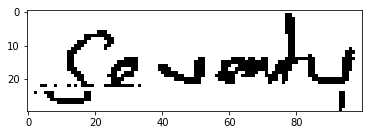

(1, 30, 100, 1)


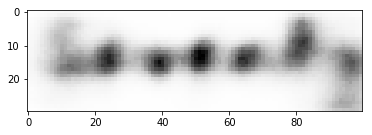

------------------------------End: test------------------------------
Cheque 309102thre2_0.tif Seventy
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05144493 0.0528092  0.02326769 0.07996858 0.07274411 0.10227823
  0.00841917 0.0706945  0.02393107 0.00532    0.11984595 0.15632305
  0.05392554 0.1634095  0.09849708 0.09826186 0.13523358 0.13075694
  0.07930142 0.0878752  0.05525136 0.13234253 0.06950158 0.06166256
  0.01037602 0.99372536 0.00874188 0.11635985 0.02459962 0.15185356
  0.01734916 0.05425617 0.0262045 ]]
[25]
25
['Lakh']


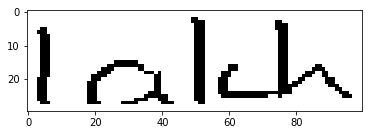

(1, 30, 100, 1)


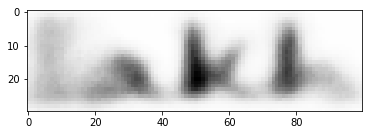

------------------------------End: test------------------------------
Cheque 309102thre2_2.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00687663 0.06879839 0.01855414 0.6805826  0.45658636 0.0243277
  0.2785343  0.06349833 0.04213728 0.08119727 0.08771052 0.05192373
  0.01512044 0.08049417 0.03436498 0.9780167  0.12892537 0.0393712
  0.29821372 0.1381525  0.13627967 0.04448429 0.03025239 0.11351717
  0.01205156 0.01733349 0.02053967 0.02456076 0.08716799 0.0250884
  0.17089546 0.02651924 0.05616458]]
[15]
15
['Fifty']


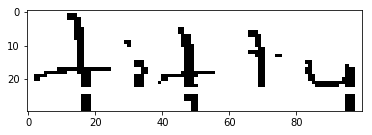

(1, 30, 100, 1)


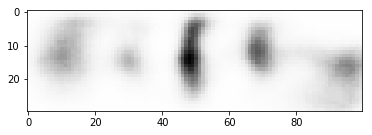

------------------------------End: test------------------------------
Cheque 309102thre2_3.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03153818 0.06381088 0.16421264 0.05957635 0.03450465 0.1699848
  0.11087471 0.15051101 0.03123627 0.04329446 0.07483239 0.01679667
  0.2227292  0.03272146 0.09192958 0.10287126 0.19047897 0.07168284
  0.00143458 0.01249957 0.04776779 0.01676178 0.06660364 0.21253675
  0.9918846  0.01524604 0.02954726 0.018302   0.11195296 0.00916514
  0.035597   0.06627429 0.00646186]]
[24]
24
['Thousand']


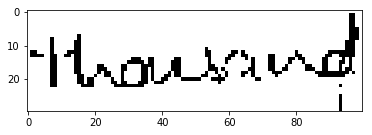

(1, 30, 100, 1)


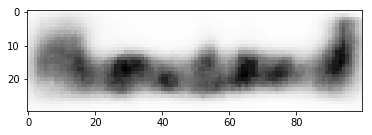

------------------------------End: test------------------------------
Cheque 309102thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05024112 0.12846546 0.22473034 0.07727396 0.05414451 0.13404934
  0.06023004 0.11289221 0.01177565 0.0372516  0.06074    0.98341846
  0.07066499 0.16955554 0.03399922 0.03000402 0.04998231 0.20216048
  0.02868646 0.02095471 0.2722223  0.08015878 0.1854022  0.05118611
  0.022921   0.01035616 0.04632336 0.03232618 0.04061349 0.02363144
  0.03798513 0.00775675 0.0257152 ]]
[11]
11
['Two']


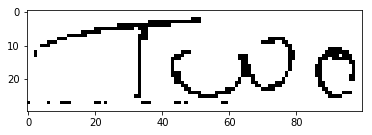

(1, 30, 100, 1)


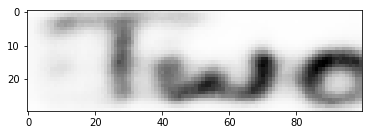

------------------------------End: test------------------------------
Cheque 309103thre2_0.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02391178 0.04489041 0.02030798 0.00419063 0.05676137 0.16915925
  0.0455262  0.01910741 0.01971717 0.0312808  0.01499808 0.7922236
  0.04121747 0.0577124  0.05398909 0.06622737 0.08376067 0.05987925
  0.03155414 0.01175364 0.04545082 0.07447784 0.05995326 0.08354405
  0.31043002 0.21217287 0.2270616  0.14861234 0.04452972 0.13034065
  0.06165521 0.04900312 0.01240415]]
[11]
11
['Two']


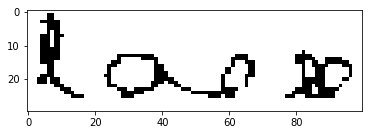

(1, 30, 100, 1)


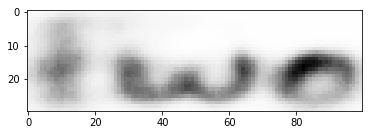

------------------------------End: test------------------------------
Cheque 309103thre2_1.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04589238 0.02803282 0.16553372 0.05662639 0.7441966  0.01388721
  0.05746302 0.14759177 0.09086209 0.03656873 0.06471148 0.6453691
  0.06085446 0.9832341  0.03582067 0.02934134 0.4220226  0.32378405
  0.08198524 0.01040358 0.02408034 0.21675248 0.16380627 0.01798428
  0.03325173 0.03815978 0.04015578 0.03316272 0.1395305  0.0040649
  0.03006138 0.09560627 0.06185983]]
[13]
13
['Thirty']


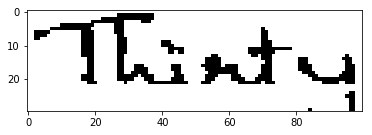

(1, 30, 100, 1)


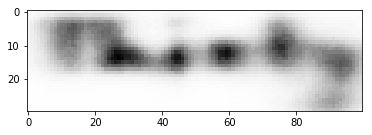

------------------------------End: test------------------------------
Cheque 309103thre2_2.tif Thirty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.43170214 0.08949056 0.00980345 0.00716568 0.03238698 0.03507742
  0.02250299 0.0344342  0.01523295 0.03534325 0.05338999 0.06970629
  0.04634421 0.04883574 0.06647637 0.1232443  0.06371183 0.01430158
  0.03646219 0.00647613 0.05612    0.04154829 0.20944852 0.11198846
  0.00899627 0.03688537 0.04686332 0.02989206 0.99310476 0.02467938
  0.04541744 0.10634824 0.02979849]]
[28]
28
['Five']


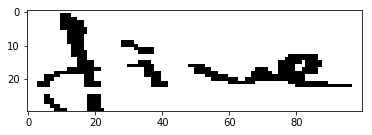

(1, 30, 100, 1)


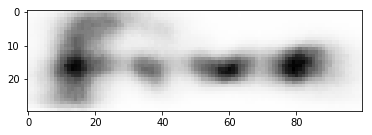

------------------------------End: test------------------------------
Cheque 309103thre2_3.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02822629 0.05042293 0.01205171 0.03455264 0.27386844 0.5496512
  0.10985602 0.02359333 0.02420375 0.01669563 0.17888555 0.04148367
  0.02072737 0.09980542 0.23986952 0.19462495 0.03948115 0.04136916
  0.03367859 0.00955058 0.04111586 0.00161328 0.0338897  0.0375907
  0.9951972  0.0368374  0.09649806 0.09319652 0.02182812 0.01772884
  0.13368447 0.04290016 0.04934155]]
[24]
24
['Thousand']


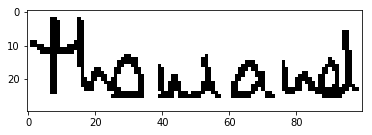

(1, 30, 100, 1)


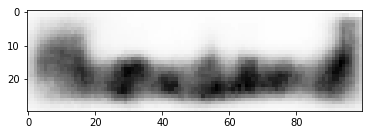

------------------------------End: test------------------------------
Cheque 309103thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0317525  0.06304608 0.18082245 0.15675123 0.01219724 0.06392454
  0.03885471 0.02513431 0.05000885 0.32103115 0.03767497 0.05335444
  0.03296675 0.11842548 0.0699247  0.04777566 0.06349976 0.09679072
  0.8181711  0.0223583  0.08875317 0.06422987 0.09006073 0.04995488
  0.11134584 0.11152712 0.0349117  0.7865084  0.05847744 0.04252439
  0.09411376 0.9814847  0.09378069]]
[31]
31
['Eight']


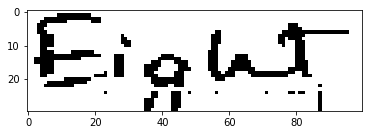

(1, 30, 100, 1)


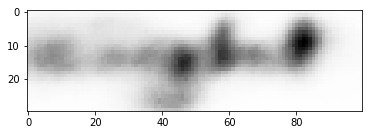

------------------------------End: test------------------------------
Cheque 309103thre2_5.tif Eight
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0926565  0.24234125 0.11360141 0.18035299 0.20303787 0.04209223
  0.35066044 0.07872227 0.08609704 0.01523963 0.370715   0.832919
  0.04139559 0.12180986 0.18133812 0.14495634 0.07464436 0.10094697
  0.1346164  0.02589387 0.03914033 0.06804008 0.10396341 0.9936396
  0.05375541 0.11068694 0.03631167 0.06135042 0.21823864 0.08421982
  0.06818892 0.06179353 0.12702636]]
[23]
23
['Hundred']


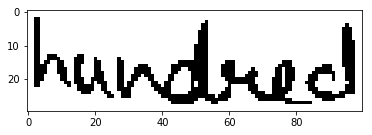

(1, 30, 100, 1)


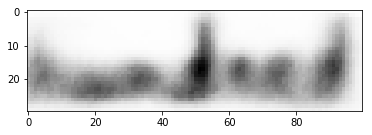

------------------------------End: test------------------------------
Cheque 309103thre2_6.tif Hundred
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.98797756 0.150003   0.04856592 0.03751985 0.01403628 0.12739593
  0.01095252 0.01628174 0.01858351 0.03925061 0.08199559 0.11645512
  0.02582897 0.02077403 0.02939248 0.07423527 0.07539351 0.05900661
  0.09992044 0.06368075 0.02890465 0.11984485 0.20155105 0.05775075
  0.01698116 0.04050096 0.30209583 0.02130015 0.06805327 0.05008658
  0.0385786  0.10198507 0.45486978]]
[0]
0
['One']


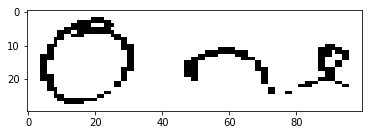

(1, 30, 100, 1)


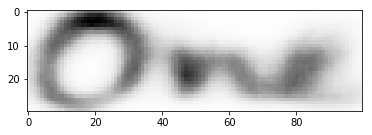

------------------------------End: test------------------------------
Cheque 309104thre2_0.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05626157 0.00559282 0.06089235 0.02645952 0.17277619 0.01859848
  0.04081662 0.15711555 0.08065367 0.00965622 0.25196645 0.16193083
  0.02315165 0.00539462 0.01915342 0.05612706 0.06222505 0.08118513
  0.01363659 0.01127326 0.06600562 0.04935381 0.05639928 0.02038867
  0.00608522 0.57701355 0.1928007  0.06097749 0.03087864 0.04211846
  0.6024055  0.00661439 0.7803951 ]]
[32]
32
['Nine']


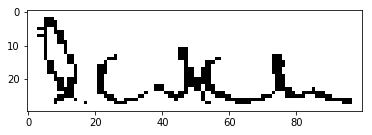

(1, 30, 100, 1)


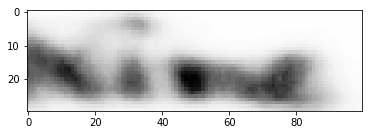

------------------------------End: test------------------------------
Cheque 309104thre2_1.tif Nine
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.13771719 0.01638246 0.07333714 0.00681644 0.00315912 0.01737918
  0.15097815 0.29839462 0.01421867 0.01663353 0.03581992 0.02258336
  0.00528213 0.01970905 0.03701654 0.8513857  0.01493714 0.1667684
  0.86830825 0.15845937 0.12297344 0.06716181 0.08549652 0.06687056
  0.01067311 0.27326843 0.09434565 0.12229707 0.05641348 0.03990398
  0.010804   0.1548107  0.04452398]]
[18]
18
['Eighty']


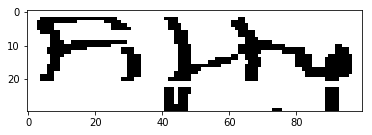

(1, 30, 100, 1)


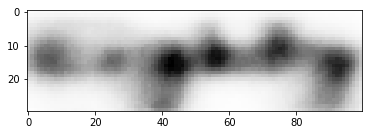

------------------------------End: test------------------------------
Cheque 309104thre2_2.tif Eighty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.13315031 0.02346479 0.00298898 0.0860434  0.11786503 0.06234013
  0.1340784  0.0357789  0.10813826 0.03237187 0.22798252 0.19945692
  0.00865367 0.04165802 0.03015044 0.08494662 0.12072934 0.02708281
  0.03377742 0.07089503 0.02769777 0.0797167  0.05017102 0.02270165
  0.09461325 0.03638669 0.08057293 0.05253357 0.06525706 0.01915156
  0.3585793  0.01478976 0.99613434]]
[32]
32
['Nine']


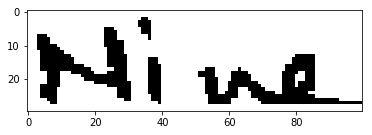

(1, 30, 100, 1)


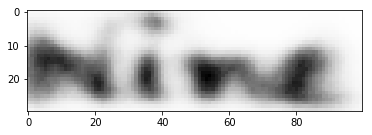

------------------------------End: test------------------------------
Cheque 309104thre2_3.tif Nine
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.17030844 0.17621538 0.05100124 0.02514318 0.20532495 0.04910584
  0.0333208  0.14665909 0.0198484  0.03040317 0.07764976 0.061055
  0.05079922 0.03817995 0.03519255 0.1582931  0.10503647 0.04114942
  0.00205719 0.0141577  0.07954229 0.02039009 0.01048244 0.08175968
  0.99571955 0.02390876 0.07457446 0.03015848 0.16770416 0.08782496
  0.0413012  0.03630156 0.05756621]]
[24]
24
['Thousand']


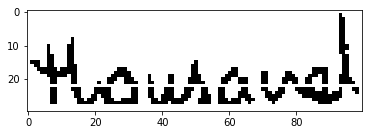

(1, 30, 100, 1)


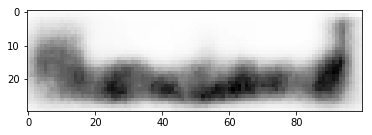

------------------------------End: test------------------------------
Cheque 309104thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02917762 0.02973494 0.00662596 0.15586212 0.02160518 0.03792556
  0.07910065 0.05758991 0.01366703 0.02101108 0.00755823 0.18205883
  0.01932485 0.16803254 0.9916161  0.31266668 0.04982545 0.01265878
  0.02050362 0.02108583 0.05446135 0.06663987 0.14047526 0.03760521
  0.04399957 0.00508199 0.06381495 0.5515864  0.01323966 0.04554926
  0.21056385 0.00259504 0.02691713]]
[14]
14
['Forty']


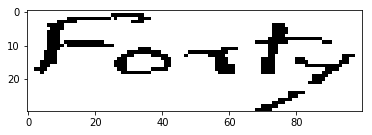

(1, 30, 100, 1)


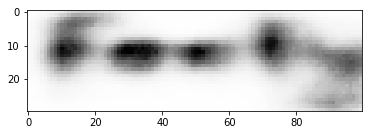

------------------------------End: test------------------------------
Cheque 309105thre2_0.tif Forty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05189594 0.04983448 0.03111939 0.01528876 0.02029869 0.01956455
  0.02390295 0.11513051 0.02645324 0.00400998 0.03339113 0.9797488
  0.12419103 0.03067556 0.02637912 0.03028492 0.03545    0.05920867
  0.15695105 0.02743362 0.02799649 0.01601325 0.08560906 0.01964658
  0.06780871 0.12820995 0.02089925 0.16238606 0.12288146 0.0469207
  0.08323111 0.2132088  0.02819972]]
[11]
11
['Two']


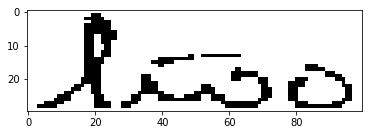

(1, 30, 100, 1)


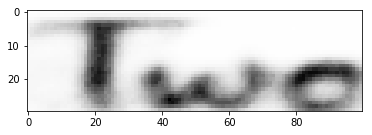

------------------------------End: test------------------------------
Cheque 309105thre2_1.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0063417  0.1873251  0.444554   0.09830709 0.0083364  0.06584697
  0.01465514 0.06254575 0.0429607  0.00530742 0.02019623 0.06002455
  0.01987528 0.01338011 0.00758341 0.09141562 0.06854945 0.07354125
  0.03896596 0.14061171 0.04135673 0.02806344 0.01415082 0.01598979
  0.00395561 0.9423661  0.01587263 0.15393345 0.0472227  0.06078704
  0.4344907  0.03118618 0.12541397]]
[25]
25
['Lakh']


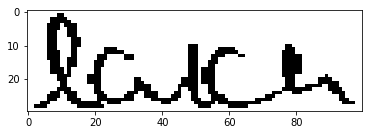

(1, 30, 100, 1)


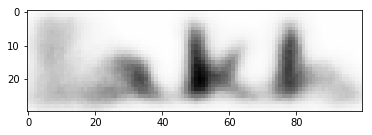

------------------------------End: test------------------------------
Cheque 309105thre2_2.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01212468 0.08536749 0.13468575 0.07540439 0.00242515 0.02519145
  0.07254405 0.00609192 0.09006269 0.02666367 0.03025561 0.32910615
  0.9627062  0.09388962 0.0793401  0.06923845 0.00600778 0.02868862
  0.04197514 0.07481624 0.10315019 0.02467822 0.03479299 0.46682587
  0.39829922 0.04567793 0.19154659 0.26337397 0.02184459 0.04867085
  0.01290182 0.02063522 0.02802682]]
[12]
12
['Twenty']


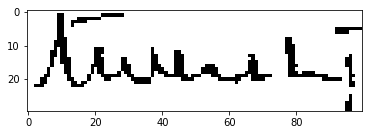

(1, 30, 100, 1)


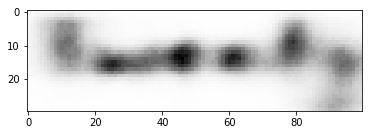

------------------------------End: test------------------------------
Cheque 309105thre2_3.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.18566498 0.06022086 0.01219058 0.02620664 0.04711147 0.07429666
  0.0215451  0.00650358 0.09233216 0.03018257 0.01375608 0.03850702
  0.00834494 0.04924083 0.09765303 0.30570155 0.18605913 0.0596105
  0.2963809  0.16165066 0.00484028 0.03714022 0.2208578  0.03584353
  0.9958454  0.05523339 0.22681774 0.69560736 0.07623614 0.10437702
  0.0108685  0.04754637 0.00765507]]
[24]
24
['Thousand']


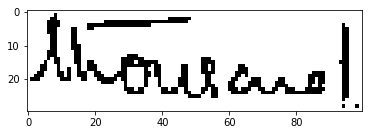

(1, 30, 100, 1)


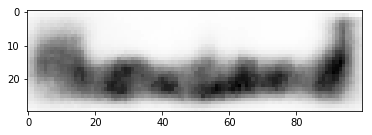

------------------------------End: test------------------------------
Cheque 309105thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.9932564  0.02107761 0.03070997 0.05774196 0.04555443 0.06628998
  0.11557512 0.0490653  0.01048806 0.01823534 0.0121301  0.03906838
  0.00471985 0.08741288 0.01535669 0.34450543 0.11960147 0.03396778
  0.01984231 0.36956102 0.09679584 0.03569873 0.13965188 0.07156718
  0.01084242 0.13089226 0.12917234 0.05462028 0.06105494 0.05090136
  0.14612582 0.04408653 0.03534071]]
[0]
0
['One']


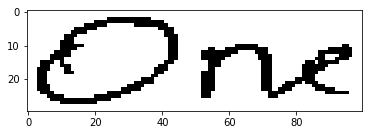

(1, 30, 100, 1)


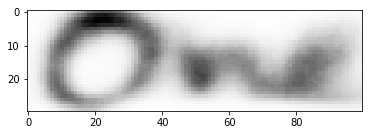

------------------------------End: test------------------------------
Cheque 309106thre2_0.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00604197 0.11938571 0.07175724 0.02671243 0.2136237  0.01289274
  0.01556643 0.4237159  0.13875288 0.1404493  0.04358215 0.08000302
  0.0187354  0.11987199 0.05361113 0.05687972 0.08269987 0.48113912
  0.05219481 0.07656804 0.00470045 0.24210863 0.02773872 0.05428744
  0.02575058 0.02292555 0.9772566  0.07098337 0.064394   0.05123984
  0.02552024 0.12455998 0.04599771]]
[26]
26
['Crore']


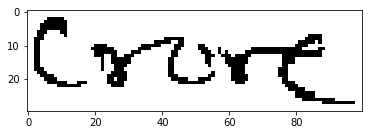

(1, 30, 100, 1)


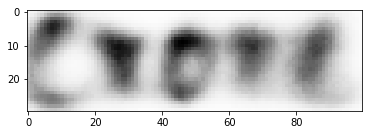

------------------------------End: test------------------------------
Cheque 309106thre2_1.tif Crore
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03200134 0.05416404 0.38399822 0.09229324 0.0260867  0.02014626
  0.09512401 0.12696876 0.05283741 0.04546287 0.1107187  0.45010436
  0.822042   0.5145922  0.00858989 0.01292789 0.025195   0.21014817
  0.12088075 0.02463625 0.01929302 0.00290607 0.14778662 0.11219368
  0.23597975 0.07196578 0.06397317 0.1584786  0.05328097 0.06214742
  0.04373449 0.01386828 0.26134738]]
[12]
12
['Twenty']


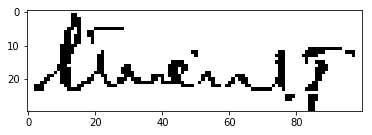

(1, 30, 100, 1)


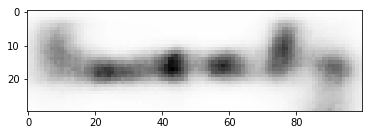

------------------------------End: test------------------------------
Cheque 309106thre2_2.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03226437 0.15038566 0.0094701  0.03416745 0.04817831 0.00194788
  0.03965127 0.05575295 0.03607737 0.02582394 0.03271009 0.18809082
  0.08791797 0.01765896 0.11539746 0.14624439 0.04086943 0.08569762
  0.12710743 0.05177418 0.00827931 0.12951219 0.7743739  0.02670223
  0.0120802  0.05408335 0.01848533 0.07175051 0.69658303 0.27034414
  0.10250079 0.02287764 0.28907207]]
[22]
22
['Three']


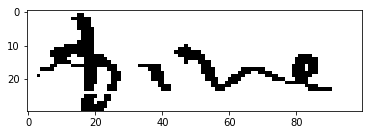

(1, 30, 100, 1)


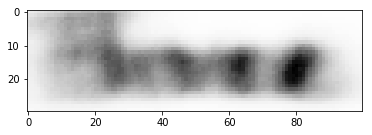

------------------------------End: test------------------------------
Cheque 309106thre2_3.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05787116 0.12528907 0.04113338 0.10871065 0.0544844  0.0278337
  0.16196793 0.29620087 0.02389355 0.3200896  0.03713853 0.0792288
  0.03753868 0.01688475 0.0573921  0.23376162 0.05778693 0.04274261
  0.2532704  0.05581646 0.20231204 0.07247115 0.97284627 0.07356394
  0.02050476 0.3087062  0.05088244 0.15583734 0.08870576 0.20337346
  0.1459581  0.06594885 0.3233937 ]]
[22]
22
['Three']


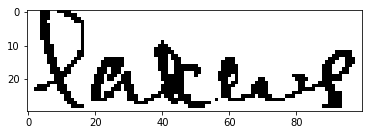

(1, 30, 100, 1)


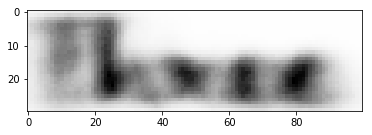

------------------------------End: test------------------------------
Cheque 309106thre2_4.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0038074  0.00811406 0.24116175 0.057606   0.19639648 0.06943793
  0.02985698 0.18764924 0.07198457 0.10654966 0.01370982 0.05681554
  0.12921862 0.15301782 0.0284737  0.03638048 0.8196432  0.980025
  0.02095823 0.08053587 0.04026477 0.09973332 0.25383902 0.03225321
  0.01584595 0.21792413 0.05581593 0.04436506 0.10966913 0.02546737
  0.23680659 0.03480795 0.20249973]]
[17]
17
['Seventy']


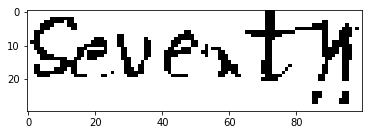

(1, 30, 100, 1)


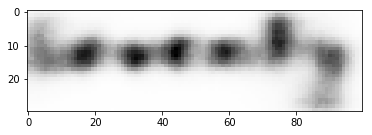

------------------------------End: test------------------------------
Cheque 309107thre2_0.tif Seventy
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.9318754  0.13618408 0.07541315 0.01193369 0.05369802 0.05921704
  0.14634697 0.14747775 0.14462522 0.02716694 0.06206702 0.0126698
  0.00359435 0.00897408 0.03411869 0.00937459 0.01631337 0.01521306
  0.0923055  0.19016922 0.18472426 0.48845685 0.06837536 0.00610211
  0.01765455 0.04316919 0.31560177 0.10760704 0.16628876 0.26301393
  0.16638036 0.05588337 0.0688587 ]]
[0]
0
['One']


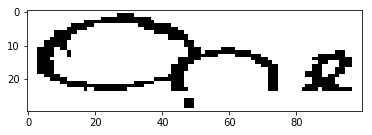

(1, 30, 100, 1)


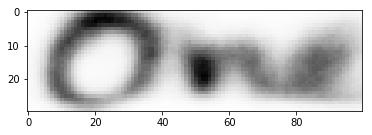

------------------------------End: test------------------------------
Cheque 309107thre2_1.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01890308 0.04894245 0.03022341 0.03916724 0.01441822 0.07228848
  0.06926848 0.06906365 0.00888024 0.17490117 0.02775959 0.01832581
  0.02661273 0.09165041 0.11972253 0.04230707 0.0343055  0.02386804
  0.01323276 0.05999506 0.21979949 0.05702555 0.07036559 0.03286932
  0.02191269 0.5523812  0.07012466 0.1963643  0.00990796 0.01088524
  0.5090118  0.00667052 0.25996226]]
[25]
25
['Lakh']


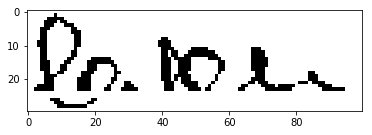

(1, 30, 100, 1)


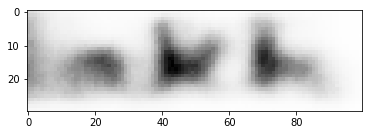

------------------------------End: test------------------------------
Cheque 309107thre2_2.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06369747 0.13860598 0.09938974 0.34931654 0.31887278 0.13802591
  0.19399208 0.03788168 0.12663911 0.18270563 0.18168756 0.3272774
  0.03098757 0.35275596 0.10531296 0.96998966 0.1451895  0.5468611
  0.19620107 0.05157093 0.13141957 0.07997564 0.16832939 0.20569196
  0.00992306 0.23973934 0.09834722 0.1367082  0.06873684 0.12135822
  0.02781917 0.25297198 0.11727953]]
[15]
15
['Fifty']


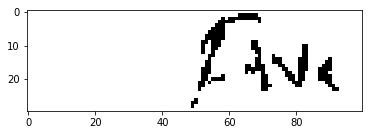

(1, 30, 100, 1)


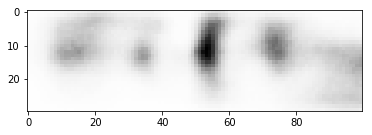

------------------------------End: test------------------------------
Cheque 309108thre2_0.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01925062 0.03732413 0.09940259 0.00649401 0.07676037 0.00160008
  0.01099467 0.02362206 0.13339369 0.02018066 0.00640753 0.09303976
  0.02280554 0.01054853 0.1445826  0.02525648 0.08296172 0.15513223
  0.12499708 0.057267   0.08066877 0.05188251 0.2054683  0.01598209
  0.03038407 0.99134415 0.08354578 0.1608172  0.20204432 0.18349236
  0.06982444 0.07114237 0.06154327]]
[25]
25
['Lakh']


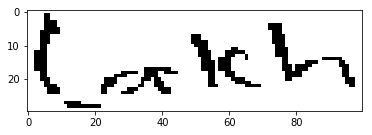

(1, 30, 100, 1)


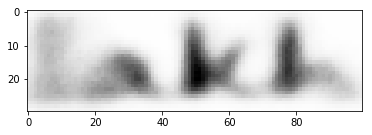

------------------------------End: test------------------------------
Cheque 309108thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07952396 0.03640577 0.65542257 0.07260084 0.12665886 0.02445018
  0.03501782 0.05125519 0.03924479 0.02282113 0.04102838 0.04362844
  0.7263483  0.0378342  0.09298597 0.05433407 0.06960943 0.25055176
  0.07390486 0.03357808 0.03130926 0.04559528 0.00975736 0.05066972
  0.5350429  0.19798318 0.01538436 0.16187337 0.01494448 0.01252138
  0.04156847 0.01370189 0.18257894]]
[12]
12
['Twenty']


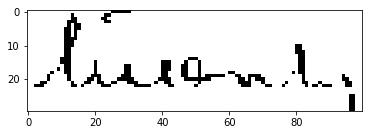

(1, 30, 100, 1)


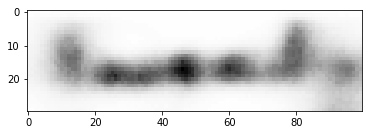

------------------------------End: test------------------------------
Cheque 309108thre2_2.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02349141 0.01359049 0.01963343 0.10486212 0.8607882  0.06677467
  0.02082949 0.01895873 0.03936672 0.02961991 0.02067181 0.08229182
  0.16164114 0.34950072 0.02255582 0.20868742 0.09507906 0.2188185
  0.02440638 0.01513254 0.07549492 0.01175755 0.01204158 0.85842174
  0.85524315 0.03044164 0.07173759 0.09200764 0.05606272 0.02758765
  0.02844579 0.07310085 0.02337811]]
[4]
4
['Thirteen']


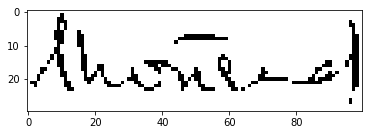

(1, 30, 100, 1)


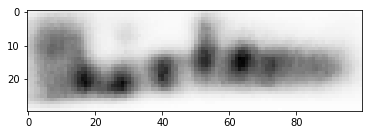

------------------------------End: test------------------------------
Cheque 309108thre2_3.tif Thirteen
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.25594914 0.4091805  0.00932268 0.38363507 0.1334942  0.01835259
  0.35487977 0.19003007 0.47605646 0.05419428 0.08352464 0.6442508
  0.09648294 0.37477162 0.17676239 0.14113845 0.07183534 0.08923958
  0.21313767 0.18089928 0.04703043 0.24440636 0.11555541 0.25540894
  0.13479519 0.5792701  0.047918   0.54269135 0.15118356 0.47374701
  0.09986119 0.3608413  0.24963272]]
[11]
11
['Two']


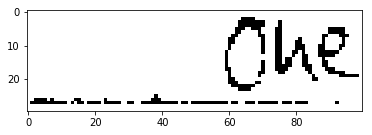

(1, 30, 100, 1)


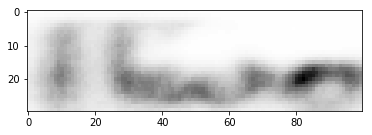

------------------------------End: test------------------------------
Cheque 309109thre2_0.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.13410772 0.02150588 0.03292595 0.12359965 0.01932991 0.02743193
  0.02851797 0.15249622 0.09868807 0.02341208 0.08545826 0.05825893
  0.06305294 0.17560245 0.11374243 0.05181668 0.07454406 0.09224074
  0.02963357 0.15817851 0.01531655 0.04493831 0.09730994 0.06553789
  0.16776304 0.12274531 0.97669905 0.25561374 0.22112964 0.06027463
  0.02677473 0.00475995 0.1425485 ]]
[26]
26
['Crore']


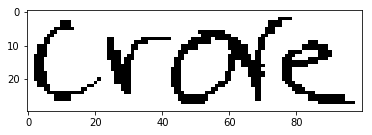

(1, 30, 100, 1)


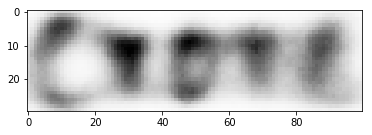

------------------------------End: test------------------------------
Cheque 309109thre2_1.tif Crore
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07889506 0.08782486 0.24730937 0.18751352 0.23020215 0.04231865
  0.05089334 0.10950125 0.08207738 0.02761599 0.07626265 0.15558854
  0.9567179  0.00875942 0.02870341 0.06831963 0.0287399  0.17695367
  0.05036902 0.06506225 0.08354986 0.04217465 0.00878008 0.12433046
  0.5382116  0.05958579 0.23065203 0.09967109 0.07282621 0.06153202
  0.09558502 0.03007638 0.01085503]]
[12]
12
['Twenty']


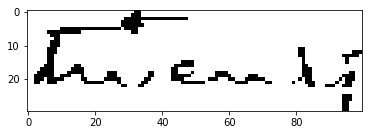

(1, 30, 100, 1)


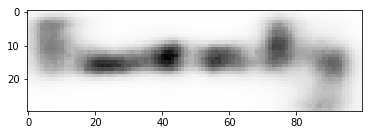

------------------------------End: test------------------------------
Cheque 309109thre2_2.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05013142 0.12162098 0.1183382  0.01960829 0.03203248 0.6306265
  0.00364566 0.03279521 0.04742172 0.01803431 0.13088208 0.3182239
  0.02856733 0.03008967 0.01169469 0.08716906 0.0597337  0.02396727
  0.03395179 0.01317559 0.00528585 0.17086571 0.49119133 0.07187356
  0.04326291 0.02755818 0.03628849 0.05635177 0.6649658  0.04748193
  0.11454047 0.06899144 0.02696997]]
[28]
28
['Five']


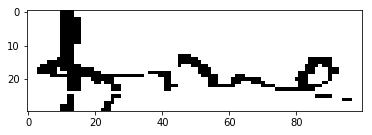

(1, 30, 100, 1)


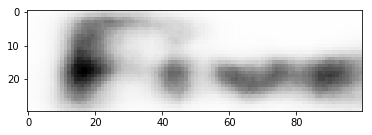

------------------------------End: test------------------------------
Cheque 309109thre2_3.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01965633 0.3506565  0.02429822 0.28014335 0.54548436 0.13207519
  0.13481255 0.10296454 0.05135607 0.26758552 0.07987618 0.10178384
  0.2865865  0.00899969 0.12828274 0.00246077 0.04442456 0.08309136
  0.04903787 0.03834331 0.06221491 0.09509712 0.07314792 0.09935889
  0.6175155  0.1309819  0.24935135 0.13593075 0.7308788  0.10261517
  0.09923954 0.05740141 0.29410085]]
[28]
28
['Five']


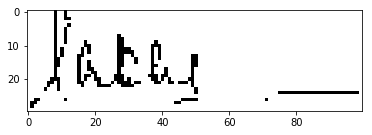

(1, 30, 100, 1)


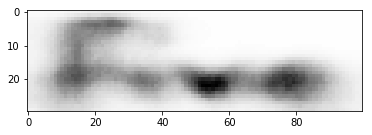

------------------------------End: test------------------------------
Cheque 309109thre2_4.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00557436 0.01527674 0.05198251 0.00708336 0.1179326  0.01734613
  0.9755062  0.03008051 0.31720337 0.02012905 0.02424106 0.07913864
  0.16630039 0.02534597 0.00702607 0.9853351  0.10082495 0.00754227
  0.13064653 0.01353233 0.05918033 0.03636767 0.04501568 0.25500813
  0.10305968 0.03481023 0.08008905 0.04119533 0.05092898 0.00168515
  0.01075849 0.01532633 0.07715736]]
[15]
15
['Fifty']


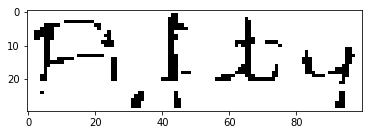

(1, 30, 100, 1)


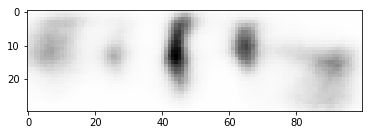

------------------------------End: test------------------------------
Cheque 309110thre2_0.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.90556216 0.02080505 0.08554456 0.05183047 0.02945606 0.02270512
  0.01410139 0.05392584 0.02420195 0.01118378 0.03122916 0.02896279
  0.02526172 0.07272013 0.24356405 0.05323032 0.03153658 0.03432263
  0.12879069 0.09653031 0.3308372  0.04626268 0.8305946  0.0814415
  0.06970242 0.034291   0.03951456 0.47508496 0.71653867 0.11664672
  0.10124943 0.0695902  0.18908793]]
[0]
0
['One']


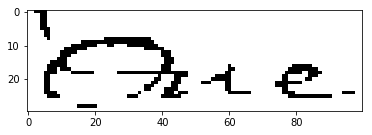

(1, 30, 100, 1)


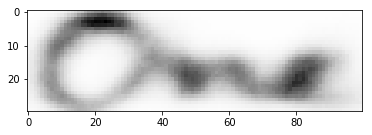

------------------------------End: test------------------------------
Cheque 309110thre2_1.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05339829 0.03609896 0.47183597 0.1278037  0.01079777 0.05471121
  0.21218215 0.02035427 0.27958578 0.2880988  0.10882395 0.0736379
  0.07556304 0.23213604 0.02328196 0.1252648  0.06541321 0.03556982
  0.03201659 0.06928666 0.04512566 0.05435199 0.94568473 0.40088114
  0.92999    0.13694045 0.06319591 0.39474568 0.01421779 0.04004858
  0.12919848 0.10624664 0.06062007]]
[22]
22
['Three']


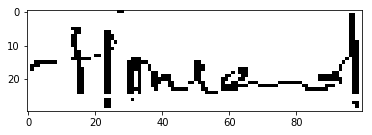

(1, 30, 100, 1)


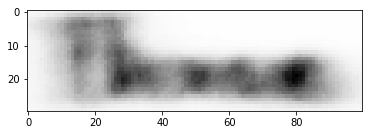

------------------------------End: test------------------------------
Cheque 309110thre2_2.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03176985 0.28622335 0.14788719 0.0902158  0.14778501 0.09996726
  0.05282779 0.12957746 0.06606232 0.15681702 0.0199041  0.92438895
  0.00951422 0.18810032 0.09973758 0.05131783 0.08818068 0.17128715
  0.03315823 0.01685903 0.11240615 0.02613389 0.18466364 0.00994114
  0.01207634 0.00796191 0.0498208  0.27820656 0.07103951 0.03279894
  0.04248375 0.05147176 0.00943882]]
[11]
11
['Two']


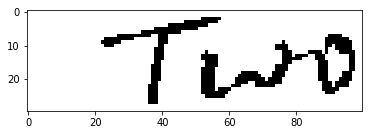

(1, 30, 100, 1)


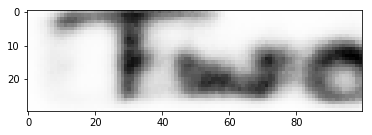

------------------------------End: test------------------------------
Cheque 309111thre2_0.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.09143892 0.07813841 0.00717995 0.0103361  0.06388923 0.01975795
  0.09239659 0.09689564 0.03330449 0.02627013 0.09152782 0.08756707
  0.03104607 0.14931521 0.03114264 0.01039614 0.06456092 0.08725186
  0.04652308 0.04893466 0.05364383 0.1044782  0.9332486  0.26214042
  0.1979314  0.08012831 0.8130704  0.01555263 0.03353415 0.03152504
  0.05012343 0.03336192 0.42084202]]
[22]
22
['Three']


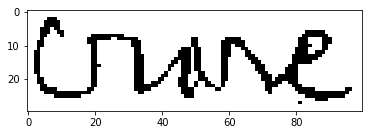

(1, 30, 100, 1)


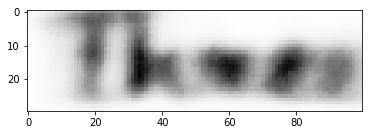

------------------------------End: test------------------------------
Cheque 309111thre2_1.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02133178 0.03648591 0.00925776 0.00469567 0.71043026 0.15923572
  0.3662574  0.04114277 0.01877497 0.04334211 0.03307446 0.1170531
  0.33325946 0.04325878 0.04446138 0.8330089  0.07139857 0.14038976
  0.02356176 0.02419163 0.6329004  0.07797457 0.04337484 0.1746236
  0.10292187 0.08842777 0.11694987 0.17963903 0.81193495 0.02471642
  0.040831   0.31399554 0.16446202]]
[15]
15
['Fifty']


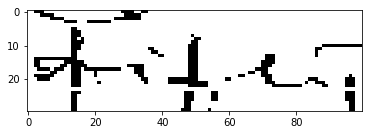

(1, 30, 100, 1)


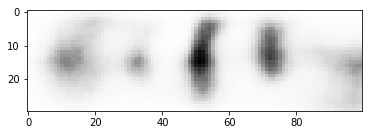

------------------------------End: test------------------------------
Cheque 309111thre2_2.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01467084 0.02692772 0.04494096 0.22888686 0.02668992 0.00991629
  0.05245161 0.0279989  0.01702634 0.1968704  0.05179105 0.09838216
  0.06032683 0.51903325 0.04978092 0.1624506  0.04274963 0.03237265
  0.03049869 0.00925387 0.14574559 0.01159772 0.03316543 0.00845799
  0.01824463 0.50013983 0.04886188 0.08945213 0.13191836 0.0118959
  0.06962183 0.05937397 0.14122005]]
[13]
13
['Thirty']


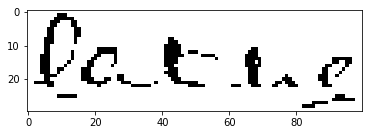

(1, 30, 100, 1)


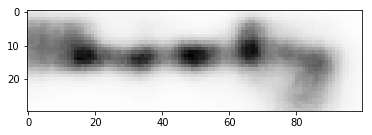

------------------------------End: test------------------------------
Cheque 309111thre2_3.tif Thirty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05437632 0.14427064 0.03288532 0.01019724 0.17031796 0.05288247
  0.01945645 0.01044052 0.00265688 0.05085641 0.04012655 0.06491133
  0.01234561 0.00543453 0.1909114  0.10201447 0.9859191  0.09459417
  0.01328818 0.007984   0.01181327 0.09880511 0.22241913 0.05756661
  0.07043151 0.04898441 0.04761846 0.07929757 0.01454688 0.14712878
  0.05041681 0.02963231 0.12776326]]
[16]
16
['Sixty']


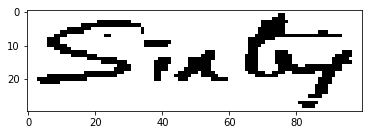

(1, 30, 100, 1)


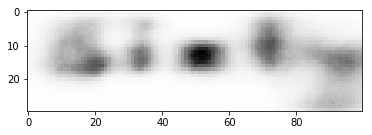

------------------------------End: test------------------------------
Cheque 309112thre2_0.tif Sixty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.15713674 0.15939096 0.09344023 0.14741571 0.12888439 0.03440806
  0.07983457 0.67206365 0.05968134 0.00991429 0.01578464 0.9723184
  0.22125836 0.6759911  0.03283544 0.10346037 0.24915837 0.06442481
  0.08437505 0.04992555 0.03786325 0.10034169 0.03181215 0.02640483
  0.08662025 0.05161147 0.07858308 0.04880413 0.19894168 0.09010879
  0.06353381 0.185095   0.63685274]]
[11]
11
['Two']


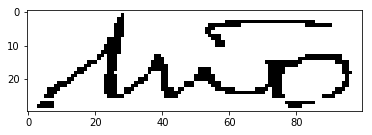

(1, 30, 100, 1)


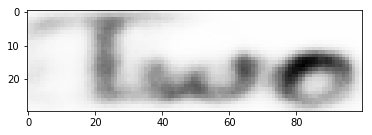

------------------------------End: test------------------------------
Cheque 309112thre2_1.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0486262  0.0294493  0.14983776 0.13324495 0.0209973  0.007701
  0.05048677 0.1559777  0.01549729 0.04014689 0.25750744 0.03421666
  0.00825907 0.0275588  0.05520285 0.02329202 0.2318309  0.11156259
  0.0288392  0.03645786 0.12539463 0.1628603  0.35205334 0.8201983
  0.01057017 0.02136448 0.93767595 0.02931169 0.01843489 0.06033367
  0.159775   0.02424143 0.03413378]]
[26]
26
['Crore']


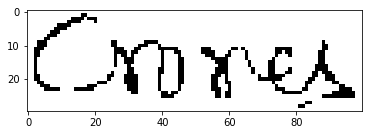

(1, 30, 100, 1)


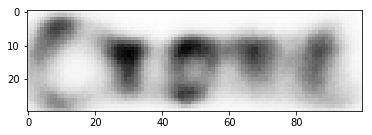

------------------------------End: test------------------------------
Cheque 309112thre2_2.tif Crore
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.15512156 0.03008939 0.0463338  0.90896523 0.4496444  0.07730025
  0.08060913 0.18025261 0.02475009 0.01527947 0.0341328  0.26118684
  0.3687687  0.45532423 0.09668908 0.0504591  0.04461795 0.05585535
  0.04224885 0.00536434 0.06104095 0.09878902 0.15122406 0.9879565
  0.10361421 0.21694788 0.04065031 0.0755338  0.01423885 0.16709693
  0.0358762  0.20095615 0.08330467]]
[23]
23
['Hundred']


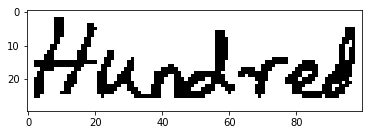

(1, 30, 100, 1)


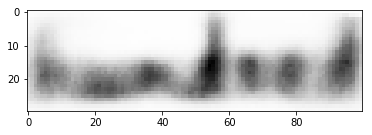

------------------------------End: test------------------------------
Cheque 309113thre2_0.tif Hundred
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.10488872 0.95994216 0.08953691 0.02786886 0.02289735 0.04580845
  0.07525444 0.23222366 0.07975467 0.01815636 0.1992312  0.14741434
  0.01398707 0.01848709 0.1892903  0.02761716 0.08802887 0.07116295
  0.12136687 0.08465774 0.01271044 0.09146717 0.1670856  0.05703124
  0.03484801 0.1307649  0.03435437 0.39314777 0.03843966 0.50170654
  0.03670589 0.0212536  0.0417432 ]]
[1]
1
['Ten']


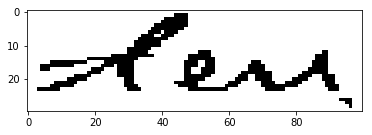

(1, 30, 100, 1)


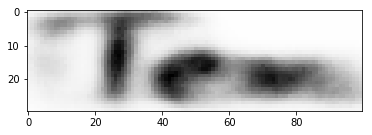

------------------------------End: test------------------------------
Cheque 309113thre2_1.tif Ten
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06266355 0.13421834 0.23920959 0.02142091 0.04302698 0.03147025
  0.04674879 0.06685457 0.0150538  0.02957792 0.00777482 0.0267336
  0.04269295 0.2599867  0.2585356  0.16104284 0.07619257 0.01704097
  0.2192425  0.16216101 0.07738412 0.2854273  0.62924474 0.16262251
  0.01979465 0.09696466 0.8502376  0.04184256 0.04793648 0.10505353
  0.00406101 0.06761416 0.13135737]]
[26]
26
['Crore']


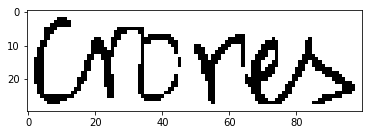

(1, 30, 100, 1)


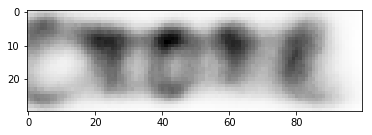

------------------------------End: test------------------------------
Cheque 309113thre2_2.tif Crore
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02315257 0.17367247 0.6636244  0.04638483 0.16051856 0.02281584
  0.07284512 0.05021586 0.03520108 0.0422549  0.09032868 0.24549414
  0.17636186 0.03097804 0.08384988 0.01810895 0.12472779 0.02726517
  0.10792451 0.02421908 0.2378254  0.01783748 0.00518341 0.05097708
  0.4632257  0.02575751 0.05047115 0.333496   0.01457138 0.02690524
  0.02676299 0.11239751 0.03549412]]
[2]
2
['Eleven']


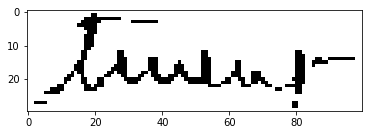

(1, 30, 100, 1)


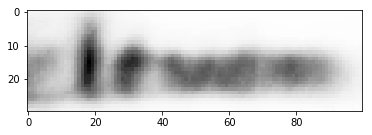

------------------------------End: test------------------------------
Cheque 309114thre2_0.tif Eleven
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05385567 0.03259867 0.0634409  0.02116288 0.09877401 0.00885397
  0.09102383 0.05994308 0.03515216 0.02393654 0.23817627 0.02149002
  0.10745931 0.02971183 0.0230868  0.02460703 0.12663077 0.10118362
  0.11273549 0.14666036 0.09768585 0.12112863 0.445253   0.1971594
  0.00895815 0.03754173 0.7400793  0.08396529 0.00934262 0.14944394
  0.05199765 0.05351995 0.11717388]]
[26]
26
['Crore']


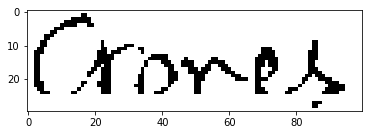

(1, 30, 100, 1)


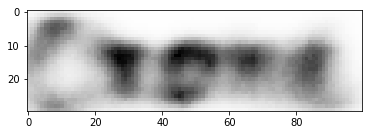

------------------------------End: test------------------------------
Cheque 309114thre2_1.tif Crore
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.9915639  0.02517649 0.00421284 0.0244214  0.07081493 0.02307505
  0.10471795 0.03033251 0.02649113 0.01621937 0.04547187 0.03684155
  0.14809333 0.07851736 0.05415718 0.07539014 0.07530572 0.08161603
  0.05675435 0.01620282 0.0072456  0.07449649 0.06426713 0.01485246
  0.0473207  0.04186356 0.02308386 0.01899259 0.10624596 0.05675158
  0.27412254 0.14527868 0.05310415]]
[0]
0
['One']


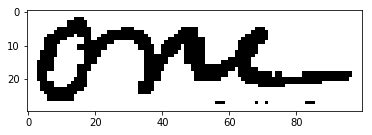

(1, 30, 100, 1)


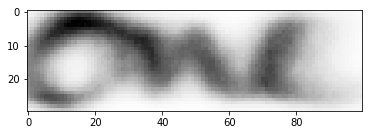

------------------------------End: test------------------------------
Cheque 309115thre2_0.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.72359693 0.2367866  0.30987993 0.25400373 0.43999213 0.3378436
  0.89573044 0.30016372 0.05191277 0.2489073  0.11582946 0.02712464
  0.01878958 0.01671947 0.07819436 0.9481955  0.23036064 0.17656995
  0.10141487 0.0140485  0.21340354 0.08039994 0.1457815  0.0579905
  0.1888616  0.41192994 0.02703042 0.7385166  0.04674998 0.1594494
  0.4336407  0.07364675 0.13897353]]
[15]
15
['Fifty']


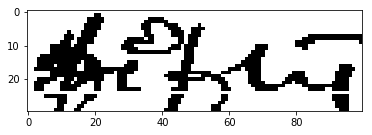

(1, 30, 100, 1)


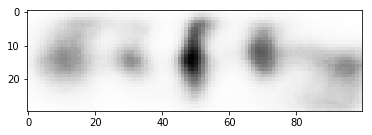

------------------------------End: test------------------------------
Cheque 309115thre2_1.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.1242127  0.01859029 0.04230596 0.10383126 0.30359462 0.07298683
  0.1709602  0.00656439 0.01633742 0.05914271 0.02832432 0.0835496
  0.01256719 0.02969515 0.02185764 0.04030223 0.04647934 0.02824438
  0.01256233 0.02225907 0.12698025 0.01739787 0.7930119  0.07973436
  0.06097718 0.58189183 0.04873341 0.0683137  0.10374643 0.02905608
  0.13733287 0.07525489 0.18799204]]
[22]
22
['Three']


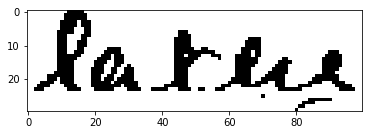

(1, 30, 100, 1)


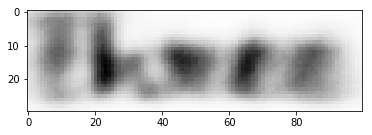

------------------------------End: test------------------------------
Cheque 309115thre2_2.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.85990995 0.14317463 0.02545557 0.01372851 0.02782448 0.08131403
  0.02382067 0.11701    0.08806489 0.01353482 0.00462526 0.82881975
  0.05078507 0.23144579 0.00904748 0.2935258  0.0552745  0.10382065
  0.00670113 0.02459754 0.04130343 0.05553911 0.33209682 0.1113499
  0.04071377 0.08074918 0.18622674 0.29866153 0.63978904 0.10333615
  0.05023093 0.0800088  0.38644564]]
[0]
0
['One']


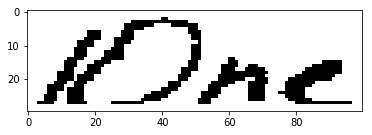

(1, 30, 100, 1)


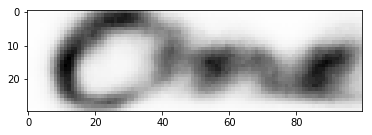

------------------------------End: test------------------------------
Cheque 309116thre2_0.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.16588116 0.03584043 0.0236615  0.05376182 0.06297534 0.12133798
  0.04254937 0.04794256 0.01091944 0.01751444 0.012929   0.1711399
  0.04738227 0.11293678 0.04000111 0.11555535 0.02817653 0.02033196
  0.03656372 0.0121832  0.01390698 0.0451598  0.01335079 0.36130697
  0.04501146 0.97661054 0.3602874  0.06859022 0.04927375 0.0619701
  0.06130064 0.01354221 0.04993106]]
[25]
25
['Lakh']


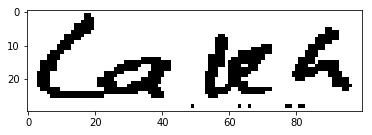

(1, 30, 100, 1)


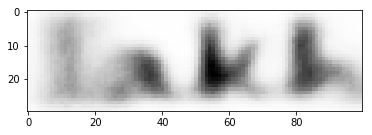

------------------------------End: test------------------------------
Cheque 309116thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02900942 0.10423264 0.03378252 0.02425467 0.05799478 0.41049796
  0.01094457 0.07542852 0.0326646  0.13000925 0.156139   0.05031069
  0.16450621 0.05545432 0.48533675 0.15195695 0.16467872 0.07017062
  0.01287861 0.14241944 0.00605634 0.08399445 0.03190187 0.04539715
  0.03944499 0.064206   0.13162667 0.09040113 0.89244235 0.06180237
  0.13089964 0.0467708  0.05300668]]
[28]
28
['Five']


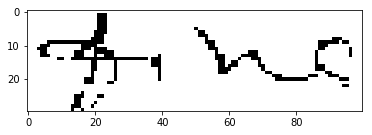

(1, 30, 100, 1)


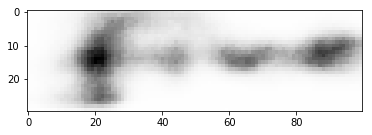

------------------------------End: test------------------------------
Cheque 309116thre2_2.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.22182742 0.23807156 0.3180319  0.03950581 0.10444665 0.1826256
  0.00518206 0.4080932  0.02314731 0.01030883 0.11083114 0.9794914
  0.03885281 0.04956517 0.18336    0.17232472 0.12976848 0.02315081
  0.04806359 0.276335   0.17597727 0.03966062 0.10906509 0.15678026
  0.0485604  0.02390747 0.38121215 0.5265373  0.17190628 0.19307889
  0.07261973 0.03412308 0.3600625 ]]
[11]
11
['Two']


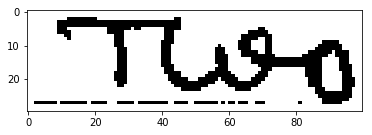

(1, 30, 100, 1)


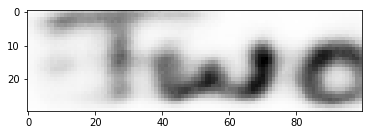

------------------------------End: test------------------------------
Cheque 309117thre2_0.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04362099 0.30835208 0.05368285 0.0141558  0.00402637 0.04602879
  0.01107952 0.0433225  0.06203865 0.08154961 0.18858793 0.30101457
  0.02079776 0.07206923 0.03194119 0.03878462 0.1235103  0.04636196
  0.04982846 0.00234277 0.03225759 0.07868182 0.06890766 0.1334872
  0.02224011 0.9650937  0.2906622  0.03906481 0.06023857 0.03418672
  0.5354435  0.04255456 0.01784252]]
[25]
25
['Lakh']


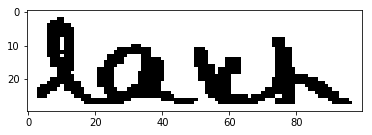

(1, 30, 100, 1)


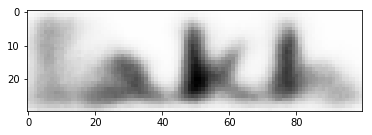

------------------------------End: test------------------------------
Cheque 309117thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.09849246 0.03011253 0.13920353 0.14724278 0.05489584 0.29222772
  0.626298   0.08923408 0.00743078 0.013604   0.0492991  0.18075037
  0.07115482 0.03568727 0.01890664 0.9564746  0.04437426 0.18934308
  0.02603434 0.01962065 0.00273068 0.03870496 0.05601183 0.00803679
  0.0366703  0.03899027 0.03947364 0.44782364 0.3374183  0.04039778
  0.10813648 0.7487843  0.12777932]]
[15]
15
['Fifty']


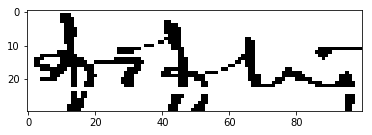

(1, 30, 100, 1)


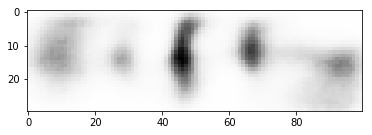

------------------------------End: test------------------------------
Cheque 309117thre2_2.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04306593 0.02200856 0.03753747 0.06723266 0.02888553 0.07335814
  0.00888102 0.00613374 0.07328266 0.06974255 0.02281537 0.15785637
  0.18642733 0.1405992  0.00753927 0.12480278 0.22167255 0.10728806
  0.15299703 0.04169629 0.04668694 0.04236464 0.90719455 0.39231244
  0.08632039 0.7884213  0.04604282 0.02873953 0.06973414 0.04004836
  0.05439267 0.06106395 0.02039661]]
[22]
22
['Three']


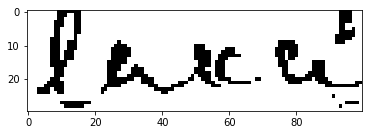

(1, 30, 100, 1)


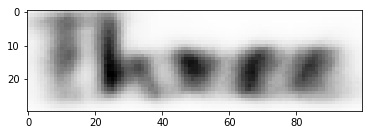

------------------------------End: test------------------------------
Cheque 309117thre2_3.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0057292  0.02362755 0.25592756 0.00939005 0.11440084 0.07078059
  0.03349875 0.04316866 0.35867772 0.13273944 0.13691577 0.06832208
  0.42847157 0.10013723 0.06830392 0.03216299 0.02245308 0.99489903
  0.11600506 0.22949924 0.01098479 0.03337415 0.24472973 0.28546432
  0.01881412 0.13139324 0.05868228 0.01861232 0.07047731 0.15870868
  0.2284505  0.0833378  0.01053481]]
[17]
17
['Seventy']


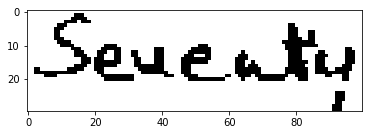

(1, 30, 100, 1)


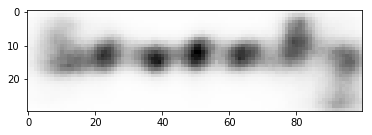

------------------------------End: test------------------------------
Cheque 309118thre2_0.tif Seventy
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.10829219 0.04245962 0.23255283 0.05620034 0.03049898 0.06155457
  0.03077667 0.00798888 0.03085208 0.02928454 0.06023362 0.06465468
  0.04555485 0.29406926 0.02532306 0.3819332  0.18681781 0.02510791
  0.0637894  0.0181435  0.07416895 0.34598276 0.2889448  0.03496028
  0.13331284 0.06456052 0.11341859 0.09754619 0.96584886 0.732275
  0.04993437 0.08865302 0.20074211]]
[28]
28
['Five']


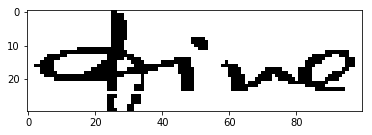

(1, 30, 100, 1)


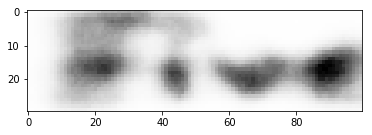

------------------------------End: test------------------------------
Cheque 309118thre2_1.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06410906 0.02314933 0.05232394 0.00560666 0.4184996  0.1556477
  0.07474824 0.03575035 0.08603727 0.01841269 0.08772204 0.09451845
  0.0194588  0.0195163  0.01824149 0.185573   0.04587697 0.15251434
  0.01262884 0.03163296 0.0783637  0.02790954 0.11397079 0.04529151
  0.990433   0.04318569 0.05154169 0.54506516 0.16314518 0.03023382
  0.20881103 0.02644971 0.1058608 ]]
[24]
24
['Thousand']


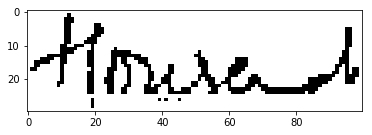

(1, 30, 100, 1)


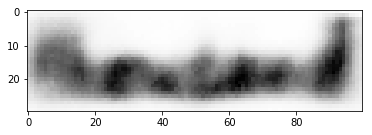

------------------------------End: test------------------------------
Cheque 309118thre2_2.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.2770404  0.14605024 0.0071976  0.15260603 0.17529169 0.08251467
  0.19644105 0.0727618  0.6336511  0.00499722 0.12195037 0.13233148
  0.03887064 0.2182121  0.09798849 0.2141582  0.21875805 0.29839218
  0.14329188 0.05646611 0.09957948 0.09813353 0.35164842 0.19718266
  0.04242397 0.6243641  0.05048734 0.36536416 0.12583718 0.33033386
  0.04830601 0.11080746 0.09948594]]
[8]
8
['Seventeen']


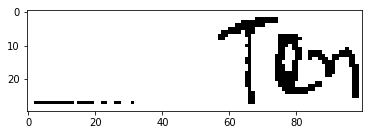

(1, 30, 100, 1)


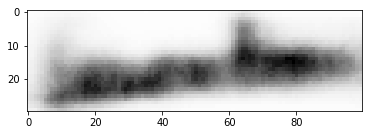

------------------------------End: test------------------------------
Cheque 309119thre2_0.tif Seventeen
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04167435 0.0513044  0.02773964 0.06576039 0.3508547  0.06617359
  0.2615128  0.0600752  0.42258793 0.07980334 0.17043865 0.01333896
  0.0293479  0.32850412 0.33042604 0.04766909 0.0954563  0.06328432
  0.2404137  0.05855623 0.09328185 0.04768601 0.21638495 0.09954084
  0.99439824 0.02045682 0.0458411  0.01501033 0.02702851 0.09846926
  0.04811199 0.06784081 0.03460377]]
[24]
24
['Thousand']


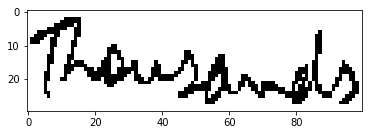

(1, 30, 100, 1)


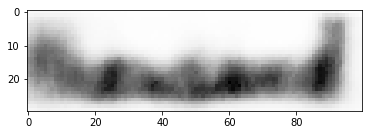

------------------------------End: test------------------------------
Cheque 309119thre2_1.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07078777 0.06362079 0.01027647 0.03224484 0.04350304 0.03327808
  0.04892592 0.04673864 0.030216   0.01354031 0.08773747 0.02609555
  0.09577206 0.06948236 0.08699882 0.06532498 0.06023148 0.03985453
  0.27873132 0.24565156 0.06935405 0.9700281  0.03219282 0.11033156
  0.01398492 0.19829682 0.07281974 0.12953931 0.13518189 0.03226819
  0.04943751 0.27298108 0.53415704]]
[21]
21
['Only']


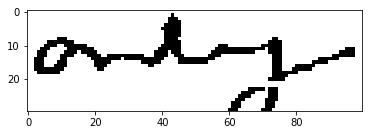

(1, 30, 100, 1)


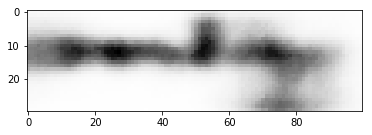

------------------------------End: test------------------------------
Cheque 309119thre2_2.tif Only
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00315179 0.01597537 0.06334431 0.10900015 0.06592114 0.00916302
  0.99797094 0.02962    0.07353497 0.3163813  0.01745474 0.14431116
  0.04691509 0.2906131  0.06284869 0.07111121 0.21234682 0.16102792
  0.01677342 0.01062902 0.03002733 0.08212727 0.01471244 0.08958043
  0.03092365 0.04454689 0.0467278  0.16659057 0.0738998  0.0669433
  0.05669878 0.01429276 0.09311483]]
[6]
6
['Fifteen']


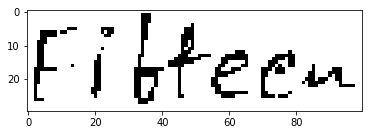

(1, 30, 100, 1)


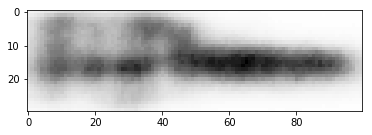

------------------------------End: test------------------------------
Cheque 309121thre2_1.tif Fifteen
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03080548 0.05022373 0.12076978 0.13062963 0.7373962  0.3143083
  0.02713259 0.06366484 0.16796508 0.15653671 0.09061278 0.02566371
  0.04249996 0.03710673 0.06735419 0.01084803 0.16054757 0.11722778
  0.04077456 0.09124706 0.0032147  0.06184246 0.0754066  0.04148179
  0.99350375 0.02207808 0.08897408 0.11838579 0.06223387 0.05699608
  0.04715912 0.00945631 0.01390207]]
[24]
24
['Thousand']


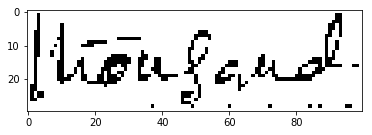

(1, 30, 100, 1)


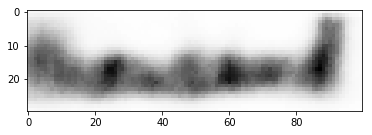

------------------------------End: test------------------------------
Cheque 309121thre2_2.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03574666 0.00662324 0.1306092  0.45673686 0.09787849 0.00525696
  0.0228957  0.05466955 0.00614283 0.0362484  0.31630963 0.04820832
  0.1373793  0.01011616 0.02875292 0.05113366 0.02846727 0.14685324
  0.09499293 0.0162322  0.9799539  0.0386257  0.26965183 0.31976253
  0.02514814 0.19070616 0.03014007 0.12214053 0.15634347 0.05058169
  0.19219716 0.03036564 0.01207511]]
[20]
20
['Rupees']


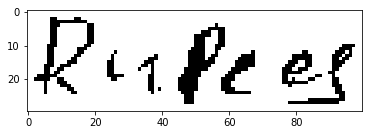

(1, 30, 100, 1)


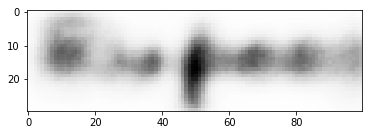

------------------------------End: test------------------------------
Cheque 309121thre2_3.tif Rupees
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[1.39293060e-01 1.97075903e-02 2.80059446e-02 4.26978618e-02
  4.99755926e-02 5.57828620e-02 1.01899408e-01 8.55106488e-02
  1.08643780e-02 7.70747662e-04 1.39298603e-01 1.15273464e-02
  6.36322284e-03 8.19684044e-02 1.52489185e-01 1.07601024e-01
  2.27712020e-01 5.40056564e-02 8.99389759e-03 5.51194176e-02
  7.07932189e-02 8.26049130e-03 6.62163123e-02 5.43635301e-02
  4.94874977e-02 2.89516356e-02 1.88026577e-02 2.21369058e-01
  8.61699060e-02 9.90595400e-01 2.98722625e-01 6.58192337e-02
  2.52126101e-02]]
[29]
29
['Six']


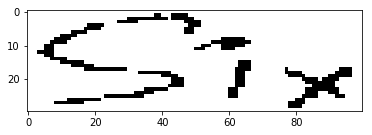

(1, 30, 100, 1)


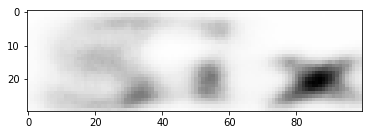

------------------------------End: test------------------------------
Cheque 309123thre2_0.tif Six
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.09988111 0.06507617 0.01787695 0.81002873 0.05081536 0.00676635
  0.0932544  0.04794015 0.11048322 0.01625835 0.01236422 0.37497893
  0.03606069 0.07335909 0.08348103 0.11300539 0.17061387 0.16852666
  0.01767639 0.04997548 0.02539596 0.3507747  0.10486571 0.03607176
  0.09036177 0.75032115 0.43630192 0.05225243 0.04403662 0.18550347
  0.24809337 0.1281379  0.05212863]]
[3]
3
['Twelve']


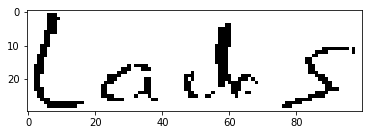

(1, 30, 100, 1)


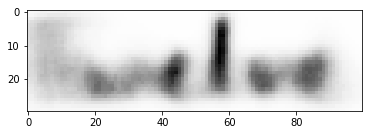

------------------------------End: test------------------------------
Cheque 309123thre2_1.tif Twelve
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01336563 0.01198802 0.06376062 0.00373274 0.01043828 0.11067566
  0.02167219 0.0493662  0.3926476  0.21300083 0.11981007 0.0616911
  0.9910163  0.1542492  0.06961564 0.0162649  0.05156789 0.04066692
  0.06597344 0.08676077 0.08466054 0.3317652  0.07543893 0.09036852
  0.4135895  0.08093271 0.11577392 0.10201864 0.07825108 0.04158485
  0.03692835 0.01717022 0.13637136]]
[12]
12
['Twenty']


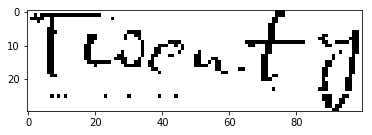

(1, 30, 100, 1)


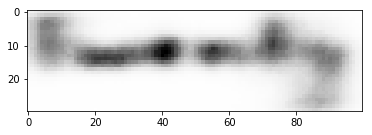

------------------------------End: test------------------------------
Cheque 309123thre2_2.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02108894 0.06161318 0.12972762 0.2382738  0.07734722 0.09804937
  0.08861698 0.11180854 0.08279496 0.02689136 0.03965144 0.17339854
  0.07395254 0.19254766 0.07158063 0.19899523 0.11838776 0.03917023
  0.0997665  0.12629405 0.02367512 0.09368575 0.9830514  0.01820381
  0.04795779 0.03098615 0.05265842 0.11330606 0.16025516 0.1644933
  0.01857884 0.09527729 0.36534557]]
[22]
22
['Three']


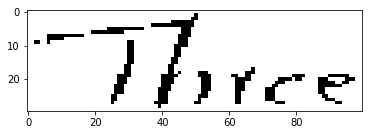

(1, 30, 100, 1)


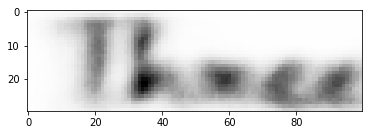

------------------------------End: test------------------------------
Cheque 309124thre2_0.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.08202494 0.10878123 0.02627232 0.19398385 0.0050242  0.03388904
  0.085866   0.08868376 0.0188558  0.03182768 0.01818483 0.6337493
  0.00902587 0.01476433 0.20873068 0.13904563 0.23657374 0.05473515
  0.13466352 0.01755326 0.20257685 0.5240555  0.15729906 0.04020591
  0.02351624 0.43070227 0.22353737 0.22067082 0.10120843 0.16660808
  0.06595737 0.03495969 0.18715227]]
[11]
11
['Two']


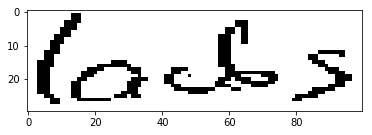

(1, 30, 100, 1)


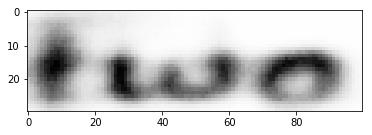

------------------------------End: test------------------------------
Cheque 309124thre2_1.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.13479726 0.04841955 0.05071272 0.06927912 0.12110121 0.04083522
  0.16717944 0.02018113 0.05698267 0.0214431  0.05746536 0.07156293
  0.01722009 0.99400204 0.0355677  0.05483697 0.19793618 0.08331065
  0.02333009 0.10903366 0.22183919 0.0743507  0.42748633 0.1568005
  0.07436813 0.3753198  0.05122609 0.22609958 0.13903514 0.00636295
  0.03327944 0.1398393  0.20006159]]
[13]
13
['Thirty']


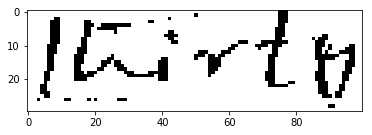

(1, 30, 100, 1)


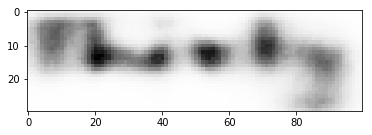

------------------------------End: test------------------------------
Cheque 309124thre2_2.tif Thirty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02411682 0.11282486 0.03583867 0.01831749 0.0738996  0.10396286
  0.09974456 0.2033386  0.1402709  0.00800122 0.18149468 0.01898528
  0.9888801  0.10738786 0.05940323 0.0946359  0.11446772 0.1408584
  0.02709405 0.03584273 0.01579704 0.08738758 0.1226901  0.07213958
  0.02512746 0.07449486 0.09331208 0.07947706 0.03526167 0.05863317
  0.06154523 0.03800879 0.01509094]]
[12]
12
['Twenty']


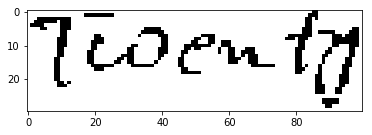

(1, 30, 100, 1)


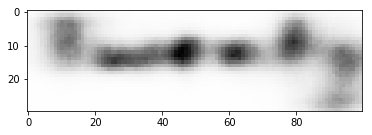

------------------------------End: test------------------------------
Cheque 309125thre2_1.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.08448041 0.11639731 0.04559214 0.04375146 0.19926257 0.11197472
  0.21771027 0.04266236 0.03078061 0.41158104 0.06462277 0.1536298
  0.03980684 0.01143263 0.02420608 0.08179841 0.06902523 0.1442843
  0.12772955 0.04367649 0.03311334 0.02027268 0.01889358 0.02749271
  0.00977228 0.11256454 0.02705042 0.02568149 0.9883346  0.16047384
  0.15027195 0.00935755 0.20867902]]
[28]
28
['Five']


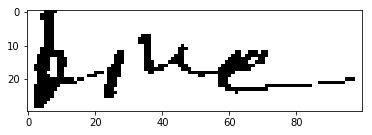

(1, 30, 100, 1)


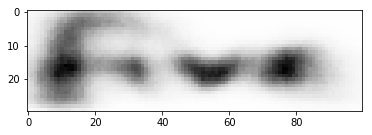

------------------------------End: test------------------------------
Cheque 309125thre2_2.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00915033 0.11004645 0.13627672 0.03813185 0.38477978 0.13407467
  0.02154469 0.49256065 0.45788205 0.08824845 0.33744773 0.03940827
  0.02947833 0.07233474 0.21863657 0.06510633 0.15940623 0.26198435
  0.05328417 0.27761325 0.10576022 0.04966456 0.06346052 0.1425159
  0.99208754 0.03962511 0.15625066 0.03658785 0.07192077 0.01937716
  0.03780626 0.06385412 0.09822983]]
[24]
24
['Thousand']


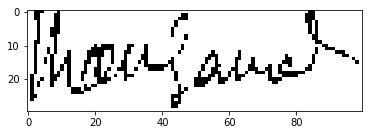

(1, 30, 100, 1)


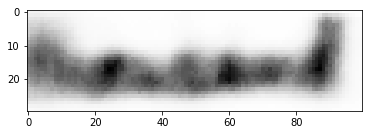

------------------------------End: test------------------------------
Cheque 309125thre2_3.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.26660264 0.1031927  0.02747771 0.06284805 0.10205657 0.02221209
  0.06569779 0.01278974 0.0083258  0.09305765 0.09949552 0.06252268
  0.05524419 0.06817903 0.06820536 0.04945381 0.17627971 0.07992116
  0.15713643 0.03016044 0.00212128 0.05729201 0.9972373  0.06044011
  0.01547242 0.02373613 0.02074023 0.05099607 0.07878176 0.07127839
  0.1530608  0.01267579 0.01486087]]
[22]
22
['Three']


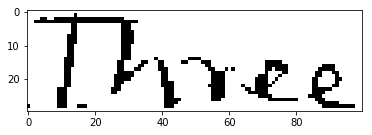

(1, 30, 100, 1)


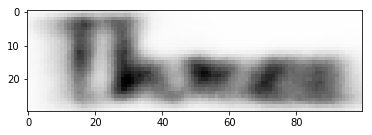

------------------------------End: test------------------------------
Cheque 309127thre2_0.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0400213  0.04292834 0.04286389 0.05871044 0.04282299 0.03940069
  0.08798794 0.00501518 0.01227805 0.11024203 0.04922347 0.02492144
  0.08936949 0.00578059 0.10135981 0.15906729 0.05536317 0.05176662
  0.07442888 0.00562922 0.13260975 0.00276757 0.08304058 0.12998837
  0.03162536 0.913163   0.07649573 0.05999864 0.03371501 0.04422296
  0.09730774 0.0187442  0.29188088]]
[25]
25
['Lakh']


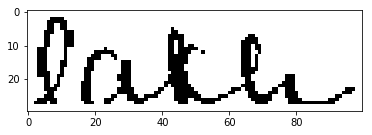

(1, 30, 100, 1)


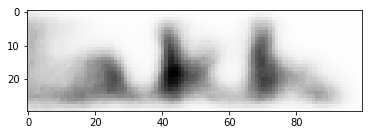

------------------------------End: test------------------------------
Cheque 309127thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.08433725 0.08588459 0.1058768  0.21798417 0.01938597 0.00992225
  0.6014084  0.08320843 0.06695537 0.05048907 0.01604741 0.03839322
  0.03508662 0.01014218 0.03112498 0.12160876 0.10599001 0.04561684
  0.03380269 0.2710992  0.01255931 0.06733973 0.14700639 0.00796551
  0.02613916 0.0918605  0.11701679 0.29876897 0.99053067 0.15623988
  0.02527099 0.03511669 0.6801452 ]]
[28]
28
['Five']


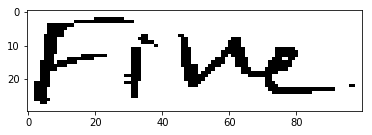

(1, 30, 100, 1)


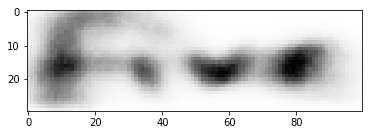

------------------------------End: test------------------------------
Cheque 309127thre2_2.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.1216476  0.0318046  0.06042024 0.19267763 0.1769076  0.11791374
  0.11916929 0.20857991 0.97867435 0.04331154 0.26157278 0.05028291
  0.08411388 0.06694644 0.23799866 0.28771394 0.2562029  0.01889228
  0.09268505 0.41532326 0.01312628 0.06211291 0.01395693 0.03573137
  0.9914911  0.06460394 0.11259747 0.03076384 0.0461656  0.00620949
  0.04445653 0.03088317 0.0606533 ]]
[24]
24
['Thousand']


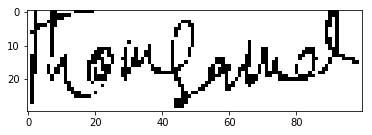

(1, 30, 100, 1)


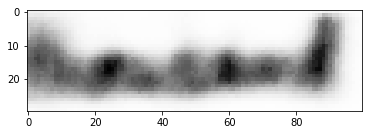

------------------------------End: test------------------------------
Cheque 309127thre2_3.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.10705943 0.06259333 0.24523875 0.02925331 0.11536365 0.17384674
  0.00902314 0.6516136  0.11668488 0.05907686 0.0406361  0.10252263
  0.13828628 0.04827569 0.02001308 0.0256507  0.8863785  0.07449023
  0.05830817 0.16663481 0.03607242 0.0095313  0.01931225 0.00366548
  0.01502301 0.01689168 0.04460241 0.15779485 0.06245822 0.03016121
  0.33008778 0.04712664 0.02199615]]
[16]
16
['Sixty']


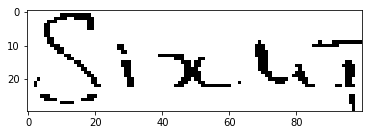

(1, 30, 100, 1)


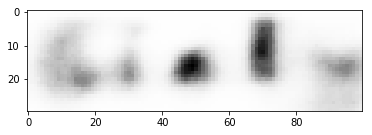

------------------------------End: test------------------------------
Cheque 309128thre2_0.tif Sixty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01570105 0.11402696 0.02918535 0.03152771 0.09120874 0.00681332
  0.02121548 0.1998821  0.0392587  0.03366048 0.0236437  0.02846547
  0.11955961 0.01929808 0.04327046 0.37252772 0.14238256 0.0161051
  0.0269401  0.03516742 0.09954883 0.16428839 0.11624319 0.00288365
  0.02392362 0.05833775 0.13598713 0.01770027 0.00405479 0.34986636
  0.961326   0.07203588 0.02882523]]
[30]
30
['Seven']


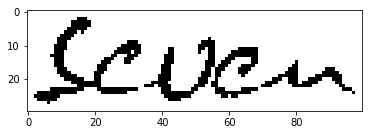

(1, 30, 100, 1)


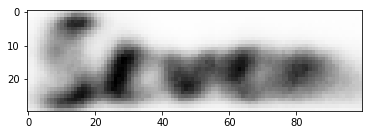

------------------------------End: test------------------------------
Cheque 309128thre2_1.tif Seven
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.06613644 0.04680932 0.07386688 0.28736284 0.36242938 0.35638466
  0.0364408  0.437886   0.11538393 0.3460656  0.65391284 0.04250224
  0.15617251 0.03230663 0.07203431 0.02670669 0.19857556 0.07564614
  0.04447734 0.12411656 0.04506162 0.04758966 0.02379736 0.04332013
  0.99114764 0.03956627 0.18692236 0.10723606 0.13821249 0.03741952
  0.00898509 0.05456749 0.04835895]]
[24]
24
['Thousand']


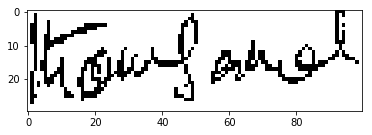

(1, 30, 100, 1)


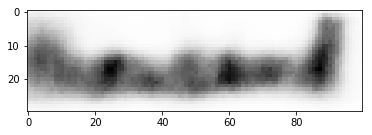

------------------------------End: test------------------------------
Cheque 309128thre2_2.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0196157  0.13007444 0.37256575 0.02248047 0.02466629 0.11595981
  0.17685488 0.02882782 0.32488087 0.04829965 0.04979484 0.03959454
  0.0321091  0.01278159 0.04619471 0.00390626 0.00803724 0.03486149
  0.06885596 0.92232656 0.01621203 0.04144037 0.4372538  0.02233398
  0.15796289 0.04575542 0.22626391 0.02933986 0.06625154 0.08042166
  0.09110267 0.04969872 0.9522274 ]]
[32]
32
['Nine']


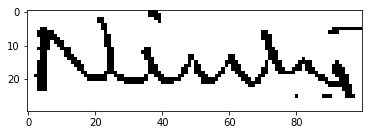

(1, 30, 100, 1)


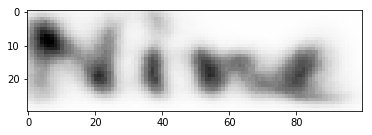

------------------------------End: test------------------------------
Cheque 309129thre2_0.tif Nine
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.14191343 0.01107801 0.20818698 0.07914107 0.0118755  0.47026455
  0.05494039 0.07430256 0.03312966 0.05380578 0.05278673 0.08070315
  0.21404132 0.01662769 0.40946576 0.14863543 0.03823695 0.05488135
  0.15889181 0.8102441  0.02111157 0.11945224 0.24723774 0.05608543
  0.01984719 0.13045579 0.0070958  0.07611143 0.3904627  0.11751477
  0.03690924 0.0476524  0.9770028 ]]
[32]
32
['Nine']


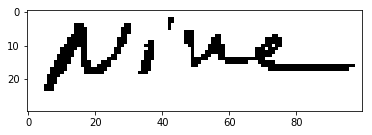

(1, 30, 100, 1)


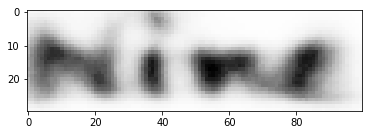

------------------------------End: test------------------------------
Cheque 309129thre2_1.tif Nine
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07102599 0.01403982 0.11421805 0.13701628 0.07814815 0.304621
  0.04046703 0.21715355 0.0536557  0.31241134 0.04418276 0.05839076
  0.09141491 0.10909081 0.02467606 0.04586883 0.06776483 0.03163074
  0.01994612 0.10737533 0.00900659 0.07260948 0.07037968 0.1282926
  0.9908502  0.03150515 0.2604958  0.14041378 0.03943047 0.05599341
  0.18274595 0.02525924 0.09131996]]
[24]
24
['Thousand']


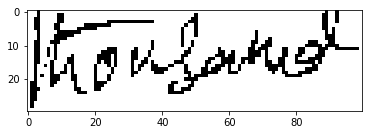

(1, 30, 100, 1)


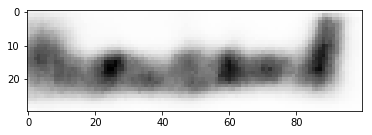

------------------------------End: test------------------------------
Cheque 309129thre2_2.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.09397617 0.02333975 0.04297733 0.05956098 0.02120463 0.1214749
  0.02321692 0.01560448 0.04006478 0.0179381  0.22554927 0.06256353
  0.25149342 0.92453265 0.27970576 0.25762752 0.44808233 0.01677518
  0.18655884 0.02397881 0.21100485 0.3019383  0.06089862 0.02228598
  0.02570103 0.02191917 0.10386787 0.05143608 0.20860586 0.05143513
  0.14863291 0.1022324  0.09393666]]
[13]
13
['Thirty']


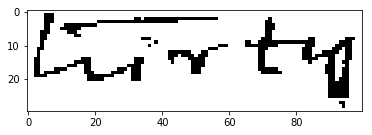

(1, 30, 100, 1)


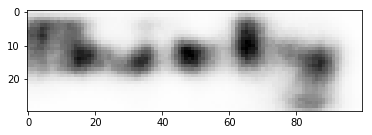

------------------------------End: test------------------------------
Cheque 309130thre2_1.tif Thirty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.11132954 0.04161108 0.07205902 0.02576896 0.07569448 0.29769644
  0.27651426 0.07502064 0.02381181 0.08940502 0.01041602 0.17779016
  0.04701433 0.03410318 0.05110135 0.09520806 0.1788429  0.27478874
  0.14800087 0.06368864 0.19922481 0.04253615 0.10284074 0.05919318
  0.07344452 0.08602494 0.01103685 0.12003954 0.9906372  0.11993606
  0.12500225 0.04015056 0.01023806]]
[28]
28
['Five']


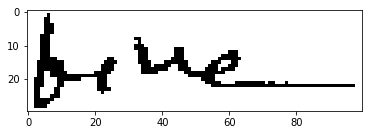

(1, 30, 100, 1)


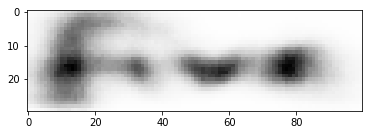

------------------------------End: test------------------------------
Cheque 309130thre2_2.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02336995 0.00858389 0.26512694 0.61641544 0.1251228  0.17108718
  0.04283147 0.02065558 0.24463797 0.60023814 0.07056365 0.1135665
  0.03182189 0.06491903 0.02150601 0.09294953 0.06660303 0.13906723
  0.10104883 0.04916192 0.29894623 0.05296683 0.04677491 0.02418524
  0.9893175  0.06722085 0.15908162 0.06394879 0.1289728  0.02244575
  0.03043444 0.01602494 0.0757403 ]]
[24]
24
['Thousand']


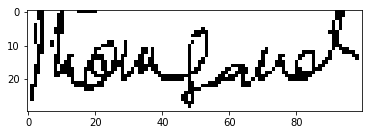

(1, 30, 100, 1)


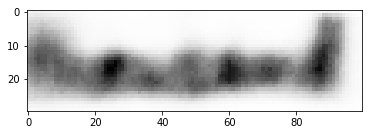

------------------------------End: test------------------------------
Cheque 309130thre2_3.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02673475 0.02187737 0.01494815 0.0419576  0.08306494 0.02364749
  0.02568781 0.060435   0.03165498 0.06169197 0.02578169 0.06843706
  0.00856265 0.2302419  0.04211681 0.04223399 0.08501558 0.11269579
  0.0712623  0.04374583 0.10690738 0.09890293 0.06474641 0.06283075
  0.01957277 0.03068924 0.0607251  0.34586036 0.9934186  0.03393026
  0.08206469 0.01180037 0.01823578]]
[28]
28
['Five']


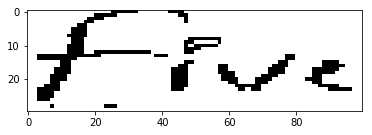

(1, 30, 100, 1)


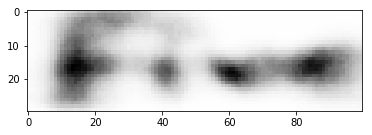

------------------------------End: test------------------------------
Cheque 309131thre2_0.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03165147 0.08792944 0.05133966 0.02191365 0.06968055 0.01597337
  0.03989489 0.01610797 0.01746973 0.03331367 0.03344857 0.8146657
  0.5106633  0.1733366  0.07193311 0.00660888 0.03661612 0.07819258
  0.24791448 0.29481763 0.06550297 0.09231013 0.10369923 0.02767452
  0.10243708 0.84093547 0.26561153 0.06665126 0.19494225 0.06658674
  0.08591401 0.22163478 0.10033397]]
[25]
25
['Lakh']


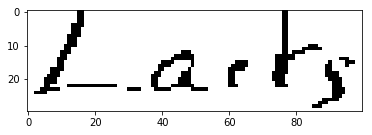

(1, 30, 100, 1)


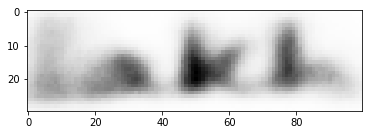

------------------------------End: test------------------------------
Cheque 309131thre2_1 (1).tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03165147 0.08792944 0.05133966 0.02191365 0.06968055 0.01597337
  0.03989489 0.01610797 0.01746973 0.03331367 0.03344857 0.8146657
  0.5106633  0.1733366  0.07193311 0.00660888 0.03661612 0.07819258
  0.24791448 0.29481763 0.06550297 0.09231013 0.10369923 0.02767452
  0.10243708 0.84093547 0.26561153 0.06665126 0.19494225 0.06658674
  0.08591401 0.22163478 0.10033397]]
[25]
25
['Lakh']


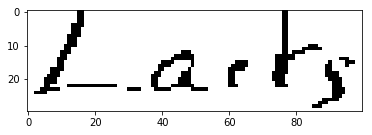

(1, 30, 100, 1)


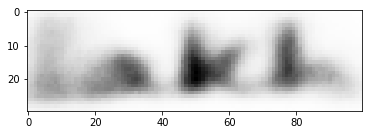

------------------------------End: test------------------------------
Cheque 309131thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02068576 0.9923274  0.05413835 0.01331565 0.02781574 0.04381279
  0.03854555 0.02388102 0.0362471  0.01054099 0.01832939 0.57597196
  0.01334729 0.04926297 0.05373279 0.0777766  0.08932762 0.02196572
  0.05273693 0.00656795 0.05978152 0.03166229 0.02581617 0.0606758
  0.00773623 0.0142343  0.12897685 0.04888071 0.00461207 0.01456923
  0.1091262  0.02998633 0.03739212]]
[1]
1
['Ten']


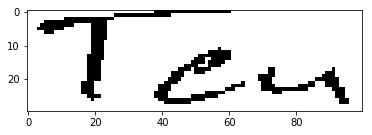

(1, 30, 100, 1)


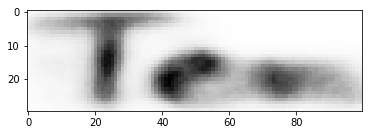

------------------------------End: test------------------------------
Cheque 309131thre2_2 (1).tif Ten
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02068576 0.9923274  0.05413835 0.01331565 0.02781574 0.04381279
  0.03854555 0.02388102 0.0362471  0.01054099 0.01832939 0.57597196
  0.01334729 0.04926297 0.05373279 0.0777766  0.08932762 0.02196572
  0.05273693 0.00656795 0.05978152 0.03166229 0.02581617 0.0606758
  0.00773623 0.0142343  0.12897685 0.04888071 0.00461207 0.01456923
  0.1091262  0.02998633 0.03739212]]
[1]
1
['Ten']


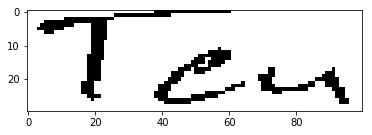

(1, 30, 100, 1)


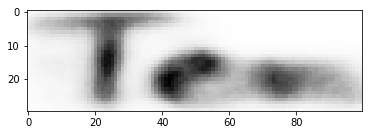

------------------------------End: test------------------------------
Cheque 309131thre2_2.tif Ten
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.99382854 0.08501121 0.01493467 0.14987634 0.0555407  0.0255156
  0.09761848 0.038334   0.0440635  0.00824234 0.05087975 0.08056866
  0.08376352 0.05656471 0.05599611 0.07645912 0.08787946 0.0096225
  0.0902786  0.01686904 0.02850144 0.22326389 0.05855256 0.04219241
  0.05613799 0.01279179 0.0070835  0.02969192 0.00765123 0.14107694
  0.04639491 0.01849256 0.06142247]]
[0]
0
['One']


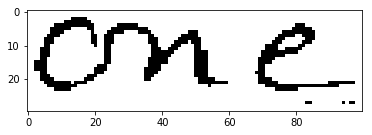

(1, 30, 100, 1)


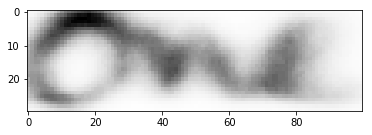

------------------------------End: test------------------------------
Cheque 309133thre2_1 (1).tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.99382854 0.08501121 0.01493467 0.14987634 0.0555407  0.0255156
  0.09761848 0.038334   0.0440635  0.00824234 0.05087975 0.08056866
  0.08376352 0.05656471 0.05599611 0.07645912 0.08787946 0.0096225
  0.0902786  0.01686904 0.02850144 0.22326389 0.05855256 0.04219241
  0.05613799 0.01279179 0.0070835  0.02969192 0.00765123 0.14107694
  0.04639491 0.01849256 0.06142247]]
[0]
0
['One']


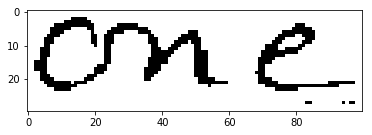

(1, 30, 100, 1)


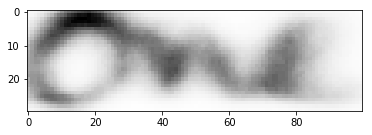

------------------------------End: test------------------------------
Cheque 309133thre2_1.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05331861 0.09332757 0.09515791 0.03375559 0.28364497 0.03339411
  0.00651896 0.10285036 0.07302664 0.01380691 0.05814912 0.9932837
  0.03470123 0.03635514 0.08334229 0.08086302 0.0131745  0.06201822
  0.0150753  0.01442743 0.03768386 0.19605123 0.02356835 0.04218104
  0.12923999 0.09837627 0.05866427 0.2774727  0.17869441 0.09122904
  0.04187823 0.26163697 0.09672581]]
[11]
11
['Two']


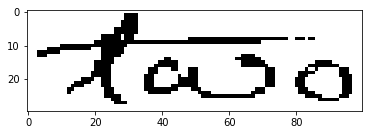

(1, 30, 100, 1)


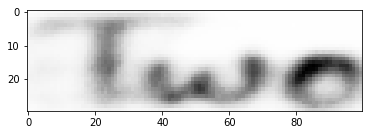

------------------------------End: test------------------------------
Cheque 309134thre2_0 (1).tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05331861 0.09332757 0.09515791 0.03375559 0.28364497 0.03339411
  0.00651896 0.10285036 0.07302664 0.01380691 0.05814912 0.9932837
  0.03470123 0.03635514 0.08334229 0.08086302 0.0131745  0.06201822
  0.0150753  0.01442743 0.03768386 0.19605123 0.02356835 0.04218104
  0.12923999 0.09837627 0.05866427 0.2774727  0.17869441 0.09122904
  0.04187823 0.26163697 0.09672581]]
[11]
11
['Two']


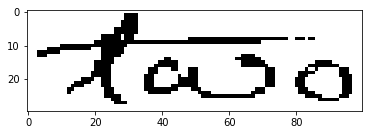

(1, 30, 100, 1)


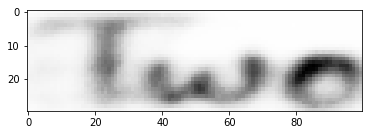

------------------------------End: test------------------------------
Cheque 309134thre2_0.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.9284654  0.08298565 0.04063533 0.0710223  0.03233098 0.11762409
  0.0088591  0.22649607 0.00858154 0.01403015 0.05681187 0.04402983
  0.05619911 0.18725552 0.0569276  0.09619298 0.22220404 0.01161364
  0.20079711 0.03847355 0.10382219 0.05661761 0.14371915 0.03363217
  0.00854052 0.17138383 0.9601831  0.05491228 0.15971701 0.04751431
  0.16120343 0.02953861 0.10216101]]
[26]
26
['Crore']


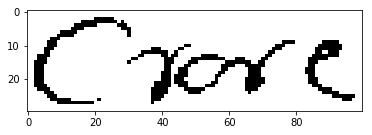

(1, 30, 100, 1)


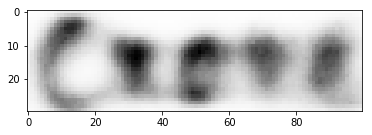

------------------------------End: test------------------------------
Cheque 309134thre2_1 (1).tif Crore
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.9284654  0.08298565 0.04063533 0.0710223  0.03233098 0.11762409
  0.0088591  0.22649607 0.00858154 0.01403015 0.05681187 0.04402983
  0.05619911 0.18725552 0.0569276  0.09619298 0.22220404 0.01161364
  0.20079711 0.03847355 0.10382219 0.05661761 0.14371915 0.03363217
  0.00854052 0.17138383 0.9601831  0.05491228 0.15971701 0.04751431
  0.16120343 0.02953861 0.10216101]]
[26]
26
['Crore']


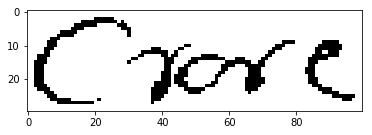

(1, 30, 100, 1)


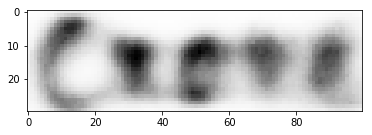

------------------------------End: test------------------------------
Cheque 309134thre2_1.tif Crore
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04698114 0.07793069 0.01119438 0.03552157 0.0098453  0.01232407
  0.01442046 0.00549415 0.046849   0.11513858 0.08179548 0.9908764
  0.0504331  0.02302572 0.03242505 0.31116983 0.15798345 0.08791355
  0.04121615 0.05319791 0.05341631 0.02149863 0.05265073 0.01195883
  0.01540873 0.02131767 0.18642408 0.06079713 0.03458171 0.01252774
  0.09039289 0.0347257  0.03448485]]
[11]
11
['Two']


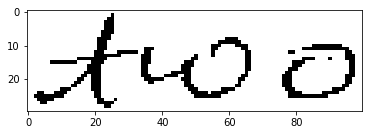

(1, 30, 100, 1)


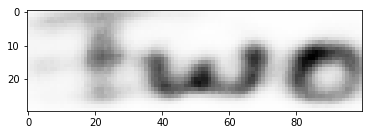

------------------------------End: test------------------------------
Cheque 309134thre2_2 (1).tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04698114 0.07793069 0.01119438 0.03552157 0.0098453  0.01232407
  0.01442046 0.00549415 0.046849   0.11513858 0.08179548 0.9908764
  0.0504331  0.02302572 0.03242505 0.31116983 0.15798345 0.08791355
  0.04121615 0.05319791 0.05341631 0.02149863 0.05265073 0.01195883
  0.01540873 0.02131767 0.18642408 0.06079713 0.03458171 0.01252774
  0.09039289 0.0347257  0.03448485]]
[11]
11
['Two']


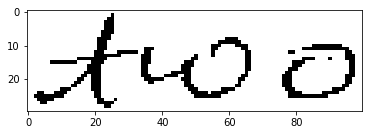

(1, 30, 100, 1)


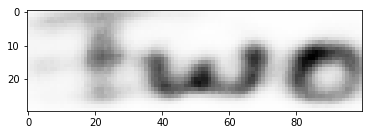

------------------------------End: test------------------------------
Cheque 309134thre2_2.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.990598   0.04533382 0.03411209 0.03976549 0.03623446 0.05400369
  0.01021361 0.00755603 0.09484463 0.0043115  0.01391078 0.06946702
  0.02507947 0.01815711 0.03926308 0.04547743 0.02969218 0.06880607
  0.07741173 0.04301282 0.03552529 0.0618911  0.04343745 0.2523941
  0.01837612 0.02922846 0.15586504 0.15044153 0.03961293 0.02825199
  0.08280169 0.05311434 0.02504741]]
[0]
0
['One']


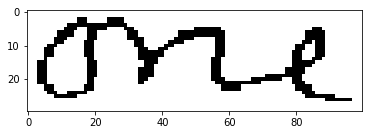

(1, 30, 100, 1)


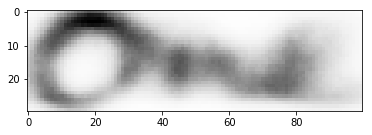

------------------------------End: test------------------------------
Cheque 309135thre2_0 (1).tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.990598   0.04533382 0.03411209 0.03976549 0.03623446 0.05400369
  0.01021361 0.00755603 0.09484463 0.0043115  0.01391078 0.06946702
  0.02507947 0.01815711 0.03926308 0.04547743 0.02969218 0.06880607
  0.07741173 0.04301282 0.03552529 0.0618911  0.04343745 0.2523941
  0.01837612 0.02922846 0.15586504 0.15044153 0.03961293 0.02825199
  0.08280169 0.05311434 0.02504741]]
[0]
0
['One']


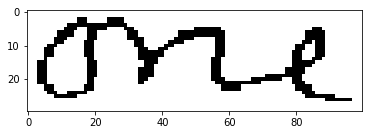

(1, 30, 100, 1)


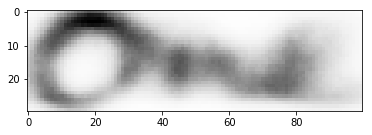

------------------------------End: test------------------------------
Cheque 309135thre2_0.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.09248568 0.04536122 0.02222891 0.04485948 0.00648018 0.05332929
  0.01966803 0.01648732 0.06460477 0.02610397 0.06156687 0.02757122
  0.06128342 0.09053814 0.02693823 0.01664686 0.12867582 0.05790978
  0.05320544 0.04255529 0.05994667 0.02156209 0.00916696 0.11370358
  0.00513152 0.9930748  0.3103829  0.07412803 0.0596269  0.06022514
  0.54723036 0.03255509 0.027961  ]]
[25]
25
['Lakh']


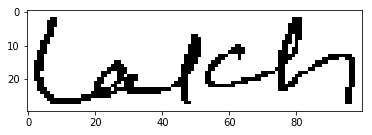

(1, 30, 100, 1)


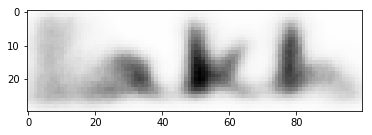

------------------------------End: test------------------------------
Cheque 309135thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03593632 0.13805081 0.00516561 0.29196578 0.0548138  0.18072602
  0.00946974 0.09363852 0.09944686 0.21149468 0.01121974 0.17668815
  0.9899141  0.34302133 0.09999456 0.16347653 0.0055222  0.09971157
  0.46590722 0.04284151 0.00754162 0.10457569 0.1128469  0.0425391
  0.03632654 0.20752989 0.10991805 0.09659448 0.17094623 0.00945539
  0.14873095 0.01735337 0.04714939]]
[12]
12
['Twenty']


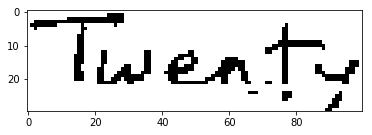

(1, 30, 100, 1)


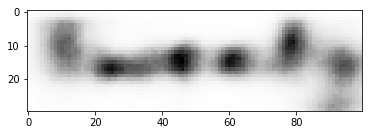

------------------------------End: test------------------------------
Cheque 309135thre2_2.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03772613 0.17404374 0.00274063 0.20549227 0.54771024 0.0347508
  0.02609651 0.00569642 0.08261995 0.02386582 0.24593088 0.02296799
  0.01828098 0.06815751 0.01857151 0.02266826 0.03299617 0.01116444
  0.03292736 0.05588168 0.0090395  0.00744606 0.06702873 0.02029083
  0.98932934 0.02003466 0.01538331 0.15583618 0.0501917  0.04578687
  0.10463823 0.02785847 0.09331536]]
[24]
24
['Thousand']


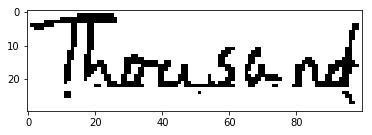

(1, 30, 100, 1)


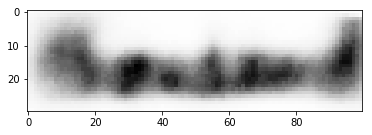

------------------------------End: test------------------------------
Cheque 309135thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.99384713 0.05672979 0.01810813 0.03689077 0.0348753  0.02952243
  0.09387716 0.0022882  0.03313169 0.02409575 0.03507195 0.03233948
  0.0125564  0.13514863 0.06249999 0.03893036 0.04235043 0.04408034
  0.02027068 0.06723925 0.1446329  0.2346888  0.03319859 0.01340926
  0.04097579 0.0801447  0.07896872 0.02087039 0.03639732 0.04822354
  0.02734626 0.0033709  0.27014005]]
[0]
0
['One']


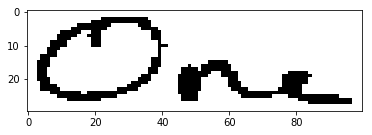

(1, 30, 100, 1)


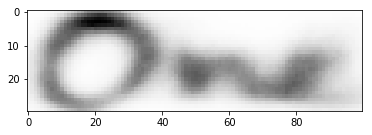

------------------------------End: test------------------------------
Cheque 309137thre2_0 (1).tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.99384713 0.05672979 0.01810813 0.03689077 0.0348753  0.02952243
  0.09387716 0.0022882  0.03313169 0.02409575 0.03507195 0.03233948
  0.0125564  0.13514863 0.06249999 0.03893036 0.04235043 0.04408034
  0.02027068 0.06723925 0.1446329  0.2346888  0.03319859 0.01340926
  0.04097579 0.0801447  0.07896872 0.02087039 0.03639732 0.04822354
  0.02734626 0.0033709  0.27014005]]
[0]
0
['One']


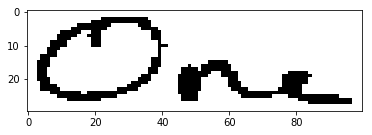

(1, 30, 100, 1)


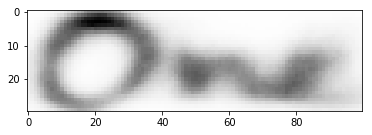

------------------------------End: test------------------------------
Cheque 309137thre2_0.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.10626863 0.12156237 0.27291316 0.13221526 0.01890256 0.12543277
  0.0086857  0.00587406 0.01263679 0.0112     0.02360907 0.06306273
  0.11993961 0.00736764 0.19627373 0.15352727 0.08358102 0.06935432
  0.11314948 0.01056899 0.00506254 0.14184879 0.066471   0.00317305
  0.06194964 0.04816161 0.06666847 0.1338063  0.9930742  0.04296892
  0.00480683 0.0280769  0.15039936]]
[28]
28
['Five']


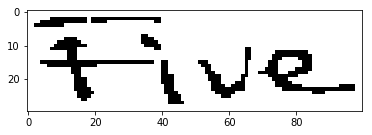

(1, 30, 100, 1)


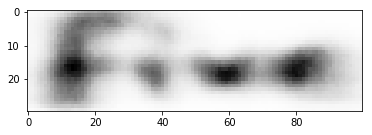

------------------------------End: test------------------------------
Cheque 309138thre2_0 (1).tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.10626863 0.12156237 0.27291316 0.13221526 0.01890256 0.12543277
  0.0086857  0.00587406 0.01263679 0.0112     0.02360907 0.06306273
  0.11993961 0.00736764 0.19627373 0.15352727 0.08358102 0.06935432
  0.11314948 0.01056899 0.00506254 0.14184879 0.066471   0.00317305
  0.06194964 0.04816161 0.06666847 0.1338063  0.9930742  0.04296892
  0.00480683 0.0280769  0.15039936]]
[28]
28
['Five']


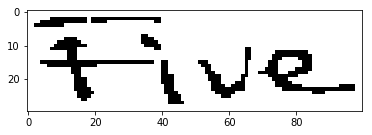

(1, 30, 100, 1)


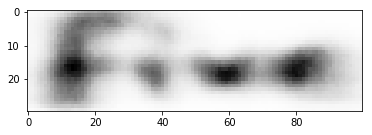

------------------------------End: test------------------------------
Cheque 309138thre2_0.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.21938679 0.05248331 0.06202033 0.10846621 0.06697622 0.07294603
  0.00185711 0.25721827 0.08520014 0.00532554 0.01241443 0.23842853
  0.02226238 0.00753053 0.05745659 0.07247458 0.01412805 0.07008112
  0.16223605 0.02152245 0.15406649 0.0717635  0.02241747 0.09914675
  0.09647951 0.9250639  0.09997515 0.08563551 0.10344254 0.060863
  0.08815578 0.015101   0.13018839]]
[25]
25
['Lakh']


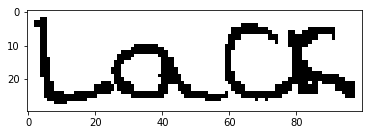

(1, 30, 100, 1)


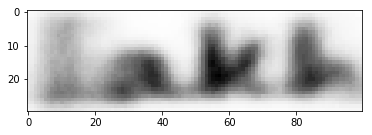

------------------------------End: test------------------------------
Cheque 309138thre2_1 (1).tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.21938679 0.05248331 0.06202033 0.10846621 0.06697622 0.07294603
  0.00185711 0.25721827 0.08520014 0.00532554 0.01241443 0.23842853
  0.02226238 0.00753053 0.05745659 0.07247458 0.01412805 0.07008112
  0.16223605 0.02152245 0.15406649 0.0717635  0.02241747 0.09914675
  0.09647951 0.9250639  0.09997515 0.08563551 0.10344254 0.060863
  0.08815578 0.015101   0.13018839]]
[25]
25
['Lakh']


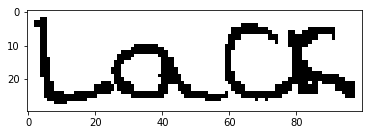

(1, 30, 100, 1)


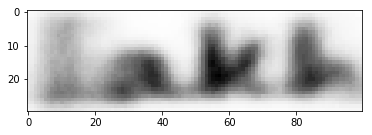

------------------------------End: test------------------------------
Cheque 309138thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01139127 0.26894102 0.02369505 0.02775084 0.06294439 0.05005907
  0.04517526 0.05727242 0.04238543 0.04469873 0.01246577 0.021488
  0.0217249  0.01967981 0.09433068 0.02537718 0.07236529 0.04172967
  0.07552531 0.15306062 0.00961869 0.04589442 0.20426445 0.03273929
  0.01789477 0.05702962 0.02259844 0.24308859 0.9945231  0.03284707
  0.03214605 0.2397709  0.01561472]]
[28]
28
['Five']


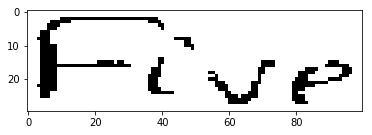

(1, 30, 100, 1)


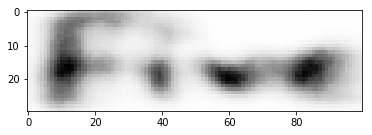

------------------------------End: test------------------------------
Cheque 309138thre2_4.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04416697 0.01996352 0.05572159 0.6989367  0.10554817 0.01122197
  0.02724046 0.00364683 0.16596097 0.02868235 0.11702805 0.29118437
  0.5981335  0.06149223 0.0667529  0.03308325 0.02846049 0.28836557
  0.33868212 0.0412925  0.01379131 0.01013728 0.03600842 0.03211805
  0.07764114 0.05635433 0.03730068 0.1309858  0.04452636 0.05008849
  0.05131362 0.04061236 0.19237404]]
[3]
3
['Twelve']


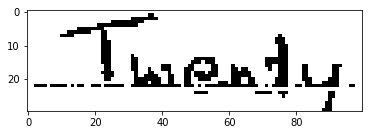

(1, 30, 100, 1)


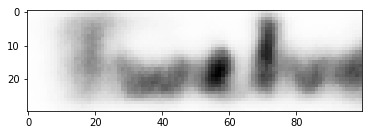

------------------------------End: test------------------------------
Cheque 309139thre2_0.tif Twelve
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.12110753 0.19201449 0.07784068 0.04135698 0.08496553 0.16589576
  0.02536737 0.18334566 0.28139165 0.01583179 0.04298734 0.07999144
  0.12597135 0.09005073 0.10489745 0.10983876 0.42422736 0.02335519
  0.01309181 0.02833072 0.17113756 0.1803201  0.98466414 0.13515243
  0.02255521 0.17237271 0.32573256 0.20083898 0.07863129 0.7921865
  0.04321159 0.07233592 0.09465829]]
[22]
22
['Three']


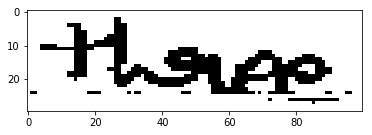

(1, 30, 100, 1)


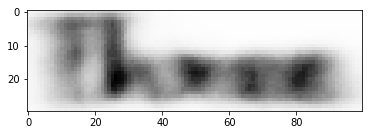

------------------------------End: test------------------------------
Cheque 309139thre2_1.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02970403 0.02910825 0.15585409 0.10301987 0.04591481 0.40646368
  0.01640076 0.22295499 0.3447698  0.01437975 0.14309469 0.03063286
  0.18844245 0.10617577 0.01248545 0.03284512 0.25977978 0.08796441
  0.01482215 0.04704251 0.15799205 0.06006658 0.03491493 0.99114746
  0.384301   0.01254034 0.08913856 0.08605252 0.07640041 0.00611296
  0.02744747 0.03310615 0.01377651]]
[23]
23
['Hundred']


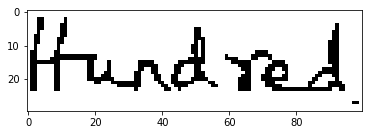

(1, 30, 100, 1)


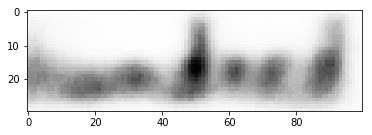

------------------------------End: test------------------------------
Cheque 309139thre2_4.tif Hundred
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.987336   0.16126965 0.04074729 0.02600917 0.06971336 0.05192264
  0.02743873 0.03296308 0.02092511 0.03149083 0.01875442 0.10458067
  0.00473267 0.07267958 0.0195223  0.07490206 0.0334274  0.01372125
  0.0290005  0.01102189 0.08227231 0.02566787 0.02529515 0.01094806
  0.01473092 0.08942587 0.06971154 0.16182345 0.0171678  0.04912191
  0.06281759 0.03046592 0.52752894]]
[0]
0
['One']


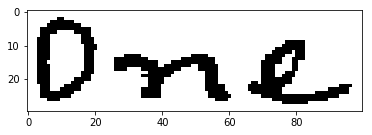

(1, 30, 100, 1)


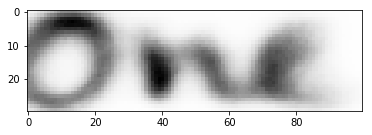

------------------------------End: test------------------------------
Cheque 309141thre2_0.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03340054 0.05787965 0.02859034 0.15397139 0.36861652 0.11144829
  0.33542502 0.13405244 0.17877367 0.06180317 0.04183184 0.10276774
  0.01739693 0.24494717 0.02980334 0.05503818 0.11656964 0.03112637
  0.05173711 0.04735681 0.01630853 0.02984995 0.9788246  0.11692511
  0.02988218 0.02706733 0.05444654 0.47558552 0.12420502 0.10089236
  0.09321007 0.11353357 0.24318472]]
[22]
22
['Three']


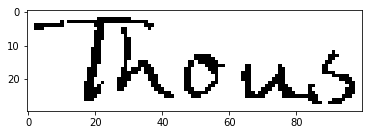

(1, 30, 100, 1)


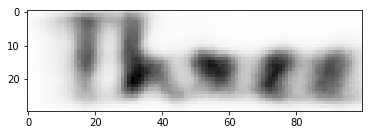

------------------------------End: test------------------------------
Cheque 309141thre2_2.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.13687895 0.3741413  0.2346283  0.01516529 0.16450045 0.06616223
  0.13162446 0.04082244 0.14755997 0.2656439  0.12024476 0.7783523
  0.0553055  0.45357504 0.1272553  0.84008074 0.0467802  0.09999447
  0.12421548 0.13289809 0.55816686 0.12021343 0.10086025 0.41752678
  0.03708434 0.28479585 0.03794679 0.15314259 0.07012953 0.0293134
  0.05408506 0.31957495 0.35028285]]
[15]
15
['Fifty']


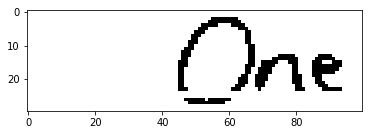

(1, 30, 100, 1)


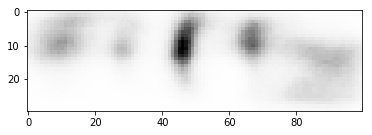

------------------------------End: test------------------------------
Cheque 309142thre2_0.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05791917 0.6425581  0.02660354 0.10048606 0.12373607 0.02189107
  0.02175856 0.05794401 0.06403912 0.11168893 0.05996493 0.11810997
  0.07155637 0.02641283 0.01266681 0.14204268 0.01261769 0.11234692
  0.0386708  0.09270494 0.01293564 0.2059599  0.3521109  0.03130192
  0.03456597 0.72510594 0.15257235 0.20402427 0.08206245 0.08407776
  0.06794012 0.06166179 0.02931461]]
[25]
25
['Lakh']


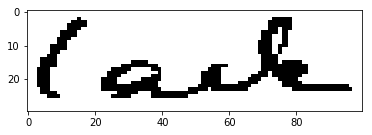

(1, 30, 100, 1)


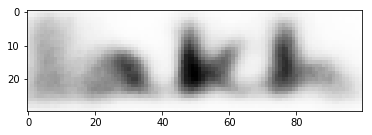

------------------------------End: test------------------------------
Cheque 309142thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[3.65606546e-02 9.85255241e-01 1.20827779e-02 3.79409939e-02
  2.29153521e-02 2.64242925e-02 1.74864549e-02 5.43986447e-02
  2.98764687e-02 5.56632970e-03 1.88490842e-02 3.24433386e-01
  6.88705186e-04 1.93087205e-01 4.29514870e-02 2.54451428e-02
  1.14622325e-01 5.40350005e-02 5.07018976e-02 9.14512854e-03
  5.79012651e-03 9.15933549e-02 4.29914296e-02 7.22842887e-02
  5.03655896e-03 2.00384874e-02 4.31027748e-02 9.53821540e-02
  6.60123080e-02 2.21226551e-02 2.74129789e-02 1.62044878e-03
  8.36521536e-02]]
[1]
1
['Ten']


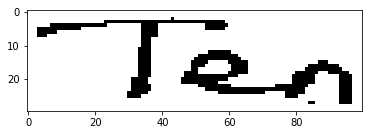

(1, 30, 100, 1)


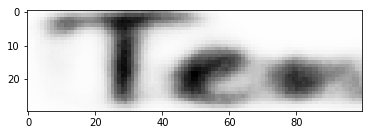

------------------------------End: test------------------------------
Cheque 309142thre2_2.tif Ten
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0434611  0.04089999 0.00781508 0.04166656 0.20906495 0.14056616
  0.17785563 0.03129886 0.03568364 0.00505892 0.07618526 0.04044652
  0.00978622 0.00833331 0.20583488 0.06192565 0.09710974 0.03164269
  0.19149618 0.01954863 0.02761757 0.00842296 0.01660123 0.04677202
  0.9941348  0.0965143  0.07269107 0.05683687 0.00802708 0.07943027
  0.08214233 0.27614382 0.00892038]]
[24]
24
['Thousand']


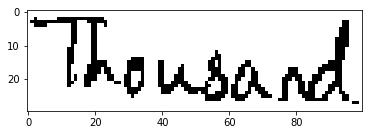

(1, 30, 100, 1)


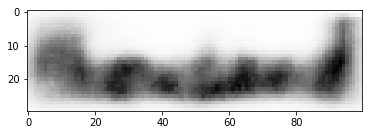

------------------------------End: test------------------------------
Cheque 309142thre2_3.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.20462298 0.05218839 0.04902867 0.87670755 0.19887866 0.10337693
  0.08309776 0.05259407 0.5888061  0.10572289 0.11415847 0.3082918
  0.10906655 0.27382025 0.03984299 0.16833344 0.23906946 0.00960002
  0.07416654 0.09064914 0.02249742 0.05942267 0.2741695  0.32292125
  0.09139836 0.2710067  0.05898181 0.5733888  0.06829309 0.58640796
  0.09853651 0.31517336 0.13595934]]
[3]
3
['Twelve']


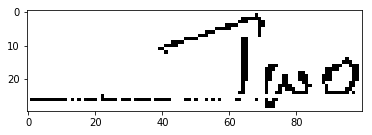

(1, 30, 100, 1)


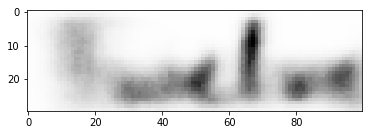

------------------------------End: test------------------------------
Cheque 309144thre2_0.tif Twelve
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01894736 0.2518199  0.04083178 0.01415582 0.02568715 0.03090422
  0.00142954 0.04423171 0.01580908 0.02536602 0.0164048  0.02058684
  0.14261368 0.02767698 0.01103436 0.05066987 0.07776537 0.0071937
  0.02724519 0.02147072 0.01159257 0.09524594 0.02890111 0.05931978
  0.02449443 0.9895377  0.02683742 0.04709866 0.05377737 0.01947095
  0.07790808 0.0192831  0.06562593]]
[25]
25
['Lakh']


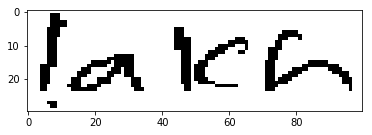

(1, 30, 100, 1)


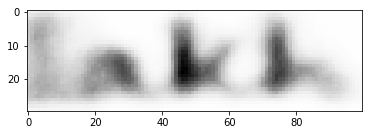

------------------------------End: test------------------------------
Cheque 309144thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.02621968 0.09457445 0.15742977 0.12057128 0.00733023 0.01733517
  0.0390654  0.19977452 0.18149215 0.0041618  0.05618048 0.01470051
  0.0462827  0.04631618 0.20687926 0.12785248 0.9869759  0.01139704
  0.04362904 0.05916979 0.01586055 0.35362977 0.1611214  0.07937019
  0.00767629 0.04463724 0.0655618  0.12428816 0.03101601 0.13773598
  0.13102743 0.02332403 0.02639303]]
[16]
16
['Sixty']


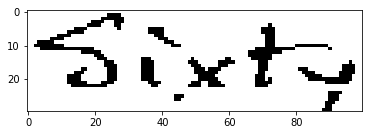

(1, 30, 100, 1)


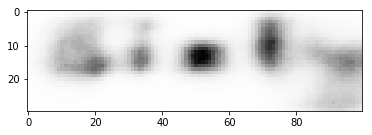

------------------------------End: test------------------------------
Cheque 309144thre2_2.tif Sixty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01909272 0.12582241 0.20063478 0.03301927 0.09221624 0.06594463
  0.02417876 0.0072298  0.05748335 0.03456448 0.05032085 0.18071866
  0.90885717 0.5348403  0.04756032 0.01487062 0.09470806 0.01999133
  0.34887722 0.06127719 0.10084713 0.10077704 0.0045041  0.047867
  0.0629085  0.09449083 0.0167294  0.28990722 0.08631527 0.06367864
  0.16391149 0.04705125 0.1590971 ]]
[12]
12
['Twenty']


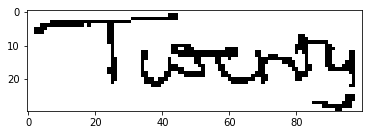

(1, 30, 100, 1)


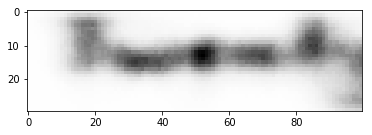

------------------------------End: test------------------------------
Cheque 309145thre2_0.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.16885199 0.6212636  0.14776365 0.13536069 0.0251996  0.03404438
  0.00825282 0.13629112 0.01360651 0.02678582 0.09509429 0.13075787
  0.22951832 0.01440197 0.09479823 0.02757191 0.01622451 0.09318897
  0.01897667 0.01696877 0.04157898 0.09576575 0.53604025 0.151824
  0.05129043 0.10108525 0.03258802 0.13581358 0.05271612 0.11042067
  0.02619894 0.12808402 0.1049211 ]]
[1]
1
['Ten']


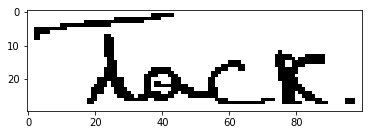

(1, 30, 100, 1)


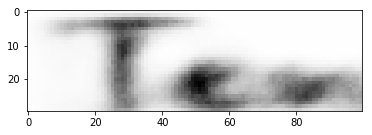

------------------------------End: test------------------------------
Cheque 309145thre2_1.tif Ten
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.14408354 0.22258341 0.05238513 0.03563807 0.05662088 0.03359194
  0.019155   0.13555144 0.04188695 0.042545   0.0082561  0.9946703
  0.00382337 0.02959188 0.02285436 0.01825843 0.17966653 0.01977192
  0.06870095 0.0639426  0.07199851 0.03635061 0.28155103 0.04306247
  0.03325566 0.07924399 0.05072429 0.07937424 0.04854599 0.01354886
  0.06928901 0.02125619 0.01722871]]
[11]
11
['Two']


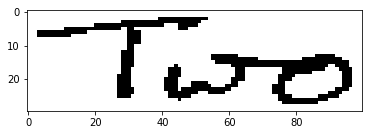

(1, 30, 100, 1)


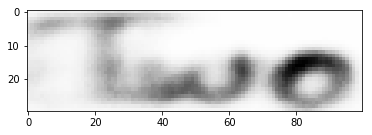

------------------------------End: test------------------------------
Cheque 309145thre2_2.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05497545 0.11710452 0.00352889 0.02989078 0.05239259 0.13726126
  0.05247036 0.02162212 0.02208021 0.01668758 0.10462122 0.0536937
  0.01799026 0.10173417 0.04352305 0.01983906 0.01212573 0.08956605
  0.3622976  0.09334593 0.05463662 0.06089203 0.08812761 0.12462854
  0.9873852  0.02201665 0.09707376 0.13961543 0.00568528 0.10029112
  0.1965016  0.12255587 0.0546168 ]]
[24]
24
['Thousand']


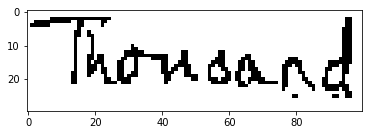

(1, 30, 100, 1)


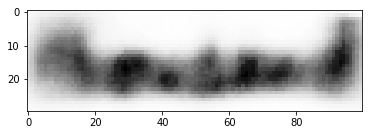

------------------------------End: test------------------------------
Cheque 309145thre2_3.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03234508 0.23547982 0.06764064 0.1593629  0.02025297 0.00535138
  0.07595344 0.02691867 0.09675885 0.02459016 0.02876438 0.04154977
  0.02466136 0.03140274 0.13617074 0.02948772 0.05250796 0.1289482
  0.02316763 0.01423649 0.07971624 0.11610292 0.08285849 0.00558534
  0.0681204  0.03064465 0.11320164 0.13747454 0.99147886 0.06107242
  0.02199849 0.01804906 0.08886218]]
[28]
28
['Five']


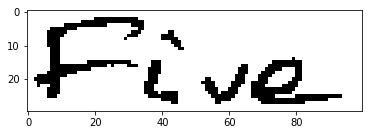

(1, 30, 100, 1)


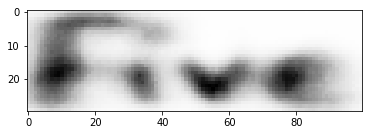

------------------------------End: test------------------------------
Cheque 309147thre2_2.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00547848 0.3025068  0.06861873 0.03884254 0.12823562 0.1361647
  0.18590629 0.07845424 0.0372293  0.04967038 0.0838129  0.02680291
  0.11353081 0.03074558 0.01556001 0.11628798 0.00908281 0.03608841
  0.25253108 0.02560204 0.02016693 0.03211466 0.04941638 0.14232258
  0.9961423  0.04786101 0.08832121 0.07727757 0.03347235 0.12589888
  0.05689069 0.01517558 0.00946761]]
[24]
24
['Thousand']


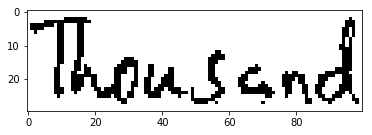

(1, 30, 100, 1)


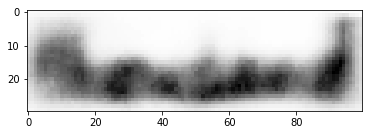

------------------------------End: test------------------------------
Cheque 309147thre2_3.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01584181 0.02967796 0.01656955 0.02286283 0.18128893 0.04325759
  0.09929667 0.00604561 0.0252515  0.02495685 0.02294111 0.03448932
  0.02698989 0.02252695 0.0649489  0.08017654 0.04323946 0.04151512
  0.27503717 0.03848698 0.02584499 0.09657568 0.99567294 0.03963408
  0.00984607 0.00505986 0.1655912  0.02609963 0.02619671 0.04963811
  0.02301108 0.00397447 0.0330103 ]]
[22]
22
['Three']


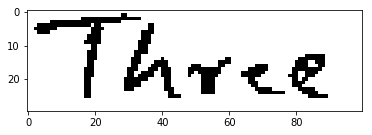

(1, 30, 100, 1)


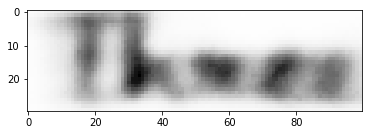

------------------------------End: test------------------------------
Cheque 309148thre2_0.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.09071619 0.3285492  0.04885823 0.2459549  0.0408677  0.01302667
  0.09037977 0.01101293 0.02981079 0.00583249 0.3118185  0.3056307
  0.01161886 0.03972026 0.04386795 0.05842695 0.08392616 0.0532091
  0.13649677 0.06947697 0.01523467 0.09846999 0.08779954 0.02617709
  0.02189598 0.7997888  0.2967979  0.03974246 0.03823374 0.03379499
  0.2560708  0.09742592 0.03429791]]
[25]
25
['Lakh']


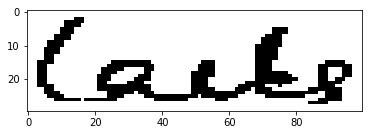

(1, 30, 100, 1)


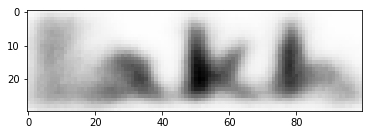

------------------------------End: test------------------------------
Cheque 309148thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00552347 0.14750937 0.18912046 0.02615086 0.00348274 0.00503196
  0.12361783 0.43662336 0.02318462 0.01405943 0.00941607 0.02632892
  0.07931809 0.09476765 0.18860146 0.04053574 0.9878874  0.2265474
  0.0476796  0.0869399  0.01580513 0.22240278 0.01231221 0.06093091
  0.0541058  0.08265027 0.10780773 0.0524109  0.04976738 0.23303548
  0.07456918 0.01839222 0.01550699]]
[16]
16
['Sixty']


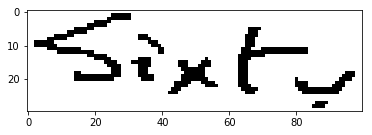

(1, 30, 100, 1)


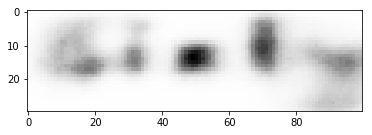

------------------------------End: test------------------------------
Cheque 309148thre2_2.tif Sixty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.99445546 0.01543514 0.08674449 0.02985205 0.02612196 0.0169431
  0.01626958 0.01164726 0.01267515 0.00905525 0.04038593 0.0687293
  0.07765131 0.0371502  0.08641894 0.12833597 0.02109482 0.0138125
  0.01618191 0.00829798 0.10163154 0.2764652  0.02396468 0.06341097
  0.03207709 0.05608831 0.05785    0.03055843 0.07348434 0.02219977
  0.1069285  0.00424798 0.01520979]]
[0]
0
['One']


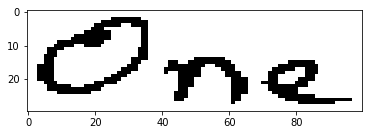

(1, 30, 100, 1)


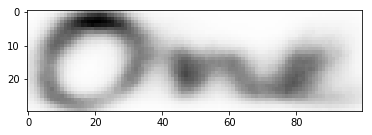

------------------------------End: test------------------------------
Cheque 309149thre2_0.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.23987326 0.02480448 0.06941173 0.00778799 0.08872432 0.03304982
  0.08607347 0.02841113 0.0053417  0.00147558 0.1993515  0.22156169
  0.06897249 0.04931186 0.09027654 0.0149811  0.08751251 0.07129785
  0.04431822 0.03738463 0.02789036 0.12842193 0.07351246 0.01668713
  0.13651805 0.06173444 0.9834756  0.21740715 0.07239141 0.04745186
  0.1515224  0.00509723 0.09186644]]
[26]
26
['Crore']


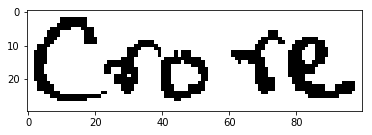

(1, 30, 100, 1)


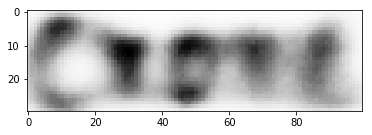

------------------------------End: test------------------------------
Cheque 309149thre2_1.tif Crore
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0375744  0.03600345 0.08631631 0.03183896 0.04730614 0.05918403
  0.06734186 0.14533308 0.04342439 0.09181001 0.01592371 0.02421715
  0.01831381 0.04958733 0.04500598 0.9941554  0.21636046 0.05364018
  0.00879765 0.04241927 0.11467144 0.11103675 0.3737804  0.0977329
  0.03594752 0.23183024 0.04405681 0.11489654 0.1165271  0.01778196
  0.04508787 0.01736249 0.05374011]]
[15]
15
['Fifty']


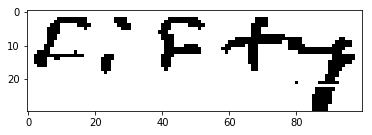

(1, 30, 100, 1)


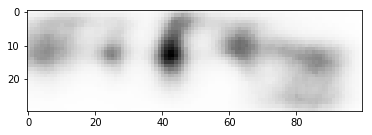

------------------------------End: test------------------------------
Cheque 309149thre2_2.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.33336493 0.13274033 0.01417662 0.03118013 0.0235988  0.0117724
  0.10374217 0.01258773 0.07246282 0.00773549 0.01342453 0.1229541
  0.14517137 0.02933597 0.04601294 0.04181328 0.04536463 0.10545912
  0.11192144 0.03473515 0.06584103 0.02061666 0.10798802 0.03481051
  0.01636785 0.99102044 0.02643409 0.15345523 0.0260219  0.1535718
  0.10530064 0.0704212  0.03188771]]
[25]
25
['Lakh']


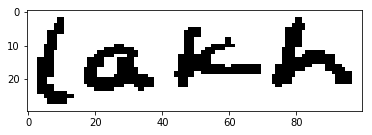

(1, 30, 100, 1)


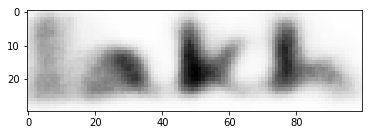

------------------------------End: test------------------------------
Cheque 309149thre2_3.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.97441036 0.03431355 0.06812479 0.11106723 0.03483582 0.12459683
  0.03020757 0.03067791 0.03742421 0.00961768 0.1314586  0.19418865
  0.02407835 0.02428545 0.20870508 0.07360052 0.11431897 0.0512758
  0.01405083 0.03970173 0.17761743 0.09804609 0.47854373 0.05790111
  0.01986254 0.0512077  0.17473897 0.13628839 0.04382579 0.15335062
  0.0087434  0.15192436 0.06720188]]
[0]
0
['One']


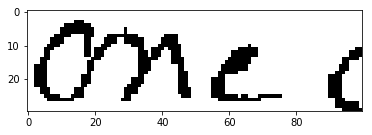

(1, 30, 100, 1)


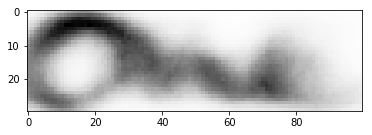

------------------------------End: test------------------------------
Cheque 309150thre2_0.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00790526 0.05940937 0.01007012 0.03800019 0.00373752 0.04507387
  0.05570931 0.05248284 0.16141893 0.01535752 0.11721805 0.00866608
  0.9873046  0.89332086 0.04149377 0.01916131 0.08466905 0.1692009
  0.03602207 0.02231904 0.0039328  0.20765173 0.08737214 0.04282971
  0.08440028 0.09614979 0.0726818  0.12803228 0.05739597 0.01527527
  0.01415073 0.06920324 0.0302328 ]]
[12]
12
['Twenty']


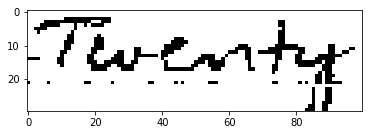

(1, 30, 100, 1)


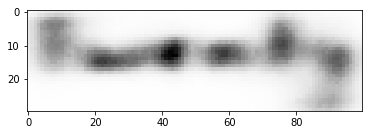

------------------------------End: test------------------------------
Cheque 309150thre2_1.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.07692984 0.12354556 0.03011041 0.04565403 0.20722002 0.01114279
  0.04616622 0.09195011 0.03575814 0.00999455 0.02096733 0.06885774
  0.08431532 0.07358035 0.03805599 0.06139838 0.0856467  0.17622852
  0.08125474 0.13927865 0.01220995 0.01671311 0.05308352 0.01411496
  0.03752481 0.9599567  0.3189727  0.03698682 0.05708957 0.02833245
  0.06449085 0.20850976 0.26311907]]
[25]
25
['Lakh']


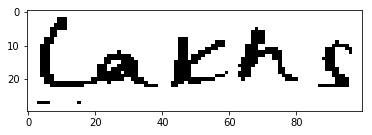

(1, 30, 100, 1)


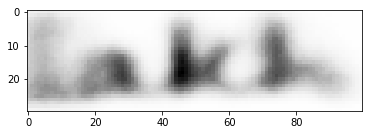

------------------------------End: test------------------------------
Cheque 309150thre2_2.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04997166 0.01276217 0.01608253 0.04414373 0.18712088 0.26196024
  0.05446793 0.07110883 0.19019403 0.10351362 0.03647635 0.03002796
  0.35638505 0.7241602  0.98327166 0.0326385  0.11825552 0.01668327
  0.05862327 0.01167254 0.02033836 0.00524599 0.16982831 0.00764275
  0.02522668 0.08715767 0.0882973  0.0392393  0.01143103 0.02301778
  0.10778498 0.2872538  0.01571303]]
[14]
14
['Forty']


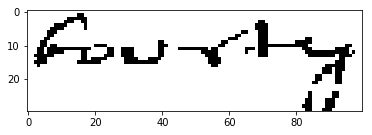

(1, 30, 100, 1)


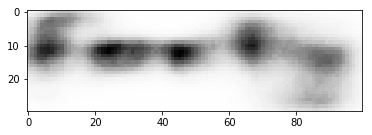

------------------------------End: test------------------------------
Cheque 309150thre2_3.tif Forty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.13922743 0.10243778 0.00874677 0.04603617 0.01345432 0.06053346
  0.15231907 0.12956136 0.07267996 0.00861022 0.05183659 0.07940514
  0.23894323 0.29892546 0.09389441 0.09991915 0.4111581  0.593346
  0.26890415 0.18703455 0.4310311  0.08668869 0.00582908 0.10830721
  0.924747   0.01352574 0.2336183  0.18339822 0.07511347 0.07734887
  0.01622391 0.03115278 0.06211603]]
[24]
24
['Thousand']


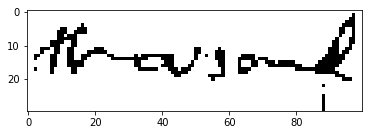

(1, 30, 100, 1)


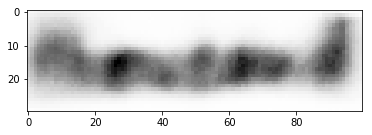

------------------------------End: test------------------------------
Cheque 309150thre2_4.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.93403035 0.0425152  0.1035597  0.03842618 0.02721373 0.02862831
  0.02823405 0.16554855 0.0161884  0.07860325 0.00931508 0.06483732
  0.12086574 0.05265271 0.1729089  0.0509639  0.09411401 0.03955973
  0.02932629 0.16137427 0.04205061 0.05528062 0.08728105 0.12788554
  0.01775213 0.01484243 0.0116555  0.13064255 0.27602878 0.20116308
  0.11258982 0.5473893  0.90216255]]
[0]
0
['One']


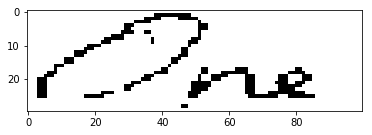

(1, 30, 100, 1)


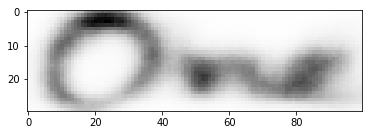

------------------------------End: test------------------------------
Cheque 309151thre2_0.tif One
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.1480574  0.10936122 0.1169344  0.15128915 0.18631253 0.17505594
  0.06915903 0.23569211 0.03941033 0.01050474 0.15338063 0.06872983
  0.24109842 0.11226323 0.08379938 0.1260635  0.08533648 0.06214415
  0.08207231 0.15904711 0.01762098 0.04407251 0.69557846 0.04492772
  0.11096773 0.02854962 0.4778821  0.7200163  0.20030983 0.02655653
  0.10042124 0.15710093 0.37011206]]
[27]
27
['Four']


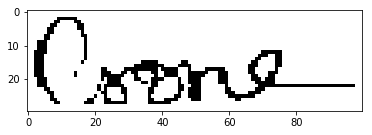

(1, 30, 100, 1)


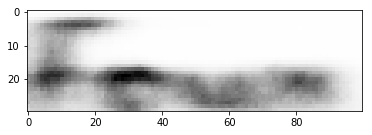

------------------------------End: test------------------------------
Cheque 309151thre2_1.tif Four
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00609858 0.0073517  0.00212175 0.07454484 0.06146863 0.4049347
  0.03904621 0.18888098 0.00704333 0.14094293 0.08801688 0.01075612
  0.52103585 0.8274826  0.91558975 0.02445231 0.05000794 0.28836715
  0.01555801 0.2114922  0.01605764 0.01511586 0.10988298 0.04523689
  0.02639557 0.0578449  0.04707091 0.05692523 0.01401743 0.02391546
  0.1287346  0.11423425 0.00962472]]
[14]
14
['Forty']


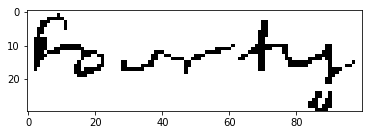

(1, 30, 100, 1)


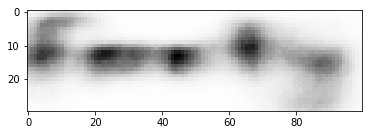

------------------------------End: test------------------------------
Cheque 309151thre2_2.tif Forty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.16251467 0.07838643 0.0797167  0.881823   0.04988123 0.01436341
  0.00484405 0.16336606 0.01002542 0.01522086 0.0303942  0.03788171
  0.239511   0.01327452 0.20727983 0.08582252 0.12385615 0.04321035
  0.04712762 0.06567018 0.02854004 0.06677871 0.07519584 0.04974344
  0.06225136 0.44332746 0.16519272 0.05191522 0.04736343 0.0092874
  0.1885412  0.05651912 0.60587996]]
[3]
3
['Twelve']


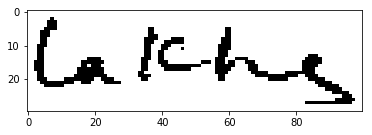

(1, 30, 100, 1)


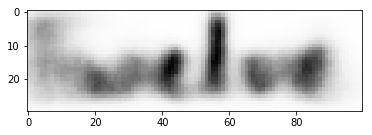

------------------------------End: test------------------------------
Cheque 309151thre2_3.tif Twelve
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.6043972  0.28469247 0.01700796 0.02426385 0.01459565 0.3351759
  0.0805085  0.0956923  0.0899058  0.10454355 0.11768166 0.04667587
  0.21600915 0.3297691  0.00727946 0.09844414 0.15477799 0.14401807
  0.3312922  0.04579972 0.0281563  0.02607243 0.8432827  0.08051
  0.4741777  0.0190077  0.34692863 0.11779194 0.01052679 0.04144662
  0.10611027 0.04486031 0.02747666]]
[22]
22
['Three']


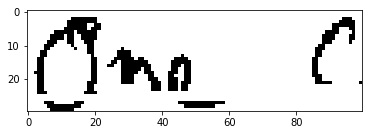

(1, 30, 100, 1)


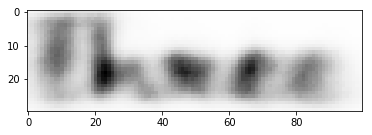

------------------------------End: test------------------------------
Cheque 309153thre2_0.tif Three
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.5377793  0.00812902 0.06392837 0.0618217  0.1742805  0.02686287
  0.36341065 0.41375205 0.28389558 0.00564709 0.19766378 0.33288807
  0.10260263 0.02027076 0.04571164 0.11020587 0.18068203 0.9926915
  0.04811199 0.07370456 0.03975747 0.07570928 0.0755851  0.07853564
  0.00368094 0.03908793 0.03546697 0.07301543 0.17464209 0.02110478
  0.06873018 0.00414746 0.03549772]]
[17]
17
['Seventy']


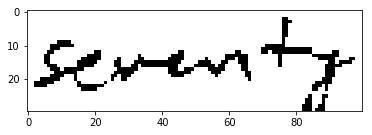

(1, 30, 100, 1)


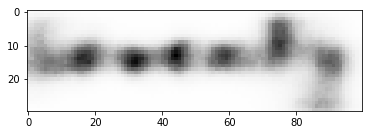

------------------------------End: test------------------------------
Cheque 309153thre2_1.tif Seventy
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.03238383 0.21952745 0.01762418 0.0258516  0.01626606 0.02459087
  0.03921906 0.11456843 0.02927922 0.03166714 0.03575994 0.04001263
  0.06013329 0.00232754 0.15948236 0.08127309 0.03496778 0.03083749
  0.04558029 0.08481359 0.01017423 0.03966831 0.05649174 0.07653117
  0.14180173 0.02239224 0.09823543 0.02036051 0.9911596  0.07841971
  0.03591779 0.11790405 0.06895208]]
[28]
28
['Five']


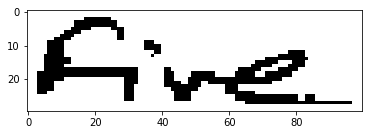

(1, 30, 100, 1)


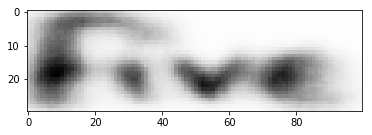

------------------------------End: test------------------------------
Cheque 309153thre2_2.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.11797833 0.00457144 0.04649983 0.08837206 0.13073385 0.1904852
  0.02244061 0.01773645 0.0674901  0.00655115 0.01616602 0.04741789
  0.12572333 0.00451791 0.0787641  0.07592108 0.07950277 0.18396579
  0.03053668 0.11788213 0.07650214 0.02112934 0.14396705 0.01515946
  0.01103463 0.8946465  0.32060248 0.08190637 0.05856408 0.09629984
  0.10852731 0.04448752 0.34305096]]
[25]
25
['Lakh']


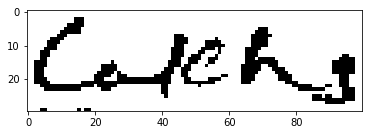

(1, 30, 100, 1)


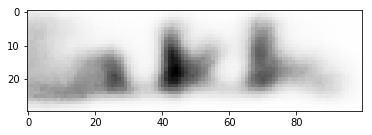

------------------------------End: test------------------------------
Cheque 309153thre2_3.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.10490634 0.27388588 0.07878055 0.00954192 0.09361568 0.02707067
  0.01149148 0.05278404 0.04759374 0.06030712 0.00979933 0.9690345
  0.00856073 0.03109909 0.03990568 0.5458816  0.05311337 0.05909877
  0.12197287 0.06414787 0.05334222 0.10170084 0.3278544  0.11136371
  0.04536446 0.04961513 0.03918994 0.10615367 0.03790232 0.01446679
  0.14330237 0.04054295 0.11090878]]
[11]
11
['Two']


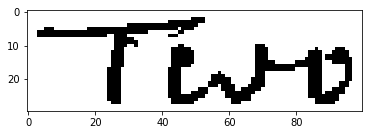

(1, 30, 100, 1)


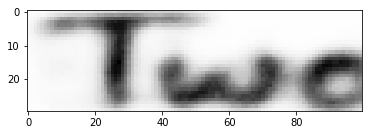

------------------------------End: test------------------------------
Cheque 309155thre2_0.tif Two
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.05946693 0.18483058 0.09208451 0.02706476 0.11027987 0.06336216
  0.00538912 0.08720676 0.01487828 0.00402872 0.00915772 0.15852289
  0.00448593 0.0514655  0.10547128 0.27356255 0.11246103 0.018066
  0.19826494 0.16120854 0.01706431 0.02114702 0.17770553 0.0363463
  0.08096533 0.9837344  0.13538206 0.02526941 0.11355977 0.04187563
  0.24842022 0.0272108  0.23570542]]
[25]
25
['Lakh']


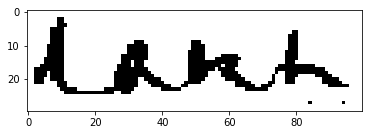

(1, 30, 100, 1)


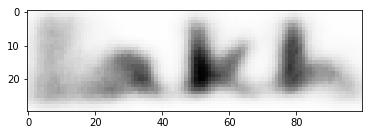

------------------------------End: test------------------------------
Cheque 309155thre2_1.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0174832  0.97607964 0.00841938 0.01417717 0.04549622 0.08516961
  0.1468997  0.03243963 0.06626772 0.01722484 0.05587638 0.56715906
  0.00878086 0.06245212 0.08160395 0.01233077 0.07741278 0.07275359
  0.02409675 0.03950325 0.02305772 0.08342372 0.05663675 0.01237538
  0.04494545 0.00708499 0.03848103 0.17838319 0.06648405 0.055411
  0.01213347 0.00589562 0.01083818]]
[1]
1
['Ten']


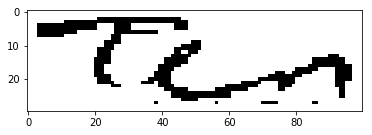

(1, 30, 100, 1)


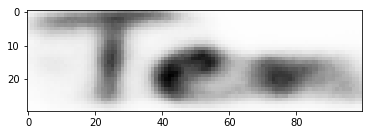

------------------------------End: test------------------------------
Cheque 309155thre2_2.tif Ten
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.1716488  0.01277432 0.06119062 0.0206129  0.16262132 0.04703955
  0.18122143 0.0980815  0.06863033 0.01057179 0.04417178 0.04833627
  0.23675717 0.11319114 0.06047579 0.07077062 0.17636678 0.11144199
  0.09918717 0.01704158 0.05747496 0.06661842 0.2252316  0.08137982
  0.99286664 0.11386439 0.00780105 0.01428765 0.15407637 0.02107949
  0.02995018 0.05039368 0.79040706]]
[24]
24
['Thousand']


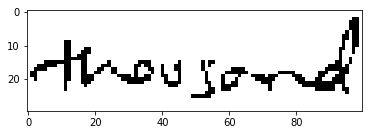

(1, 30, 100, 1)


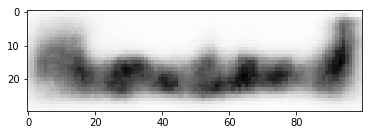

------------------------------End: test------------------------------
Cheque 309155thre2_3.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.13375029 0.03301959 0.02860946 0.15395063 0.23501003 0.14592443
  0.26291817 0.22904116 0.08159286 0.01644098 0.3751551  0.17640467
  0.02772164 0.01698643 0.01469128 0.04736008 0.03550133 0.03682865
  0.06507966 0.01989718 0.03062372 0.00669838 0.03896477 0.9944593
  0.09339453 0.03235912 0.03414357 0.0467824  0.01943296 0.03410672
  0.02253949 0.05893846 0.18209063]]
[23]
23
['Hundred']


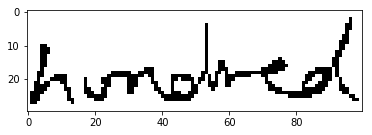

(1, 30, 100, 1)


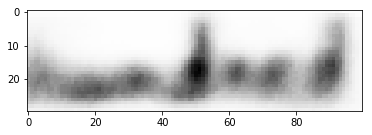

------------------------------End: test------------------------------
Cheque 309155thre2_5.tif Hundred
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01559559 0.08081142 0.04603898 0.03706144 0.2336363  0.04630752
  0.15073943 0.23501812 0.03253401 0.17265716 0.03085964 0.05114691
  0.03237152 0.02459422 0.02541252 0.99456    0.00520661 0.00930603
  0.07191456 0.05656772 0.06791577 0.04458819 0.18804878 0.21370292
  0.01622766 0.09015942 0.05503545 0.05283541 0.0456061  0.11877387
  0.05594739 0.04398662 0.07238802]]
[15]
15
['Fifty']


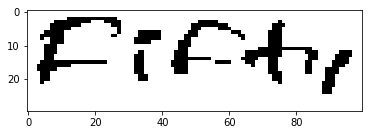

(1, 30, 100, 1)


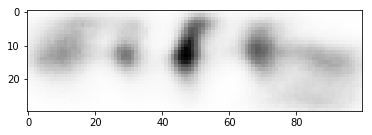

------------------------------End: test------------------------------
Cheque 309156thre2_0.tif Fifty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.33771572 0.04183735 0.01983727 0.02715943 0.0253146  0.2598237
  0.22774072 0.12373921 0.0266818  0.04982242 0.01603187 0.25917944
  0.4578556  0.6009921  0.31150517 0.02090985 0.19423692 0.46375117
  0.1266072  0.11678533 0.03183892 0.08137524 0.19130254 0.10953236
  0.02595007 0.45036232 0.26675725 0.5993745  0.01813821 0.08408061
  0.02111612 0.24227637 0.02750634]]
[13]
13
['Thirty']


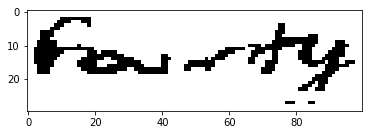

(1, 30, 100, 1)


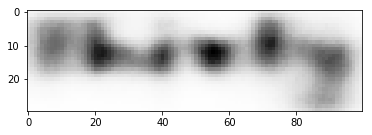

------------------------------End: test------------------------------
Cheque 309156thre2_2.tif Thirty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04849846 0.12042317 0.01721435 0.02381152 0.00862599 0.2765532
  0.38505253 0.18824835 0.08507087 0.0289024  0.11024237 0.05211289
  0.36737573 0.38235041 0.06192588 0.10582554 0.24771024 0.01249878
  0.05723902 0.18046267 0.25460863 0.0483306  0.02015601 0.01336514
  0.99361736 0.06171597 0.1731392  0.13732919 0.02383097 0.04100069
  0.03238156 0.04879379 0.16548856]]
[24]
24
['Thousand']


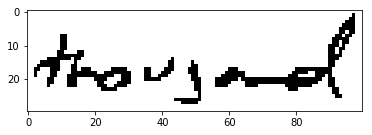

(1, 30, 100, 1)


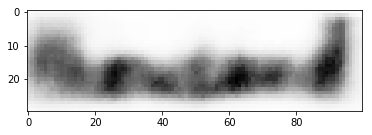

------------------------------End: test------------------------------
Cheque 309156thre2_3.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00694554 0.30367982 0.03273691 0.02899883 0.10213042 0.03654503
  0.06267159 0.02313903 0.01901292 0.05801266 0.0186085  0.05270647
  0.9926723  0.9061876  0.04771625 0.02883877 0.0196671  0.04005727
  0.14076379 0.02714256 0.01286124 0.03802399 0.16216327 0.00853928
  0.01483207 0.15578131 0.16257516 0.09431645 0.0377794  0.03201757
  0.18229711 0.03639509 0.09114983]]
[12]
12
['Twenty']


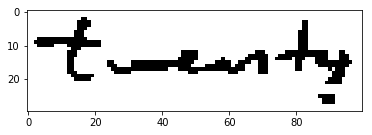

(1, 30, 100, 1)


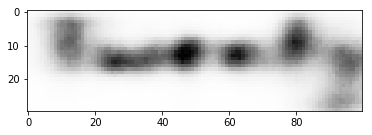

------------------------------End: test------------------------------
Cheque 309157thre2_1.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.01530517 0.33885393 0.03093623 0.02943263 0.01080843 0.00842258
  0.09379327 0.00937628 0.02152025 0.08170143 0.0097373  0.2796827
  0.01713702 0.11177202 0.270919   0.13259657 0.01095564 0.04057692
  0.10853798 0.03919806 0.02794838 0.02846423 0.01265888 0.05656346
  0.02262725 0.02327976 0.01465255 0.24728793 0.98822886 0.05815244
  0.11618973 0.02046528 0.05000341]]
[28]
28
['Five']


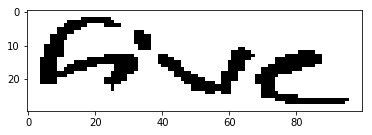

(1, 30, 100, 1)


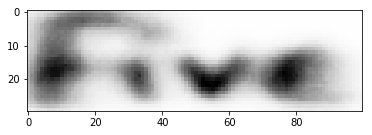

------------------------------End: test------------------------------
Cheque 309157thre2_2.tif Five
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.11109468 0.11726699 0.03059082 0.02074087 0.01494336 0.01418647
  0.14059828 0.0837784  0.04991834 0.05938466 0.10374101 0.0371962
  0.14333417 0.03945105 0.01769126 0.11252141 0.08513778 0.09776901
  0.00880875 0.00638353 0.02177357 0.00913428 0.06680645 0.080209
  0.9938982  0.10527356 0.01350749 0.08600628 0.1731728  0.06925378
  0.04350708 0.068384   0.17494181]]
[24]
24
['Thousand']


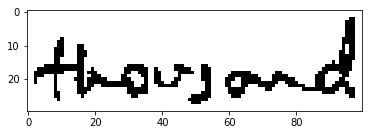

(1, 30, 100, 1)


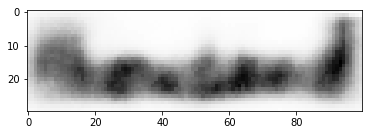

------------------------------End: test------------------------------
Cheque 309157thre2_3.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.09693209 0.05913662 0.1891411  0.14660542 0.05654467 0.0585243
  0.04872617 0.1340838  0.13066377 0.01469331 0.0259481  0.08445732
  0.09058969 0.01666924 0.1453339  0.48342016 0.0258913  0.04868802
  0.01526643 0.01907483 0.00701637 0.05282065 0.35637325 0.11201122
  0.01036909 0.03445812 0.01193229 0.89190745 0.1587286  0.21281703
  0.07970007 0.03868084 0.11401856]]
[27]
27
['Four']


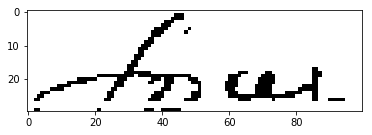

(1, 30, 100, 1)


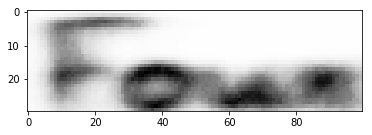

------------------------------End: test------------------------------
Cheque 309158thre2_0.tif Four
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.23094162 0.16552672 0.09871606 0.07505582 0.02699191 0.23457764
  0.01679667 0.0078062  0.01633928 0.0700627  0.13821949 0.14661421
  0.0602547  0.0219291  0.02960668 0.15737242 0.10151228 0.03174173
  0.02601689 0.03358363 0.08686797 0.0930563  0.27861091 0.01924428
  0.0226742  0.01781832 0.839257   0.14746487 0.05852043 0.01639215
  0.13824916 0.10502174 0.08940446]]
[26]
26
['Crore']


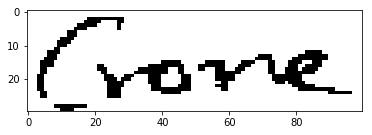

(1, 30, 100, 1)


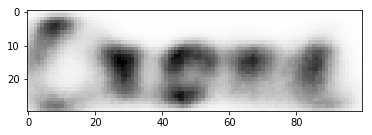

------------------------------End: test------------------------------
Cheque 309158thre2_1.tif Crore
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00450908 0.01689226 0.01909028 0.22536016 0.04339046 0.23607269
  0.02916825 0.00868989 0.69249386 0.02996363 0.1640638  0.16545965
  0.98369884 0.04131487 0.04992409 0.02176019 0.06016304 0.18902363
  0.15202345 0.07816519 0.01128296 0.07587966 0.16936974 0.00352468
  0.02811019 0.01706278 0.06396433 0.01012769 0.15688299 0.04599754
  0.04863717 0.01572025 0.06599809]]
[12]
12
['Twenty']


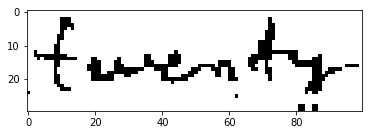

(1, 30, 100, 1)


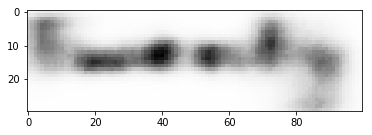

------------------------------End: test------------------------------
Cheque 309158thre2_2.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0699409  0.03795014 0.0381134  0.02313818 0.17117065 0.02126593
  0.0019918  0.00289256 0.11389127 0.04466173 0.01657457 0.11215445
  0.06314417 0.00923327 0.25098103 0.0693994  0.11522359 0.04398713
  0.07928818 0.17433177 0.22848374 0.32519197 0.12495392 0.00800831
  0.03665325 0.6332571  0.09514339 0.02852916 0.0247538  0.10724453
  0.03992166 0.09791229 0.29170644]]
[25]
25
['Lakh']


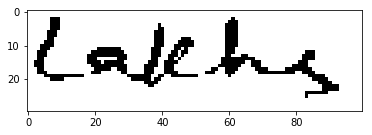

(1, 30, 100, 1)


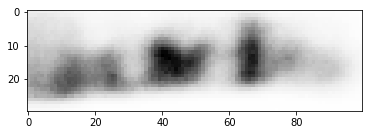

------------------------------End: test------------------------------
Cheque 309158thre2_3.tif Lakh
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[1.10391058e-01 3.05050202e-02 9.86223482e-03 9.90967453e-01
  1.42684981e-01 2.56443173e-02 4.59793992e-02 1.06370807e-01
  1.81323871e-01 6.99298864e-04 4.28022817e-02 3.52552980e-01
  3.03234965e-01 3.11017428e-02 1.17481956e-02 8.68961811e-02
  1.61638930e-01 7.95341432e-02 6.56126291e-02 3.11871320e-01
  1.16161868e-01 1.53151574e-02 5.67662232e-02 2.60123491e-01
  3.93543653e-02 5.90429530e-02 2.08929434e-01 1.71553761e-01
  1.12213634e-01 5.72610050e-02 5.86787127e-02 3.83673087e-02
  1.36956619e-02]]
[3]
3
['Twelve']


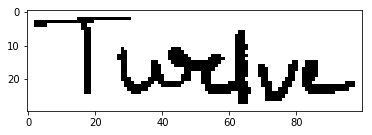

(1, 30, 100, 1)


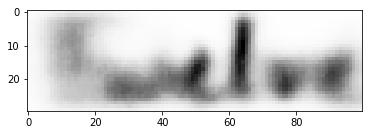

------------------------------End: test------------------------------
Cheque 309159thre2_0.tif Twelve
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.08610661 0.08118702 0.02795997 0.1282437  0.07600449 0.06699806
  0.01087833 0.01358438 0.00486842 0.05958683 0.00798928 0.32083502
  0.06946152 0.15027602 0.0449     0.01226339 0.03405045 0.0692509
  0.01176665 0.11326686 0.02741159 0.05913054 0.49777195 0.21442334
  0.0249119  0.58166087 0.0255971  0.22223504 0.09110094 0.60811025
  0.19808128 0.01423253 0.06934561]]
[29]
29
['Six']


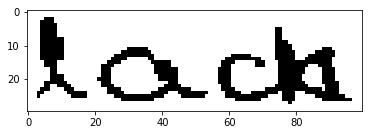

(1, 30, 100, 1)


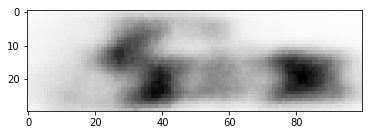

------------------------------End: test------------------------------
Cheque 309159thre2_1.tif Six
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.0338556  0.03290936 0.02897656 0.09142356 0.01832914 0.3478496
  0.05831577 0.03684439 0.09968385 0.04611579 0.21202481 0.50457984
  0.9742402  0.03350288 0.09824137 0.04025409 0.04115903 0.15659377
  0.07776189 0.02948718 0.02208198 0.02631591 0.03906018 0.07102711
  0.00275914 0.04798008 0.01349446 0.07025069 0.0346728  0.05288345
  0.04641087 0.03643823 0.23722714]]
[12]
12
['Twenty']


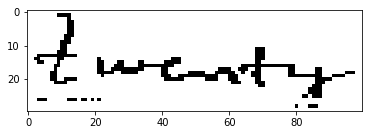

(1, 30, 100, 1)


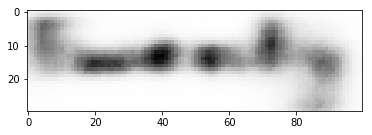

------------------------------End: test------------------------------
Cheque 309159thre2_2.tif Twenty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.14795755 0.14665371 0.095588   0.00287367 0.30471888 0.09395991
  0.3112189  0.06411877 0.12379812 0.05399823 0.2507029  0.09861726
  0.3994474  0.39845976 0.02419812 0.18104315 0.18036933 0.17956215
  0.1593266  0.01238146 0.06175516 0.03643907 0.23459111 0.06137409
  0.9923943  0.10118096 0.00482432 0.01896981 0.01531271 0.02733668
  0.02611954 0.1197914  0.27604562]]
[24]
24
['Thousand']


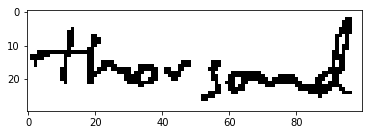

(1, 30, 100, 1)


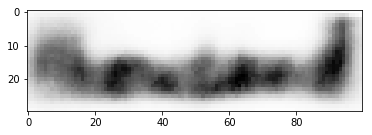

------------------------------End: test------------------------------
Cheque 309159thre2_3.tif Thousand
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.00671422 0.02355248 0.08502979 0.0155904  0.17337014 0.01228422
  0.07826655 0.01468355 0.00260708 0.02272739 0.00642798 0.4026337
  0.20130673 0.99510723 0.10315914 0.0603703  0.20086831 0.04810234
  0.03134289 0.01835993 0.04430042 0.09583745 0.00187579 0.06752267
  0.00926561 0.03726062 0.0943893  0.04154184 0.03281997 0.01492136
  0.06537703 0.14544563 0.02385745]]
[13]
13
['Thirty']


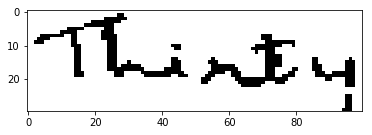

(1, 30, 100, 1)


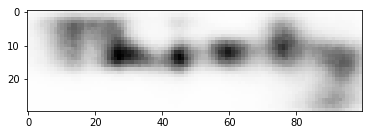

------------------------------End: test------------------------------
Cheque 309160thre2_0.tif Thirty
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[[0.04310306 0.20314944 0.03255407 0.16152573 0.12975474 0.06628662
  0.19593513 0.0542659  0.18360876 0.02250895 0.1474172  0.0949117
  0.02753446 0.13858248 0.25370327 0.05148486 0.05696126 0.01582603
  0.1703774  0.04596886 0.01894142 0.01410569 0.29109693 0.17432347
  0.99441373 0.13152495 0.06472521 0.03426271 0.02733995 0.03485185
  0.01315258 0.01297403 0.02702759]]
[24]
24
['Thousand']


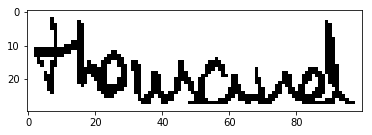

(1, 30, 100, 1)


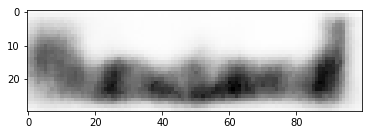

------------------------------End: test------------------------------
Cheque 309160thre2_1.tif Thousand


In [8]:
import os
import argparse
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.models import load_model



class Args:
    batch_size = 20
    epochs = 35
    lr = 0.001
    lr_decay = 0.9
    lam_recon = 1.5 #0.392
    routings = 3
    shift_fraction = 0.1
    debug = 0
    save_dir = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_writer_conv_added'
#     save_dir = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_writer_3'

#     save_dir = '/content/sample_data/e/'
    is_training = 0
#     digit = 5
#     weights = None
    weights = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_writer_3/weights-29.h5'
# #    weights = "/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_4/trained_model_15_epochs.h5"

args = Args()
#     print(args)

if not os.path.exists(args.save_dir):
    os.makedirs(args.save_dir)

# load data
#     (x_train, y_train), (x_val, y_val) = load_amount_data()

# define model
model, eval_model, manipulate_model = CapsNet(input_shape=(30,100,1),
                                              n_class=33,
                                              routings=args.routings)

model.summary()


# train or test
if args.weights is not None:  # init the model weights with provided one
    model.load_weights(args.weights)
if args.is_training:
    train(model=model, args=args)
else:  # as long as weights are given, will run testing
    if args.weights is None:
        print('No weights are provided. Will test using random initialized weights.')
#         manipulate_latent(manipulate_model, (x_test, y_test), args)
#         test(model=eval_model, data=(x_test, y_test), args=args)
    x_test, classes, class_indices, filenames = load_prediction_data()
    print(x_test.shape)
    correct = 0
    wrong = 0
    exceptions = 0
    for i in range(0, x_test.shape[0]):
        test_my_data(model=eval_model, data=x_test[i:i+1,], args=args, class_indices = class_indices, filename = filenames[i:i+1])
#         answer = input()
#         if (answer == '1'):
#           correct += 1
#         elif(answer == '0'):
#           wrong += 1
#         else:
#           exceptions += 1
#     print (correct, wrong, exceptions)

In [0]:
model.save('/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_writer_conv_added/my_model.h5')

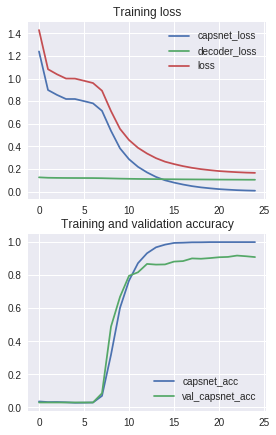

In [0]:
plot_log(args.save_dir + '/log.csv', show=True)

## Test

### Load data and model

In [0]:
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.models import Model


def load_prediction_data(file_path,number_of_images = None):
    # the data, shuffled and split between train and test sets
    pred_data = None
#     dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/"
    dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/ISIHWD_WRITER/writer_1/"
    pred_file_path = file_path
    classes = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
    classes.sort()
    class_indices = dict(zip(classes, range(len(classes))))
    print (class_indices)
    classes, filenames = _list_valid_filenames_in_directory(dir_path,
                                                            white_list_formats = {'png', 'jpg', 'jpeg', 'bmp', 'ppm'},
                                                            class_indices = class_indices,
                                                            follow_links = True,
                                                            triplet_path = pred_file_path)
#     dirs = glob.glob(dir_path + "*/")
#     print (dirs)
    print (len(filenames))
    i = 0
    if not number_of_images:
      number_of_images = len(filenames)
      
    for filepath in filenames:
      if i >= number_of_images:
          break
      i += 1
      if i%50 == 0:
          print ("{} files completed".format(i))
      __, filename = os.path.split(filepath)
      img = image.load_img(filepath, target_size=(30, 100), grayscale = True)
      x = image.img_to_array(img)
      x = x.astype('float32') / 255.
      if pred_data is None:
        pred_data = np.array([x])
      else:
        pred_data = np.concatenate((pred_data, [x]))
    #     img_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/position_1.tif"

    print(pred_data.shape)
    return pred_data, classes, class_indices

# train_file_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/train_set.txt'
test_file_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/isihwd_writer_wise_train_test/isihwd_test.txt'
weights_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_writer_3/weights-30.h5'
caps_model, caps_eval_model, manipulate_model = CapsNet(input_shape=(30,100,1),
                                              n_class=33,
                                              routings=3)

caps_eval_model.summary()

caps_eval_model.load_weights(weights_path)
# caps_model.compile(optimizer=optimizers.Adam(lr=0.001),
#                   loss=[margin_loss, 'mse'],
#                   loss_weights=[1., 1.5],
#                   metrics={'capsnet': 'accuracy'})

# model = Model(input=caps_eval_model.input, output=Flatten()(caps_eval_model.get_layer('digitcaps').output))

# model.summary()

# train_output_data, train_classes, class_indices = load_prediction_data(train_file_path)
number_of_images = None
test_output_data, test_classes, __ = load_prediction_data(test_file_path, number_of_images = number_of_images)
# test_classes = test_classes[:number_of_images]
# print (train_output_data.shape, len(train_classes))
print (test_output_data.shape, len(test_classes))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 30, 100, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 22, 92, 256)  20992       input_4[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 7, 42, 256)   5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 9408, 8)      0           primarycap_conv2d[0][0]          
__________________________________________________________________________________________________
primarycap

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


50 files completed
100 files completed
150 files completed
200 files completed
250 files completed
300 files completed
350 files completed
400 files completed
450 files completed
500 files completed
550 files completed
600 files completed
650 files completed
700 files completed
750 files completed
800 files completed
850 files completed
900 files completed
950 files completed
1000 files completed
1050 files completed
1100 files completed
1150 files completed
1200 files completed
1250 files completed
1300 files completed
1350 files completed
1400 files completed
1450 files completed
1500 files completed
1550 files completed
1600 files completed
1650 files completed
1700 files completed
1750 files completed
1800 files completed
1850 files completed
1900 files completed
1950 files completed
2000 files completed
2050 files completed
2100 files completed
2150 files completed
2200 files completed
2250 files completed
2300 files completed
2350 files completed
2400 files completed
2450 files c

### Extract values of capsnet

In [0]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
import numpy as np
import h5py
import os

# trainData = model.predict(train_output_data, batch_size=10, verbose=1)
# print (trainData.shape)
# trainLabels = np.array(train_classes).reshape(len(train_classes),1)
# print (trainLabels.shape)


testData, x_recon = caps_eval_model.predict(test_output_data, batch_size=10, verbose=1)

# print (x_recon.shape)
# x_recon[i,:,:,0] = x_recon[i,:,:,0] * 255
# for i in range(10):
#   plt.imshow(x_recon[i,:,:,0], cmap=plt.get_cmap('gray'))
#   plt.show()
# new = x_recon[0,:,:,0].reshape((30*100,1))
# print (new.shape)
# print (new)
# print (testData.shape)
testLabels = np.array(test_classes).reshape(len(test_classes),1)
print (testLabels.shape)

print ("[INFO] splitted train and test data...")
# print ("[INFO] train data  : {}".format(trainData.shape))
print ("[INFO] test data   : {}".format(testData.shape))
# print ("[INFO] train labels: {}".format(trainLabels.shape))
print ("[INFO] test labels : {}".format(testLabels.shape))

# use logistic regression as the model
print ("[INFO] creating model...")
# svm_model = svm.SVC(kernel = 'linear',probability = True)
# caps_eval_model.fit(trainData, trainLabels)

print ("[INFO] evaluating model...")

# rank_1 = 0

# for (label, features) in zip(testLabels, testData):
#   # predict the probability of each class label and
#   # take the top-5 class labels
#   #print(label,features)
#   predictions = caps_eval_model.predict(np.atleast_2d(features))[0]
#   #print("prediction_prob : ",predictions)
#   predictions = np.argsort(predictions)[::-1][:2]
#   if label == predictions[0]:
#     rank_1 += 1


# print (data.shape)
x_test = test_output_data
y_pred = testData
# y_pred, x_recon = model.predict(x_test, batch_size=1)
# print('-'*30 + 'Begin: Prediction' + '-'*30)
#     print('-'*30 + y_pred + '-'*30)
print(y_pred.shape)
# print (np.argmax(y_pred, axis=1))
temp = np.argmax(y_pred, axis=1).reshape(testLabels.shape)
print (temp.shape)
values = {'One': 0, 'Ten': 1, 'Eleven': 2, 'Twelve': 3, 'Thirteen': 4, 'Fourteen': 5,
          'Fifteen': 6, 'Sixteen': 7, 'Seventeen': 8, 'Eighteen': 9, 'Nineteen': 10, 'Two': 11,
          'Twenty': 12, 'Thirty': 13, 'Forty': 14, 'Fifty': 15, 'Sixty': 16, 'Seventy': 17,
          'Eighty': 18, 'Ninety': 19, 'Rupees': 20, 'Only': 21, 'Three': 22, 'Hundred': 23,
          'Thousand': 24, 'Lakh': 25, 'Crore': 26, 'Four': 27, 'Five': 28, 'Six': 29,
          'Seven': 30, 'Eight': 31, 'Nine': 32}
# ans = [key for key, value in values.items() if value == temp]
# print (ans)

print (temp.shape)
# y_pred_np = np.reshape(testData.shape)
print (testLabels.shape)

ans_true = 0
for i in range(testLabels.shape[0]):
  ans_true = (ans_true + 1) if testLabels[i,0] == temp[i,0] else ans_true
print('* Accuracy on training set: %0.2f%%' % (100 * (ans_true/testLabels.shape[0])))
print(format(classification_report(testLabels,temp)))


6386/6386 [==============================] - 332s 52ms/step
(6386, 1)
[INFO] splitted train and test data...
[INFO] test data   : (6386, 33)
[INFO] test labels : (6386, 1)
[INFO] creating model...
[INFO] evaluating model...
(6386, 33)
(6386, 1)
(6386, 1)
(6386, 1)
* Accuracy on training set: 97.82%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       206
           1       0.99      0.98      0.98       206
           2       0.98      1.00      0.99       206
           3       0.99      0.99      0.99       206
           4       0.99      0.96      0.98       206
           5       0.99      1.00      0.99       206
           6       0.95      0.99      0.97       206
           7       0.98      0.99      0.98       206
           8       1.00      0.99      0.99       206
           9       0.99      0.98      0.98       206
          10       1.00      0.99      0.99       206
          11       0.99      1.00      0.99       2

## SVM

### Load data and model

In [0]:
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.models import Model


def load_prediction_data(file_path):
    # the data, shuffled and split between train and test sets
    pred_data = None
#     dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/"
    dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/legal_amount/"
    pred_file_path = file_path
    classes = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
    classes.sort()
    class_indices = dict(zip(classes, range(len(classes))))
    print (class_indices)
    classes, filenames = _list_valid_filenames_in_directory(dir_path,
                                                            white_list_formats = {'png', 'jpg', 'jpeg', 'bmp', 'ppm'},
                                                            class_indices = class_indices,
                                                            follow_links = True,
                                                            triplet_path = pred_file_path)
#     dirs = glob.glob(dir_path + "*/")
#     print (dirs)
    print (len(filenames))
    i = 0
    for filepath in filenames:
      __, filename = os.path.split(filepath)
      img = image.load_img(filepath, target_size=(30, 100), grayscale = True)
      x = image.img_to_array(img)
      x = x.astype('float32') / 255.
      if pred_data is None:
        pred_data = np.array([x])
      else:
        pred_data = np.concatenate((pred_data, [x]))
    #     img_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/position_1.tif"

    print(pred_data.shape)
    return pred_data, classes, class_indices

train_file_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/train_set.txt'
test_file_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/test_set.txt'
weights_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_5/weights-20.h5'
caps_model, caps_eval_model, manipulate_model = CapsNet(input_shape=(30,100,1),
                                              n_class=33,
                                              routings=3)

caps_eval_model.summary()

caps_eval_model.load_weights(weights_path)
# caps_model.compile(optimizer=optimizers.Adam(lr=0.001),
#                   loss=[margin_loss, 'mse'],
#                   loss_weights=[1., 1.5],
#                   metrics={'capsnet': 'accuracy'})

model = Model(input=caps_eval_model.input, output=Flatten()(caps_eval_model.get_layer('digitcaps').output))

model.summary()

train_output_data, train_classes, class_indices = load_prediction_data(train_file_path)
test_output_data, test_classes, __ = load_prediction_data(test_file_path)

print (train_output_data.shape, len(train_classes))
print (test_output_data.shape, len(test_classes))




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 30, 100, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 22, 92, 256)  20992       input_4[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 7, 42, 256)   5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 9408, 8)      0           primarycap_conv2d[0][0]          
__________________________________________________________________________________________________
primarycap

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 30, 100, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 22, 92, 256)       20992     
_________________________________________________________________
primarycap_conv2d (Conv2D)   (None, 7, 42, 256)        5308672   
_________________________________________________________________
primarycap_reshape (Reshape) (None, 9408, 8)           0         
_________________________________________________________________
primarycap_squash (Lambda)   (None, 9408, 8)           0         
_________________________________________________________________
digitcaps (CapsuleLayer)     (None, 33, 16)            39739392  
_________________________________________________________________
flatten_1 (Flatten)          (None, 528)               0         
Total para

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(1980, 30, 100, 1)
{'word1': 0, 'word10': 1, 'word11': 2, 'word12': 3, 'word13': 4, 'word14': 5, 'word15': 6, 'word16': 7, 'word17': 8, 'word18': 9, 'word19': 10, 'word2': 11, 'word20': 12, 'word21': 13, 'word22': 14, 'word23': 15, 'word24': 16, 'word25': 17, 'word26': 18, 'word27': 19, 'word28': 20, 'word29': 21, 'word3': 22, 'word30': 23, 'word31': 24, 'word32': 25, 'word33': 26, 'word4': 27, 'word5': 28, 'word6': 29, 'word7': 30, 'word8': 31, 'word9': 32}
660
660
(660, 30, 100, 1)
(1980, 30, 100, 1) 1980
(660, 30, 100, 1) 660


### Extract values of capsnet

In [0]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
import numpy as np
import h5py
import os

trainData = model.predict(train_output_data, batch_size=10, verbose=1)
print (trainData.shape)
trainLabels = np.array(train_classes).reshape(len(train_classes),1)
print (trainLabels.shape)


testData = model.predict(test_output_data, batch_size=10, verbose=1)
print (testData.shape)
testLabels = np.array(test_classes).reshape(len(test_classes),1)
print (testLabels.shape)

print ("[INFO] splitted train and test data...")
print ("[INFO] train data  : {}".format(trainData.shape))
print ("[INFO] test data   : {}".format(testData.shape))
print ("[INFO] train labels: {}".format(trainLabels.shape))
print ("[INFO] test labels : {}".format(testLabels.shape))

# use logistic regression as the model
print ("[INFO] creating model...")
svm_model = svm.SVC(kernel = 'linear',probability = True)
svm_model.fit(trainData, trainLabels)

print ("[INFO] evaluating model...")

rank_1 = 0

for (label, features) in zip(testLabels, testData):
  # predict the probability of each class label and
  # take the top-5 class labels
  #print(label,features)
  predictions = svm_model.predict_proba(np.atleast_2d(features))[0]
  #print("prediction_prob : ",predictions)
  predictions = np.argsort(predictions)[::-1][:2]
  if label == predictions[0]:
    rank_1 += 1


rank_1 = (rank_1 / float(len(testLabels))) * 100

#f.write("Rank-1: {:.2f}%\n".format(rank_1))
print("Accuracy : ",format(rank_1))

# evaluate the model of test data
preds = svm_model.predict(testData)

# write the classification report to file
#f.write("{}\n".format(classification_report(testLabels, preds)))
print(format(classification_report(testLabels,preds)))


1980/1980 [==============================] - 94s 48ms/step
(1980, 528)
(1980, 1)
660/660 [==============================] - 31s 47ms/step
(660, 528)
(660, 1)
[INFO] splitted train and test data...
[INFO] train data  : (1980, 528)
[INFO] test data   : (660, 528)
[INFO] train labels: (1980, 1)
[INFO] test labels : (660, 1)
[INFO] creating model...


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[INFO] evaluating model...
Accuracy :  96.96969696969697
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       0.95      0.90      0.92        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      0.95      0.97        20
           9       1.00      1.00      1.00        20
          10       0.95      1.00      0.98        20
          11       0.95      0.95      0.95        20
          12       0.90      0.95      0.93        20
          13       0.95      1.00      0.98        20
          14       0.86      0.95      0.90        20
          15       1.00      1.00      1.00        20
          16       1.00 

### Cheque image test

{'word1': 0, 'word10': 1, 'word11': 2, 'word12': 3, 'word13': 4, 'word14': 5, 'word15': 6, 'word16': 7, 'word17': 8, 'word18': 9, 'word19': 10, 'word2': 11, 'word20': 12, 'word21': 13, 'word22': 14, 'word23': 15, 'word24': 16, 'word25': 17, 'word26': 18, 'word27': 19, 'word28': 20, 'word29': 21, 'word3': 22, 'word30': 23, 'word31': 24, 'word32': 25, 'word33': 26, 'word4': 27, 'word5': 28, 'word6': 29, 'word7': 30, 'word8': 31, 'word9': 32}
588
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


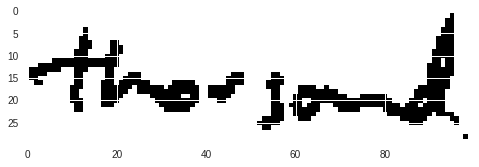

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


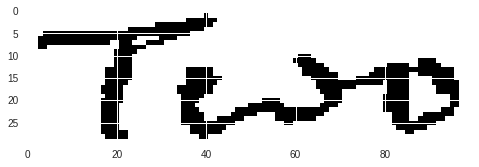

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


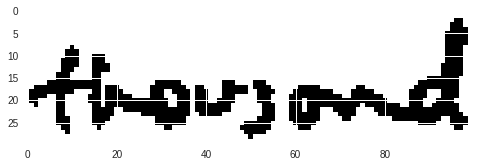

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


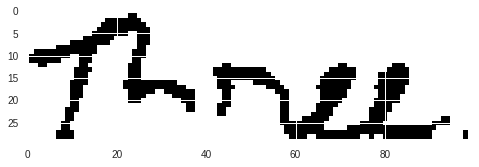

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


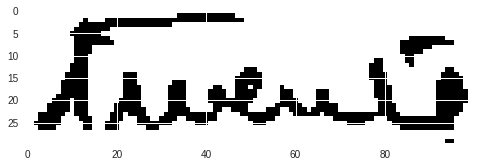

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


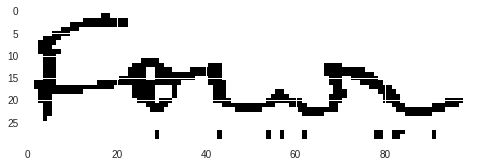

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


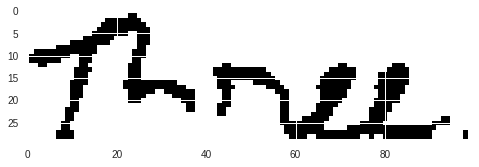

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


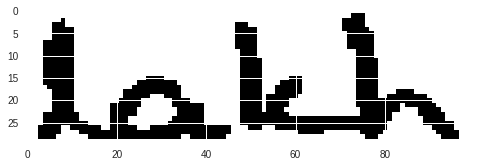

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


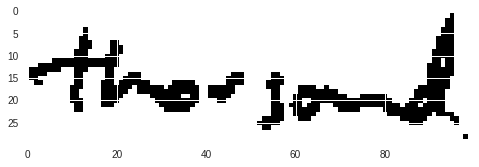

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


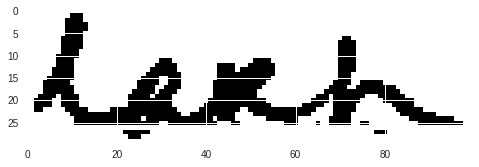

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


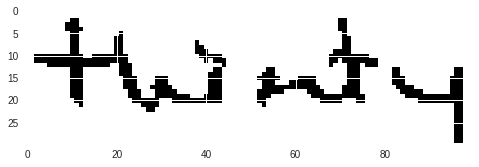

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


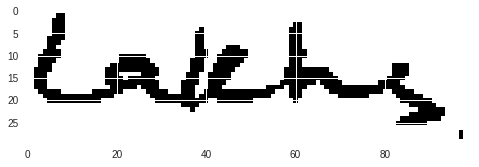

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[15]
['Fifty']


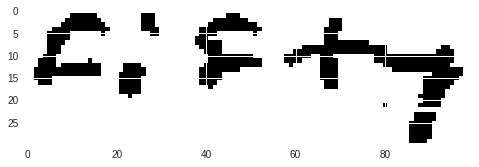

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


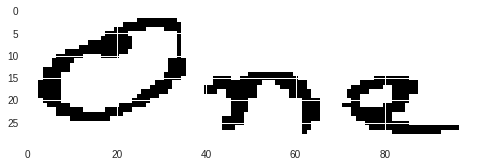

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


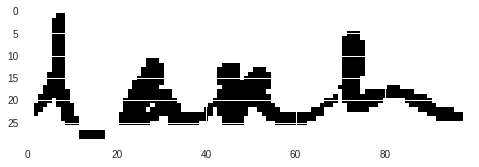

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


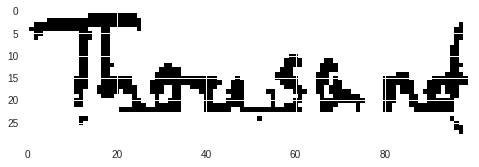

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


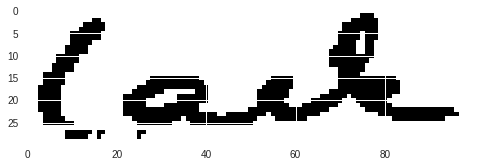

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


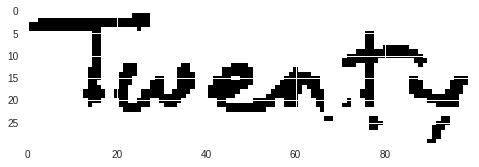

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


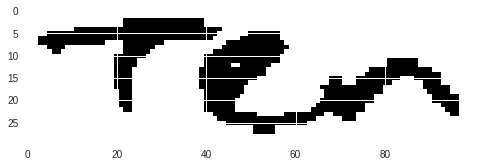

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[23]
['Hundred']


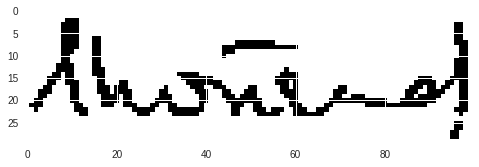

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


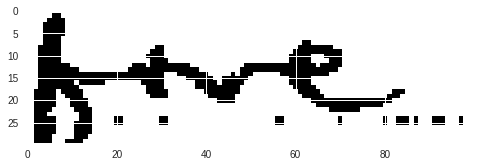

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[15]
['Fifty']


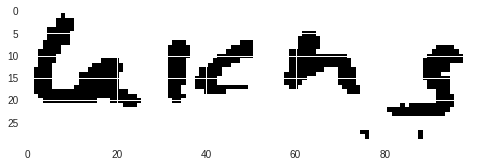

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


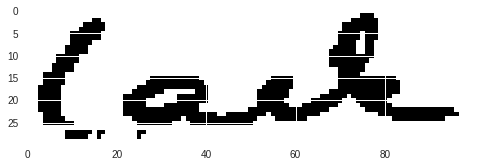

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


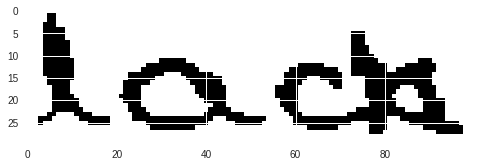

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


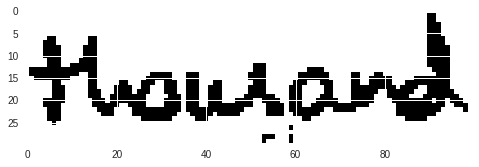

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


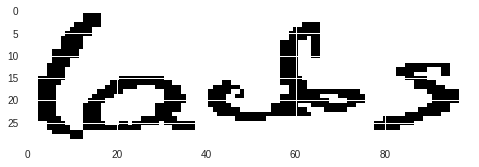

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[30]
['Seven']


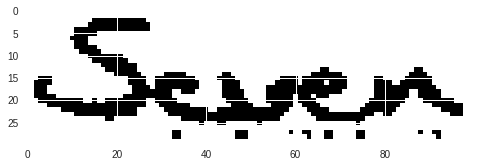

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


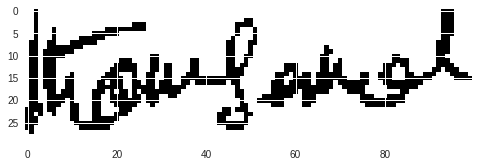

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


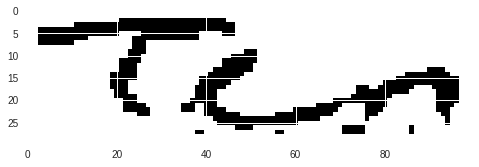

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


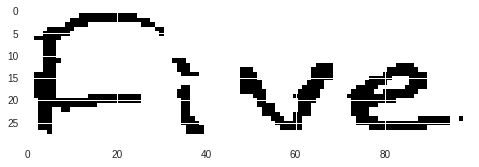

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


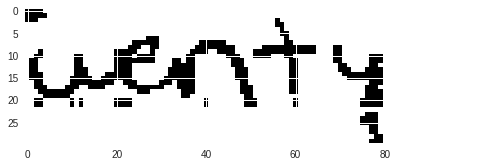

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[2]
['Eleven']


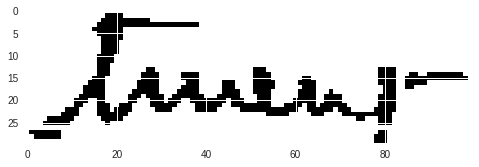

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


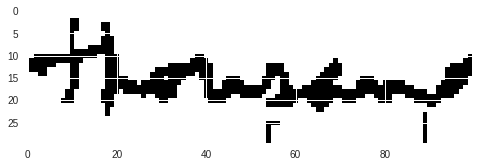

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


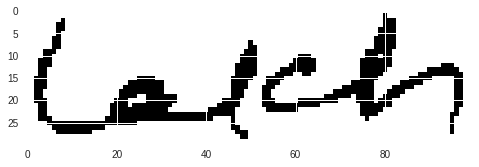

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[17]
['Seventy']


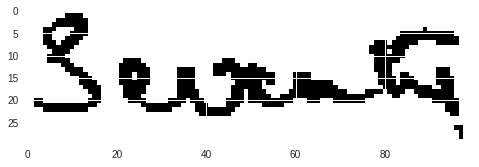

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[23]
['Hundred']


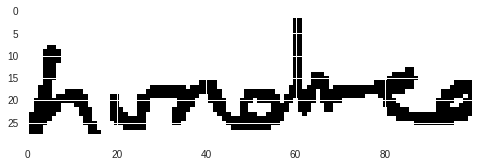

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


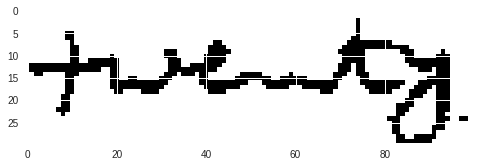

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[4]
['Thirteen']


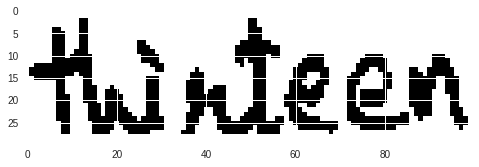

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[17]
['Seventy']


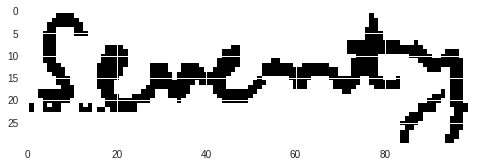

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


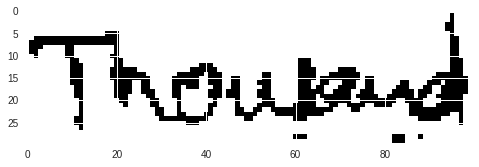

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


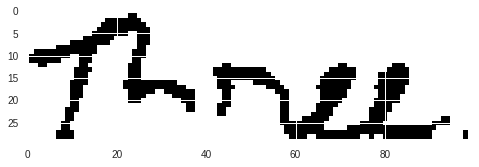

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


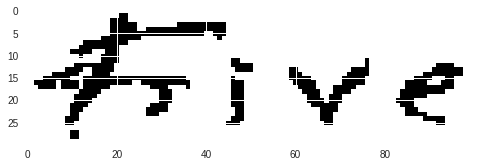

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


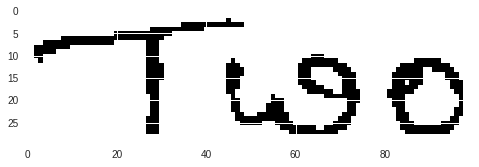

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


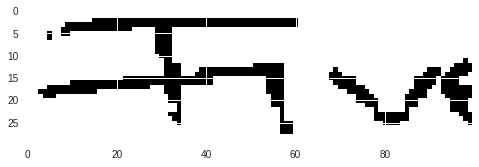

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


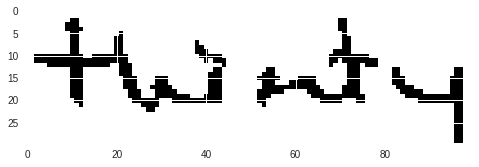

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[7]
['Sixteen']


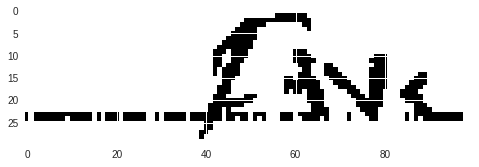

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


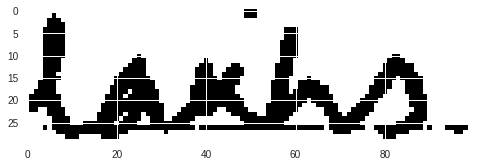

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[23]
['Hundred']


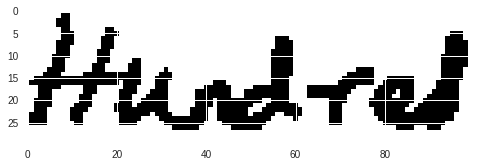

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


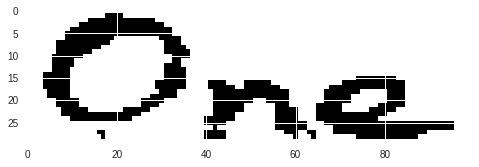

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


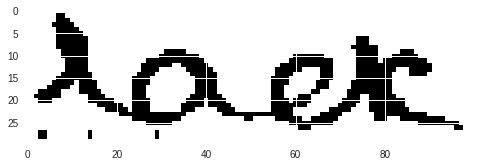

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


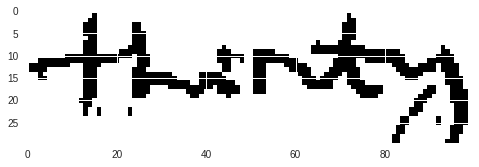

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


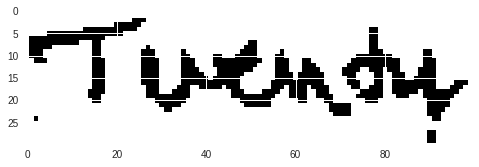

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[23]
['Hundred']


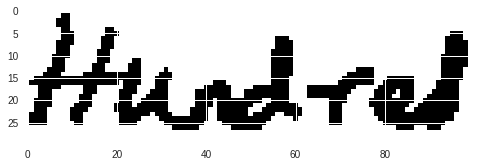

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


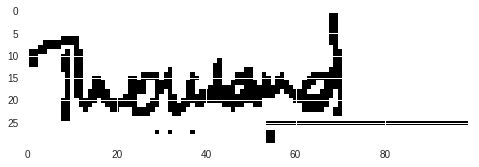

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


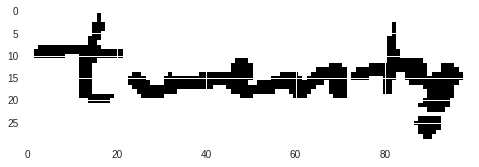

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[30]
['Seven']


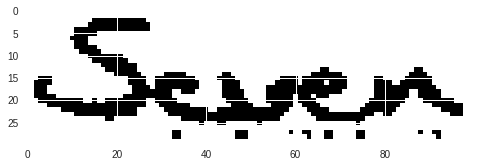

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


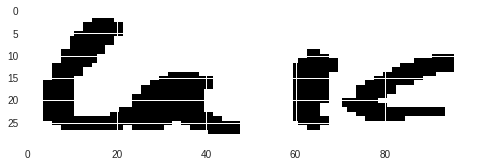

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


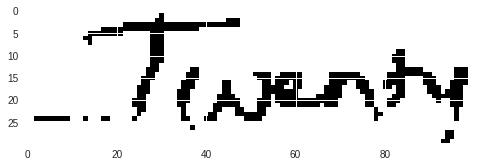

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


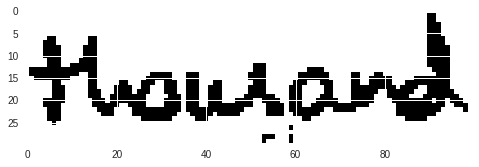

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


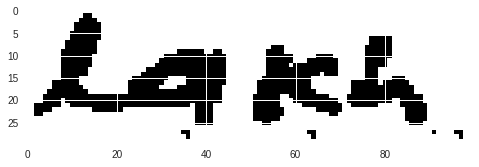

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[3]
['Twelve']


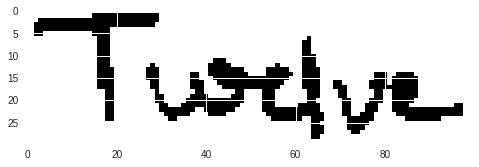

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


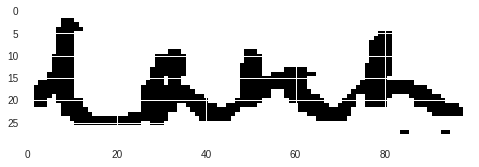

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


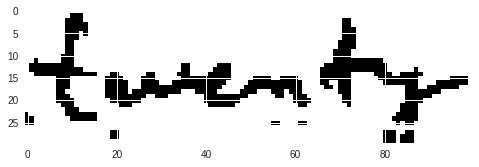

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


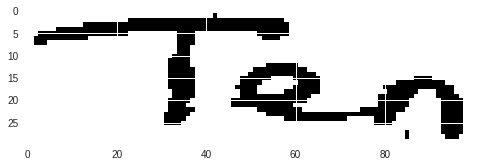

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


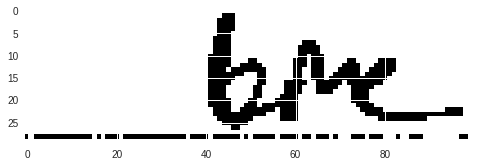

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


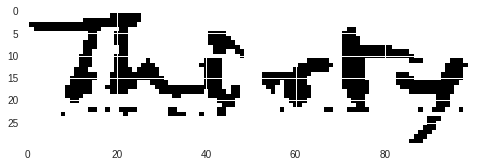

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


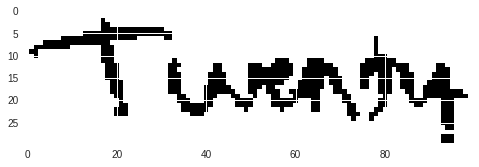

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


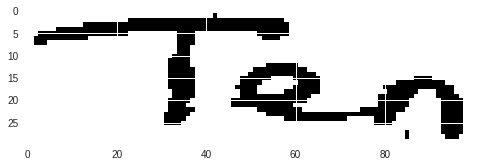

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[18]
['Eighty']


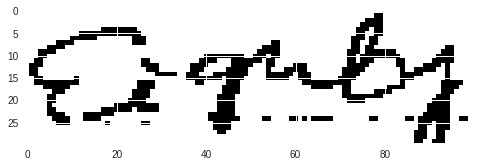

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[30]
['Seven']


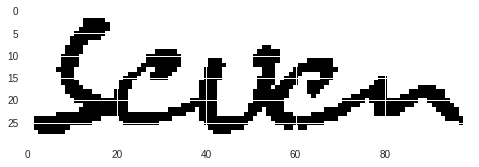

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


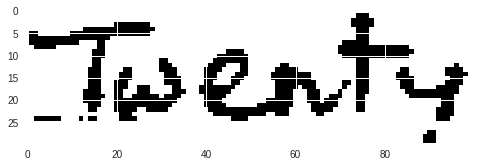

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


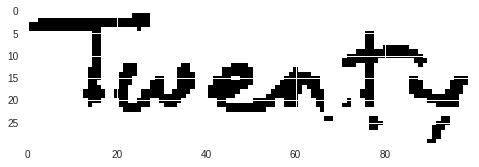

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


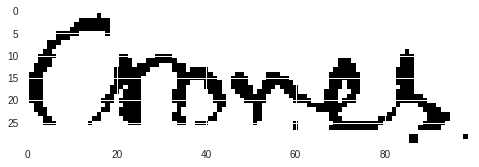

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


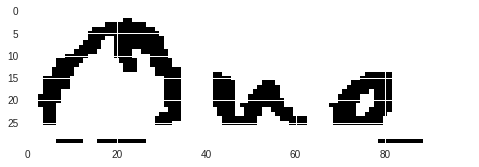

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[2]
['Eleven']


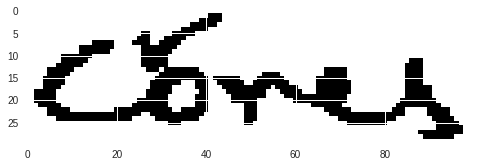

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


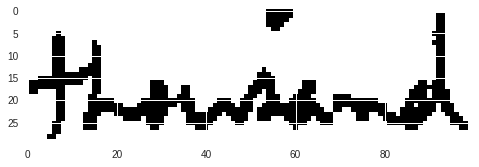

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


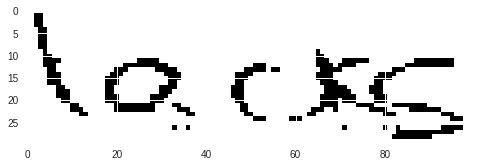

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[23]
['Hundred']


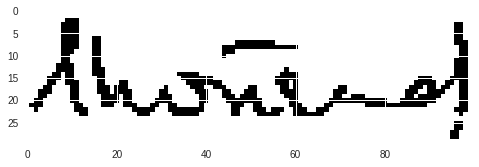

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[6]
['Fifteen']


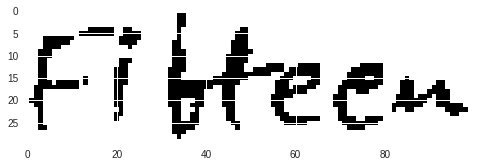

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


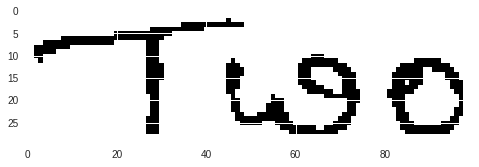

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[17]
['Seventy']


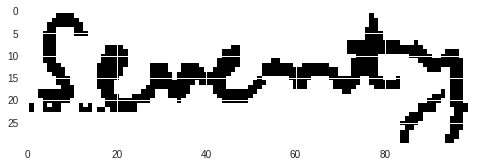

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


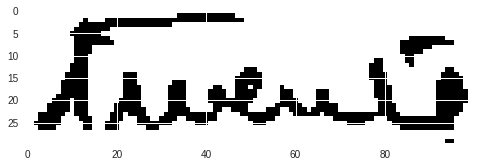

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[3]
['Twelve']


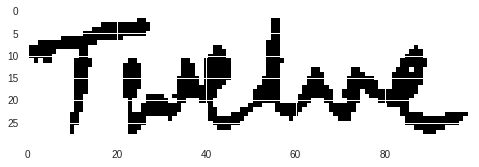

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


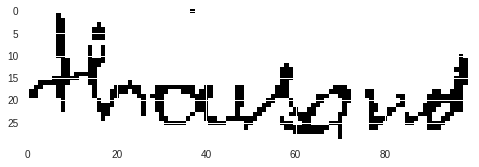

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[15]
['Fifty']


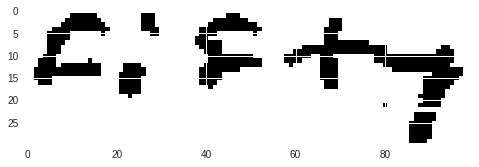

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


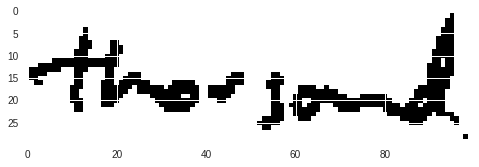

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


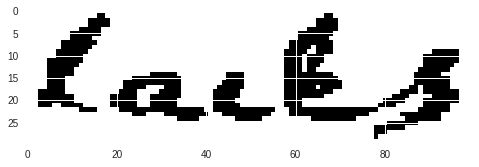

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


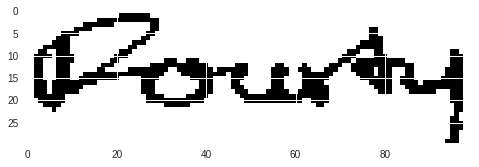

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


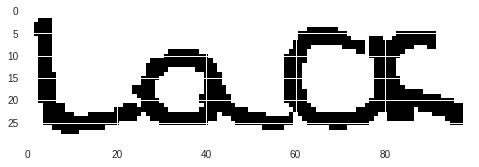

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


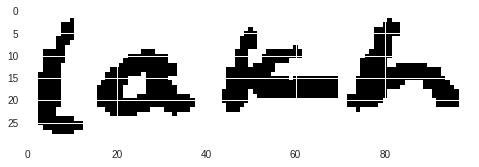

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


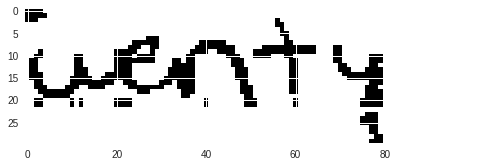

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[21]
['Only']


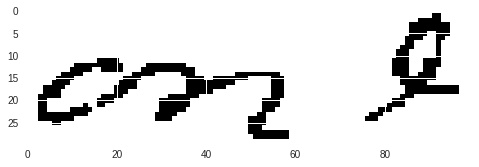

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[17]
['Seventy']


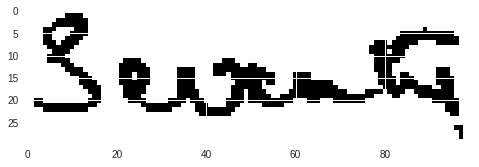

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


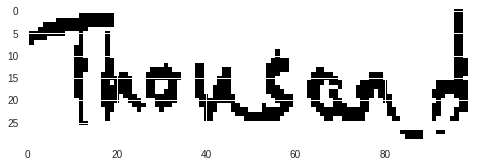

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


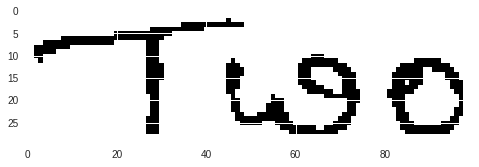

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


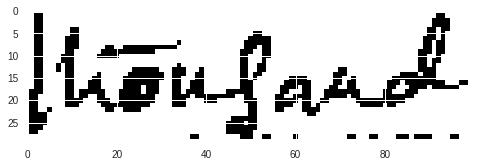

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


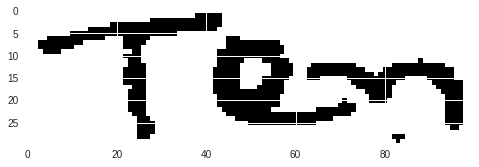

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


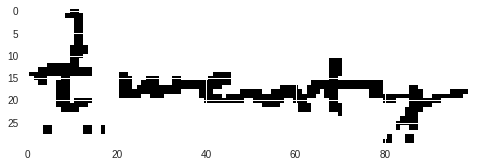

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[23]
['Hundred']


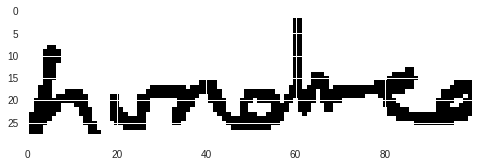

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[32]
['Nine']


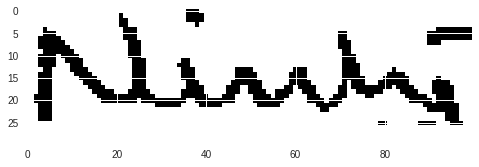

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


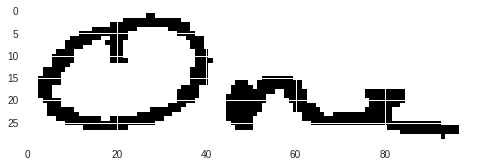

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


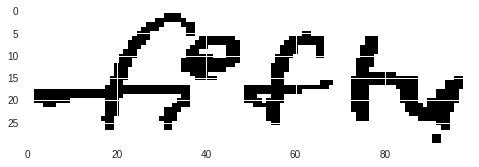

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


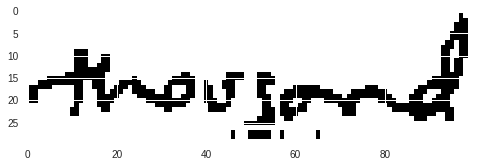

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


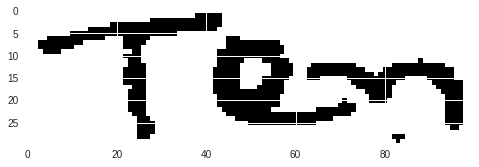

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


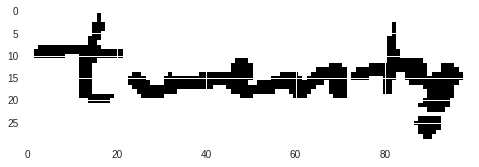

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


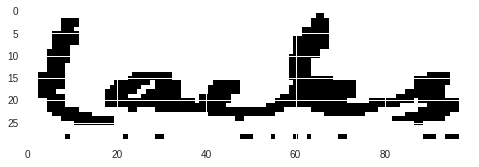

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


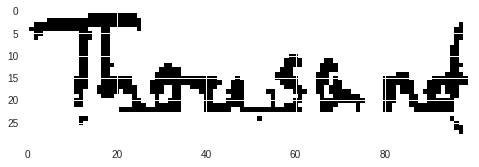

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


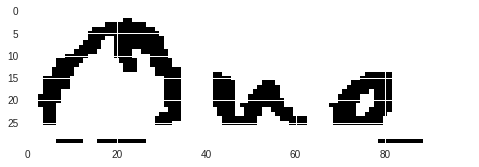

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


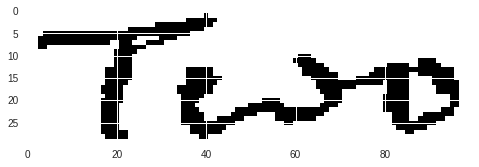

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


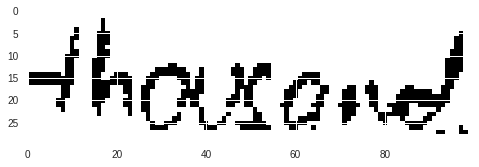

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


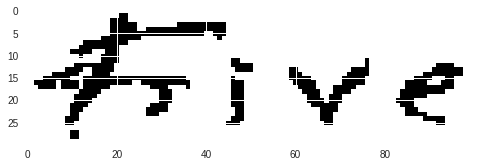

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[21]
['Only']


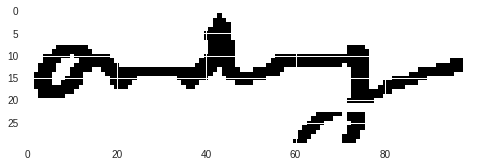

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[23]
['Hundred']


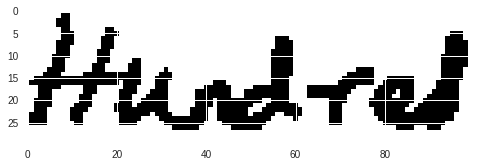

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[3]
['Twelve']


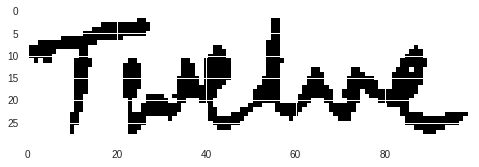

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


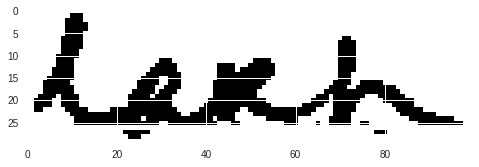

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


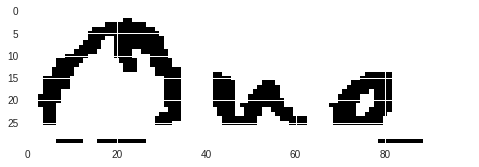

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


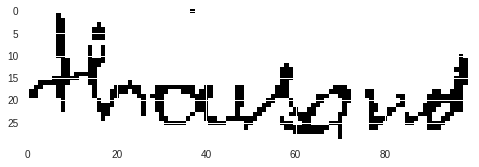

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


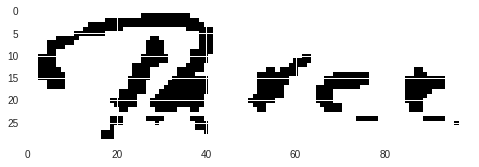

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[18]
['Eighty']


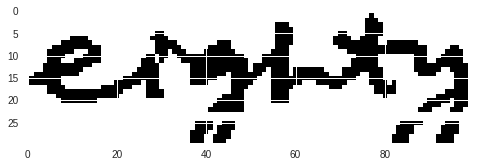

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


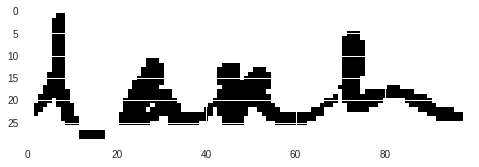

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


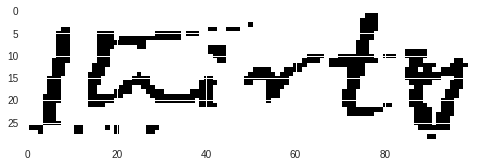

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


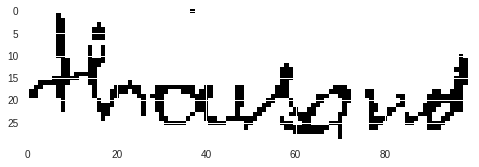

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


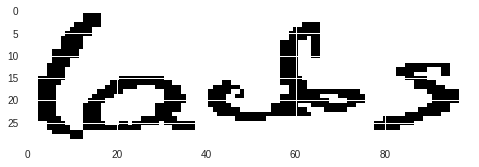

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


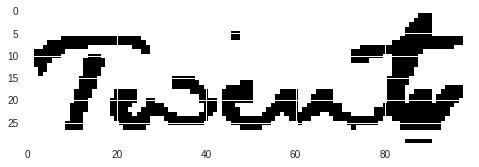

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


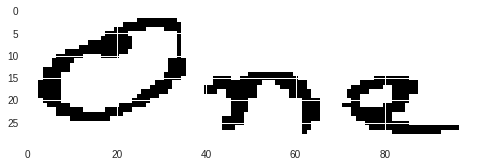

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


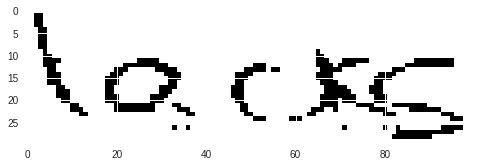

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


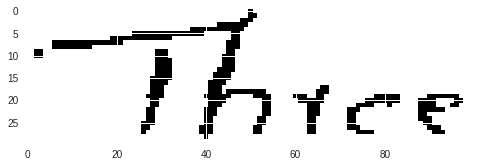

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[16]
['Sixty']


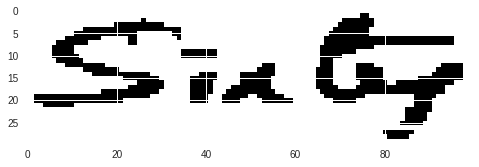

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


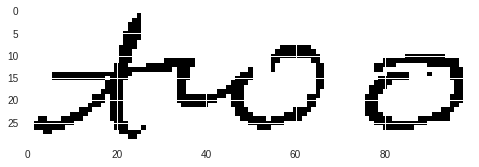

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


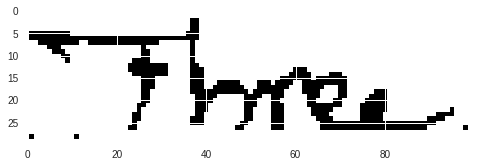

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


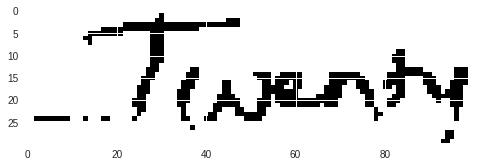

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


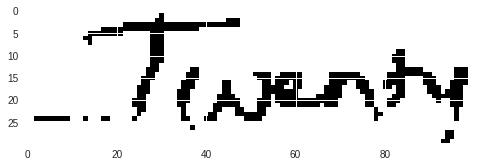

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


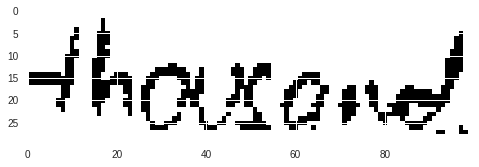

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


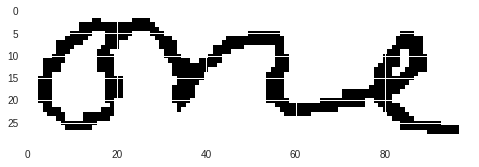

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


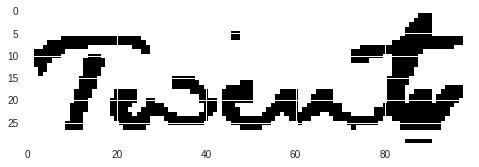

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


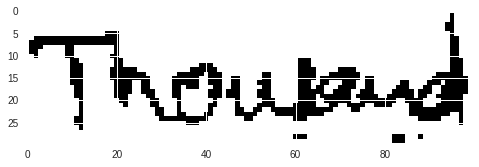

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


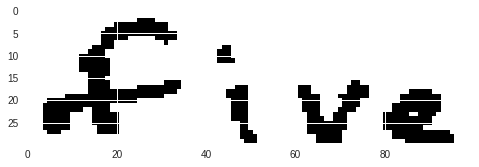

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


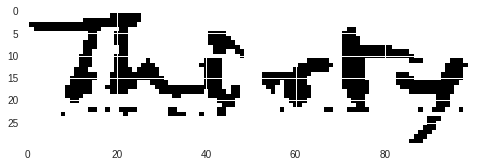

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[32]
['Nine']


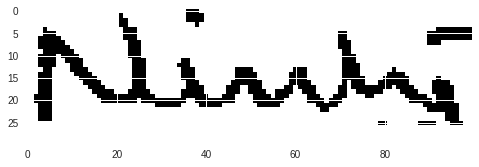

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[17]
['Seventy']


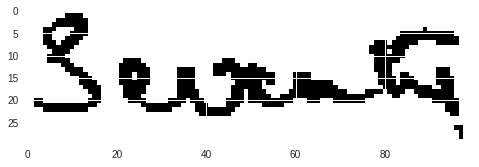

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


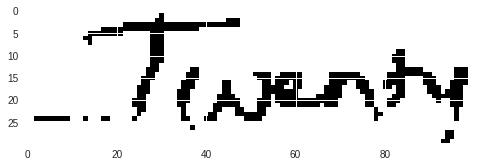

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


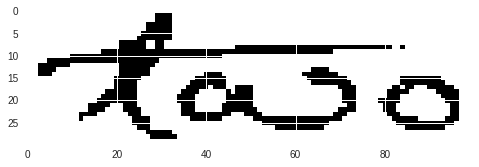

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


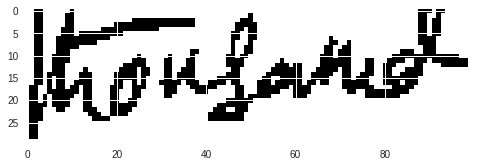

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


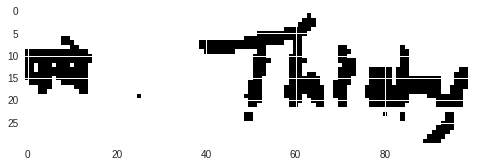

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


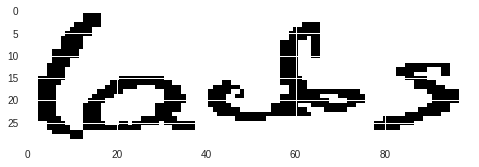

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


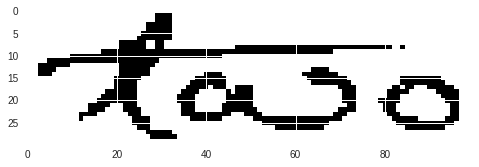

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


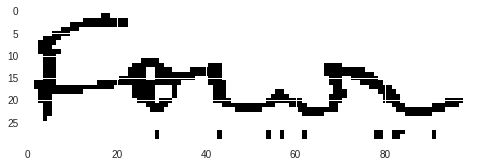

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


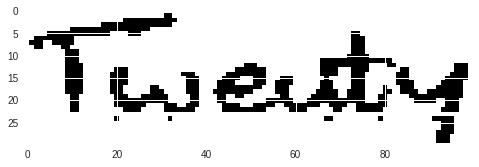

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


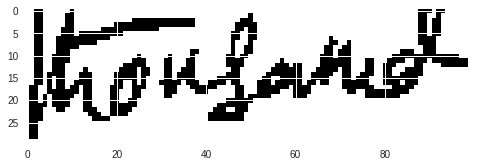

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


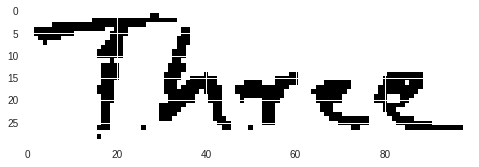

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


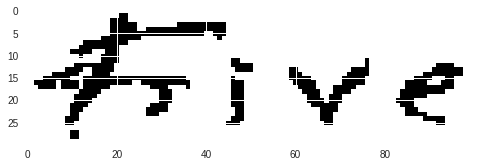

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


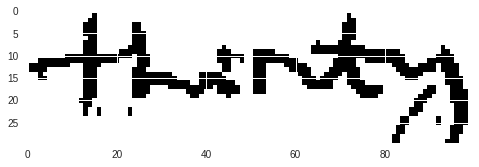

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


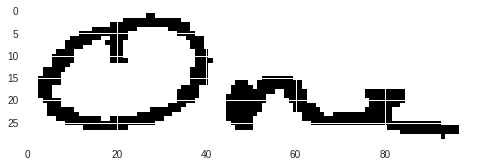

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


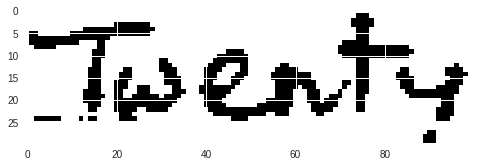

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


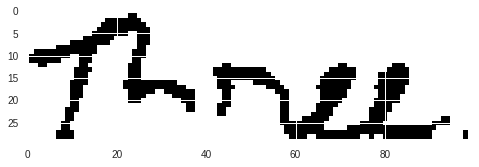

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[29]
['Six']


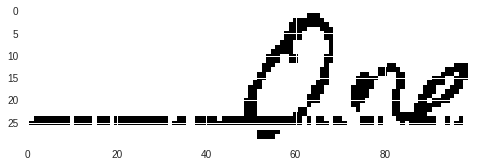

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[4]
['Thirteen']


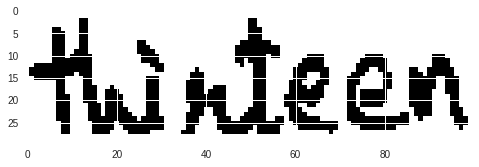

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


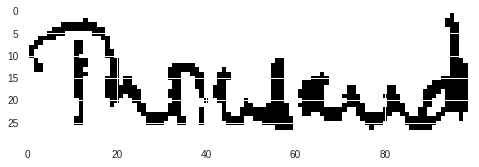

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[17]
['Seventy']


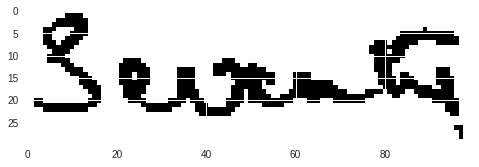

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


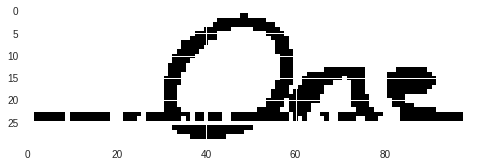

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


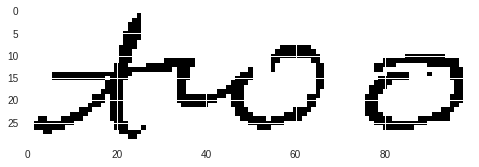

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[30]
['Seven']


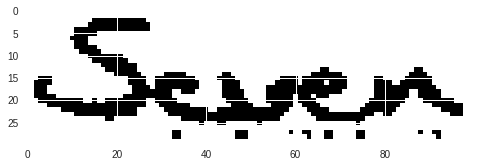

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


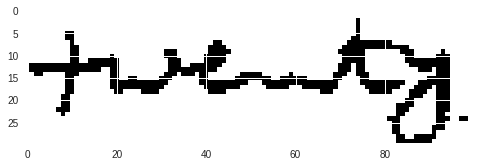

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[3]
['Twelve']


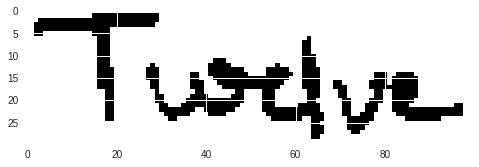

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


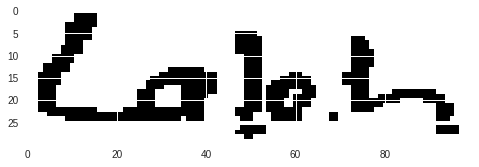

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


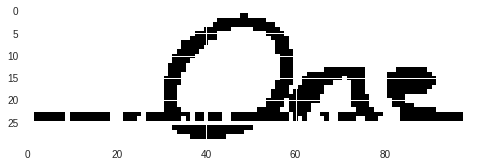

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


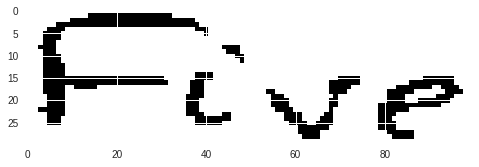

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


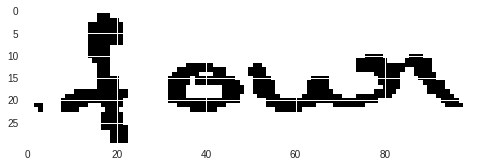

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[29]
['Six']


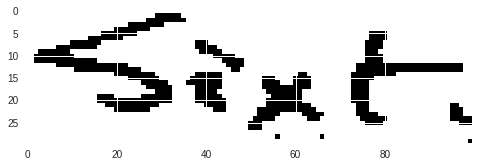

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


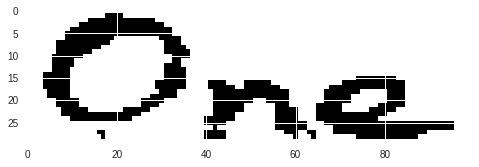

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


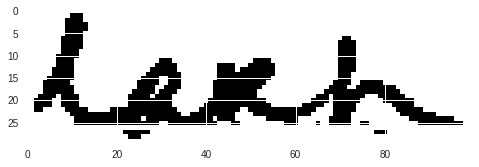

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


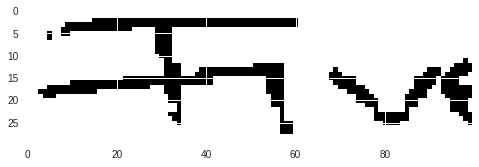

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


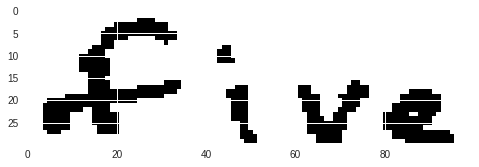

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


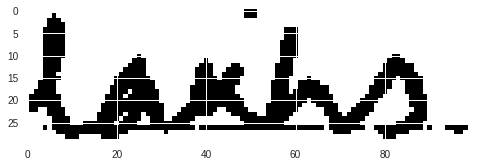

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


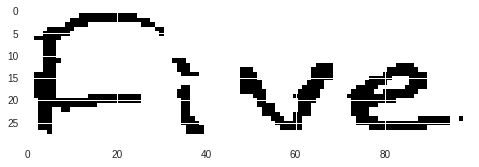

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


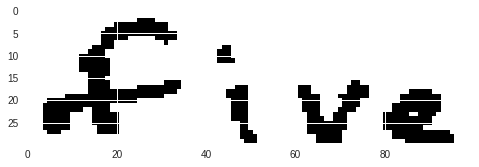

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[17]
['Seventy']


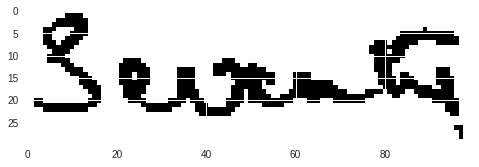

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


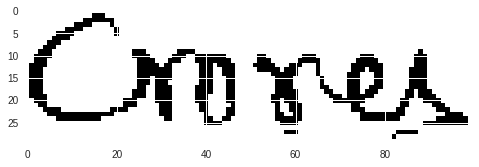

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


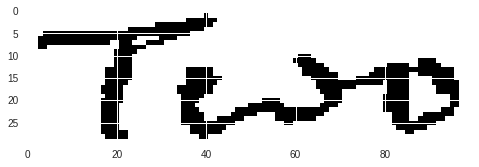

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[18]
['Eighty']


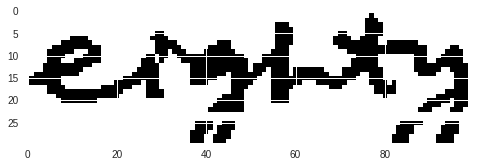

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[31]
['Eight']


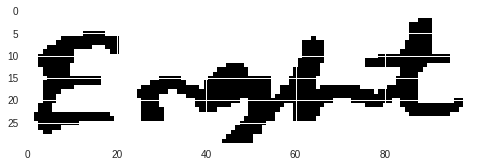

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


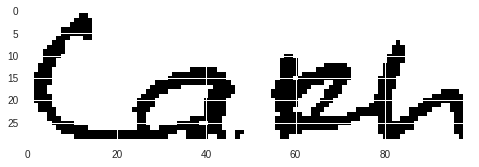

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


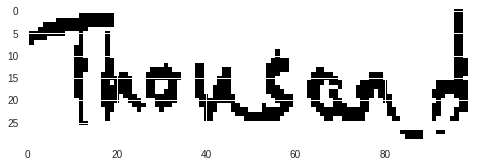

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


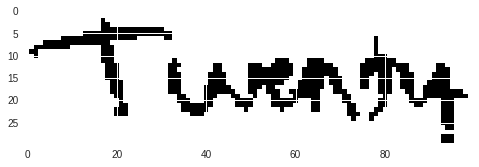

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[7]
['Sixteen']


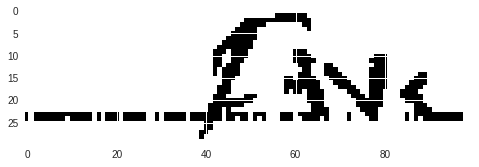

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


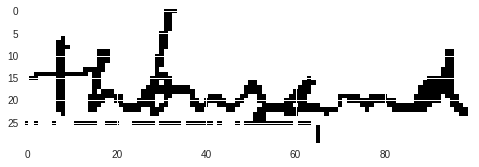

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


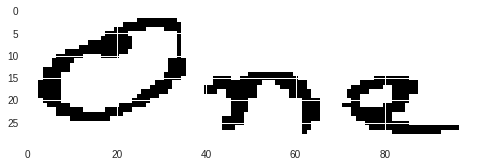

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


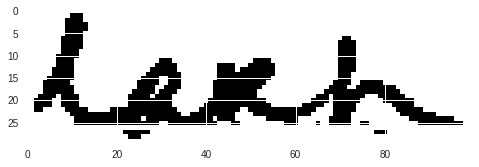

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


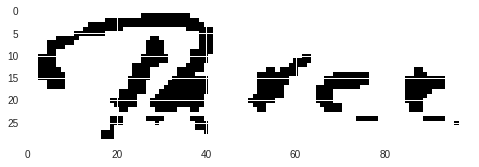

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


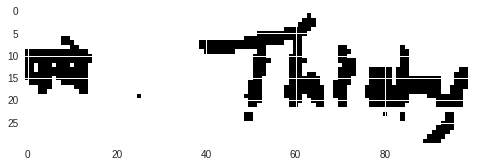

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


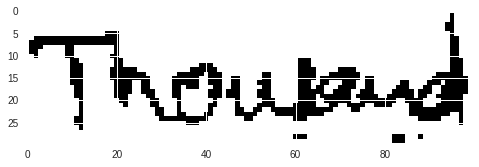

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


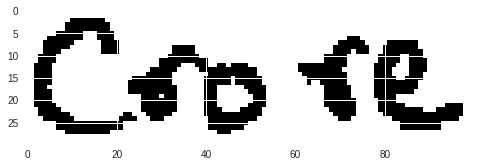

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


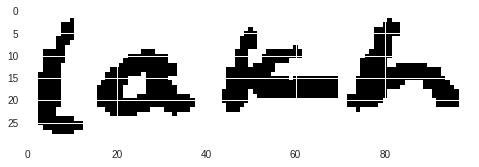

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


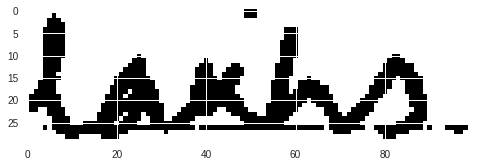

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[16]
['Sixty']


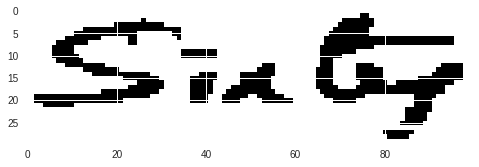

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


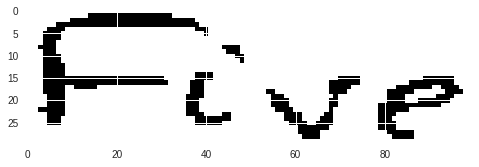

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


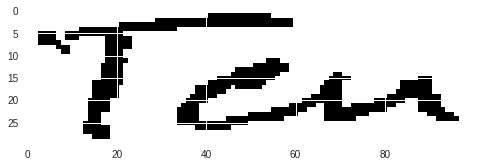

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


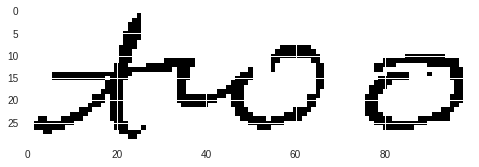

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[16]
['Sixty']


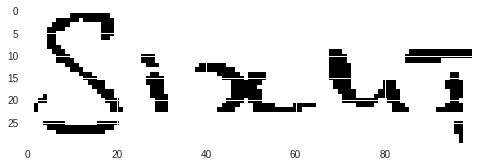

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


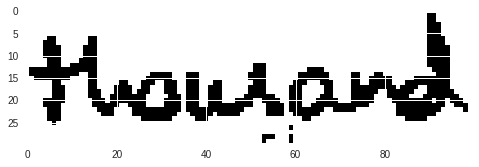

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


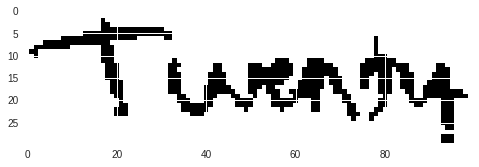

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[32]
['Nine']


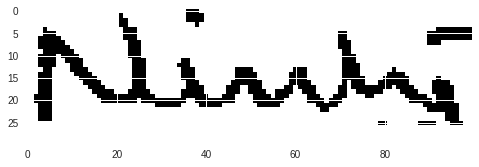

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


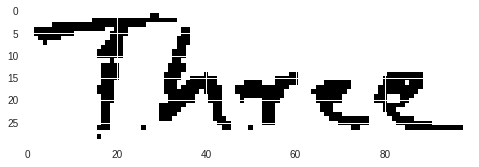

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


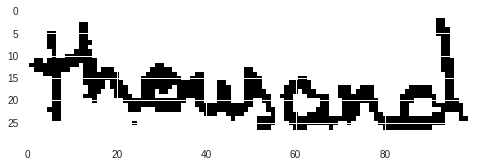

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


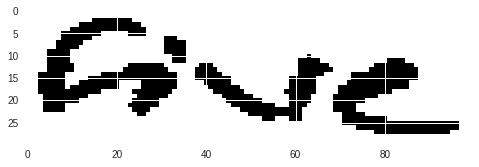

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


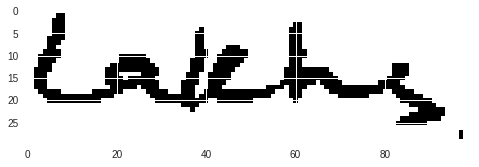

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


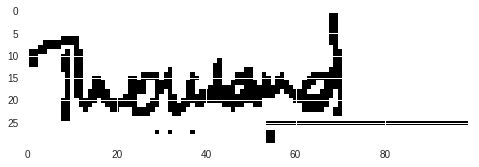

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


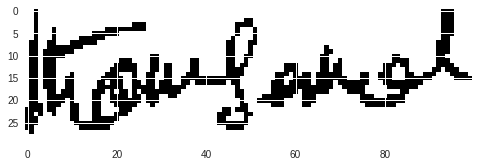

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[23]
['Hundred']


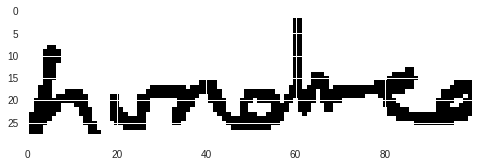

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


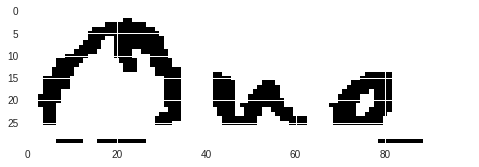

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


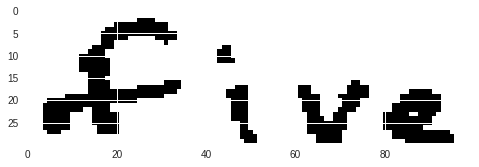

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


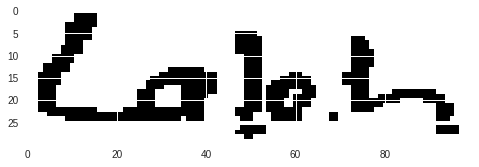

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


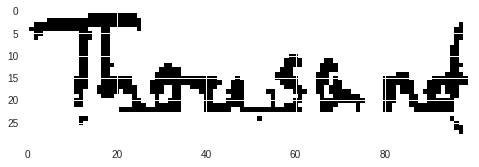

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


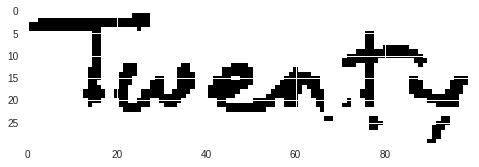

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


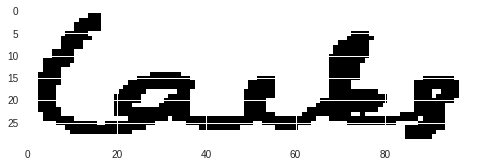

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


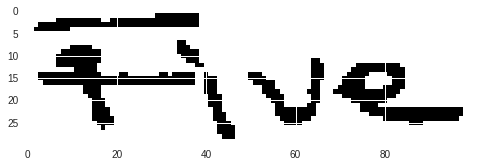

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


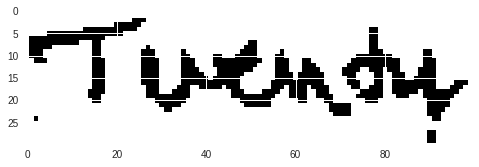

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


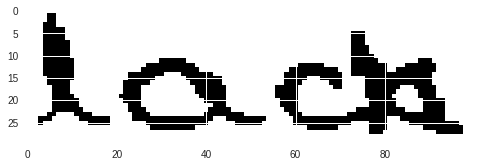

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


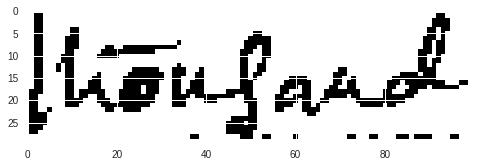

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


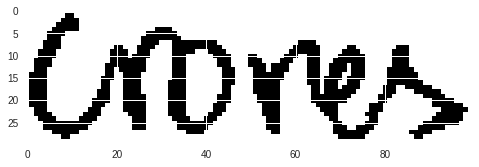

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


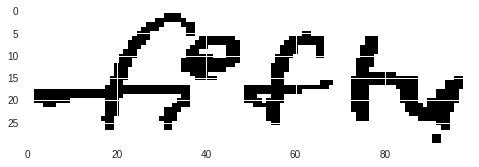

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


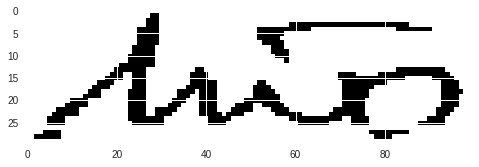

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[19]
['Ninety']


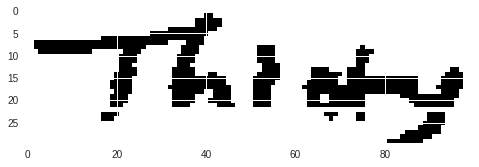

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[31]
['Eight']


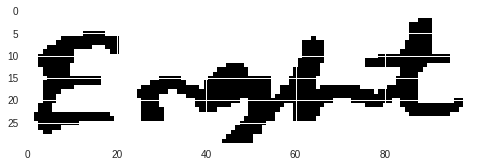

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


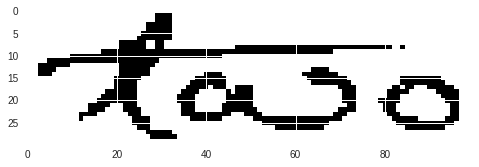

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


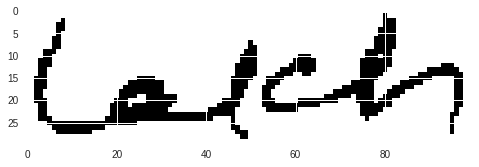

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


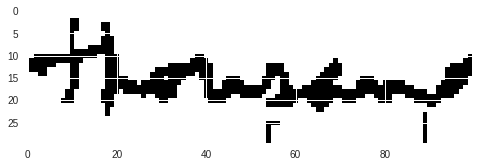

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[31]
['Eight']


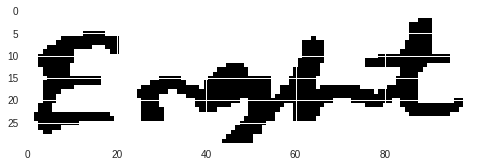

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[3]
['Twelve']


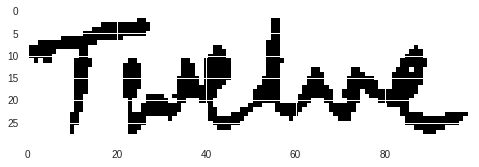

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


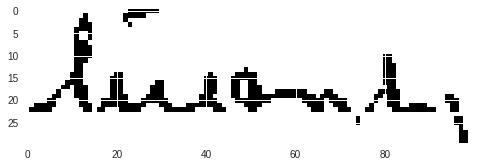

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


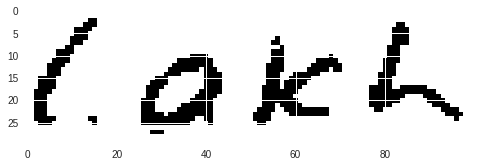

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


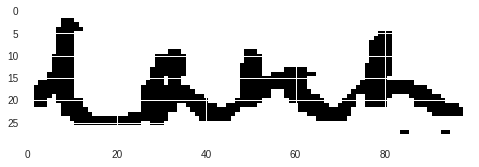

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


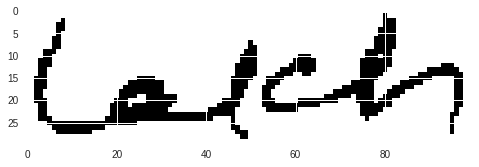

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


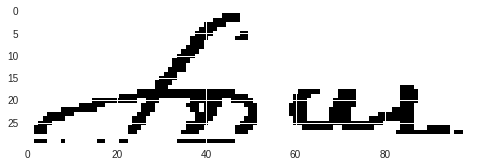

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


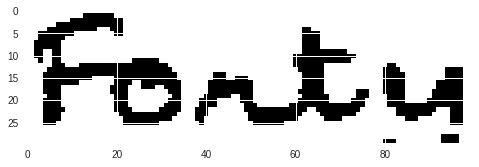

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


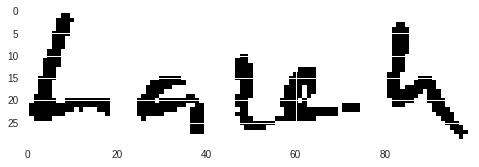

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


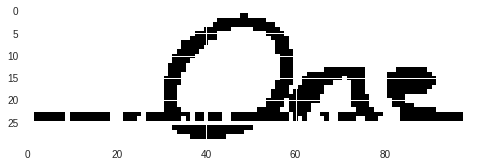

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[30]
['Seven']


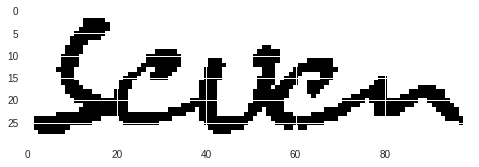

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


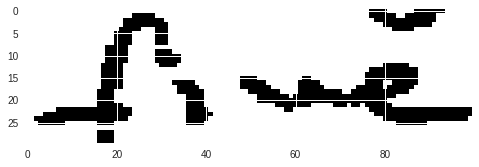

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


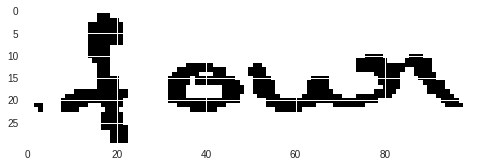

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


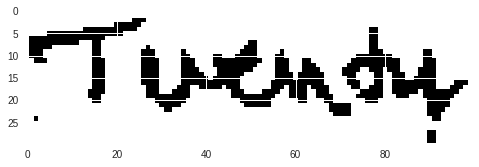

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


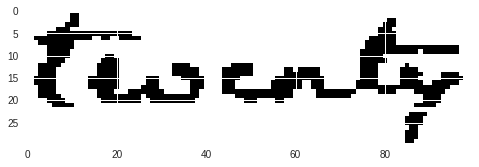

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


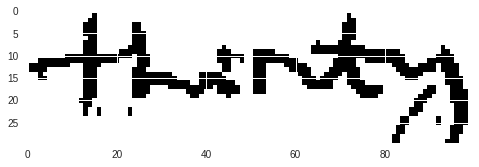

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


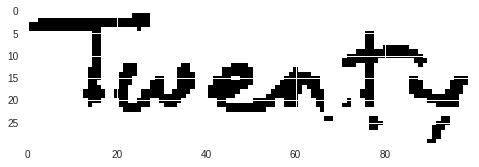

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


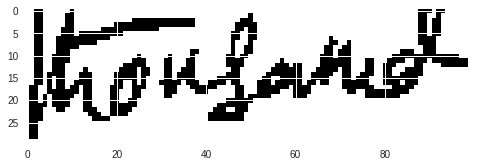

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


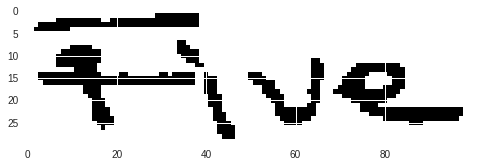

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


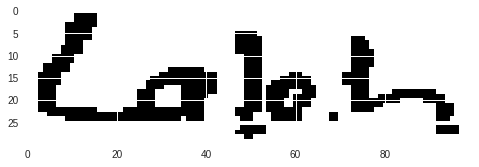

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


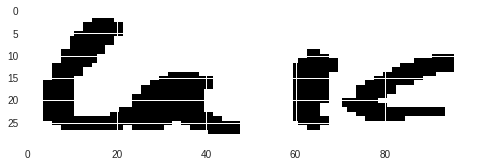

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


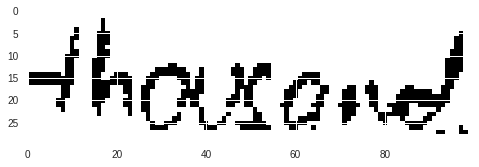

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


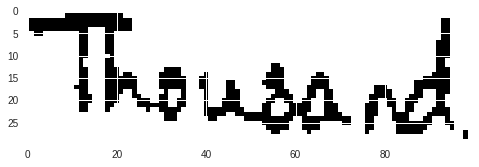

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


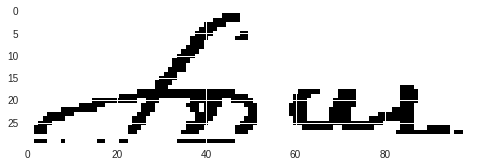

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


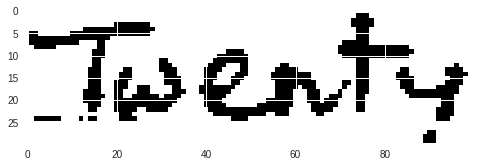

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


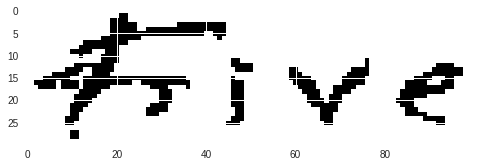

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


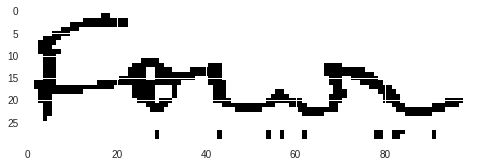

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


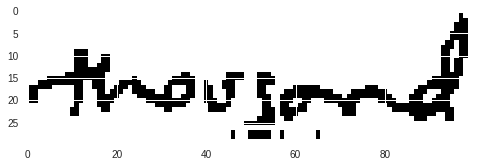

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


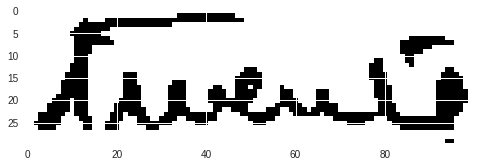

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


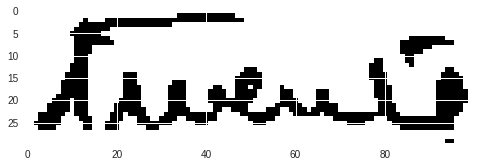

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


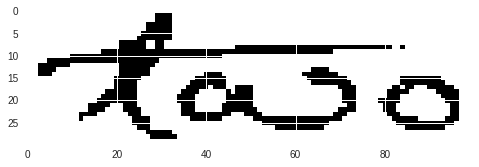

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


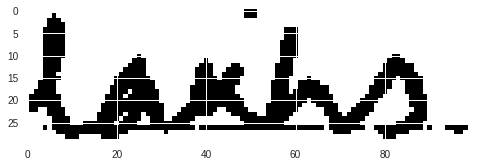

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


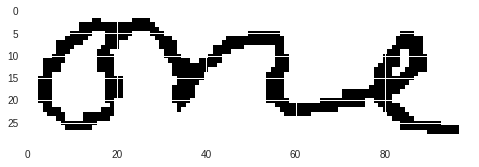

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


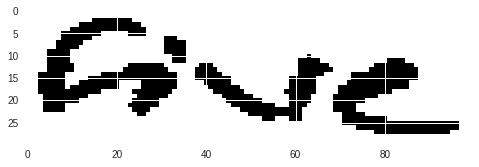

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


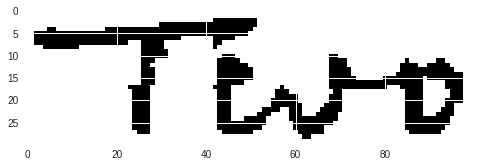

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[23]
['Hundred']


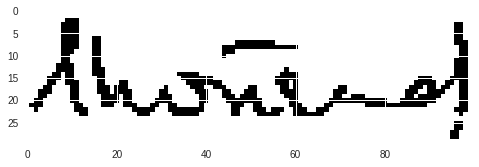

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


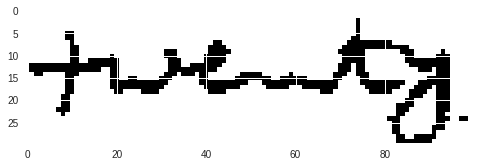

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[23]
['Hundred']


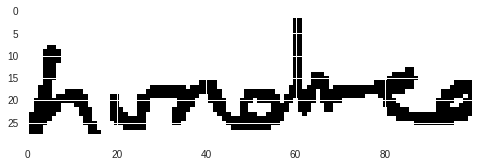

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


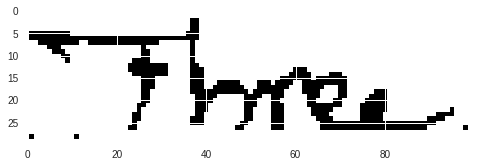

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


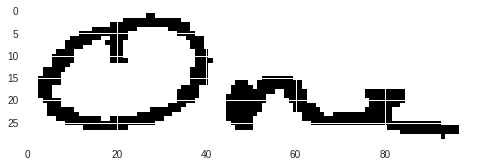

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


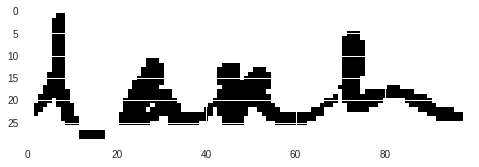

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


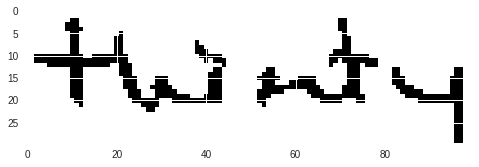

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


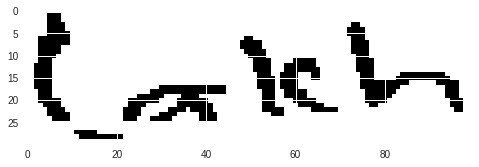

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


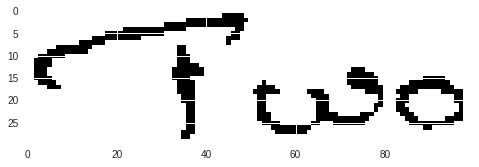

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


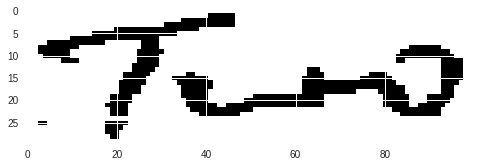

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


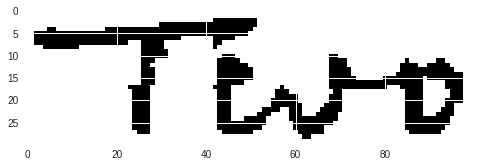

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


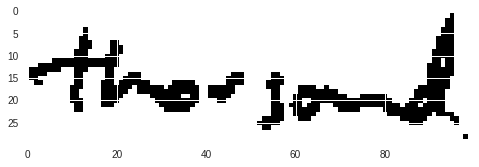

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[21]
['Only']


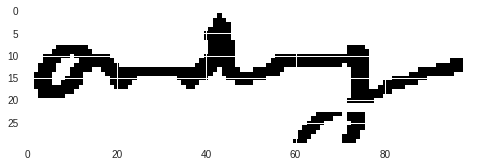

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


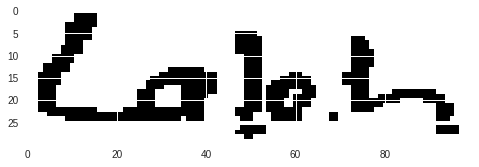

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


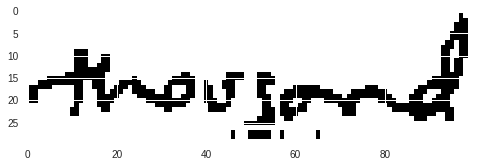

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


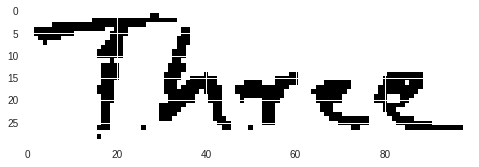

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


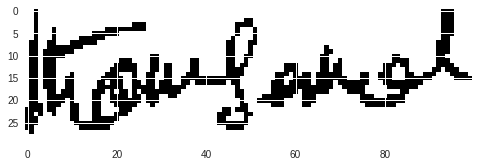

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


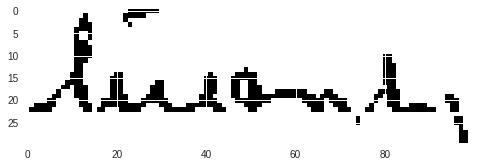

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


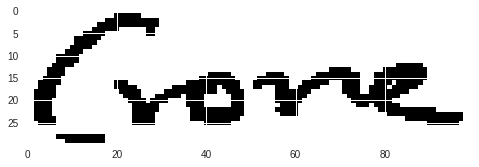

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[15]
['Fifty']


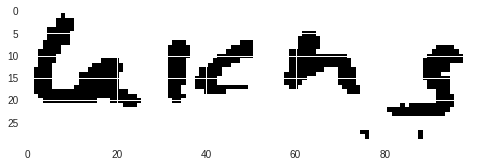

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


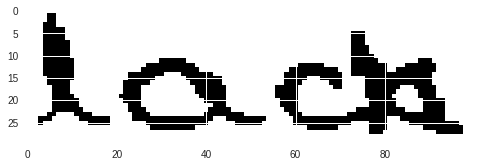

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


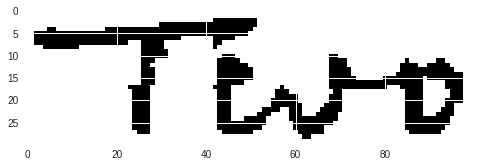

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


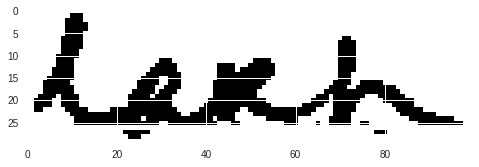

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


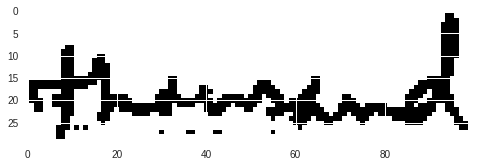

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[3]
['Twelve']


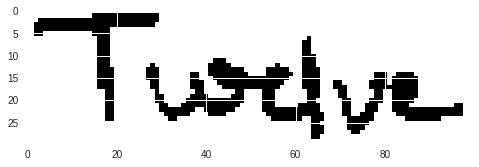

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


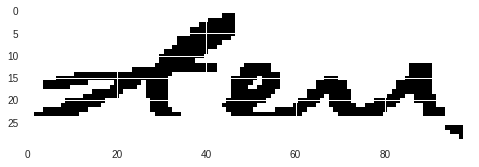

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


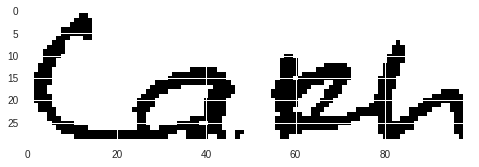

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


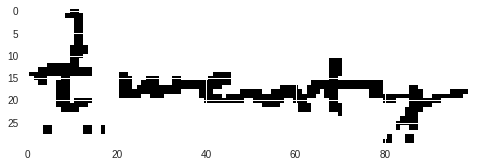

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


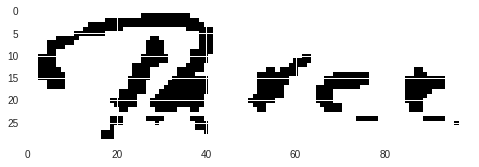

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


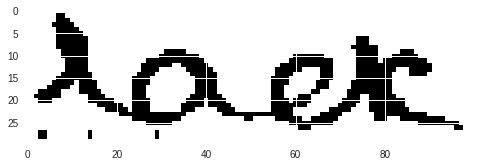

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


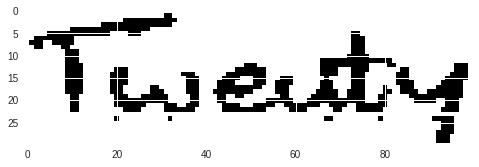

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[21]
['Only']


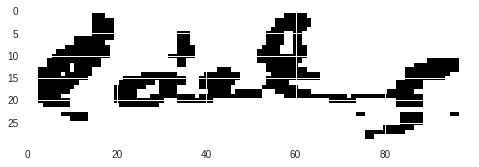

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


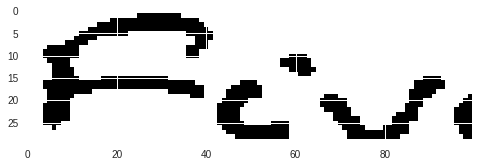

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


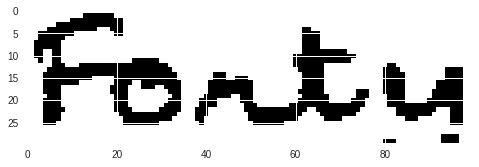

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


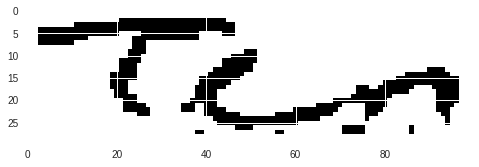

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


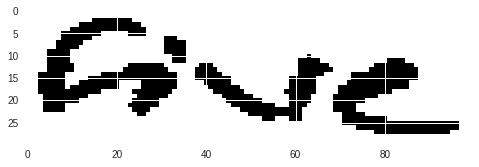

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


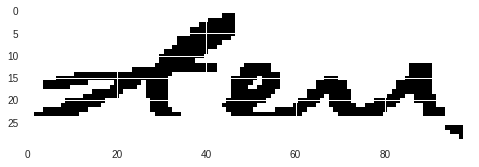

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


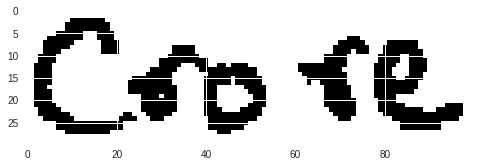

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


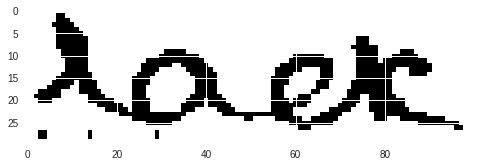

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


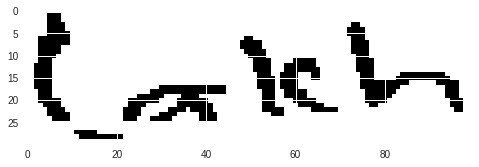

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


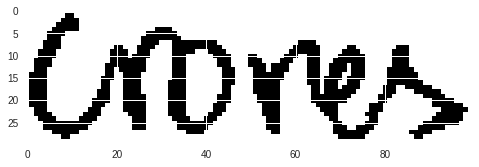

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


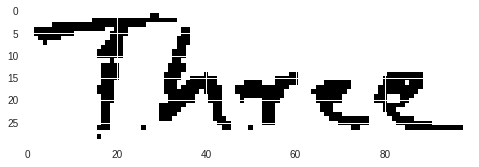

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


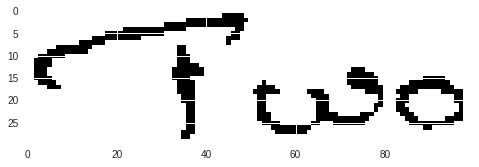

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


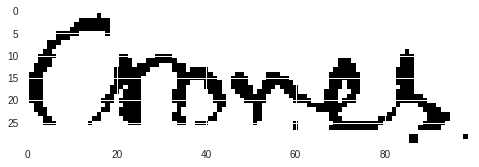

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[3]
['Twelve']


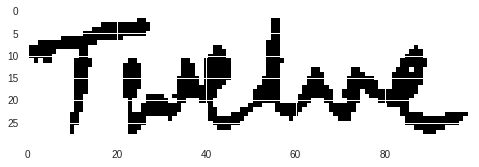

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


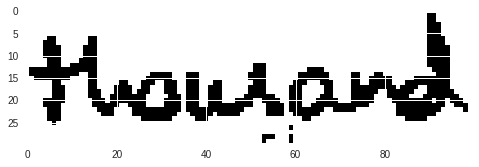

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


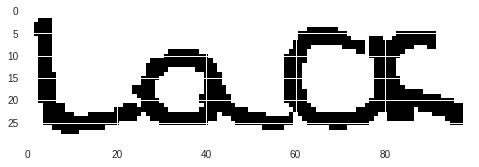

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[15]
['Fifty']


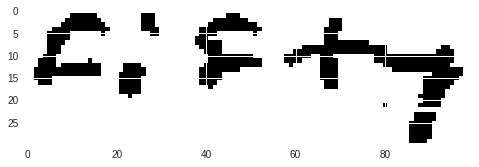

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


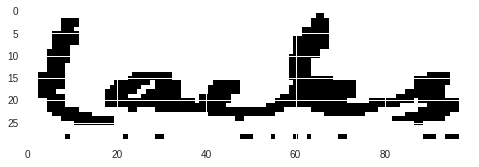

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


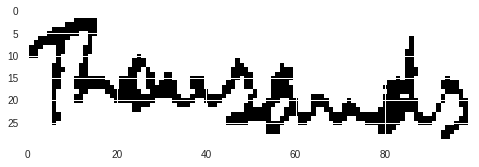

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


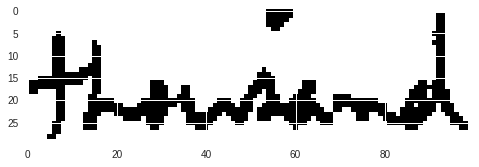

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


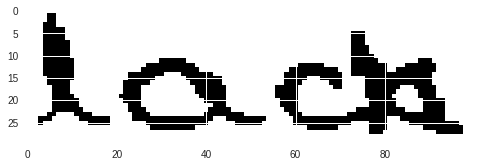

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[17]
['Seventy']


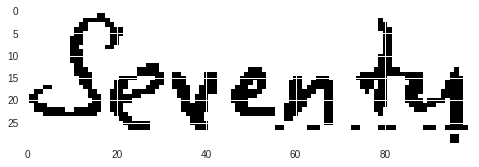

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[2]
['Eleven']


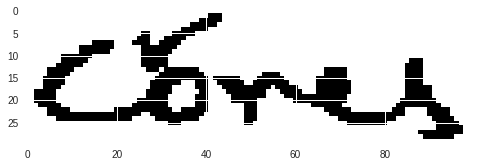

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


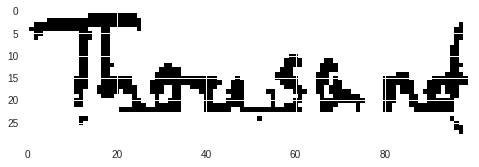

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


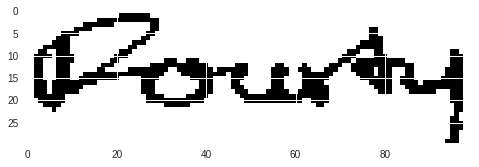

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


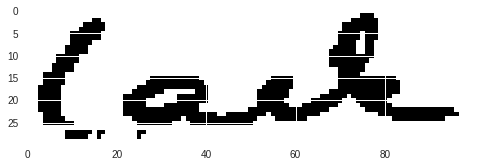

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


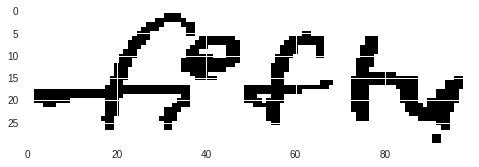

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[7]
['Sixteen']


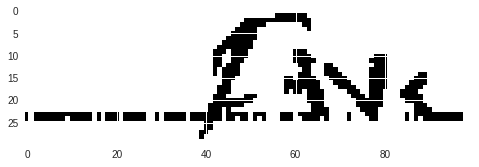

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


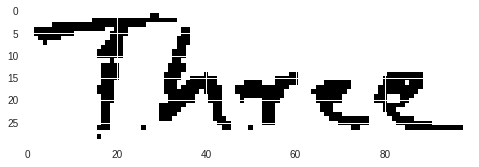

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


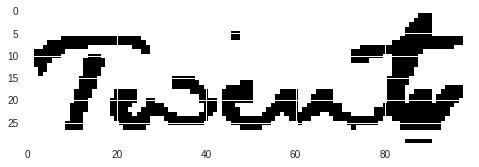

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[30]
['Seven']


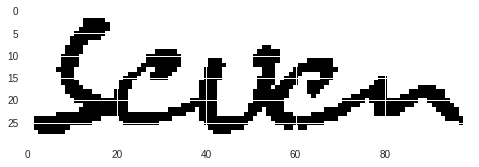

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


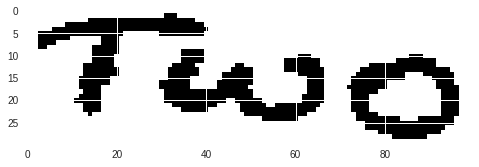

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


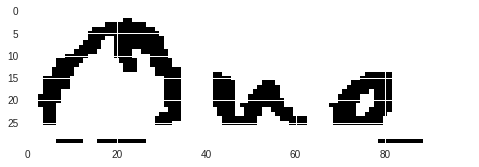

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[18]
['Eighty']


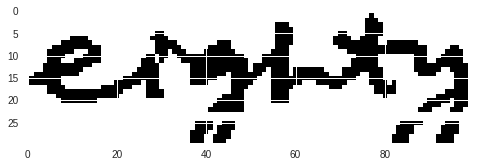

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


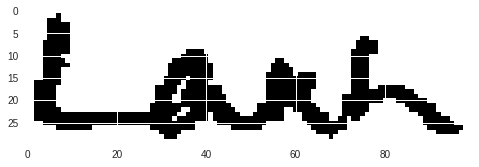

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[2]
['Eleven']


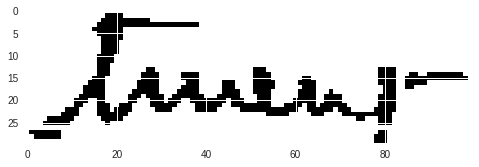

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


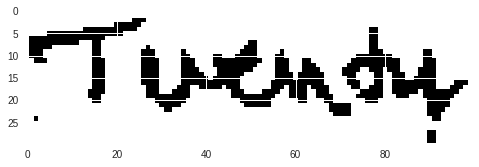

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[23]
['Hundred']


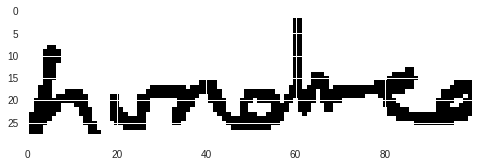

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


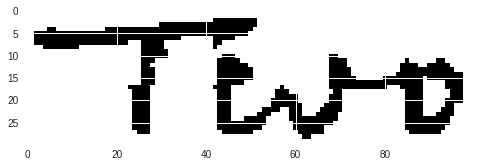

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


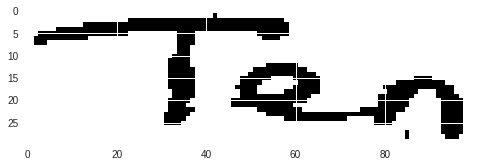

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[3]
['Twelve']


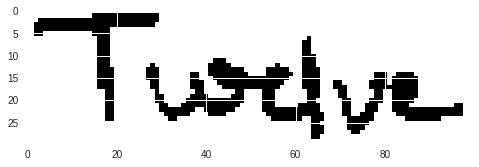

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


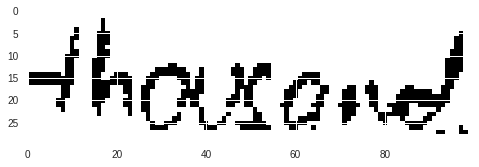

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[2]
['Eleven']


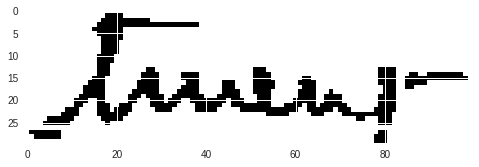

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


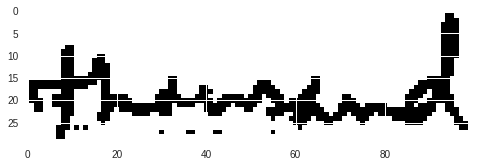

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[31]
['Eight']


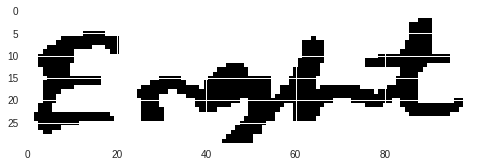

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


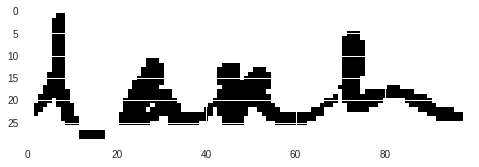

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[6]
['Fifteen']


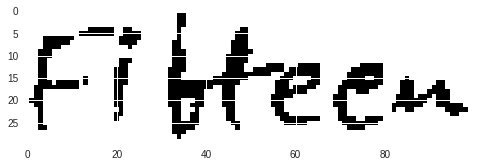

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[29]
['Six']


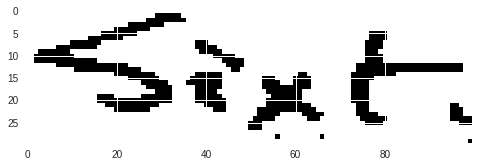

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


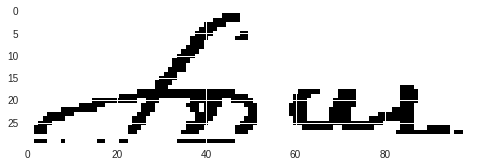

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


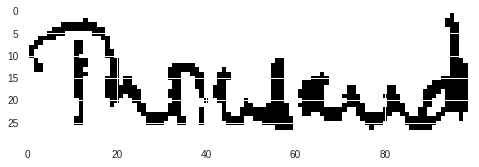

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


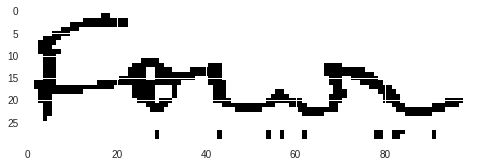

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


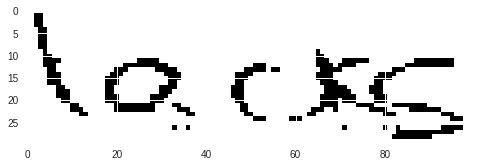

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[29]
['Six']


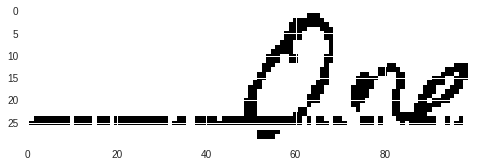

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


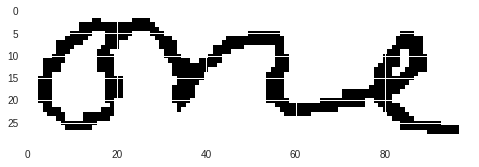

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


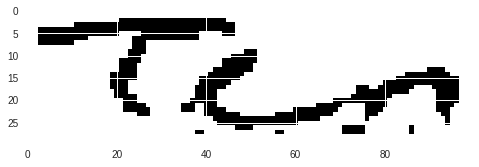

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


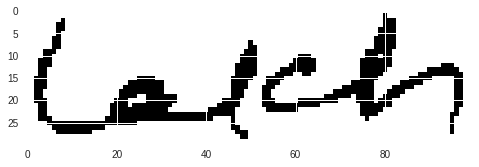

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


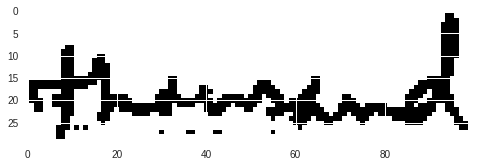

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[16]
['Sixty']


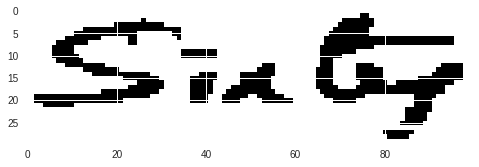

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


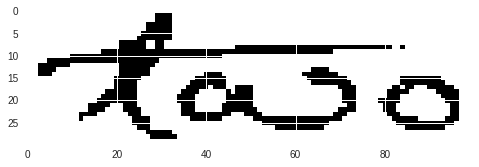

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


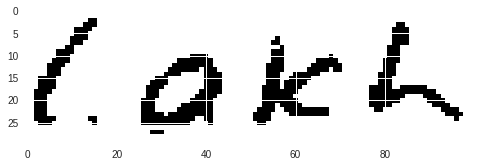

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


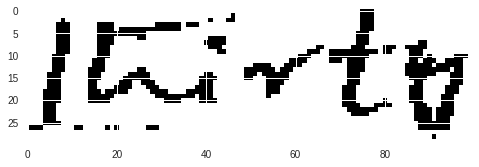

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


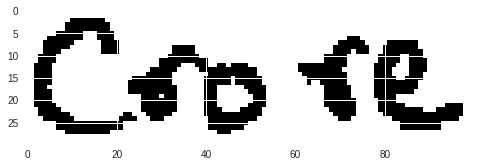

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[16]
['Sixty']


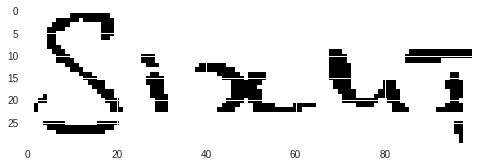

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


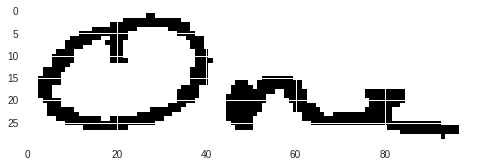

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


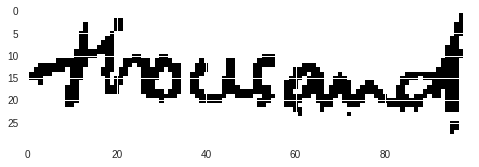

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


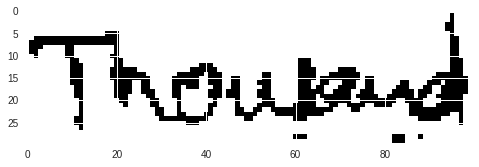

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


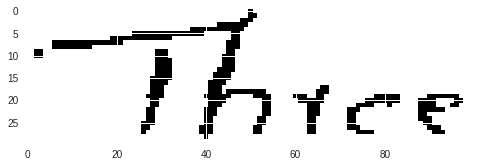

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[4]
['Thirteen']


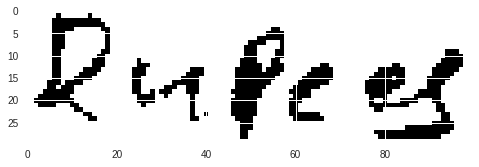

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


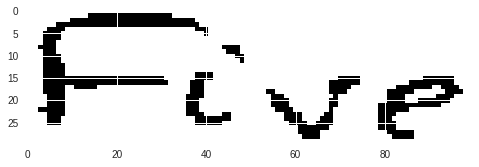

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


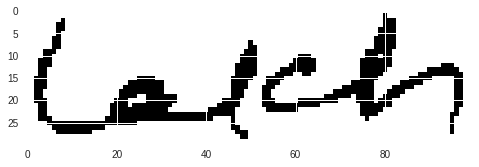

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


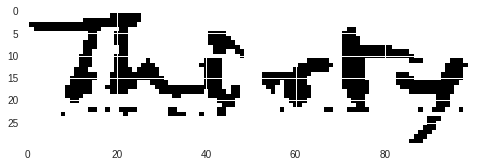

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


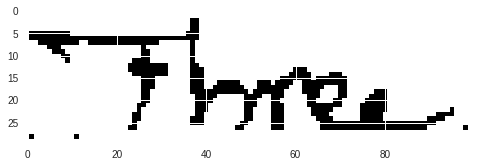

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


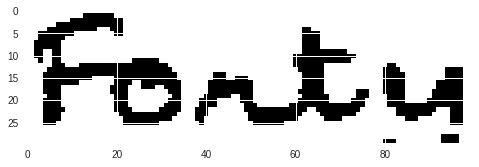

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[17]
['Seventy']


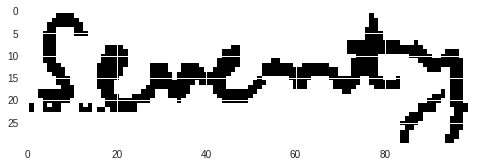

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


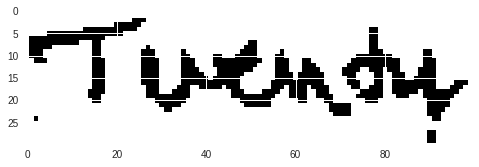

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


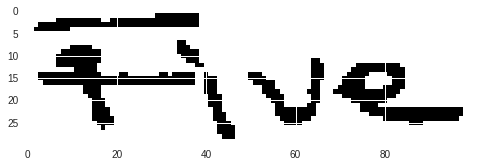

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


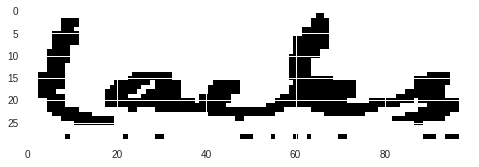

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


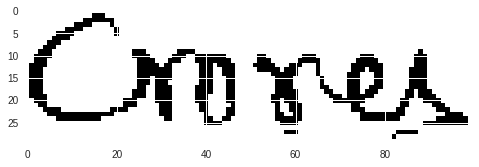

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


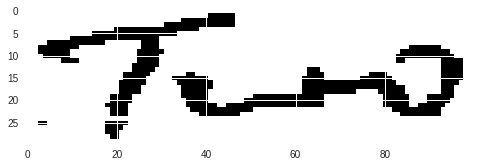

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


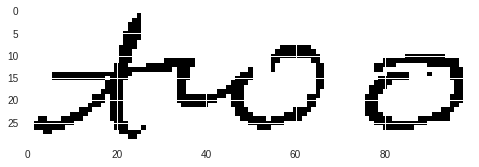

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


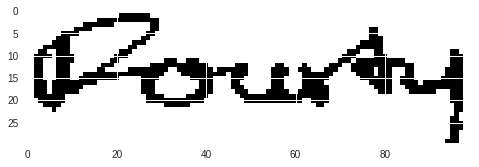

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[20]
['Rupees']


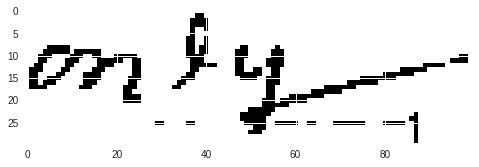

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


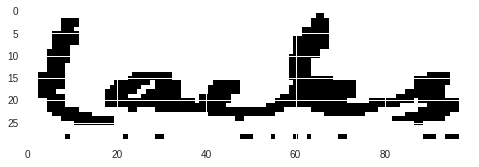

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


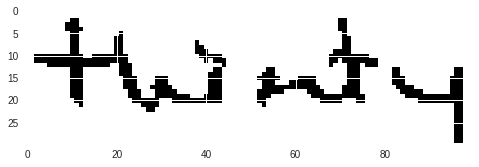

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


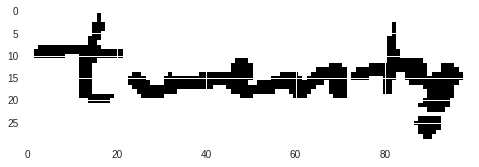

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


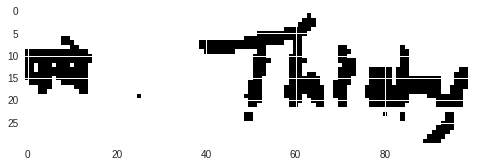

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


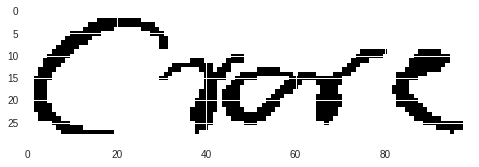

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[16]
['Sixty']


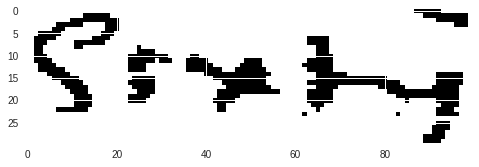

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


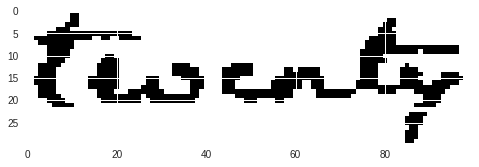

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


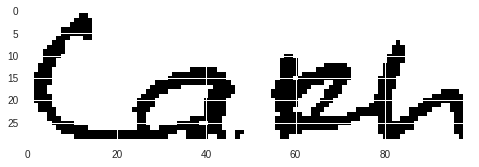

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


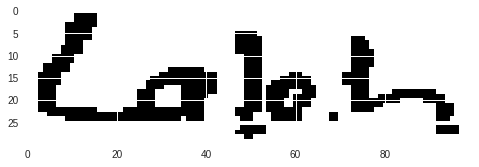

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


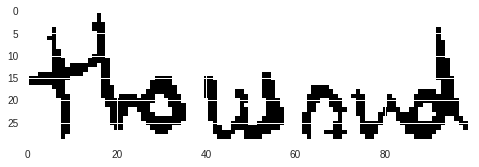

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[29]
['Six']


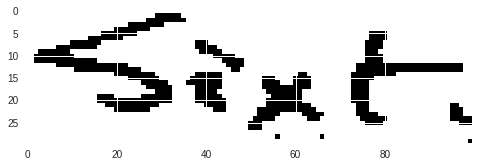

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[3]
['Twelve']


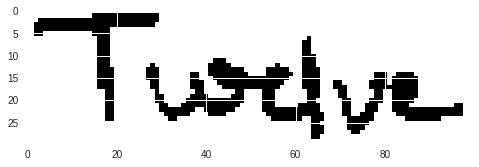

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


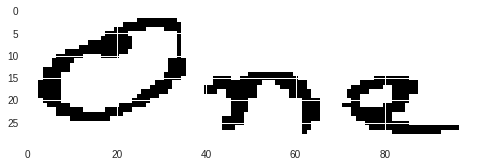

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


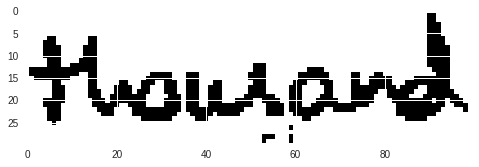

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


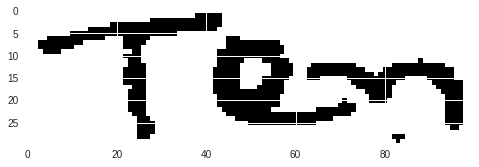

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[31]
['Eight']


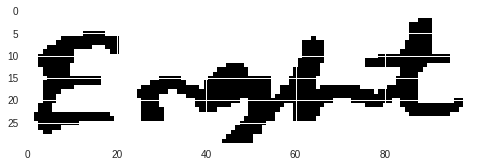

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


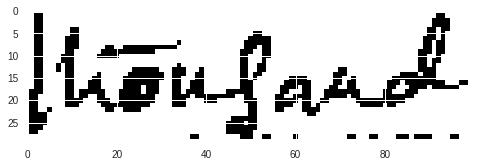

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


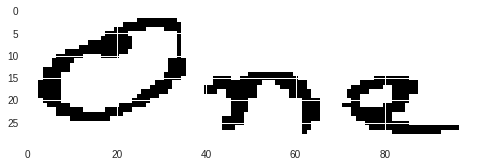

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[16]
['Sixty']


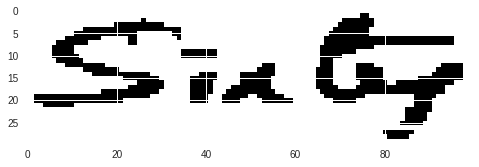

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[15]
['Fifty']


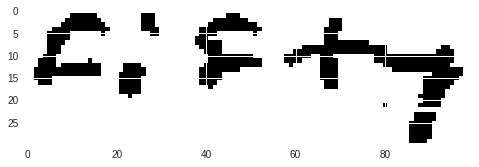

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


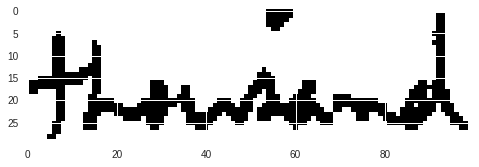

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


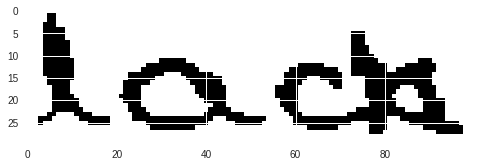

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


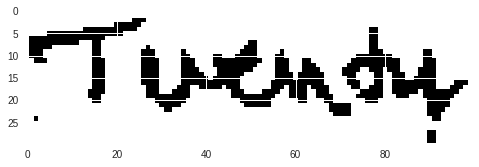

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


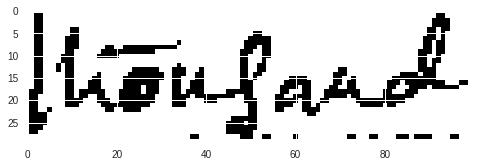

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


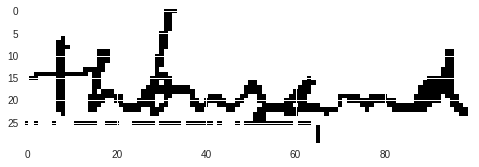

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[31]
['Eight']


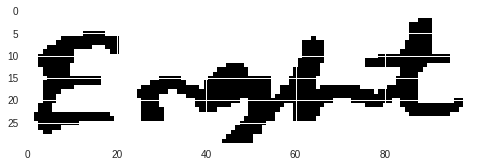

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


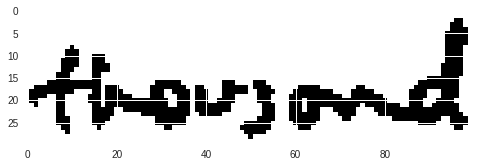

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


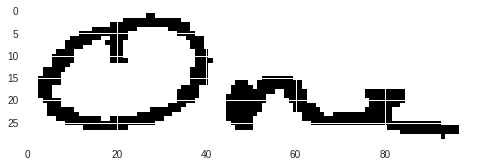

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


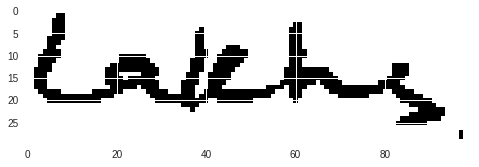

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


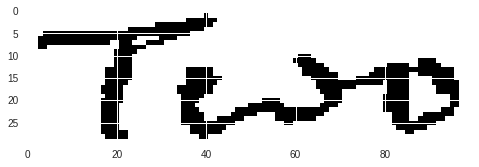

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


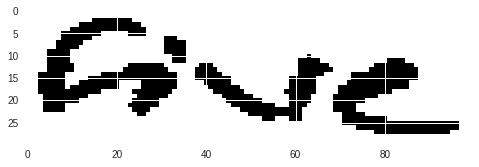

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


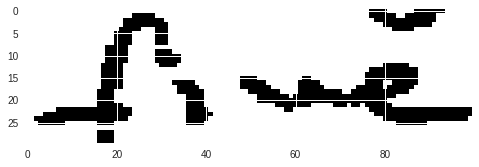

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


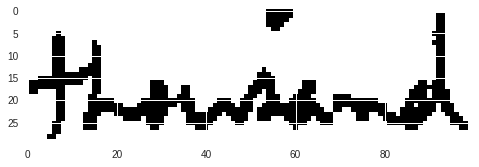

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


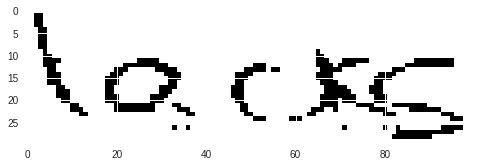

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


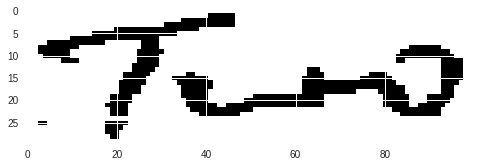

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


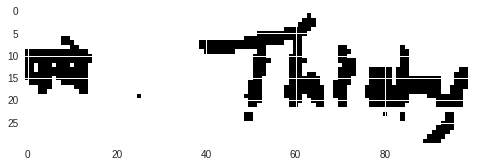

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


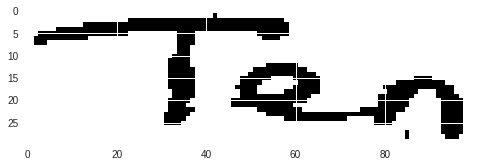

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


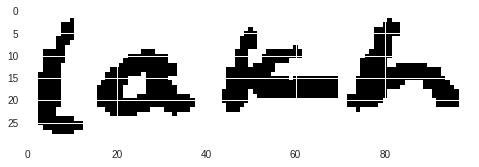

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[29]
['Six']


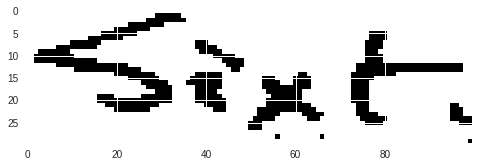

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[23]
['Hundred']


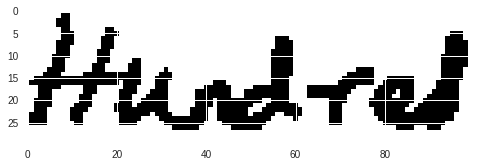

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


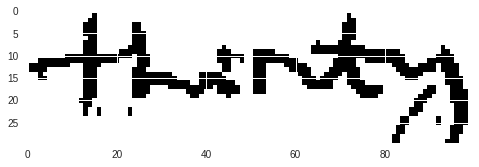

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


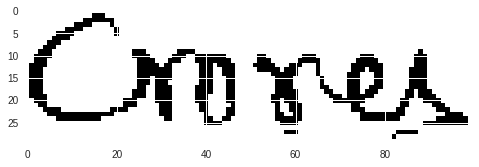

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


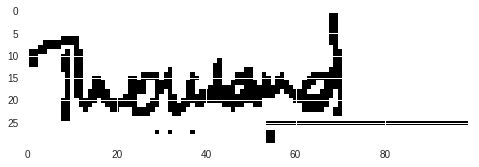

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


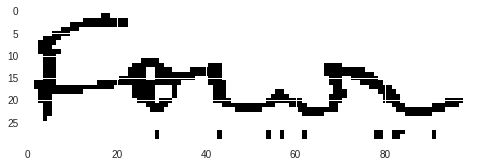

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


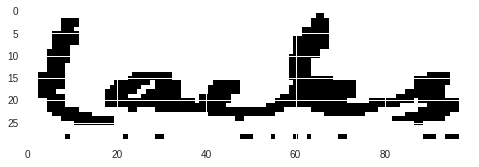

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[17]
['Seventy']


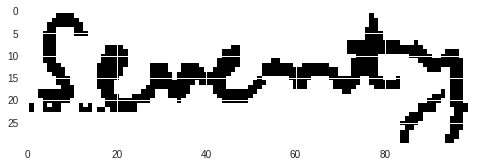

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


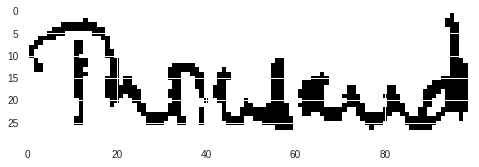

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


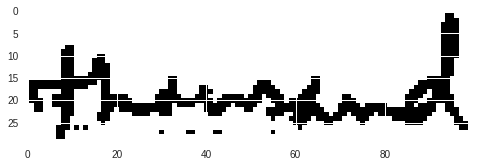

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


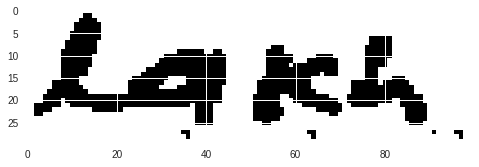

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


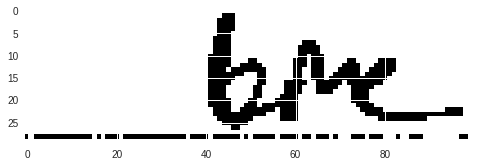

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


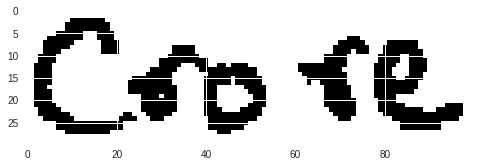

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


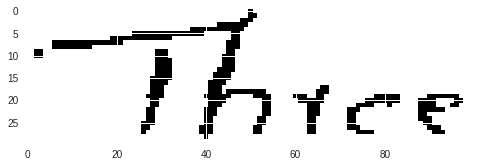

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


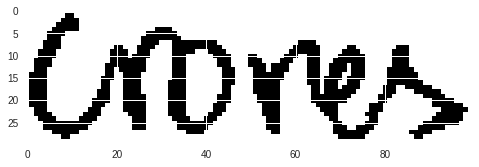

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


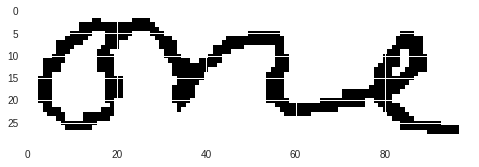

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


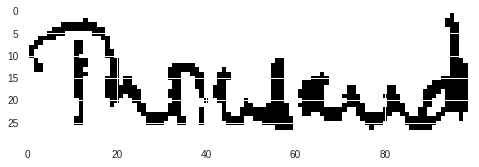

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


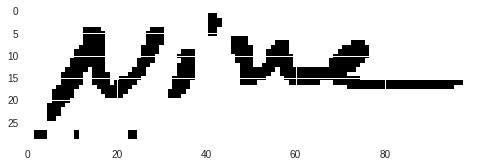

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


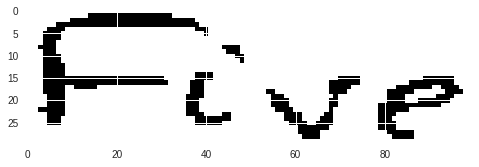

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


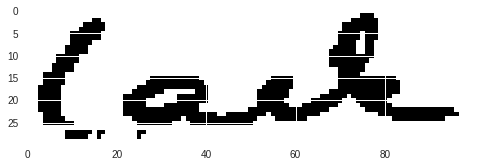

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


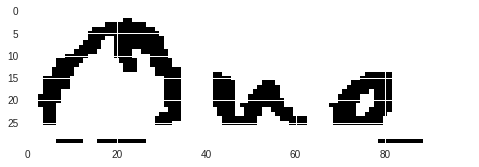

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


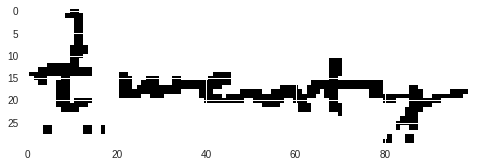

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


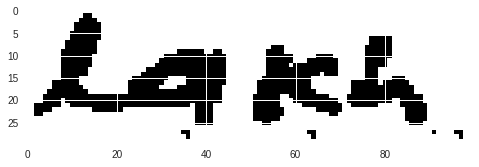

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[30]
['Seven']


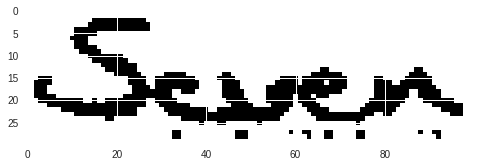

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


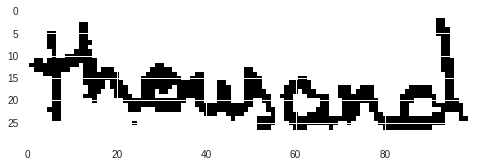

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


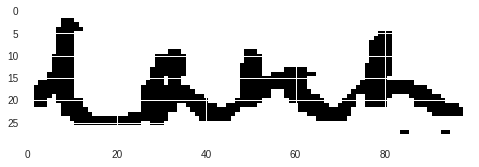

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


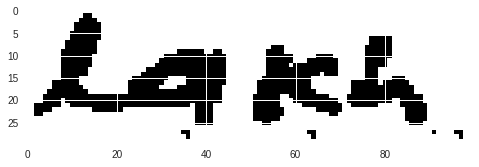

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


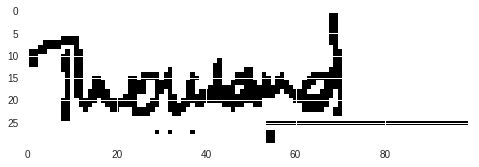

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


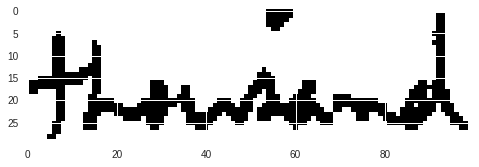

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[21]
['Only']


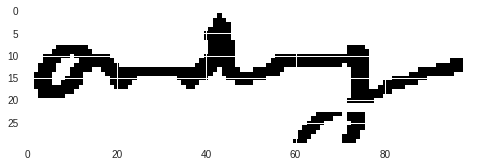

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


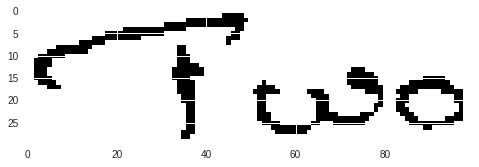

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


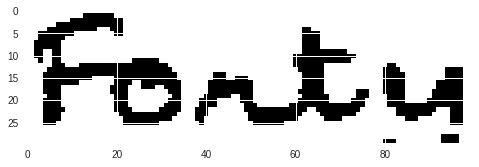

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


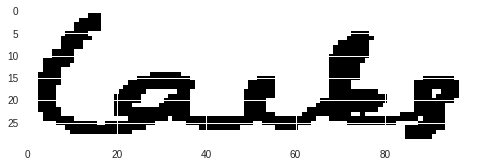

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


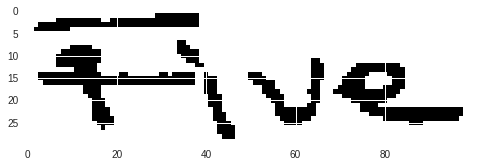

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


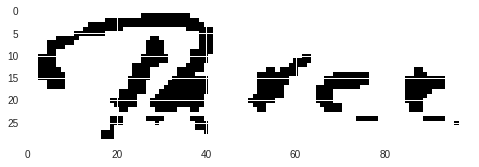

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


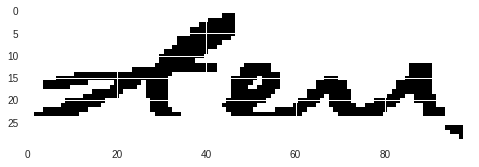

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


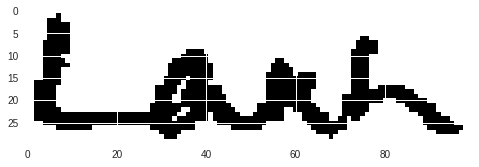

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


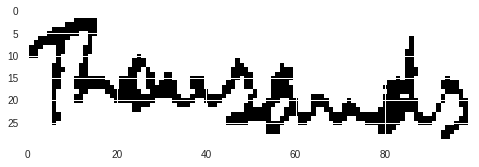

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


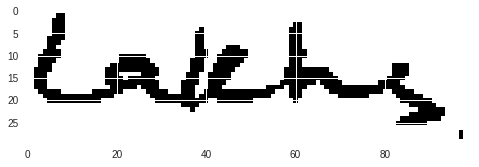

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


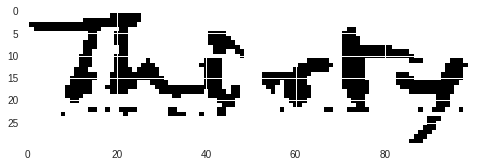

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


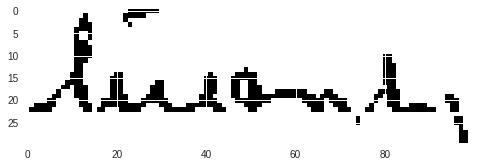

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


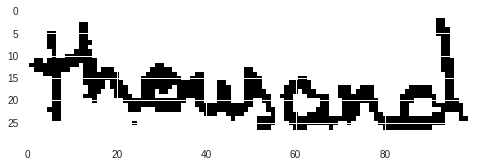

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


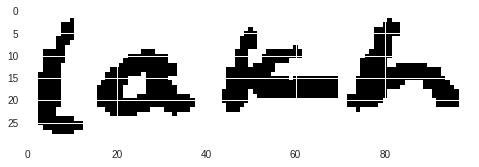

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[15]
['Fifty']


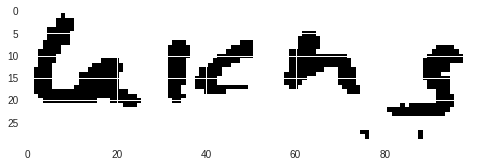

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


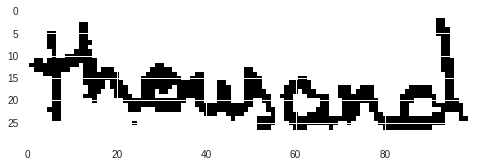

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


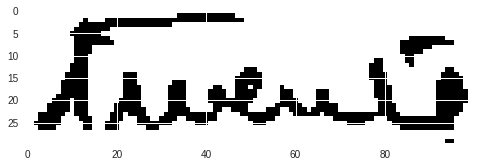

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


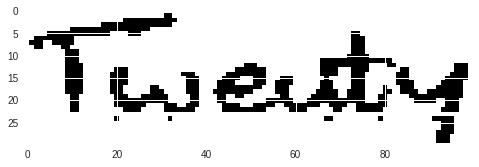

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


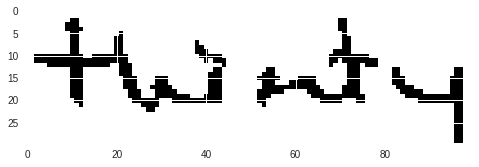

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[16]
['Sixty']


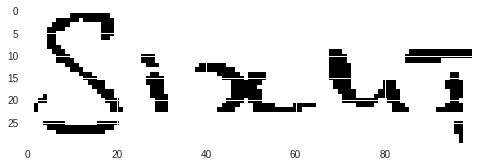

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


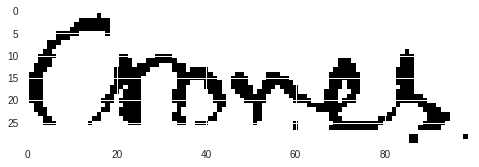

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


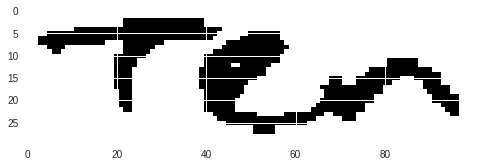

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


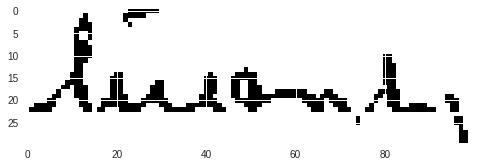

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[18]
['Eighty']


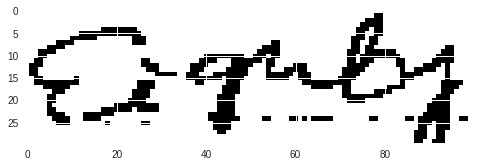

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[16]
['Sixty']


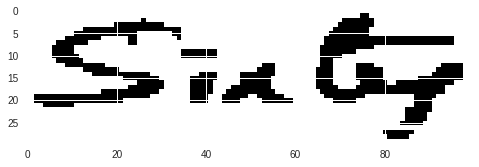

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


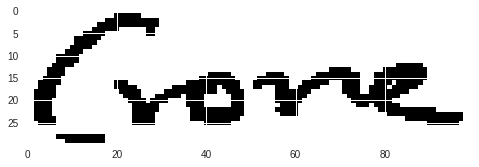

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


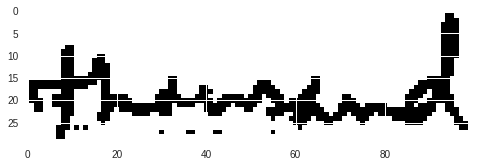

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


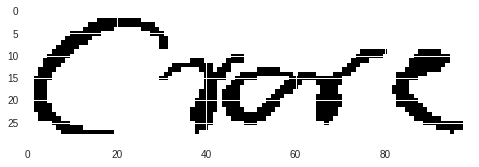

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


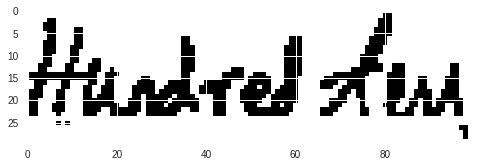

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


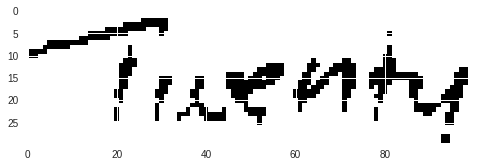

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


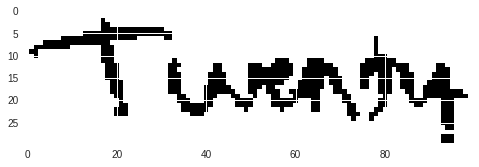

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


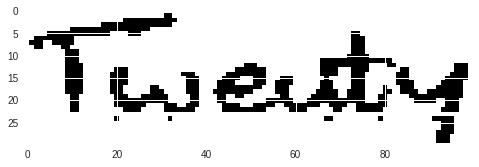

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


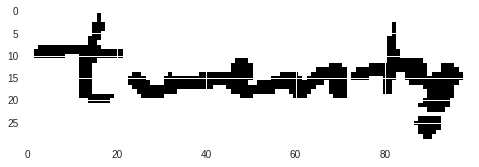

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[23]
['Hundred']


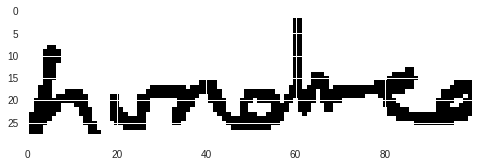

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[3]
['Twelve']


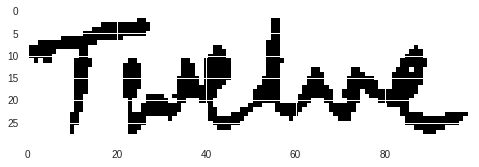

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


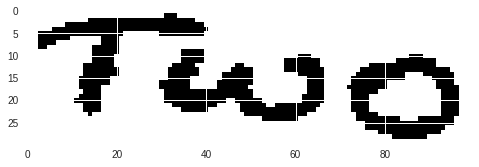

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[18]
['Eighty']


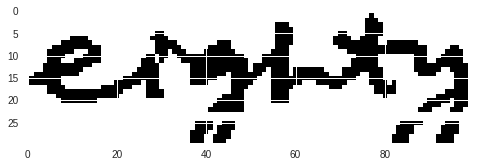

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


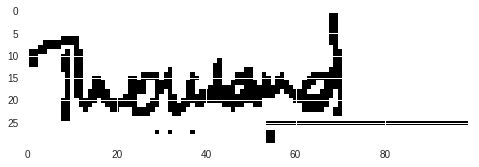

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


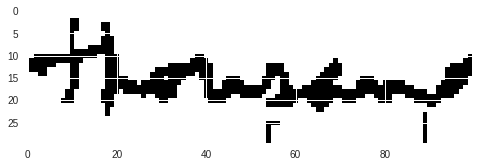

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[29]
['Six']


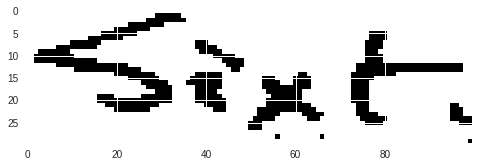

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


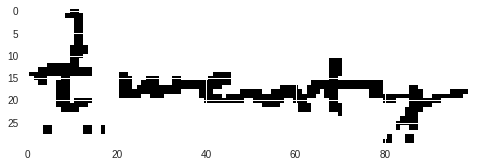

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[2]
['Eleven']


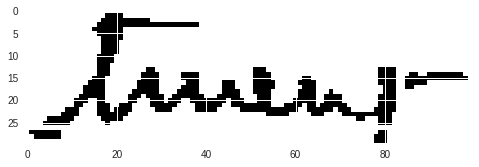

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


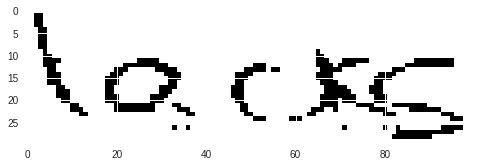

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


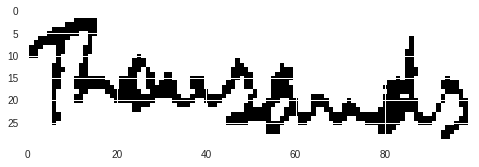

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


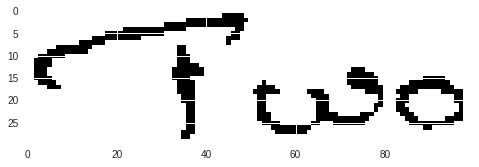

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


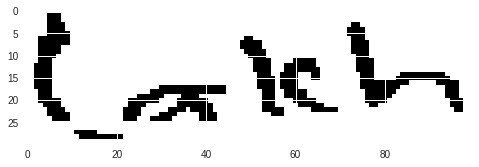

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[17]
['Seventy']


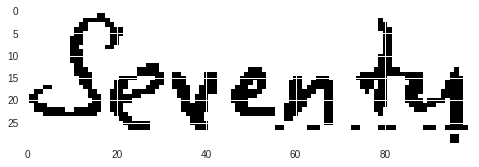

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


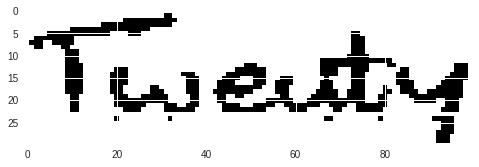

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


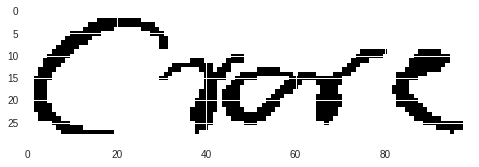

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


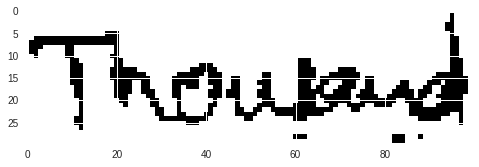

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


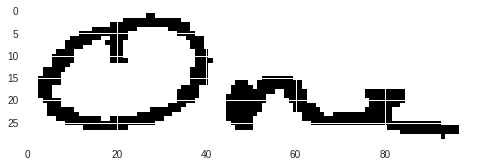

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


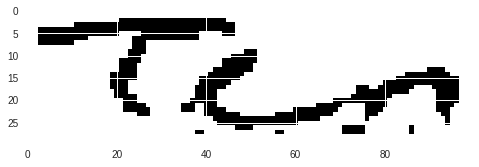

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


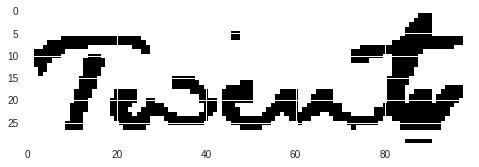

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


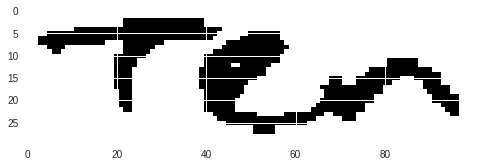

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[2]
['Eleven']


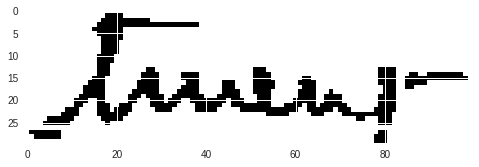

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[32]
['Nine']


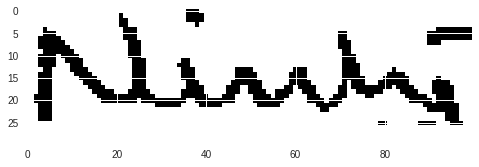

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[7]
['Sixteen']


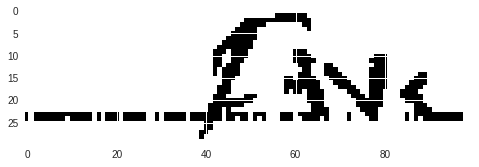

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[23]
['Hundred']


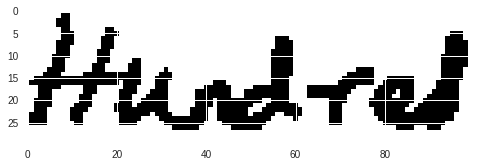

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[16]
['Sixty']


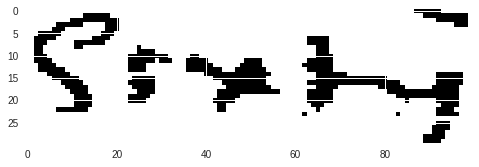

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


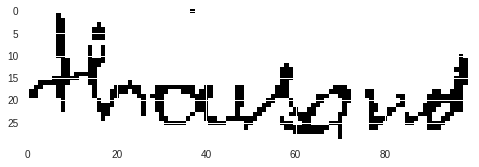

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


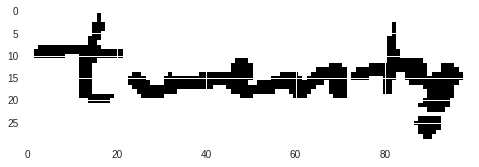

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[16]
['Sixty']


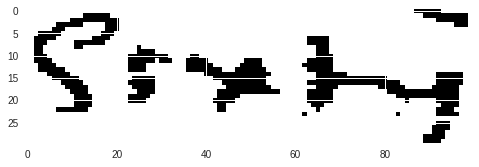

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


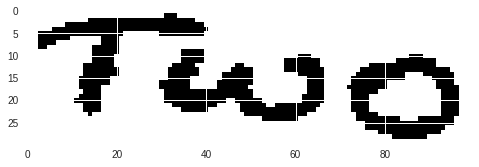

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[17]
['Seventy']


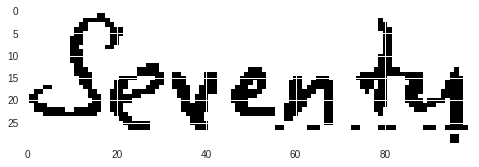

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[21]
['Only']


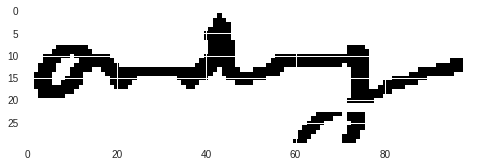

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


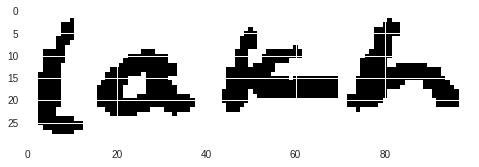

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


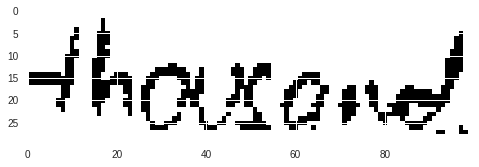

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


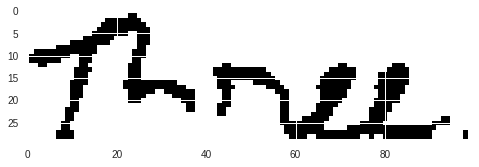

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


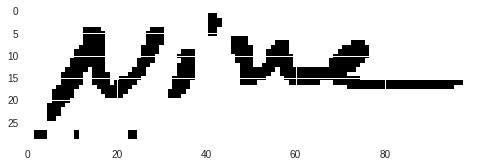

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


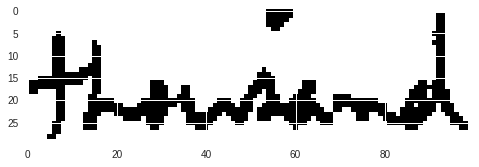

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


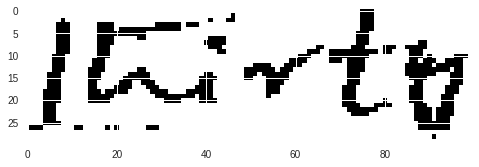

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


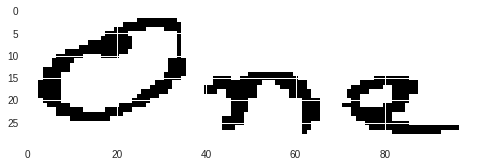

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


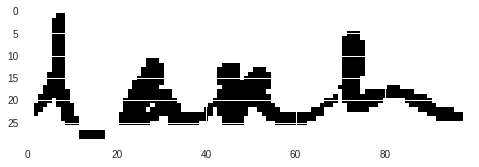

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


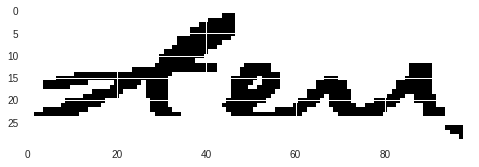

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


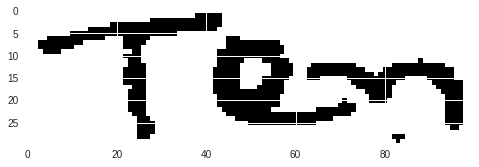

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


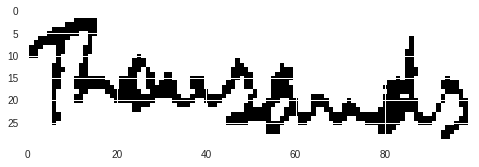

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


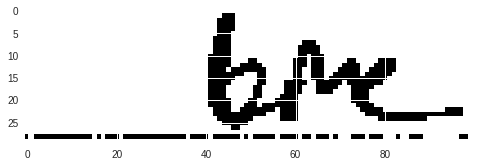

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


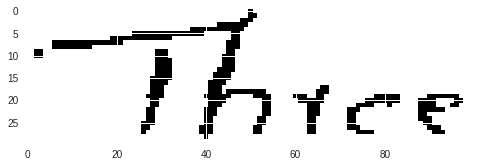

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


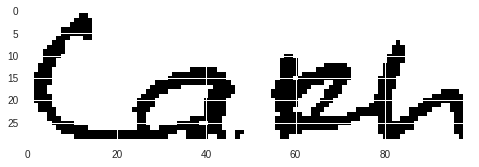

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


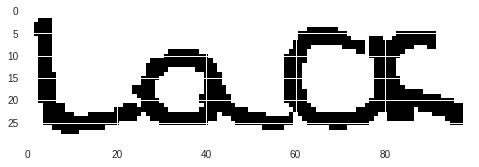

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


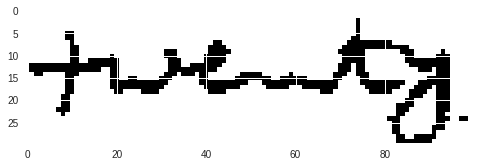

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


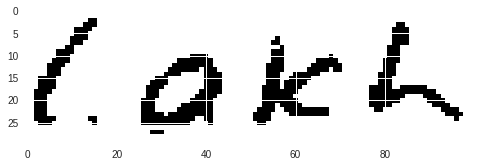

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


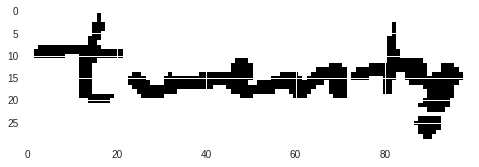

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


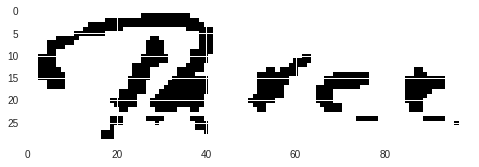

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[6]
['Fifteen']


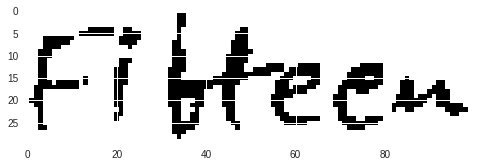

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[4]
['Thirteen']


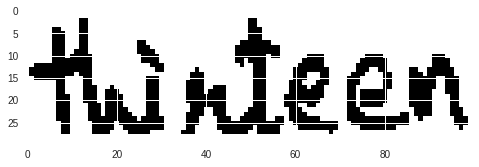

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


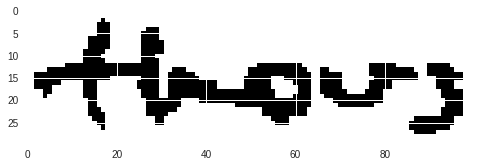

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


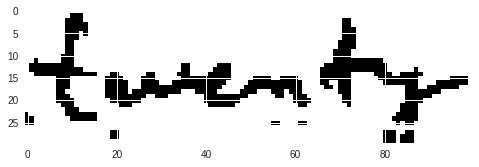

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


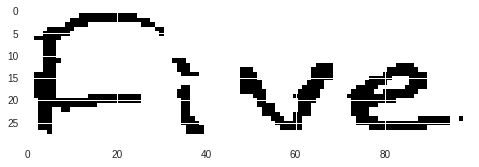

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


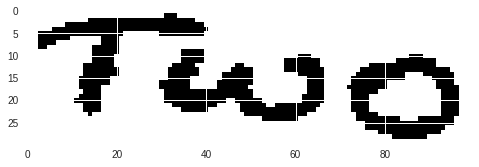

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


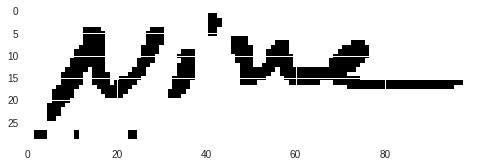

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


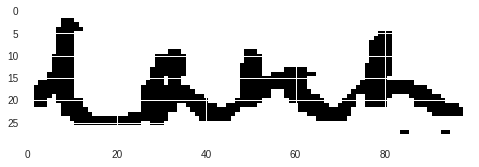

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


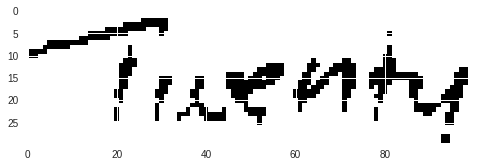

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[4]
['Thirteen']


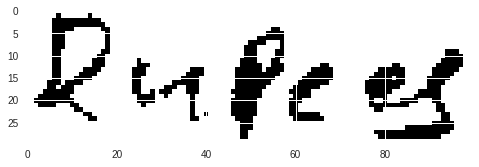

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[2]
['Eleven']


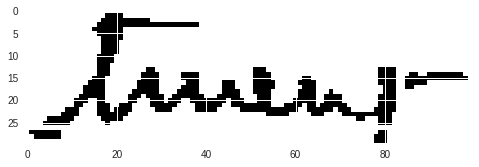

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


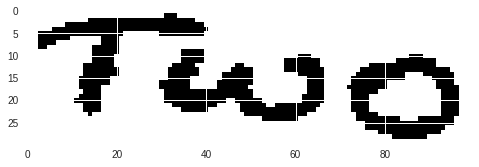

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


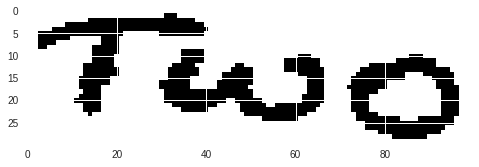

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[1]
['Ten']


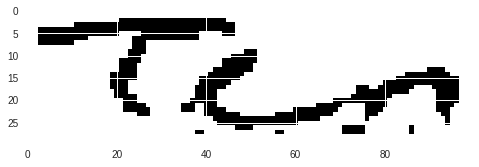

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


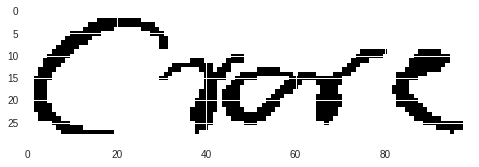

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


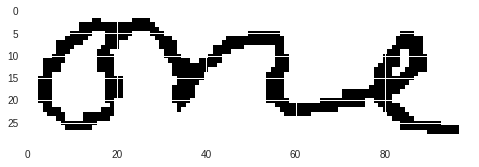

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


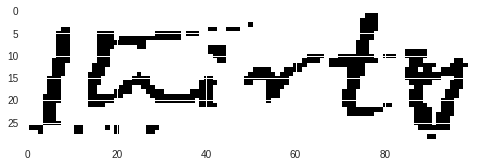

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


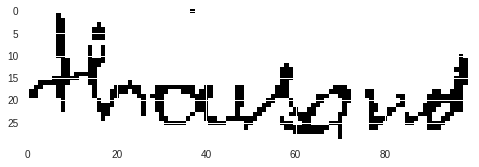

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[2]
['Eleven']


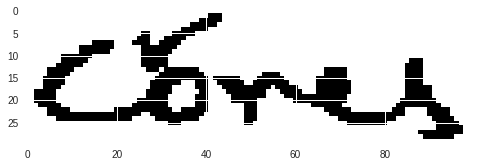

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


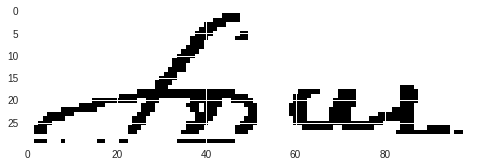

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


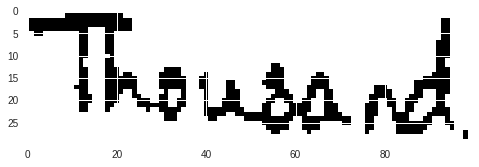

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[13]
['Thirty']


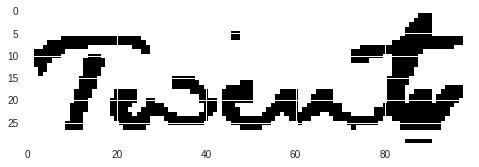

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[29]
['Six']


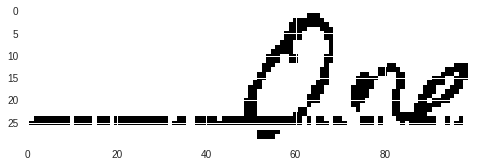

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


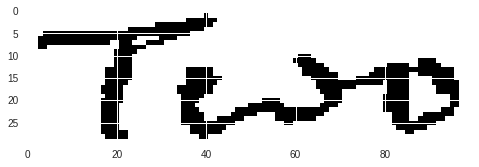

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[16]
['Sixty']


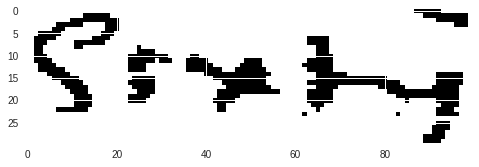

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[20]
['Rupees']


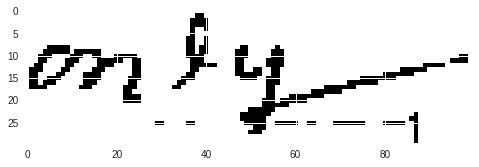

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


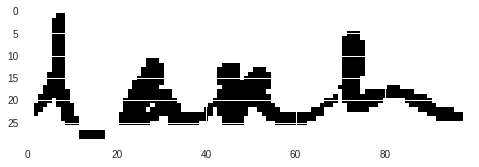

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[0]
['One']


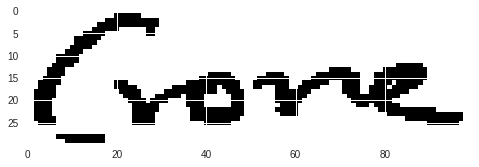

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


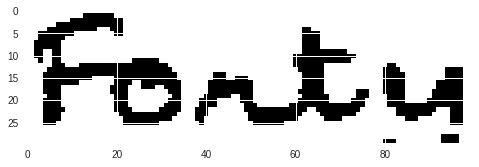

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


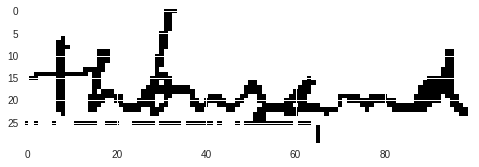

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


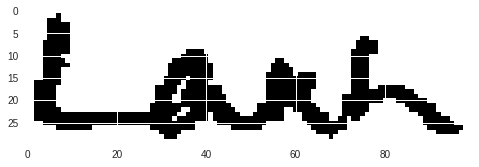

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


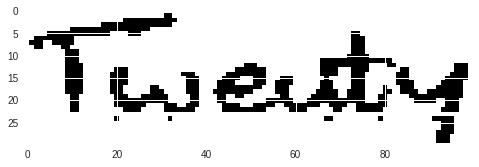

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


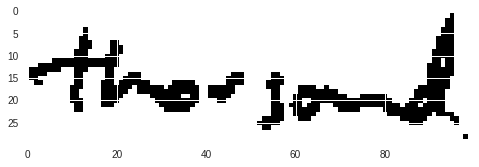

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


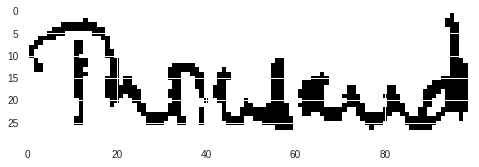

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


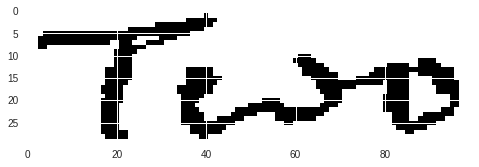

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


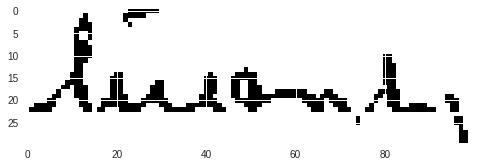

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


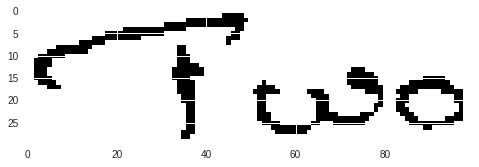

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[28]
['Five']


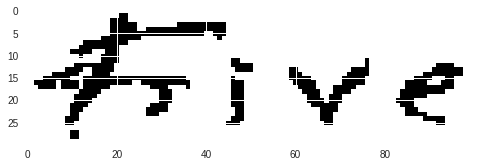

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


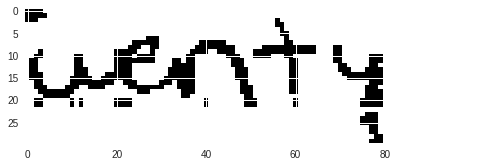

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


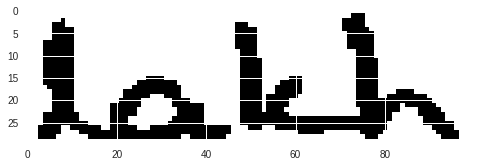

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


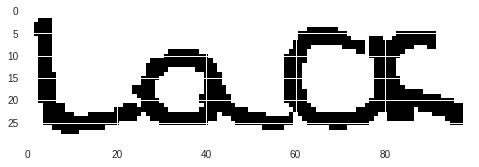

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[18]
['Eighty']


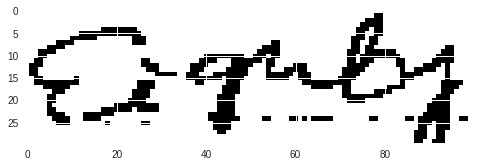

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


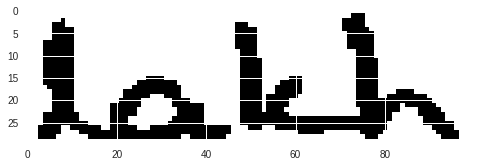

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


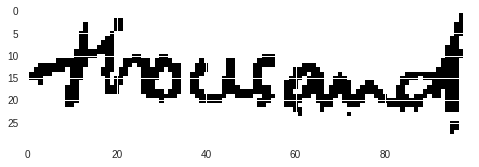

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


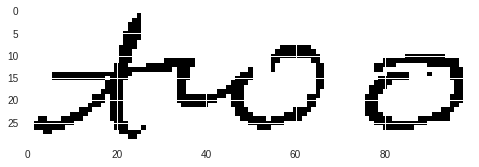

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[6]
['Fifteen']


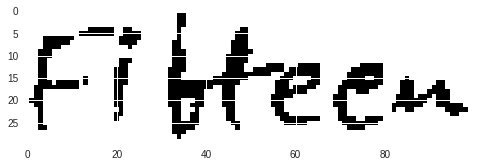

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[12]
['Twenty']


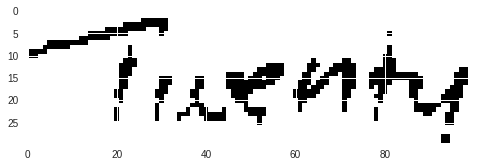

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


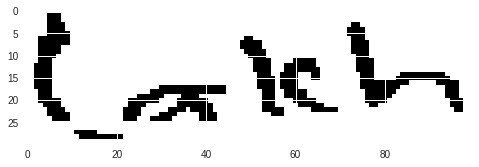

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[22]
['Three']


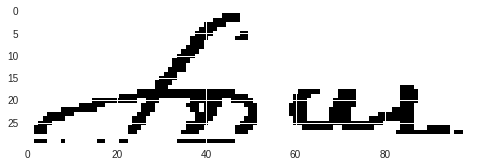

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


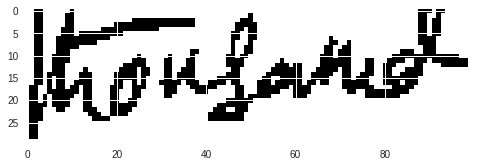

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


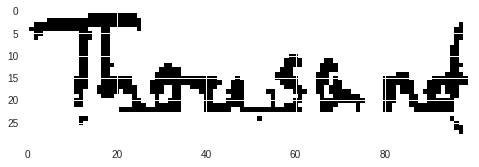

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


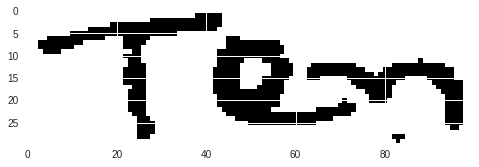

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[16]
['Sixty']


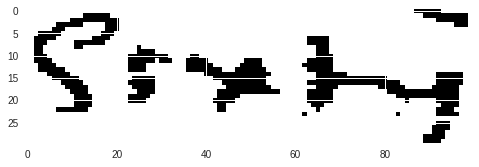

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[17]
['Seventy']


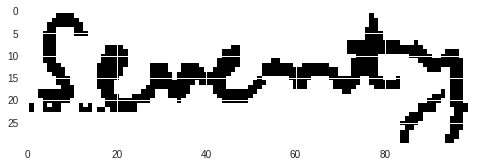

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


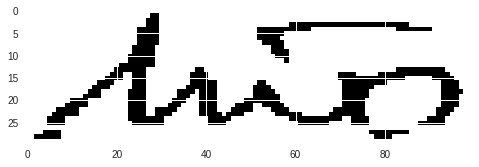

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


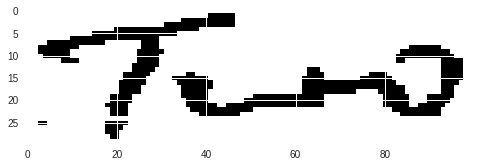

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[11]
['Two']


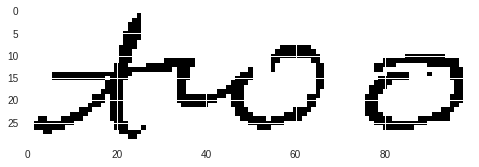

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[24]
['Thousand']


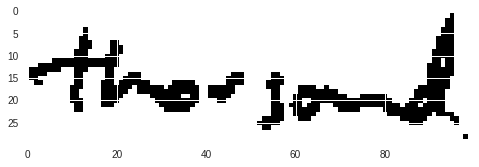

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[27]
['Four']


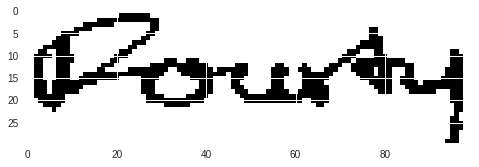

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[19]
['Ninety']


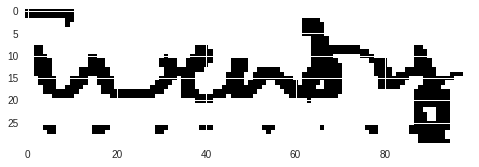

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[25]
['Lakh']


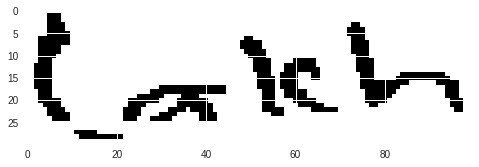

------------------------------End: test------------------------------
(1, 30, 100, 1)
------------------------------Begin: Prediction------------------------------
[26]
['Crore']


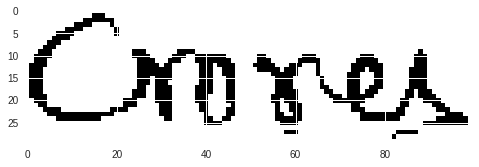

------------------------------End: test------------------------------


In [0]:
import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import random

def load_prediction_my_data():
    pred_data = None
#     dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/legal_amount_test/"
    dir_path = "/content/gdrive/My Drive/FYP/Automated cheque processing/dataset/Legal_Amount_Good_Test_Set/"
    dir_path_1 = "/content/gdrive/My Drive/Nisarg Colab/Datasets/legal_amount/"
#     pred_file_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/singles_test.txt'
    classes = [d for d in os.listdir(dir_path_1) if os.path.isdir(os.path.join(dir_path_1, d))]
    classes.sort()
    class_indices = dict(zip(classes, range(len(classes))))
    print (class_indices)
    
    filenames = glob.glob(dir_path + "*.tif")
    print (len(filenames))
    i = 0
    random.shuffle(filenames)
    for filepath in filenames:
#       if i == 50:
#         break
      i+=1
      __, filename = os.path.split(filepath)
#       img = image.load_img(filepath, target_size=(30, 100), grayscale = True)
#       plt.imshow(img)
#       plt.show()
      img = cv2.imread(filepath, 0)
      img = cv2.resize(img,(100, 30), interpolation = cv2.INTER_AREA)
      x = image.img_to_array(img)
#       print (x.shape)
      (thresh, temp) = cv2.threshold(img, 32, 255, cv2.THRESH_BINARY)
      (thresh, eroded) = cv2.threshold(temp, 32, 255, cv2.THRESH_BINARY_INV)
#       plt.imshow(eroded)
#       plt.show()
      eroded = deskew(eroded)
#       plt.imshow(eroded)
#       plt.show()
      (thresh, eroded) = cv2.threshold(eroded, 32, 255, cv2.THRESH_BINARY)
      x[:,:,0] = eroded
#       plt.imshow(x[:,:,0])
#       plt.show()
      x = x.astype('float32') / 255.
      if pred_data is None:
        pred_data = np.array([x])
      else:
        pred_data = np.concatenate((pred_data, [x]))

#     print(pred_data.shape)
    return pred_data, classes, class_indices

def test_my_pred_data(model, model_svm, data, class_indices):
    print (data.shape)
    x_test = data
    y_pred_caps = model.predict(x_test)
    y_pred = model_svm.predict(y_pred_caps)
    print('-'*30 + 'Begin: Prediction' + '-'*30)
#     print('-'*30 + y_pred + '-'*30)
    print(y_pred)
#     print (np.argmax(y_pred, axis=1))
#     temp = np.argmax(y_pred, axis=1)[0]
#     print (temp)
    values = {'One': 0, 'Ten': 1, 'Eleven': 2, 'Twelve': 3, 'Thirteen': 4, 'Fourteen': 5,
              'Fifteen': 6, 'Sixteen': 7, 'Seventeen': 8, 'Eighteen': 9, 'Nineteen': 10, 'Two': 11,
              'Twenty': 12, 'Thirty': 13, 'Forty': 14, 'Fifty': 15, 'Sixty': 16, 'Seventy': 17,
              'Eighty': 18, 'Ninety': 19, 'Rupees': 20, 'Only': 21, 'Three': 22, 'Hundred': 23,
              'Thousand': 24, 'Lakh': 25, 'Crore': 26, 'Four': 27, 'Five': 28, 'Six': 29,
              'Seven': 30, 'Eight': 31, 'Nine': 32}
    ans = [key for key, value in values.items() if value == y_pred[0]]
    print (ans)
#     for item  in listOfItems:
#         if item[1] == valueToFind:
    
#     img = combine_images(x_test, height = 1)
    image = array_to_img(x_test[0], data_format=None, scale=True)
#     image = img * 255
#     image = image.astype(np.uint8)
#     print(image)
    plt.imshow(image)
    plt.show()
#     plt.imshow(array_to_img(x_recon[0], data_format=None, scale=True))
#     plt.show()
    print('-' * 30 + 'End: test' + '-' * 30)
    
x_test, classes, class_indices = load_prediction_my_data()
#     print(x_test.shape)
for i in range(0, x_test.shape[0]):
  test_my_pred_data(model=model, model_svm = svm_model, data=x_test[i:i+1,], class_indices = class_indices)

## Folder division

In [0]:
import glob
import shutil

directory_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/ISIHWD/"
store_path = '/content/gdrive/My Drive/Nisarg Colab/Datasets/legal_amount/'
sets = ["set1", "set2", "set3","set4","set5"]
for set_num in sets:
    onlyfiles = glob.glob(directory_path + set_num + "/" + "*.bmp") # Cheque 100831.tif
    onlyfiles.sort()
#     print (onlyfiles)
    classes = []
    i = 0
    for filepath in onlyfiles:
        __, filename = os.path.split(filepath)
        word = filename.split('(')[0]
        ext = filename.split('.')[1]
      #   print (word)
        if not os.path.exists(store_path + word):
            os.makedirs(store_path + word)
        new_file_name = word + '-' + str(set_num) + '-' + str(i) + "." +  ext
#         print (store_path + word + '/' + new_file_name)
        if not os.path.exists(store_path + word + '/' + new_file_name):
            shutil.copy(filepath, store_path + word + '/' + new_file_name)
        if i % 50 is 0:
            print ("{} files completed of {}".format(i, set_num))
        i += 1
#   if word not in classes:
#     classes.append(word)
# #   extract_boxes1(filename, filepath, store, img)
# #   i+=1
# classes.sort()
# print (classes)
# print (len(classes))

0 files completed of set1
50 files completed of set1
100 files completed of set1
150 files completed of set1
200 files completed of set1
250 files completed of set1
300 files completed of set1
350 files completed of set1
400 files completed of set1
450 files completed of set1
500 files completed of set1
550 files completed of set1
600 files completed of set1
650 files completed of set1
700 files completed of set1
750 files completed of set1
800 files completed of set1
850 files completed of set1
900 files completed of set1
950 files completed of set1
1000 files completed of set1
1050 files completed of set1
1100 files completed of set1
1150 files completed of set1
1200 files completed of set1
1250 files completed of set1
1300 files completed of set1
1350 files completed of set1
1400 files completed of set1
1450 files completed of set1
1500 files completed of set1
1550 files completed of set1
1600 files completed of set1
1650 files completed of set1
1700 files completed of set1
1750 fil

In [0]:
import cv2
import glob
import json
import random
import csv
import os
import re
import argparse
import numpy as np

def list_pictures(directory, ext='bmp'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
              if f.endswith(ext)]
#             if re.match(r'([\w]+\.(?:' + ext + '))', f)]

directory_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/legal_amount/"
classes = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
print (classes)
print (len(classes))
triplets = []
triplets_val = []
i = 1
class_num = 1
for class_ in classes:
    image_names = list_pictures(os.path.join(directory_path,class_))
    for image_name in image_names:
      try:
          img = cv2.imread(image_name, 0)
      except:
          print (image_name)
    print ( str(class_num) + ' completed --> ' + str(class_))
    class_num += 1
      


['word20', 'word21', 'word22', 'word23', 'word24', 'word25', 'word26', 'word27', 'word28', 'word29', 'word3', 'word4', 'word6', 'word8', 'word10', 'word12', 'word13', 'word14', 'word18', 'word19', 'word33', 'word11', 'word15', 'word16', 'word17', 'word1', 'word2', 'word5', 'word7', 'word9', 'word30', 'word31', 'word32']
33
1 completed --> word20
2 completed --> word21
3 completed --> word22
4 completed --> word23
5 completed --> word24
6 completed --> word25
7 completed --> word26
8 completed --> word27
9 completed --> word28
10 completed --> word29
11 completed --> word3
12 completed --> word4
13 completed --> word6
14 completed --> word8
15 completed --> word10
16 completed --> word12
17 completed --> word13
18 completed --> word14
19 completed --> word18
20 completed --> word19
21 completed --> word33
22 completed --> word11
23 completed --> word15
24 completed --> word16
25 completed --> word17
26 completed --> word1
27 completed --> word2
28 completed --> word5
29 completed --> wo

# Test Model

## Custom Gen

In [0]:

# def load_prediction_data():
#     pred_data = None
# #     dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/legal_amount_test/"
#     dir_path = "/content/gdrive/My Drive/FYP/LegalAmountSegmentationFinal/default/PerfectlySegmented/"
#     dir_path_1 = "/content/gdrive/My Drive/Nisarg Colab/Datasets/ISIHWD_WRITER/writer_1/"
# #     dir_path = "/content/gdrive/My Drive/FYP/Automated cheque processing/dataset/Legal_Amount_Good_Test_Set/"
# #     dir_path = "/content/gdrive/My Drive/FYP/Automated cheque processing/dataset/temporary/"

# #     pred_file_path = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/singles_test.txt'
#     classes = [d for d in os.listdir(dir_path_1) if os.path.isdir(os.path.join(dir_path_1, d))]
#     classes.sort()
#     class_indices = dict(zip(classes, range(len(classes))))
#     print (class_indices)
    
#     filenames = glob.glob(dir_path + "*.tif")
#     print (len(filenames))
#     i = 0
# #     random.shuffle(filenames)
#     filenames.sort()
#     only_filenames = []
#     for filepath in filenames:
#       if i == 10:
#         break
#       i+=1
#       __, filename = os.path.split(filepath)
#       only_filenames.append(filename)
#       img = image.load_img(filepath, target_size=(30, 100), grayscale = True)
# #       plt.imshow(img, cmap='Greys_r')
# #       plt.show()
# #       img = cv2.imread(filepath, 0)
# #       img = cv2.resize(img,(100, 30), interpolation = cv2.INTER_AREA)
#       x = image.img_to_array(img)
#       print (x.shape)
    
# ##################    
    
#       (thresh, temp) = cv2.threshold(x, 32, 255, cv2.THRESH_BINARY)
# #       plt.imshow(temp, cmap='Greys_r')
# #       plt.show()
# #       
# #       w = convertit(temp)
# # #       plt.imshow(w, cmap='Greys_r')
# # #       plt.show()
# #       w = deskew(w)
# # #       plt.imshow(w, cmap='Greys_r')
# # #       plt.show()
# #       element = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
# #       w = cv2.dilate(w, element, iterations = 1)
# #       element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
# #       w = cv2.erode(w, element, iterations = 1)
      
#       my_filter = np.array(([[-1],[0.5],[-1]]), np.float32)
#       # my_filter = np.ones((5,5),np.float32)/25
# #       print (my_filter.shape)
#       temp1 = temp.copy()
#       remaining = cv2.filter2D(temp1, -1, my_filter)
      
#       # cv2.imshow("thresh",thresh)

#       remaining_np = np.asarray(remaining)
#       (thresh, remaining_np) = cv2.threshold(remaining_np, 32, 255, cv2.THRESH_BINARY)
#       # utils.display_image1(remaining_np)
#       remaining_np[remaining_np > 0] = 255
#       # cv2.imshow("remaining_np",remaining_np)

#       h1, w1 = remaining_np.shape[:2]
#       remaining_np[ : 3*(h1//4),:] = 0
#       # cv2.imshow("remaining_np_cut",remaining_np)

#       final = temp - remaining_np
# #       plt.imshow(remaining_np, cmap='Greys_r')
# #       plt.show()
# #       plt.imshow(final, cmap='Greys_r')
# #       plt.show()
#       temp = final
# #       plt.imshow(temp, cmap='Greys_r')
# #       plt.show()
# ####################

#       (thresh, temp) = cv2.threshold(temp, 32, 255, cv2.THRESH_BINARY_INV)
#       print (temp.shape)

# #       plt.imshow(temp, cmap='Greys_r')
# #       plt.show()

#       x[:,:,0] = temp
# #    cmap=plt.get_cmap('gray')
# #       plt.imshow(x[:,:,0], cmap='Greys_r')
# #       plt.show()
#       x = x.astype('float32') / 255.
# #       x = x * (1./255) 
# #       plt.imshow(x[:,:,0], cmap='Greys_r')
# #       plt.show()
#       if pred_data is None:
#         pred_data = np.array([x])
#       else:
#         pred_data = np.concatenate((pred_data, [x]))

#     print(pred_data.shape)
#     return pred_data, classes, class_indices, only_filenames
  
  
# def test_my_data(model, data, args, class_indices, filename):
#     print (data.shape)
#     x_test = data
#     y_pred, x_recon = model.predict(x_test, batch_size=1)
#     print('-'*30 + 'Begin: Prediction' + '-'*30)
# #     print('-'*30 + y_pred + '-'*30)
#     print(y_pred)
#     print (np.argmax(y_pred, axis=1))
#     temp = np.argmax(y_pred, axis=1)[0]
#     print (temp)
#     values = {'One': 0, 'Ten': 1, 'Eleven': 2, 'Twelve': 3, 'Thirteen': 4, 'Fourteen': 5,
#               'Fifteen': 6, 'Sixteen': 7, 'Seventeen': 8, 'Eighteen': 9, 'Nineteen': 10, 'Two': 11,
#               'Twenty': 12, 'Thirty': 13, 'Forty': 14, 'Fifty': 15, 'Sixty': 16, 'Seventy': 17,
#               'Eighty': 18, 'Ninety': 19, 'Rupees': 20, 'Only': 21, 'Three': 22, 'Hundred': 23,
#               'Thousand': 24, 'Lakh': 25, 'Crore': 26, 'Four': 27, 'Five': 28, 'Six': 29,
#               'Seven': 30, 'Eight': 31, 'Nine': 32}
#     ans = [key for key, value in values.items() if value == temp]
#     print (ans)
    
# #     img = combine_images(x_test, height = 1)
    
#     image_test = array_to_img(x_test[0], data_format=None, scale=True)
# #     image = img * 255
# #     image = image.astype(np.uint8)
    
# #     print(image)
#     plt.imshow(image_test, cmap='Greys_r')
#     plt.show()
# #     plt.imshow(image, cmap=plt.get_cmap('gray'))
# #     plt.show()
#     print (x_recon.shape)
# #     img = combine_images(x_recon, height = 1)
#     image_recon = array_to_img(x_recon[0], data_format=None, scale=True)
# #     image = img * 255
# #     image = image.astype(np.uint8)
# #     plt.imshow(array_to_img(x_recon[0], data_format='channels_last', scale=False), cmap=plt.get_cmap('gray'))
#     plt.imshow(image_recon, cmap='Greys_r')
#     plt.show()
#     print('-' * 30 + 'End: test' + '-' * 30)
#     print (filename[0], ans[0])
#     myData = [filename[0], ans[0]]
# #     myFile = open('/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_writer_3/thres3_perfect_seg.csv', 'a')
# #     with myFile:  
# #         writer = csv.writer(myFile) 
# #         writer.writerow(myData)

## Model

In [0]:
from keras.models import load_model

model = load_model('/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/legal_amount/result_writer_conv_added/my_model.h5')
